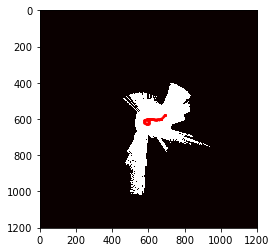

In [48]:
# Simple Integration

import numpy as np
from load_data import *
from p3_utils import *
import matplotlib.pyplot as plt

# function for creating a new map
def new_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -30  #meters
    MAP['ymin']  = -30
    MAP['xmax']  =  30
    MAP['ymax']  =  30 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype='float') #DATA TYPE: float
    MAP['log_map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype='float') #DATA TYPE: float
    
    return MAP

# train set
dataset_num = 3
lidar_data0 = get_lidar('lidar/train_lidar' + str(dataset_num))
joint_data0 = get_joint('joint/train_joint' + str(dataset_num))

# test set
# lidar_data0 = get_lidar('lidar/test_lidar')
# joint_data0 = get_joint('joint/test_joint')

# init MAP

MAP = new_map()

def transform_lidar2body(neck_angle, head_angle):
    # transformation from lidar to head
    h_T_l = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0.15],
                      [0, 0, 0, 1]])
    
    # transformation from head to body
    b_T_h = np.array([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0.33],
                      [0, 0, 0, 1]])
    Rz = np.array([[np.cos(neck_angle), -np.sin(neck_angle), 0],
                   [np.sin(neck_angle), np.cos(neck_angle), 0],
                   [0, 0, 1]])
    
    Ry = np.array([[np.cos(head_angle), 0, np.sin(head_angle)],
                   [0, 1, 0],
                   [-np.sin(head_angle), 0, np.cos(head_angle)],])
    
    b_T_h[:3,:3] = np.dot(Rz, Ry)
    
    b_T_l = np.dot(b_T_h, h_T_l)
    
    return b_T_l
   
def plot_on_map(points):
    for scan_point in points.T:
        line_points = bresenham2D(state_vec[0]/MAP['res'], state_vec[1]/MAP['res'], 
                                  scan_point[0]/MAP['res'], scan_point[1]/MAP['res']) + np.array([[MAP['sizex']/2], [MAP['sizey']/2]])

        # put points on the map
        for pt in line_points.T:
            crash_point.append(pt)
            MAP['map'][int(pt[0]), int(pt[1])] = 1
            
# state initialization
state_vec = np.array([0,0,0]) # x, y, yaw
    
# xy-positions of each pixel of the map
# 1 x 1001
x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) 
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res'])

# deviation grid for x, y in correlation
# 1 x 9
x_range = np.arange(-0.2,0.2+0.05,0.05)
y_range = np.arange(-0.2,0.2+0.05,0.05)

state_vec_collection = []
crash_point = []
for i in range(0, len(lidar_data0), 50):
    
    lidar_d = lidar_data0[i]
    
    # state vector update (dummy rn)
    state_vec = lidar_d['pose'][0]
    
    # main loop [currently just 1st timestamp]
    current_time = lidar_d['t'] # get the time for current lidar scan

    # get the correct time for the joint data
    joint_index = np.argmin(abs(joint_data0['ts'] - current_time))

    # neck angle and head angle
    neck_angle, head_angle = joint_data0['head_angles'][:, joint_index]

    b_T_l =  transform_lidar2body(neck_angle, head_angle)

    
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T # increments for angles
    ranges = np.double(lidar_d['scan']).T # first timestamp

    # only keep valid indices by asserting the range for distance
    
    indValid = np.logical_and((ranges < 30),(ranges> 0.1)) # valid range for scan distance
    ranges = ranges[indValid]
    angles = angles[indValid]

    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])

    # convert position in the map frame here 
    xyz_s = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)

    x, y, yaw = lidar_d['pose'][0] #x, y, yaw

    # transformation from lidar to world
    w_T_l = np.array([[np.cos(yaw), -np.sin(yaw), 0, x],
                    [np.sin(yaw), np.cos(yaw), 0, y],
                    [0, 0, 1, 1.41],
                    [0, 0, 0, 1]])

    xyz1_s = np.concatenate([xyz_s, np.ones(xs0.shape)],axis=0)
    xy_w_scan = np.dot(w_T_l, xyz1_s)[:2,:]

    # from body to world frame
    w_T_b = np.dot(w_T_l, np.linalg.inv(b_T_l))

    plot_on_map(xy_w_scan)
            
    state_vec_collection.append(state_vec)
    
# for plotting the robot trajectory
state_vec_collection = np.array(state_vec_collection, dtype = 'float')
state_vec_collection

# convert from meters to cells
xis = np.ceil((state_vec_collection[:,0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
yis = np.ceil((state_vec_collection[:,1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

plt.imshow(MAP['map'], cmap="hot")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.savefig('dataset3_SimInt_map.png')
plt.show()

i: 50
c_array
(100,)
[ 1071.   906.   833.   851.   630.  1069.   838.   834.   758.   674.
   952.   759.   452.   598.   586.   829.   601.   624.   681.   584.
   894.   757.  1057.  1073.   630.   758.   594.   536.  1017.   632.
   714.   962.   755.   877.  1075.   541.   626.   832.   631.   995.
   644.  1057.   762.   644.   529.   977.   604.   634.   634.   667.
  1073.   938.   494.   763.   622.   612.   962.   991.   948.   620.
   647.   579.   965.   593.   844.   478.   866.   570.   493.   534.
   621.   656.  1066.   827.  1073.   763.   573.  1065.   969.   696.
   997.  1060.  1060.   629.   732.   502.   965.  1031.   498.   561.
   743.  1011.  1073.   893.  1057.   779.   431.   606.   501.   590.]
np.max(c_array)
1075.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-0.02803061  0.01358151 -0.00469961]
particle weights
[  1.17234720e-002   2.57315968e-074   5.09295172e-106   3.34403053e-098
   3.50905142e-194   1.58659941e-003   7.55861054e-1

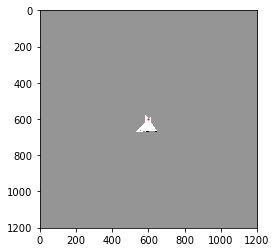

i: 100
c_array
(100,)
[-291. -136.  297. -116. -375. -295. -238.  -96. -402.   14. -308. -191.
   27.  358.  503.  695.  173. -289. -396.  546. -319. -232. -298. -124.
 -286.  368.  208.   18. -265. -128. -111.  701. -330.  184.  605.   88.
  347.   99. -363.   87. -336. -310. -455.  737. -362. -158. -328.  521.
 -206.  415.  264. -150. -204.  -51. -179. -187. -423.  -52. -287. -246.
 -247. -356.  311. -256.  772.    0. -109.   77. -273. -387. -141.  687.
  264. -395.    2.  196.  691.  309. -309.  515. -148.  242. -204. -159.
  263.  332.  102. -281. -199. -379. -171.  124.  395.  136.  246. -413.
  322.  578. -370.   31.]
np.max(c_array)
772.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.01985129  0.0070435   0.00132181]
particle weights
[  0.00000000e+000   0.00000000e+000   5.13004407e-207   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00

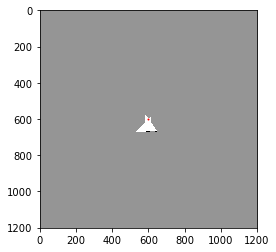

i: 150
c_array
(100,)
[ 168. -340.  187. -421.  537.  117. -225.  403. -350.  275.  475.  646.
  572. -134.  268.  570.  652.  382.  166. -350. -231. -224. -159. -169.
 -188. -203.  743. -155.  242.  157.  386. -272.  450.  164. -246.  648.
  562. -273. -294.  404. -358.  155. -225.  180.  148. -323.  183.  688.
 -246.  126. -168.  257. -344.  152.  367.  479.  725.  220.  634.    7.
 -142. -121. -371. -122. -379.  463.  186.  809. -277.  574. -263.  164.
 -300. -152. -287. -152.  146. -132. -343. -232.  401. -376. -224. -218.
 -390.  356. -289. -285.   17.   32.  193.  306. -120. -379.  213. -177.
 -247. -347. -105.  307.]
np.max(c_array)
809.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.02084408  0.00221906  0.00491357]
particle weights
[  4.14225757e-279   0.00000000e+000   7.39319662e-271   0.00000000e+000
   7.44562094e-119   2.93912815e-301   0.00000000e+000   4.74723081e-177
   0.00000000e+000   1.22108716e-232   8.82354377e-146   1.62180804e-071
   1.18

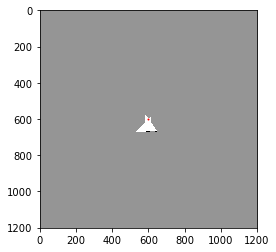

i: 200
c_array
(100,)
[ 278. -372.  288.  157.  231.  703.   48. -128.  128. -341.  226. -198.
  217. -231. -363. -153.  217.  354.  292.  280.  917.  452.  527. -129.
  548.  427.  503.   90. -271. -263. -168. -213. -144. -323.  147. -193.
  659. -320.  692.  634.  246.  218. -368.  217.  740.  635.  137. -224.
 -143.   -7.  591.  369.  482. -210. -419.  254.  115. -341. -379. -177.
  784. -306.   97.   96.  149.  142. -162. -303. -363.  108.  174. -207.
  150.  341. -224.  623.  638. -397.  656.  896.  722. -122.  168.  614.
  597. -235. -357.  158. -363.  888. -427. -333.  754. -109. -251. -356.
  686.  246. -245. -148.]
np.max(c_array)
917.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.02378329  0.00339218  0.00595784]
particle weights
[  3.06073735e-278   0.00000000e+000   6.74172266e-274   0.00000000e+000
   1.18572892e-298   1.15074971e-093   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   7.98937865e-301   0.00000000e+000
   9.85

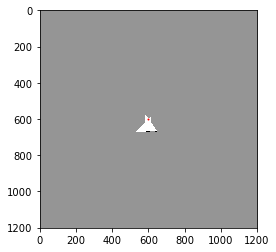

i: 250
c_array
(100,)
[ 591.   10.    2. -303.  163.  419. -243.  714.   63.  329.  192.  225.
  660. -180. -214.  230.  791. -302.  565.  213. -113. -144.   18. -268.
 -201. -407. -228.  687.  671. -328.  833.  534. -124. -335.  -83.   79.
 -220. -316.  135. -114. -340. -407. -126.  520.   86. -120.  826.  718.
  694.   94.  145.  586.  700.  312. -278. -125.  247.  467.  500. -117.
 -283. -296.  528.  139. -283.   46.  362.  247.  539. -307.  204. -286.
   57.  398.  796.  610.  310.  220.  212. -383.  472. -355.  267. -417.
   56.  605.  192.  566.  533.  291.  292.   48. -307.    6.   95.  928.
 -154.  768.   31.  166.]
np.max(c_array)
928.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.02763897  0.0052791   0.00642507]
particle weights
[  4.39298377e-147   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   8.79242579e-222   0.00000000e+000   1.15074971e-093
   0.00000000e+000   7.20452479e-261   2.27270197e-320   4.90884390e-306
   4.06

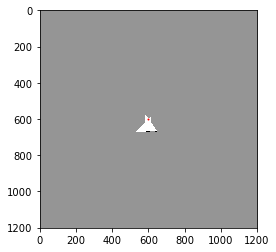

i: 300
c_array
(100,)
[-207.   64. -220.   65. -273. -348. -126.  371. -318.  491. -356.  591.
  685.  396. -343. -173.  721.  146. -163.  250. -373.  354. -407. -192.
 -319.  196. -395.  435.  841. -156. -451. -299.  455. -346.  116.  320.
   47. -407.  647.  542.  353.   26. -266.  255.  614.  136.  343. -218.
  205.  317. -321.  267. -279. -136.  527. -231.  719.  181. -351.  790.
 -347.  786.   18.  207.  459. -277.  342.  558. -261.  545.  454.  117.
 -248. -437. -174. -233. -387. -326.  283. -418. -343.  377. -373. -137.
  337.  720.   83.  470.  945.   26.  218. -252. -343. -100. -188.  172.
 -297. -250.  894.  835.]
np.max(c_array)
945.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.01985194  0.00476099  0.00687486]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   5.18761082e-250
   0.00000000e+000   6.76558284e-198   0.00000000e+000   1.81866792e-154
   1.21

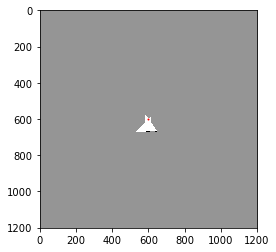

i: 350
c_array
(100,)
[-127.  -99.  191.  736. -312.  294.  910.  380.  238.  848. -135. -302.
 -142.  372. -160. -103.  234.  845. -182.  195.  878. -160. -339. -344.
 -359. -283.  310. -283.  438. -371.  132.  718.  181. -176.  218.  650.
  415. -328.  296. -374.  383.  530.  711. -138. -304.  656.   65. -200.
  771.  499. -130. -408.  290. -254. -184. -310. -301.   90. -455. -366.
 -109. -421.  497. -317. -128.  -82.  -59. -302.  278. -287.  -86.  635.
 -336. -408.  534.  803. -373.  151.   83. -132.   -3.  339.  467. -115.
 -262. -164. -374.  380.  663.  625.  217. -238. -379. -279. -214. -359.
  543.  218. -228.  675.]
np.max(c_array)
910.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03835792  0.00731032 -0.00184457]
particle weights
[  0.00000000e+000   0.00000000e+000   5.52417606e-313   2.70869527e-076
   0.00000000e+000   2.98262839e-268   1.00000000e+000   6.66690998e-231
   1.42596269e-292   1.18506486e-027   0.00000000e+000   0.00000000e+000
   0.00

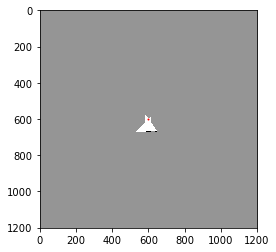

i: 400
c_array
(100,)
[  455.   120.   198.   102.   591.  -179.   929.  -152.  -234.   -55.
  -298.  1018.  -103.  -315.  1032.  -252.   546.   341.   607.   434.
  -115.   569.   692.   177.  -164.   118.  -200.  -214.   513.   851.
   481.  -292.  -161.  -334.   133.   533.   741.     2.    67.  -294.
  -352.   213.   -90.   839.   151.  -304.   149.  -329.  -298.   -86.
   705.   685.  -159.   878.  -206.   213.   -56.   392.  -182.  -320.
  -100.    92.  -233.  -135.   147.   623.  -279.   -19.  -267.   149.
  -331.   989.  -275.   207.   680.  -289.   917.  -417.  -131.   488.
   544.  -105.   648.  -192.   674.   779.  -106.  -190.   242.   324.
  -141.   457.  -119.   270.   -88.  -228.  -164.  -320.  -330.  -201.]
np.max(c_array)
1032.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03414717  0.00600344  0.00449112]
particle weights
[  2.58275720e-251   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.99318196e-192   0.00000000e+000   1.85211523e-

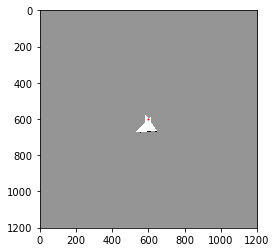

i: 450
c_array
(100,)
[ -62. -240.  -88.  629. -347.  327. -295.  313.  193.  128.  288.  838.
 -246. -295. -262.  -82.  893.  294.  275.  -40. -338.  211.  507. -263.
  835.  -33.  849.  359.  358.  180. -370.  -85. -394. -204. -165.  319.
  950. -337.  374.  113.  410.  881.  740. -260. -369.  923.  705. -345.
 -269.  409. -157.  418.  906. -292.  295. -358.  420.  298. -366.  643.
  635.  204. -421.  630.  -45. -294. -235.  872.  496. -132.  513.  605.
   82.  898. -380. -110. -330.  274.  474.  203. -407. -332.  632.  -92.
   34. -351.  492. -265. -271.  305. -354.  360.  628.  406. -204. -403.
  162.  111.  561.  -98.]
np.max(c_array)
950.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.04917544  0.01110278 -0.0016325 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   3.90365393e-140
   0.00000000e+000   2.71980504e-271   0.00000000e+000   2.26159600e-277
   0.00000000e+000   0.00000000e+000   3.14089183e-288   2.28569368e-049
   0.00

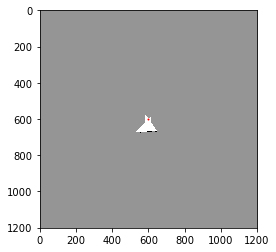

i: 500
c_array
(100,)
[ -10. -184.  570. -407. -108.  197. -207. -144. -118.  338. -145. -104.
  222. -349. -233. -407. -160.  679. -298. -267. -193.  609.  682. -252.
 -120. -278.   88. -146.  549.  328. -245.   55. -108.  458.  -89.  274.
  714. -105. -296.  261. -165. -126.  715.  660. -153.  450. -297. -173.
  425. -140.  250. -372. -393. -144.  161.  512.  611.  195.  -35.  520.
  536. -226. -110.  356.  518. -151.  792. -386.  935. -290.  249.  579.
    0.   38. -367. -242.  580.  585. -120.  260. -202. -150.  531. -392.
 -166. -360. -342. -145.  652. -126. -337.  180.  697. -305. -164.  -99.
 -407.  915. -350. -322.]
np.max(c_array)
935.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03114558  0.01403321  0.00156471]
particle weights
[  0.00000000e+000   0.00000000e+000   3.03748474e-159   0.00000000e+000
   0.00000000e+000   2.96439388e-321   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.32346377e-260   0.00000000e+000   0.00000000e+000
   2.22

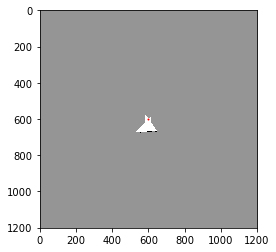

i: 550
c_array
(100,)
[ 449. -203. -159. -252. -178.  300.  135. -369.  297. -154. -132. -316.
  263.  826. -298. -300. -384. -297.  561. -155.  515.  553.  142.  550.
 -118.  210.  343. -387. -374.  236. -382.  -26.   19.  665. -331.  339.
 -242. -248. -279.  744.  356.  494. -252.  330.  741. -297. -176.   46.
  428.   51.   62. -249.  813.  740. -143.  627. -140.  270.   90.   67.
 -172. -216.  846.  176. -353.  426.  122. -257.  304.  899. -207. -193.
  303. -208. -367.  625. -335. -262.   41. -148. -361. -127.  439. -166.
 -305. -298.  614.  582.  467. -246.  806. -306. -296.  928.  669.  649.
 -268. -212. -336.  907.]
np.max(c_array)
928.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03272279  0.01222663  0.00193153]
particle weights
[  9.39600346e-209   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.83259022e-273   0.00000000e+000   0.00000000e+000
   9.12392946e-275   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.56

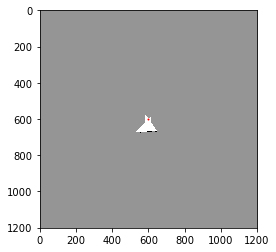

i: 600
c_array
(100,)
[-177.  275.  328. -319.  274. -324. -319. -246.  532. -159.  118.  -14.
 -186. -277. -301.  684. -394.  487. -229. -262. -233. -245. -358. -285.
 -242.  204. -291.  773. -124. -386. -414.  313.  238. -187.  125. -254.
  672.  559.  351. -194. -429. -261.  244.  122. -291.  171.  614. -252.
 -225. -320. -379. -395. -269. -331.   51.  264. -371.  397. -294. -438.
 -248.  473. -459. -225. -243. -214. -186. -265. -459. -444. -183.  444.
  488.  -27.  264.  341.   21. -446.  479.  346.  762. -218.  177. -279.
   13. -250.  172. -330.  609.  174.  578. -255. -305. -225.  114.  130.
 -361.   21. -364.   57.]
np.max(c_array)
773.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.02040418  0.01001634  0.00516295]
particle weights
[  0.00000000e+000   5.26430155e-217   5.48211699e-194   0.00000000e+000
   1.93662831e-217   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.16283111e-105   0.00000000e+000   3.44434860e-285   0.00000000e+000
   0.00

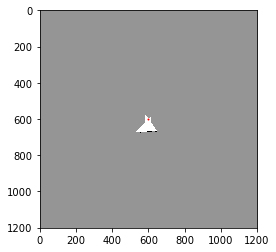

i: 650
c_array
(100,)
[-190.  401. -327.  477. -297.  567.  404. -167. -156.  239.  666. -127.
  785. -273.  599.  289. -255. -385.  328. -217. -348. -356.  401. -361.
  -23. -179. -227.   69. -346.    9.    0.  459.   54. -191. -159.  -83.
 -357. -326.  200.  746. -104. -218.  -33.  373. -215. -206.  297. -102.
 -323.  528. -288.  -82. -100.  394. -237. -214. -295.  478. -162.  534.
   81.  357.    0. -467.   97. -297. -190.  292.  272.   91. -335.  456.
  116.  282. -312.  353. -289.  473.  250. -225.  430. -357.  204.  114.
 -246. -319. -162.   66. -351.  290. -368. -101. -186.  181.  776. -162.
   17. -150. -297. -143.]
np.max(c_array)
785.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03004079  0.00787058  0.00545195]
particle weights
[  0.00000000e+000   1.70163087e-167   0.00000000e+000   1.72681567e-134
   0.00000000e+000   2.10741153e-095   3.41781697e-166   0.00000000e+000
   0.00000000e+000   7.50169301e-238   2.08402565e-052   0.00000000e+000
   9.99

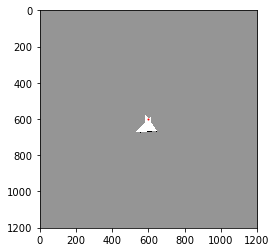

i: 700
c_array
(100,)
[ 313.  552.  292.   77.   93. -365. -240. -238.  749. -317.  165.   46.
 -377. -117.  626. -229. -156.  635.  494.  504. -127.   13. -206.  121.
 -239.  680. -128.  270. -118.  282. -344. -122. -175.  380. -397. -150.
  739. -239.  661.  567. -262. -282.  808. -296.   36. -311.  108. -258.
  294.  488. -232.  590.  556. -208. -158. -366.  298. -382.  519. -266.
  285. -311.  576. -178.  672. -103. -173.  563.  560. -317. -101. -108.
 -164. -321.  372.  -87.  389.  -61. -185.  206. -161.  681. -125.  678.
  331.  443.  207. -275.   39.   39. -208. -344.  328. -228.  306.  325.
  314. -178. -367. -199.]
np.max(c_array)
808.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.0502011   0.01771    -0.00225213]
particle weights
[  1.05738089e-215   6.61626106e-112   8.01765451e-225   3.39423099e-318
   3.01609793e-311   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.38026641e-026   0.00000000e+000   5.60593601e-280   0.00000000e+000
   0.00

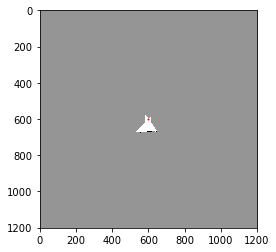

i: 750
c_array
(100,)
[ 203. -349.  229.  499.  -98.  104.  430.  -68. -213.  411. -163.  206.
  -70. -330.  -55. -250. -262. -318. -119. -254.   51. -265.  368. -163.
 -353. -397.   23. -334.  824. -176. -359.  318. -126. -106.  542.  504.
 -278.  679. -388. -110.  344.  661.  123.  116.   26.  579.   86. -146.
 -332. -198.  133. -292.  123.  123.  -23. -131.  567. -293.  302.  458.
  747.  -68. -180. -342.  -77.   29. -131. -369.  504. -407.  478. -298.
 -111. -350.  259. -314.  269.  526. -407. -346.  286.   81. -361. -132.
 -205.  351. -177. -370. -440.  207.  388.  581.  179.  283. -375. -205.
 -332. -290. -110. -135.]
np.max(c_array)
824.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.05674292  0.01779275 -0.00170496]
particle weights
[  2.00967920e-270   0.00000000e+000   3.93353725e-259   7.14979157e-142
   0.00000000e+000   2.03223080e-313   7.72634560e-172   0.00000000e+000
   0.00000000e+000   4.32891416e-180   0.00000000e+000   4.03654858e-269
   0.00

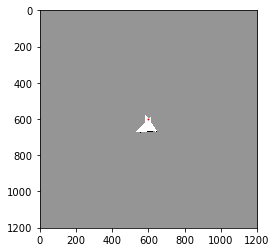

i: 800
c_array
(100,)
[ 455.  727. -261.  738.  191.  182. -299. -303.  939. -116.  933. -149.
 -279. -281. -126. -166.  -11. -134. -141. -249.  609.  542.  213. -207.
  -99.  521.  -71.  128.   55.  502.  298. -155. -138.  278.  322.  210.
  921. -397. -372. -243. -233.  286.  124.  559.  213. -123.  583. -243.
  169.  228.  437.   86.   92.  133.  326.  701. -104. -272. -317.  654.
 -282.  460.  -55.  875. -275. -136. -138. -187.  193.  306. -278. -296.
 -302.   94. -191.  419. -261.  783. -364. -106.  665. -278. -256. -156.
 -247. -255. -277.  779.  261. -242. -220. -254. -105.  158.  -17.   90.
  666. -316. -408.  130.]
np.max(c_array)
939.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.04483318  0.0134329  -0.0009275 ]
particle weights
[  6.31532312e-211   8.48192941e-093   0.00000000e+000   5.07848243e-088
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   9.97527362e-001   0.00000000e+000   2.47262312e-003   0.00000000e+000
   0.00

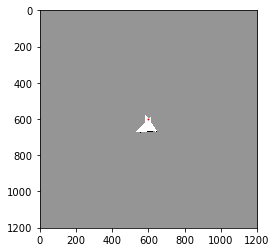

i: 850
c_array
(100,)
[ 134. -175.  199. -167.  293.  607. -166.  348. -315.  379.  806. -255.
  487. -197.  457.  647.  607. -125. -343.  246.  156. -399. -284.  705.
  427. -364. -359. -321. -244.  -93.  383.  314. -269.  608. -172. -118.
  195. -103.  241.  985. -252. -339. -192.  726.  937. -356. -140.  503.
 -170.  372. -241.  290.   97.  775.  -68.  591.  234. -324. -246.  243.
  361.  971. -109. -117. -272. -256.  647.  -68. -291. -284.  901.   28.
 -407.  213.  436. -332. -229.  -97. -278.  232. -267.  522.  201. -337.
  418.  -92.  762. -333.  -86. -289. -247. -342.  266. -231.  267.  693.
 -187.  246.  648. -242.]
np.max(c_array)
985.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.04671155  0.00773226  0.0032821 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.93912571e-301   6.86571038e-165   0.00000000e+000   2.26159412e-277
   0.00000000e+000   6.56967076e-264   1.82510300e-078   0.00000000e+000
   5.26

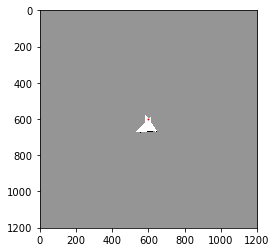

i: 900
c_array
(100,)
[  326.    54.   185.  -207.  -162.   242.  -363.  -350.   -12.   352.
  -162.  -114.   500.   206.   184.   309.   516.   972.   107.   108.
  -120.   781.   481.   255.   528.  -293.   571.   989.  -318.   192.
   568.  1027.   -19.   374.  -444.   289.  -216.  -256.   421.  -193.
  -232.  -117.  -127.  -114.  -407.  -173.  -153.  -255.  -102.    42.
  -229.  -306.  -109.   558.  -312.   -10.   940.   195.    78.   185.
  -114.   478.  -359.   846.   649.   665.  -117.  -354.   710.   365.
  -140.   124.  -308.   622.  -248.   649.   879.    67.   135.   242.
  -131.    57.   202.   381.   374.    86.   708.  -277.   375.   847.
   -81.  -269.  -106.   579.  -204.   150.   641.   -32.   110.  -235.]
np.max(c_array)
1027.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03738955  0.01065473  0.00340799]
particle weights
[  3.62717230e-305   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+

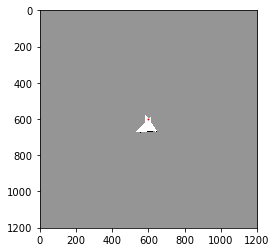

i: 950
c_array
(100,)
[ 967. -335.  484. -260.  131.  584.  -44.  388.  338.  142.  619.  335.
 -322.  768. -184.  253. -407. -262.  408.  203.  618. -153. -207. -324.
  251.   36.  315.  170. -245. -135.  -62.  738. -389. -318.  820.  970.
 -294.  257.  -78.   62.  481.  314. -245.  -43. -316.  401.  837.  893.
  222. -336.   47.  199. -446. -239. -152.  159. -161. -317.  253. -177.
  957.  252.  -10. -137.  295.  130.  380.  -58. -224.  357. -188. -258.
 -160.  152.   53. -264.  221.   58.  243.  204. -177.  825.  704.  -29.
  381.  374. -194.  259.  244. -222. -195. -240.  163. -385. -219. -281.
 -241. -153.  317. -373.]
np.max(c_array)
970.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03616306  0.01538389  0.00485339]
particle weights
[  4.74257711e-002   0.00000000e+000   8.16168147e-212   0.00000000e+000
   0.00000000e+000   2.19395559e-168   0.00000000e+000   1.65771313e-253
   3.19731396e-275   0.00000000e+000   3.47964307e-153   1.59184889e-276
   0.00

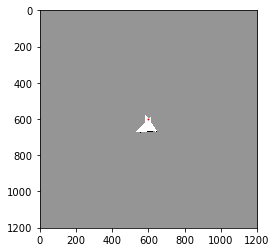

i: 1000
c_array
(100,)
[ -10.  376.  212.  517. -363.  161.  -60. -258.  -66.  237.  829.  232.
  -12. -121. -260. -328. -156.  259. -150.  156. -133. -121.  535.  206.
  127.  315.  515. -235. -387. -360.  191. -191. -313. -309. -151. -350.
 -268.  274.  777.  188. -371.  132. -115. -201.  850. -170. -331.  326.
  614. -335.  569.  -15. -207.  523. -116. -330. -113.  207.   92.  906.
  316.  103.  805. -274.   58.  519.  119. -102.  249. -344. -320. -236.
 -401.  318. -305. -285. -124.  196.  202.  881.  378.  100.   13. -114.
 -190.  590.  619.  480. -320.  -41. -348. -104. -297. -285. -125. -267.
  353.  422. -107.  774.]
np.max(c_array)
906.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.05603179  0.00774836 -0.0020084 ]
particle weights
[  0.00000000e+000   6.66690998e-231   3.97767741e-302   1.14669136e-169
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.86412262e-291   3.62514092e-034   1.92983064e-293
   0.0

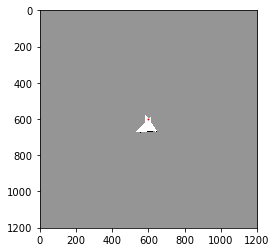

i: 1050
c_array
(100,)
[  119.  -249.  -384.  -342.  -122.    68.   624.  -323.  -113.  -389.
   159.   960.   691.  -215.    32.  -123.  -159.   404.   245.   985.
   866.  -300.   385.  -109.  -319.  -219.   426.   205.  -101.   780.
  -313.   655.   293.   227.  -111.  -412.  -140.   643.   601.  -105.
  -278.  -226.  -181.   875.   821.   790.  -322.   244.   777.  -407.
  -282.  1017.   180.  -151.  -357.  -293.  -407.   726.  -164.   518.
  -349.  -332.   461.  -235.  -130.  -290.   882.   418.   148.   609.
  -111.  -284.   658.  -127.  -193.   266.  -233.  -163.   529.   218.
   416.   448.  -288.  -328.  -303.   -23.  -306.   244.   548.  -350.
   629.  -181.   909.  -189.   458.   754.  -106.  -139.  -245.   268.]
np.max(c_array)
1017.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.05559525  0.0095182   0.00079135]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.10023848e

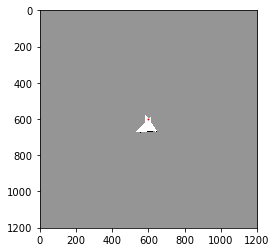

i: 1100
c_array
(100,)
[ 641.  254. -276.  619. -130. -393. -101. -354.  720. -226.  922.  537.
 -345. -417. -127. -446.  375. -291. -241.   93.  208.  958.  220.  609.
  850. -355.  321. -299.  468.  494.  470.  711. -220.  317.  608. -283.
 -101.  747. -176. -407.  358. -124.  111.    8.  224.  113.  887.  141.
   82. -384.  -98.  253.  248.  164. -313. -263.  927. -105.  288. -292.
 -226. -391. -225.  584. -384.   17. -269. -244.  859.  -88.  184.  803.
  951.  275. -197. -113. -167.  983.  193. -261. -168. -277.  668.  634.
  642.  211.  717. -120.  -75.  145.  889.  923. -261.  631. -206.  233.
 -262. -337.  -98. -326.]
np.max(c_array)
983.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.0504265   0.01403288  0.00118133]
particle weights
[  2.95996918e-149   2.50797603e-317   0.00000000e+000   8.25673958e-159
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.03324914e-115   0.00000000e+000   3.22134029e-027   2.01679182e-194
   0.0

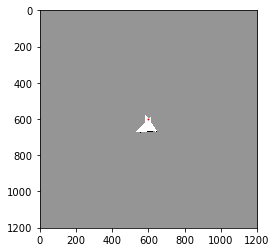

i: 1150
c_array
(100,)
[ 709. -343. -128. -373.  350.  108.  322. -282. -103. -179. -137. -443.
  283.  605. -407. -268. -109.  -84.  489.  447.  906. -284.  723.  320.
 -436.  944.   54.  663.  309. -370.  744.  867.  227.  902. -271.  175.
 -122.  801. -407. -112.  890. -115.  450.  614.  -85. -247. -364. -268.
  470.  146. -379. -238. -387. -294. -375.  766.  596. -263. -296. -110.
  306.  773.   34. -122. -238. -299. -183. -427. -112. -253. -120.  -92.
  858.  787. -261. -222. -208. -112. -341.  661. -159. -133.  618.   20.
  -85. -115. -166. -110. -367.  296. -275.  617.  433. -149.  427. -134.
 -204. -186.  522. -148.]
np.max(c_array)
944.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.0634412   0.00740362 -0.00185548]
particle weights
[  8.72562919e-103   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.06924628e-258   0.00000000e+000   7.39319662e-271   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   8.5

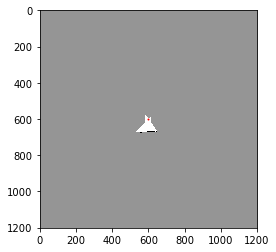

i: 1200
c_array
(100,)
[ -195.  -200.   351.    47.   132.   115.  -118.  -273.   510.  -274.
   128.   577.  -224.   133.  -122.    11.   568.   935.   588.   890.
   500.   708.  -119.  -190.   212.   878.   812.  -403.   584.   798.
    51.  -142.  -289.   536.   282.  -272.  -295.  -287.  -218.     8.
  -179.  -295.  -226.  -228.   124.    94.   928.  -271.  -132.  -363.
  -195.  -401.   630.   -99.  -111.   640.  -358.   745.  -119.   572.
   304.  -315.  -322.   -87.    32.   754.   623.  -308.  -284.  -134.
  -102.   -69.  -277.   388.  -232.   149.  -328.   810.  -384.    92.
  -159.  -404.  -263.  -272.   261.   -34.  -292.     7.   281.   318.
  -128.  -347.   965.  -245.   137.    74.  -110.  -239.  1001.   135.]
np.max(c_array)
1001.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.05028093  0.0066029   0.00175606]
particle weights
[  0.00000000e+000   0.00000000e+000   5.11195195e-283   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e

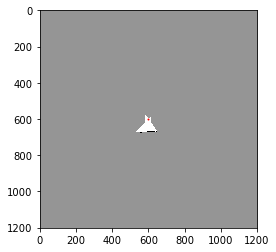

i: 1250
c_array
(100,)
[-137. -129.   58. -399.  316. -260. -119. -156. -184.  243. -217.  451.
  165. -365.  433. -250. -240.  360. -396.  946.  305. -130.  -19. -113.
  140. -122. -281.  135. -130. -126. -300. -370.  -62.  254. -118.  -43.
  734. -271. -104. -166.  435. -179.  280. -256.  138.  485.  131.  236.
  234. -334. -307.  584.  931. -351.  259. -284.  267.  611. -119.  135.
 -305.   -9.  354. -124. -127. -365.  -57.  815. -338. -407. -271.  648.
  -92. -284. -211. -314.  178.  702.  540.  233. -290.  163. -207. -317.
  245. -348. -291. -200. -244.  743. -267.  961.  709.  657.  158.  268.
 -105.  618. -232. -351.]
np.max(c_array)
961.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.07012038  0.00794393  0.0091139 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   7.58680706e-281   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.50162628e-312   0.00000000e+000   3.23455170e-222
   0.0

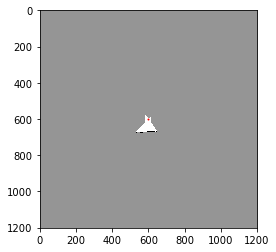

i: 1300
c_array
(100,)
[ 137. -273. -123. -232.  206. -111. -189.   94. -162.  227.  630.  622.
  815.  -78. -107. -154.  -98.  728.  824. -139.  592. -136. -293. -276.
 -161.  189. -213. -322. -289.  691. -357.  -68.  -64.  493. -256.  447.
 -341. -258. -238. -288.  118.  765.  -96.  -95.  271. -256.  790.  -35.
 -109.  -97. -172. -424.  603.  440.  429.  238.  102. -348.  182.  300.
 -193.  673.  907.  477.  -88.  117.  840. -188.   15. -178. -348.  235.
  625.  256.  949. -310.  801.  392. -360.  178. -165. -137. -115. -311.
  584. -334.  506.  171.  273.  587. -316.  406. -151.  -51.  357. -346.
 -158. -393. -139. -248.]
np.max(c_array)
949.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.03632622 -0.00127483  0.00137115]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.75032531e-314   2.88443179e-139   9.67619067e-143
   6.3

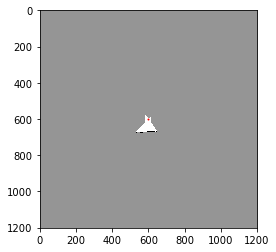

i: 1350
c_array
(100,)
[-269. -108. -286. -112. -359.  806.  574. -152.  217. -485.  665.  850.
 -293. -302.  229. -274. -101.  355. -424.   90.  869.  577.    6. -396.
  644. -188.  198. -115. -111. -180.  340. -318.  785.  -79. -235.  953.
  352.  593.  615. -103. -112. -164. -289. -143. -280. -340.  449.  437.
  162. -155. -219.  190.  542.  705.  -60. -133.  704. -397.  258.  695.
  363. -445. -429.  625. -260. -328. -292. -323. -327. -227. -207.   87.
 -155. -143.  628.  525. -343. -354. -217. -408.  287.  226.  464. -249.
  -33. -136.  169.   48. -213.  791.  -90.  495.  668.  665.  123. -104.
 -106. -270.   52. -416.]
np.max(c_array)
953.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.05010004  0.00588975 -0.02417876]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.44115655e-064   2.52575580e-165   0.00000000e+000
   2.27270197e-320   0.00000000e+000   8.37894253e-126   1.85211677e-045
   0.0

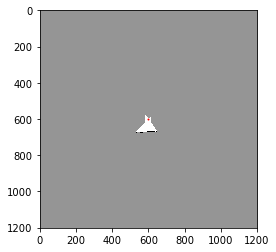

i: 1400
c_array
(100,)
[ 197.  -45.  616. -315.  300. -109. -234.  613. -338.  220.  281. -219.
  -78.  213. -186. -205.  528. -232.  206. -293.  -88. -277. -107. -216.
  857.  332. -251.  309. -153. -373.  172. -209. -160.  190.  603. -351.
 -278. -286. -200.  -77. -183.  400. -307.  244. -277. -117.  694. -353.
 -276.  122. -392.  520. -277.  327.  270. -371.  858. -159.  517.  932.
 -364.  588. -364. -258. -116.  751.  964.  -25.  -41.  103. -104.  435.
  661.  701. -295.  155.  617.  310.  170. -305.  669. -351. -266.  112.
  474. -337.  264. -317.    2.  366.  267. -291.  301. -157.  411. -309.
 -198. -172.  331. -128.]
np.max(c_array)
964.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.08883792 -0.00148677 -0.01508642]
particle weights
[  0.00000000e+000   0.00000000e+000   7.33703005e-152   0.00000000e+000
   4.25073486e-289   0.00000000e+000   0.00000000e+000   3.65289217e-153
   0.00000000e+000   0.00000000e+000   2.38160021e-297   0.00000000e+000
   0.0

/home/samuel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in exp


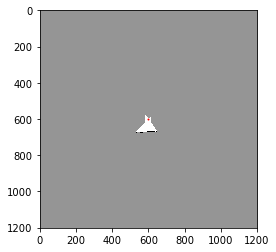

i: 1450
c_array
(100,)
[-390.  678.  162. -392. -202. -173.  793.  601.   71.  400.  145.  142.
 -190. -370. -191.  955. -295.  815.  604.  -99.  488. -267. -288.  469.
  -26. -142.  560.   42. -147. -156.  772.   58. -152. -390.  157. -363.
  574.  540.  322.  181.  997. -326. -359. -391. -380. -274.  612.  213.
 -402.  770.  275. -304. -187.  164.  -73.  947.  -36.  421.  147. -339.
 -267.  146. -248. -234. -333.  -91.  288. -378.   71. -383.  -72.  837.
  498. -345.  803.  -95.   21.  -85.  995.    9.  423. -229. -317.  251.
  -87.  143.  224.  191.  371. -169.  238.  433.  464. -341.  -66. -390.
 -343. -372.  555. -402.]
np.max(c_array)
997.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.0929808  -0.02222577 -0.01940827]
particle weights
[  0.00000000e+000   2.54059909e-139   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.23255187e-089   9.21002972e-173
   0.00000000e+000   4.68889134e-260   0.00000000e+000   0.00000000e+000
   0.0

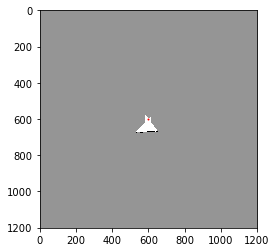

i: 1500
c_array
(100,)
[  223.   190.   536.   912.   223.  -190.  -281.   -79.   775.   412.
  -300.  -125.   188.   541.  -262.   332.   463.   239.    97.   345.
   361.   758.   710.  -275.  -177.   187.  -419.  1005.  -202.  -193.
  -118.   368.  -360.  -325.  -102.   991.   830.   793.   -67.   422.
   -28.  -340.   370.   876.   -96.  -413.  -333.   252.   137.   132.
  -121.  -206.  -190.   845.  -344.   988.   199.  -147.   691.  -303.
   209.   173.  -275.   955.   182.  -342.   574.  -134.   170.  -130.
  -103.   295.  -358.   -52.    94.  -317.   -61.   -86.  -106.   813.
  -380.  -338.    56.  -175.  -393.   476.   -59.  -303.   -38.   -94.
  -101.  -199.    12.   390.  -186.   305.   193.    16.  -239.   729.]
np.max(c_array)
1005.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.15528856  0.02020851 -0.02969634]
particle weights
[  0.00000000e+000   0.00000000e+000   2.06960568e-204   4.07955511e-041
   0.00000000e+000   0.00000000e+000   0.00000000e

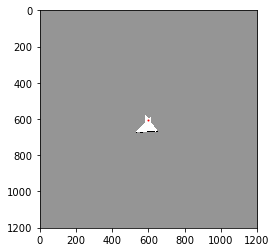

i: 1550
c_array
(100,)
[ 290.   -6. -441.  239.  254.  146.  668.  703.  -72.  576. -290. -237.
 -395. -119. -383.  -15. -309.  228.  208.   45.  278. -145.  233.  221.
 -364.  -63.  -31. -230.    5. -443.  322.   95. -166.  195. -287. -142.
  775.  619. -204. -232.  202.   82. -148. -132.  -93. -308. -359. -243.
  812. -414.  505.  441. -337. -434. -108. -399. -167. -293. -191. -451.
 -271.  351.  157.  380.   72. -224. -455. -264.  772.  581.  804. -440.
  856. -218.  225.   94. -312. -312. -407. -453. -397.  -68. -291.  869.
  816.  -42. -403. -193.  702.  -45.  293.  506. -300. -296.  179.  271.
 -252. -380. -313.  262.]
np.max(c_array)
869.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.34636391  0.05560497  0.01749012]
particle weights
[  3.49537678e-252   0.00000000e+000   0.00000000e+000   2.48013556e-274
   8.10760623e-268   1.01178586e-314   5.09105930e-088   8.07448854e-073
   0.00000000e+000   5.64567431e-128   0.00000000e+000   0.00000000e+000
   0.0

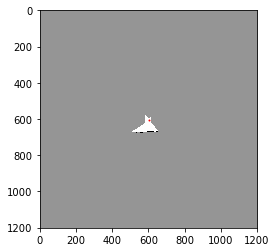

i: 1600
c_array
(100,)
[ -52. -342.  487.  750.   17. -192.  630. -186.  464. -482.  584.  -11.
  468. -309.  160.  814. -316.  175.  190. -117. -245. -170.   22. -479.
 -239. -114. -384. -433.  834.  804.  791.  138.  662. -137.  106. -186.
 -262.  532.  140.  -41.  189.  -32.  -35.  486.  276. -515.  -30. -226.
   29. -109. -531. -521. -243. -224. -235.  255.  843.  750.   51.  -97.
 -144.  218.  198. -245.   47. -262.  183.  197.  396.  725.    5. -239.
 -352.  173. -102.  581.  813.   57.  127.  -21.  472.  -24.  448. -238.
 -528.  -33.  706. -123. -114.  -19. -152.  -46.  827. -257.  -16.  773.
  713.  181.  -48.  754.]
np.max(c_array)
843.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.48185088  0.03883029  0.02772346]
particle weights
[  0.00000000e+000   0.00000000e+000   2.46099539e-155   4.07905481e-041
   0.00000000e+000   0.00000000e+000   3.12767568e-093   0.00000000e+000
   2.52544385e-165   0.00000000e+000   3.29363558e-113   0.00000000e+000
   1.3

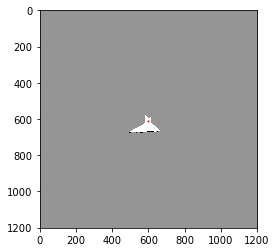

i: 1650
c_array
(100,)
[-124.  -22.  -14.   82. -136.  751. -198. -324.   90. -185. -205. -389.
  722.  -55.   77. -182.    4.   57. -151.  488. -125. -449. -190.  214.
   49.  140. -374. -167.  288.  691.  637.  108. -553.   66.  775. -221.
 -181.  230.  139. -441.  248.  480.  124.   -3.  248.   48.   40. -576.
 -259.   91.   94. -220. -199.  117. -274. -481.  843. -264.  146. -464.
 -191. -318. -241.  -92. -208. -463. -242. -235.  276.  404.   32. -212.
 -227.  727.  777. -163. -187. -204. -553.   47.  198.  459.  -40.   70.
  385.   49. -527.   87.  279.  -31. -190.  -79.  145. -211. -250. -270.
  790.  167. -116. -252.]
np.max(c_array)
843.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.64178758  0.0224487   0.07409292]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.10893902e-040   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.8

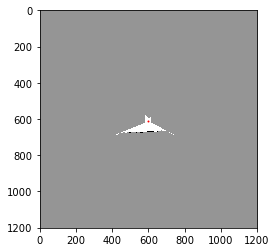

i: 1700
c_array
(100,)
[-168. -506. -575. -380.  112.  -87. -305.  463.  101. -227.   86.   11.
   -3.  286.  119.  131. -143. -118. -540.   76.  150.   27. -291. -278.
 -287.  237.  177.  160. -116.  -26.  -43. -117.  250. -127. -144.   33.
 -524.  -14.  143. -229. -365.   65.   13. -526. -325. -227.  756.  -37.
  -55.   31. -203.  607.  728. -121. -282. -216. -534. -583. -448.  426.
 -355. -137.  812.  252.   68. -282. -574.  367.   36.  625.  710.  109.
  -23.  772.  111. -270.  240. -220.  681.  845. -137. -194.  808. -201.
  350. -171.  191.  711.  177.  850.   36.  171. -202. -295. -346.   37.
  172.  588.  -44. -299.]
np.max(c_array)
850.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.78527522  0.09726446  0.08435235]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.94463125e-321   0.00000000e+000   0.00000000e+000   8.41625847e-169
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

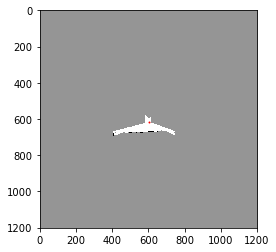

i: 1750
c_array
(100,)
[ 644.   85.  -50.  160. -175.  -21. -120. -582.    7. -289. -181. -249.
  -88. -578.  112.  655.  177.  307. -216. -167. -658.  -29.   92.  561.
 -150. -667.  569. -124. -236. -343.   -9.  -86.  141. -306.  109. -373.
 -511. -466.  825.  699. -146. -116. -141.  115.  236.   -6.  269.  203.
 -242. -246. -234. -248.  -59.   63. -182. -201.  768.   39.  171. -134.
 -640. -181.   22. -107. -623.  833.  -32.  509. -175. -159. -275.  193.
 -159. -285.  -25. -196.  845. -628. -176. -152. -170.    0. -323. -410.
 -298.  320. -162.  367.  -52.  145. -146.  210.  585. -187.   96. -265.
  132. -402.   -3.  119.]
np.max(c_array)
845.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.90978044  0.10736215  0.04843755]
particle weights
[  5.09103952e-088   0.00000000e+000   0.00000000e+000   3.22312558e-298
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

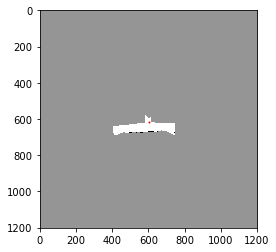

i: 1800
c_array
(100,)
[  63. -624.  640.  171.  671.  458. -206. -286.  184.  -81.  126.  229.
  178.  435. -374. -295. -234. -251.   52.  124. -301. -210.  493.    9.
   14. -394.  496. -234.   52. -174. -256. -278. -164.  796.  299.  774.
  353. -527.  563.  132. -345. -572. -361.  831.  127. -167.  -98.  195.
  -70. -112. -293.   58. -359.  -57. -123.  146. -525.   25. -346. -395.
  -53.  -36. -227.  262.  240.  638. -235. -435. -306.   68. -401. -292.
 -326.  897.  771.  263.  684. -284.  196. -231. -301.  564. -327. -188.
 -161.  260.  657.  122. -133.  894.  700. -678.  765.  105. -114.  304.
 -105. -551. -418. -147.]
np.max(c_array)
897.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 0.97119259  0.09057537  0.06908866]
particle weights
[  0.00000000e+000   0.00000000e+000   2.31855249e-112   4.79849169e-316
   6.73512827e-099   2.10678989e-191   0.00000000e+000   0.00000000e+000
   2.12291783e-310   0.00000000e+000   0.00000000e+000   7.41625869e-291
   5.2

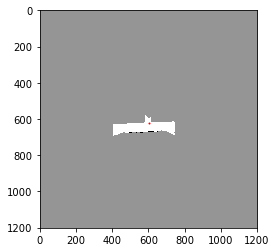

i: 1850
c_array
(100,)
[-195.  542. -152.  136. -144. -102. -573.  -99. -149. -178. -245. -381.
 -197.  127. -122.  500.  463.  514. -133. -458.  573. -242.  -94. -161.
  574.  226. -643.  109.  105. -299.  446.  -19.   78.  337. -146.  -34.
 -122. -415. -123. -177. -302. -168.  142.   -7. -136.  231.  222. -324.
  -17. -662.  130. -429.  572. -146.  264. -356. -322. -477.  399.  262.
 -139. -155.  545.  -66. -303. -186. -195.  461.  -90.  -70.  511. -223.
  565.  326.  102. -282.  288.  209.   80. -363. -332.  -70. -269.  -97.
 -117. -234. -367.  172.  -78.   40.   70. -136. -294. -318.  563. -432.
  -63. -348. -303.   -9.]
np.max(c_array)
574.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.03724431  0.10787851  0.03335789]
particle weights
[  0.00000000e+000   8.42393642e-015   3.35076882e-316   3.99903705e-191
   9.98850507e-313   1.73727566e-294   0.00000000e+000   3.48941144e-293
   6.73020180e-315   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

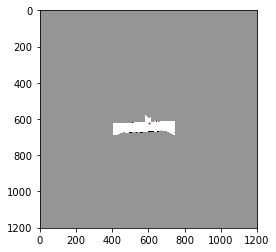

i: 1900
c_array
(100,)
[ 435.  254.    0.    6. -657. -201. -434. -309.  424. -455. -272.  -22.
 -478.  619.  519.  453. -556. -298. -189.  588. -119.  163.  -61. -347.
 -293. -291. -393. -651.  171. -121.  -85. -702. -284.   56. -226.  -10.
 -681. -472.   70. -471. -328. -532. -286. -283.  318. -145.  537. -211.
 -377.   58. -259. -184.  565. -222.  -87. -377.  509. -586.  554.  361.
   59. -350. -172.  379. -344. -183. -676. -311.  115.  612.  563.  533.
 -386. -361.  568.  607.  181.  -57. -195. -223. -289. -309.   82. -232.
 -511.  -80.  588. -495. -279.  -24. -318. -222.  171. -673.   91. -246.
 -464. -134.  300. -123.]
np.max(c_array)
619.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.26652609  0.10262306  0.0400095 ]
particle weights
[  1.22861785e-080   3.03469881e-159   1.48360125e-269   5.98527463e-267
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.05200076e-085   0.00000000e+000   0.00000000e+000   4.13845835e-279
   0.0

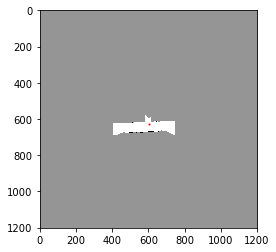

i: 1950
c_array
(100,)
[-328. -506. -605. -332. -382. -248. -142. -365. -494.   48. -210. -538.
 -293. -247. -354. -334. -322. -670. -392. -486. -452. -379. -333. -371.
 -499. -351. -289. -496. -506. -524. -498. -261. -452. -512. -583.  276.
 -301. -509. -504. -447. -528.  260. -549. -473. -346. -568. -460. -574.
 -504. -390. -399. -279.  459. -296. -376.   -9. -555. -292. -372. -541.
 -324. -532. -335. -295. -362. -233. -497. -361. -593. -503. -372. -434.
 -400. -577. -528. -388. -332. -491. -513. -406. -114. -504. -505. -222.
 -475. -379. -357. -343. -408. -494. -372. -585. -369. -442. -678. -440.
 -463. -331. -395. -390.]
np.max(c_array)
459.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.45470138  0.19033767  0.18949778]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   8.99086123e-308   9.75026403e-262   0.00000000e+000
   0.00000000e+000   3.19865896e-179   2.86412262e-291   0.00000000e+000
   0.0

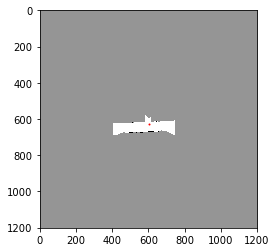

i: 2000
c_array
(100,)
[-492. -371.  301. -308.  344. -403. -362. -700. -291.  -88. -223. -370.
 -266. -254. -177. -223. -315. -336.  -56. -453. -695. -181. -409. -281.
 -305. -390.  347. -703. -290. -179.  143. -582. -362. -248. -704. -402.
  157. -436. -292. -183. -276. -533.  -62.   22. -404. -179. -250. -218.
 -554. -481. -178.   88.  195. -505.  -28. -506.  -53. -459. -180. -235.
 -339.  -18.  255. -555. -265. -303. -274. -280. -291. -378. -484. -211.
 -533. -325.  286. -319. -176. -319. -239. -270.  332.  -49.   -3. -394.
 -638.  -44. -744. -575.   52.  356. -406. -361.  -63. -481.  267. -684.
 -553. -381. -541. -403.]
np.max(c_array)
356.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.59794146  0.24784707  0.28123458]
particle weights
[  0.00000000e+000   1.85291618e-316   1.29941308e-024   4.25018423e-289
   6.14341645e-006   0.00000000e+000   1.50143222e-312   0.00000000e+000
   1.02662999e-281   1.49002575e-193   3.49493189e-252   5.03674200e-316
   7.3

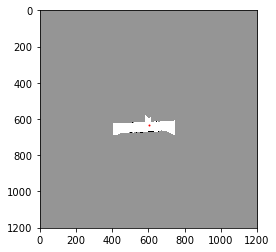

i: 2050
c_array
(100,)
[ 283. -359. -287. -295. -113.  273. -329. -132. -208. -569. -374. -324.
 -173. -753.  288. -408.  -89.  -62.   36. -707. -610.  -33.  352. -121.
 -635. -547. -232. -143. -559. -366. -111.  175. -651. -178.  372. -231.
 -767. -116. -166. -381. -751. -302.  372. -100.   73. -198. -585.   16.
  325. -499. -273. -103.    7.  294. -537. -421. -252. -109. -319. -781.
  -62. -521.  329. -242. -167. -239. -435. -216. -758. -236.   30.  209.
 -443.  360. -328. -784.   65. -769.  158. -179.  295. -309. -760.  -83.
 -239. -461. -354.  117. -192.    9. -180. -185.  381.  -61. -127. -400.
  337. -186. -533. -553.]
np.max(c_array)
381.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.6920335   0.28019588  0.5127964 ]
particle weights
[  2.74810672e-043   4.94065646e-322   7.78357132e-291   2.61109729e-294
   2.87355001e-215   1.24763852e-047   4.47518166e-309   1.60999158e-223
   1.58651061e-256   0.00000000e+000   0.00000000e+000   6.64175848e-307
   2.5

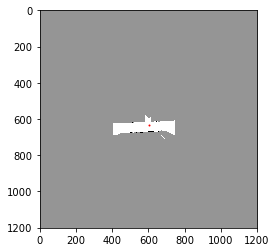

i: 2100
c_array
(100,)
[-235. -506. -329. -143.  436.  -13. -269. -780.  -88. -404.  459. -247.
 -286. -392. -281. -186. -239. -310. -552. -442.  338. -290. -255. -273.
 -520. -250. -562. -477.  -89. -272. -534. -696.  -30. -619. -264. -452.
  295.   21. -375.  462. -160. -346. -184. -396. -341. -624. -539. -144.
 -242.   13. -171. -254.  358. -557. -423. -172. -503.  372. -273. -379.
 -307. -249.  386.  362. -572.  414. -316.  390. -443. -263. -279. -596.
 -291.  175.  248. -567. -374. -242. -239. -333.  131. -268. -274.  336.
 -245. -173. -139.  -43. -428. -405. -158. -335. -165. -394. -130.  -66.
 -252. -371. -368.  280.]
np.max(c_array)
462.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 1.82043379  0.32457902  0.6851755 ]
particle weights
[  1.88644824e-303   0.00000000e+000   0.00000000e+000   1.70112893e-263
   4.86678602e-012   4.88674725e-207   3.23325452e-318   0.00000000e+000
   1.30898218e-239   0.00000000e+000   4.74258732e-002   1.15907386e-308
   0.0

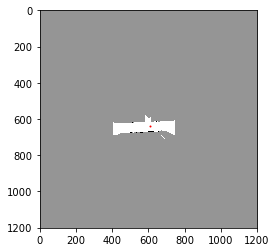

i: 2150
c_array
(100,)
[-575. -486. -337. -422. -365. -582. -357. -387. -371. -133. -500. -321.
  327. -581. -498. -375. -515. -629. -531.  181. -346.  408.  -58. -464.
 -336.  -45.  355. -559. -515. -249. -359.  410. -140. -314. -696. -259.
 -584. -184. -352. -374. -418. -589. -581. -372. -353. -293. -310. -249.
  -41. -245. -536.  -91. -104. -591. -185. -453. -329. -595. -209.   14.
 -320. -327. -736. -651. -556. -285. -387. -161. -374. -306. -371. -185.
 -471.   15. -231. -582. -518.  143. -579. -184. -326. -372. -472. -309.
 -521. -131. -131. -390. -321. -240. -302. -636. -391. -377. -355. -325.
 -526. -303. -582.  190.]
np.max(c_array)
410.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.84596251  0.30934447  0.92197498]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.32730947e-236   0.00000000e+000   2.98963075e-318
   7.9

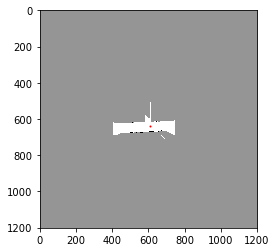

i: 2200
c_array
(100,)
[-276. -375. -266. -351. -352. -300. -377. -343. -353. -252. -504. -588.
 -221. -274. -277. -344. -406. -342. -381. -339. -463. -339. -339. -238.
 -259. -386. -334. -353. -366. -382. -398. -588. -432. -221. -368. -304.
 -341. -225. -373. -309. -220. -381. -362. -366. -242. -346. -391. -348.
 -329. -465. -371. -664. -365. -292. -314. -290. -341. -272. -248. -386.
 -316. -334. -325. -259. -375. -443. -271. -320. -243. -380. -231. -338.
 -396. -211. -347. -300. -333. -274. -265. -346. -288. -381. -342. -269.
 -373. -270. -349. -422. -380. -278. -335. -265. -258. -333. -323. -281.
 -376. -342. -330. -364.]
np.max(c_array)
-211.0
xy_w_scan shape
(2, 1081)
particle states
[ 2.11300946  0.87318777  1.13548532]
particle weights
[  5.89882204e-029   5.96501563e-072   1.29930202e-024   1.58008027e-061
   5.81279048e-062   2.22688469e-039   8.07277079e-073   4.71015291e-058
   2.13840612e-062   1.56254617e-018   5.64447326e-128   1.86589388e-164
   4.53901689e-005   4.35867

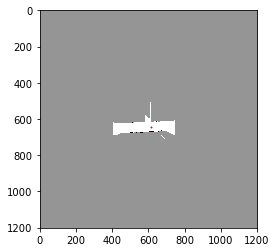

i: 2250
c_array
(100,)
[-260. -306. -286. -241. -198. -289. -228. -112. -566. -217. -178. -213.
 -323. -219. -302. -289. -290. -196. -292. -210. -222. -296. -155. -249.
 -209. -208. -178. -216. -211. -188. -217. -309. -259. -301. -305. -196.
 -311. -418. -215. -186. -206. -226. -302. -211. -230. -213. -307. -210.
 -287. -275. -312. -216. -301. -292. -201. -394. -227. -386. -311. -196.
 -317. -216. -321. -213. -244. -215. -247. -312. -217. -296. -257. -207.
 -303. -282. -341. -349. -185. -199. -200. -224. -241. -209. -295. -221.
 -184. -220. -324. -208. -311. -207. -337. -309. -232. -251. -193. -303.
 -213. -301. -279. -214.]
np.max(c_array)
-112.0
xy_w_scan shape
(2, 1081)
particle states
[ 1.88265903  0.98405429  1.07977893]
particle weights
[  5.30171867e-065   5.58303706e-085   2.70869527e-076   9.46262947e-057
   4.47377931e-038   1.34857996e-077   4.18639400e-051   1.00000000e+000
   6.76558284e-198   2.50656748e-046   2.17052201e-029   1.36853947e-044
   2.31134257e-092   3.39227

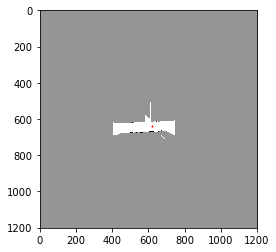

i: 2300
c_array
(100,)
[-296. -121. -534.  235.  120. -225. -146. -203. -188. -302. -549. -288.
 -309. -308. -201. -397. -336. -176. -302. -553. -125. -152. -219. -307.
 -224. -161. -561.   36. -568.  -97.   47. -401. -243. -211. -368. -165.
  -89. -570. -140. -215.  133. -310. -294. -180. -279. -449. -310. -228.
 -309. -162. -313. -395.   33. -561. -565. -286.  184. -140. -562. -572.
 -137. -539. -526. -215. -272. -466. -169.  280.  -93. -235.    8. -568.
 -377.  -77. -733.  -63. -229. -309. -227. -213.  117.   30. -235. -130.
  -66. -379. -273. -310. -125. -249. -106. -363.  -88. -213. -151. -126.
 -469. -163.  -53.   10.]
np.max(c_array)
280.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.93011804  0.62219021  1.09135957]
particle weights
[  7.02066780e-251   7.04551521e-175   0.00000000e+000   2.86251858e-020
   3.25748853e-070   4.80050182e-220   9.78477197e-186   1.72093806e-210
   5.62577643e-204   1.74024956e-253   0.00000000e+000   2.09283157e-247
   1.5

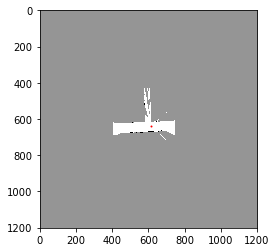

i: 2350
c_array
(100,)
[ 255. -222. -434. -674. -604. -233. -172. -158. -430. -448.  177.  -85.
 -213. -399.   61.  247. -161. -567. -180. -437.  257. -715.   27. -275.
  260. -227. -245. -315. -324. -528. -212.  -67. -293. -572. -233.  253.
 -278. -325.   13.  138.  -77. -171.  -60.  -98. -154.  -98.  172.   -2.
 -261. -381. -271. -268.  260.  -85. -475. -215. -568.  184.  276.  -89.
 -737. -333. -238. -368. -192. -664. -514. -101.  105. -387.  -22.  -75.
   12. -249. -425. -515. -750. -421. -269. -570.  266. -484. -179. -543.
 -262. -198. -367. -186. -361. -757. -312.  -87. -243. -418. -165. -198.
  -15. -384. -273. -701.]
np.max(c_array)
276.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.00474258  0.76008197  1.14172339]
particle weights
[  7.58221444e-010   5.26414926e-217   4.47608198e-309   0.00000000e+000
   0.00000000e+000   8.79202459e-222   2.72930638e-195   3.28227554e-189
   2.44385795e-307   3.72199080e-315   1.01117535e-043   1.65833481e-157
   4.2

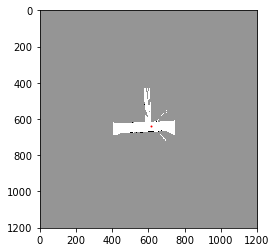

i: 2400
c_array
(100,)
[-492. -371. -245. -183. -118. -191. -228.  -12. -536. -101. -600.  -91.
 -753. -561. -429.  -50. -517. -244.  228.   69. -567. -315. -342. -149.
 -226.  237. -437. -259. -344. -420. -288.  318. -443. -551. -356.  110.
 -130. -545. -427. -265. -353. -292.  274.  250. -426. -236. -250. -576.
 -472.  297. -265. -406. -723.  296. -325.  -80. -732. -349. -433. -153.
 -325. -522.  311. -282. -244. -164. -250. -320. -433. -241. -234. -427.
 -232. -240. -405. -291. -255. -322. -466. -168. -338.  303. -359. -246.
   37. -231. -536.  -53. -488. -439. -228. -435.  -98. -344. -528. -439.
 -243. -264. -232. -534.]
np.max(c_array)
318.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.0879826   0.86631164  1.09310765]
particle weights
[  0.00000000e+000   5.89801660e-300   3.10320674e-245   2.61859653e-218
   4.43823110e-190   8.78441274e-222   7.49578123e-238   4.81310121e-144
   0.00000000e+000   1.07205262e-182   0.00000000e+000   2.36135305e-178
   0.0

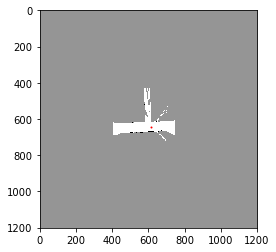

i: 2450
c_array
(100,)
[-232.  242.  -88. -572. -350. -519. -288. -635. -101.   59. -316. -437.
  169.  308. -394. -254. -289. -166. -476. -708.  -58. -295. -427.  -77.
 -394.  267.  197.  -80. -360. -254. -229. -387. -462. -464. -426. -510.
 -119. -490. -402. -261. -477.   97. -219. -484. -263. -260. -483. -143.
 -243. -578.   69. -355. -477. -707. -318. -582.  356.  -55.  312.  238.
  204.  217. -377.  -48. -314.   69.   12. -687.  323.   -6. -467. -150.
  -28. -459.  -69. -729. -424. -469. -710. -581. -350. -298.  191.  219.
 -263.  284. -438.  321. -207. -318. -425. -476. -497. -499. -390. -176.
 -474.  114. -321. -124.]
np.max(c_array)
356.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.14189873  0.98812452  1.18550316]
particle weights
[  4.31364738e-256   3.09335001e-050   1.49021879e-193   0.00000000e+000
   2.44396947e-307   0.00000000e+000   2.06230861e-280   0.00000000e+000
   3.36838535e-199   1.03404366e-129   1.42596269e-292   0.00000000e+000
   6.1

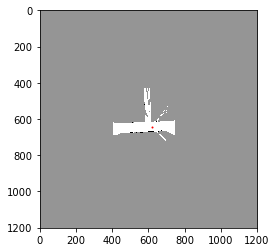

i: 2500
c_array
(100,)
[-257. -251. -314.   -7. -535. -116. -293. -258. -368. -279. -409. -162.
 -178. -219. -359. -261. -550. -314. -345.  -55. -702.  234. -367. -393.
 -389. -145. -125.  175. -236.  149. -335. -296.  114.   83. -511. -562.
 -387. -380.  -67. -114. -404. -281. -492. -453. -256.  -48. -565. -309.
 -124.   62.  120. -524. -464.  232. -228. -370. -513.  107. -483. -298.
 -497. -159. -452. -467. -286. -352. -157. -248. -315. -555.   86. -339.
 -342. -498. -479. -394. -335.  268. -427.  298. -268. -434. -297. -201.
 -425.  342. -351. -291. -200. -112. -601.   66. -387. -458. -105. -564.
  328.  181. -174. -235.]
np.max(c_array)
342.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.17227366  1.13897275  1.28592449]
particle weights
[  7.20451880e-261   2.90651033e-258   1.26712515e-285   2.69914027e-152
   0.00000000e+000   1.23915869e-199   1.67110458e-276   2.65039435e-261
   4.47628250e-309   2.00967753e-270   0.00000000e+000   1.30491060e-219
   1.4

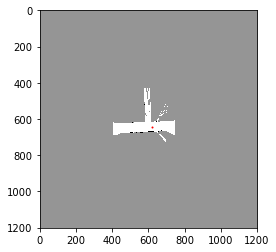

i: 2550
c_array
(100,)
[-373. -372.  -49. -255. -516.  -44. -283. -409. -626.  216.  257. -232.
 -412. -409. -280. -544. -453. -126. -527.  258.  242.    0. -532.  406.
 -448. -720.  100.  170. -135.   90. -543. -191. -358. -365. -279. -220.
 -406. -335. -295. -355. -626. -420. -462. -611. -693. -334. -453.  473.
 -280.  -65. -305.  213. -146. -424. -429. -434. -560. -569. -373. -106.
  440.  184. -412. -146. -526.  -72. -399.  246. -598. -456.   61. -431.
 -435.  171. -207. -531. -371. -468. -458. -254. -349. -181. -416. -285.
 -466. -442.  292. -249. -432. -495. -639.   24. -118.  127. -563. -210.
 -371. -637. -502. -563.]
np.max(c_array)
473.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.16775115  1.25783819  1.5044075 ]
particle weights
[  0.00000000e+000   0.00000000e+000   1.98737786e-227   6.81736481e-317
   0.00000000e+000   2.94953026e-225   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.43398642e-112   1.55737037e-094   6.64339780e-307
   0.0

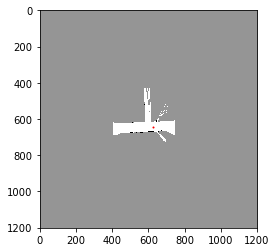

i: 2600
c_array
(100,)
[ 320. -170. -317. -355. -411. -306. -268. -314.  186. -334.  286. -163.
 -358. -338. -266. -438. -573. -555. -452. -262. -481. -140.   46. -569.
 -428. -623. -631.  259. -314. -163.  -23. -521. -424. -377. -336. -606.
 -458.  330. -386.  129. -526. -526. -101. -215.  202. -448. -501. -292.
 -384.  -51. -469. -219. -434. -317. -550. -654. -212. -313. -370. -464.
 -143. -525. -457. -163. -408. -438. -286. -493. -388. -277. -327. -178.
  172.  387. -545. -393. -633. -451. -324. -451. -433.   65. -647. -351.
 -395. -510. -433. -485.   -5. -374.  368. -295. -252.  155. -373. -411.
 -432. -500. -395. -564.]
np.max(c_array)
387.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.15457984  1.37395729  1.56407356]
particle weights
[  7.98490420e-030   1.25306494e-242   1.80586274e-306   0.00000000e+000
   0.00000000e+000   1.08124482e-301   3.44440611e-285   3.62717228e-305
   5.09107078e-088   7.47615927e-314   1.36853946e-044   1.37415256e-239
   0.0

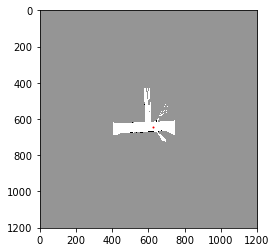

i: 2650
c_array
(100,)
[ -49.  -18. -418. -162. -445.  496.  326. -282.  237. -382. -509. -408.
  302. -262. -465. -499. -229. -570. -349.  212. -288.  419.  370. -367.
 -507. -201. -586. -300. -118. -574. -481. -419. -230. -338. -335. -377.
 -383. -167. -108. -417. -131. -379.   66. -351. -272.  157. -364.  307.
 -351. -262.  -93. -518.  -54.   36.  463. -472. -492. -508. -342. -305.
 -213. -443. -317.  445. -300.  202. -109. -353. -518.  -35. -324. -185.
   58.  100. -354. -367. -143. -213. -301. -435. -256.  329.  320. -325.
 -336. -217. -395.  468.  -13. -356. -428. -270. -306. -350. -520. -360.
 -358. -315. -391. -252.]
np.max(c_array)
496.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[ 2.15734884  1.47557736  1.61238308]
particle weights
[  2.03942323e-237   5.92428989e-224   0.00000000e+000   1.71486883e-286
   0.00000000e+000   1.00000000e+000   1.47889751e-074   0.00000000e+000
   3.29404242e-113   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.5

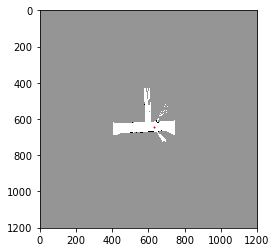

i: 2700
c_array
(100,)
[-159. -260. -410. -156. -608. -487. -192. -445. -315. -277.  213. -371.
  -99. -179. -201. -276. -445. -434. -425.  480.  428. -209. -518.  -48.
 -234. -341. -288. -225.  404.  419. -477. -272. -361. -389. -278. -267.
 -362. -134. -515. -196. -624.  227. -276. -229.  269. -478. -429. -417.
 -470. -323. -412. -425. -302. -348. -245. -300. -600. -293. -359.  153.
 -255. -185.  345. -431. -138. -361. -476. -441. -411. -340. -320. -383.
  -48. -475. -550. -162. -462. -263. -366. -433. -420. -147. -238. -457.
   68. -239. -309.  205. -217.   39. -447.  422. -455. -255. -329. -335.
 -404. -336. -377.  431.]
np.max(c_array)
480.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.16608959  1.64115683  1.59810706]
particle weights
[  3.06073735e-278   4.94065646e-322   0.00000000e+000   6.14765531e-277
   0.00000000e+000   0.00000000e+000   1.42596269e-292   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.10502813e-116   0.00000000e+000
   3.4

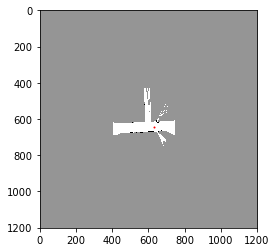

i: 2750
c_array
(100,)
[ 238.  315.  -56.  239. -298. -412. -245.  -94. -411.   -2. -332.  442.
 -368. -292. -159. -376.  383. -500. -411. -528. -324. -232. -588. -241.
  273.  164.  408. -332. -312. -567. -501. -333.  319.  371. -383.  522.
 -452. -602. -455.  471.  118. -373.  219. -614. -412.  305. -149.  475.
 -446. -580.   18. -382. -163. -328. -248.   76. -305. -531.  212. -481.
 -447. -540. -269. -468.  286. -422. -432. -449.  -25. -361. -210. -132.
  -85. -314. -132. -497. -459. -331. -254. -285.  310. -328. -326.  265.
 -308.  315. -460. -436. -570.  -29. -338.  561.  178.  535.  -44. -330.
 -246. -271. -514. -164.]
np.max(c_array)
561.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.12414651  1.73448724  1.6627607 ]
particle weights
[  5.28302110e-141   1.45732848e-107   1.09724767e-268   1.43607403e-140
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.44440613e-285
   0.00000000e+000   3.10603745e-245   0.00000000e+000   2.08428284e-052
   0.0

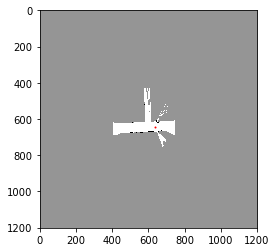

i: 2800
c_array
(100,)
[-489. -472. -591.  -16. -548.  388. -375. -208. -595. -583.  291. -157.
 -606. -449. -576. -430. -158. -283. -456.   55. -318. -553. -336. -503.
 -295. -320. -419.  461.  -92. -158.  374. -298. -579.  -81. -407. -411.
 -466.  -57. -412. -462.   10. -519.   87. -604. -574.  -21.  107. -311.
 -491. -446. -114. -464. -145. -255. -304. -444. -185. -275. -576. -335.
 -318. -446. -440. -633.  235.  177. -308. -309. -540. -134. -271. -595.
 -346. -100. -424. -390. -174. -396. -408. -425. -233. -456. -507. -299.
 -611. -471. -256. -384. -460.  -21. -599. -503. -158. -113.  -48. -257.
   42. -292.  -94. -446.]
np.max(c_array)
461.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.08302816  1.88883102  1.74603109]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.94275967e-208
   0.00000000e+000   1.97925988e-032   0.00000000e+000   2.86412262e-291
   0.00000000e+000   0.00000000e+000   1.47889751e-074   4.03654858e-269
   0.0

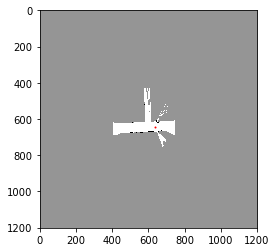

i: 2850
c_array
(100,)
[-405. -432. -460. -253. -158. -598. -378. -420. -605. -373. -576.  336.
 -277. -616. -319.  249. -414.  200. -288. -170. -218. -358. -306. -111.
 -514. -271. -527. -350.   -9. -545.  143. -189.  226. -235. -423.  196.
  278.  343.   85.  -44.  483.  271. -364. -196. -583.   25.  163. -518.
   36. -529. -413. -307. -127. -102.  424. -347. -213. -424.  473.  361.
 -585. -189. -216.  448.  -77. -220. -225. -374. -413. -119.  434.  358.
  168. -333. -149. -318. -429.  -65. -338. -615. -452. -270.    4. -421.
 -421.  117.    4. -317. -302.  -76. -391. -104. -229. -230.  -53. -278.
 -398.  236. -266. -280.]
np.max(c_array)
483.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.08032741  2.00972658  1.75204887]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.27270197e-320
   4.14206952e-279   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.44109113e-064
   0.0

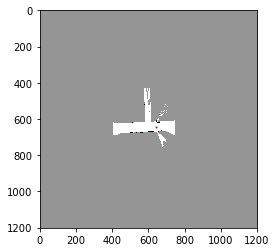

i: 2900
c_array
(100,)
[-328. -363. -282. -462.  115. -518. -192. -361.  465. -265.  -12. -490.
  156. -259. -540.  512. -502. -218. -350. -298. -554. -453. -330. -263.
 -275. -116. -562. -432. -376. -399. -558. -412. -133. -290. -530. -572.
  -95. -354. -383.  102.  215. -328.  222.  -69.  202.  160. -322. -391.
 -518.  502. -304. -272. -383. -508.  531. -345.  503. -263.  507. -335.
 -377.  232. -450. -468. -656. -532. -582. -226. -148. -140. -248. -413.
 -334.  222. -251. -195.  340. -290.  108. -226.  133.   96. -429. -135.
  446. -323. -443.  -87. -156. -332. -333. -504. -484. -275. -372. -329.
 -548.  505. -289.  101.]
np.max(c_array)
531.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.04534896  2.19070415  1.69075388]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.15523944e-181   0.00000000e+000   1.01178814e-314   0.00000000e+000
   2.17052200e-029   0.00000000e+000   1.50694126e-236   0.00000000e+000
   1.3

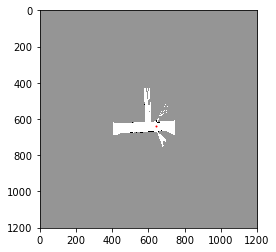

i: 2950
c_array
(100,)
[-255. -383. -516. -370. -484.  113.   28. -270. -311.  230.  312. -680.
 -288.  343. -631. -529. -381. -308. -484. -273. -393. -420. -462.  -57.
 -581. -553. -318. -555.  406. -384.  363. -587. -270.   -2. -543. -583.
 -418. -498. -659.  558. -458. -429.  370. -132. -267. -226. -276. -325.
 -353. -466. -384. -429.  137. -321.  465. -114. -407.   21.  -24. -273.
  -77. -574.   64.   67.   10. -257.  244. -276. -336. -445. -666. -477.
 -294.  538.  474. -544. -229. -217. -412. -373. -177. -443. -478. -120.
 -318.  495.  127.  302. -322. -263. -313.  152. -231. -388. -266. -383.
 -326.  161. -425.   41.]
np.max(c_array)
558.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.04680854  2.33805754  1.74263821]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.48220854e-194   6.66690997e-231   0.00000000e+000
   0.00000000e+000   3.55967161e-143   1.45732848e-107   0.00000000e+000
   0.0

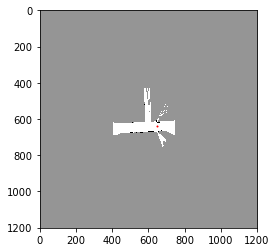

i: 3000
c_array
(100,)
[-416. -297. -379. -591. -320. -510.  252. -217. -324. -223.   35. -144.
 -234. -476. -230. -471. -501.  -32. -412. -350. -299. -298. -256. -451.
  -45.  564.  254. -330.  204. -401. -425. -241. -278. -149.   73.   37.
  -14.  434. -105. -447. -588.  -14. -344.  222. -213.  226. -298. -298.
 -239. -416. -393.  406.  -13. -581.  245. -394. -122. -123. -220. -241.
 -444. -318.  -69. -298. -345. -429. -411. -441.  596. -405. -268. -212.
  573. -584. -386.  -43. -238. -246. -102.  -79. -334. -561. -506. -175.
 -318. -232.   43. -232. -372. -363.  551. -539.  -74.   22. -111.  599.
  -66. -218. -322. -318.]
np.max(c_array)
599.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.96909697  2.4322038   1.7019768 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.89982484e-151   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.08845628e-245   0.00000000e+000
   0.0

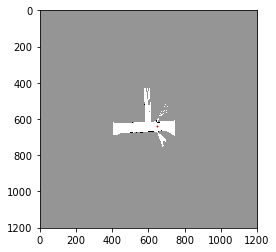

i: 3050
c_array
(100,)
[-305. -540. -597. -381.  118. -408.  162. -278. -415. -385. -397. -255.
   71. -338.  -57. -597.  475.  394.  464. -348. -143. -473. -402. -408.
 -491.  -30.  322. -577. -496.  204. -178. -289.   42. -375. -419. -253.
 -280. -336. -270. -137. -387.  352. -414.  306. -384. -295.  399.    8.
  122. -357. -288. -280. -243. -425. -405. -350.  201. -349.  142.  426.
 -264.  366. -418.  -67. -398.  143. -452.    0. -357.  415. -481. -674.
 -516. -413.   93. -319.  -94.  -38.   70. -125. -468. -418. -507. -386.
 -579. -356. -374. -613.  443.  398. -594. -658.  214. -322.  263. -614.
 -335. -301. -360. -468.]
np.max(c_array)
475.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.94089179  2.59603477  1.61118487]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   9.05446318e-156   0.00000000e+000   1.16364340e-136   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   9.22602871e-318
   3.5

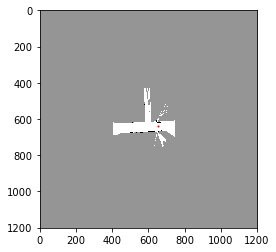

i: 3100
c_array
(100,)
[-266. -287. -318. -456.  572.  -89. -541. -412.  -64. -525. -273. -278.
 -272. -264.  -55. -339.  601. -412.  155.  -10. -249.   82. -280. -470.
 -674. -270. -447.  -21. -388.   68. -270. -413. -280.   84. -490. -573.
 -281. -322. -436.   83. -594.   20. -400.  485. -298. -222. -334. -627.
  579. -302. -508.  -11.  523. -501. -455. -425. -103. -253. -414. -264.
  147.  287. -413. -532. -477. -230. -245. -433. -646.  -44. -622. -128.
  519. -451.  289. -623. -165. -472.  -27. -332. -246. -118. -162. -368.
  410.  -91. -255. -317. -557. -124.  306. -182. -393. -228.  602. -604.
 -446. -383.  -66. -549.]
np.max(c_array)
602.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.98351277  2.70184996  1.51763916]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.84097055e-014   5.84070380e-301   0.00000000e+000   0.00000000e+000
   4.20559289e-290   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

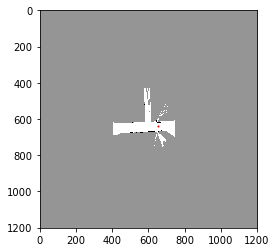

i: 3150
c_array
(100,)
[-184. -535. -600. -165.  -17. -402. -330. -430. -307.  149. -572. -421.
 -379. -426. -451.  556. -644. -407. -287. -417. -671.  550. -290. -364.
 -312. -370. -279. -550. -267. -423. -398.   39. -230.  -93. -464.  187.
   23. -275. -396. -365.  -99. -496.  -82. -227. -421. -654. -202. -407.
 -512. -476.   65. -367. -626. -375.  122. -264.  437. -330.  246. -627.
 -410. -172. -323. -178.  -79. -654. -514. -312.  115.  270. -336. -247.
 -407. -397. -422. -635.  -74. -208. -131. -376. -525. -550. -490. -481.
 -176.  522. -170. -354. -111. -224. -171. -342. -573. -352. -590. -134.
 -365. -500. -619. -314.]
np.max(c_array)
556.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.00668645  2.83406665  1.46038759]
particle weights
[  4.94065646e-322   0.00000000e+000   0.00000000e+000   7.45767358e-314
   1.40665208e-249   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.74209041e-177   0.00000000e+000   0.00000000e+000
   0.0

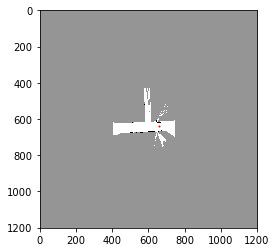

i: 3200
c_array
(100,)
[-577. -147. -343. -521. -167. -322. -288. -297. -177. -395. -425. -273.
 -434. -417. -274. -626.  -39. -496. -540. -293. -458. -489. -244. -178.
 -500. -623. -383. -243. -402. -525. -141. -351.   -5. -210.  455. -443.
 -372.   96. -278. -497. -161. -162. -499. -402. -426. -442. -306. -240.
 -341. -399. -254. -310. -453.  -72. -448. -341. -376. -232. -382. -265.
 -519.  317. -523.  243. -599. -599. -362. -351. -318.   65. -184. -517.
  -64. -467. -617. -264. -510. -158. -552. -505. -231.  -16. -461. -637.
 -654. -257. -381. -444. -312. -460. -382. -380. -412. -354. -163. -238.
  281. -529. -256. -414.]
np.max(c_array)
455.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 1.97111068  2.96962093  1.41335488]
particle weights
[  0.00000000e+000   3.58692168e-262   0.00000000e+000   0.00000000e+000
   7.39319662e-271   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.35650607e-275   0.00000000e+000   0.00000000e+000   6.81736481e-317
   0.0

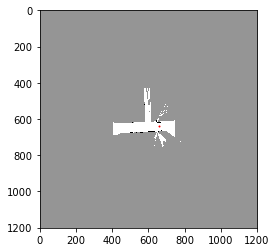

i: 3250
c_array
(100,)
[ 557. -448. -667. -628.  623. -467. -475. -469. -208. -255.  490. -282.
 -317. -486. -409. -538.  -90. -675. -464.  555. -431. -395. -412. -364.
 -288. -657. -254. -366. -581. -498. -588. -348. -660. -139. -245. -628.
  230. -660.  453. -455. -634. -253. -645.  -96. -457. -360. -528.   33.
 -264. -655. -363. -506. -371. -338.  261. -301. -426. -654. -442.   35.
 -307. -327. -293.  165. -140. -285. -282. -437. -302.  -92.  -19.  108.
   40. -315. -387. -251. -244. -357. -354. -162. -490.  550. -461. -297.
 -258. -403.  -62. -286. -635. -487. -448. -479. -481. -365.  -48. -437.
 -424. -398. -145. -508.]
np.max(c_array)
623.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.00499848  3.09274446  1.34150983]
particle weights
[  2.17052201e-029   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.73314104e-058   0.00000000e+000
   0.0

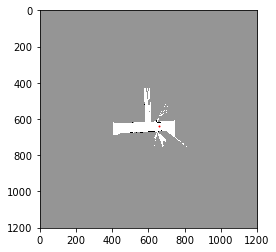

i: 3300
c_array
(100,)
[-417. -457. -331.  279. -405.  -69. -413. -432. -120.  -53. -158. -186.
 -345.   28. -253.  -29. -140.  540. -299.  594. -595. -325. -181. -224.
  -52. -501.  559. -286. -169. -389.  569.  372.  345. -236. -406. -401.
 -315. -384.  -22.  572.  -70. -251.  122. -440. -146. -670. -431.  391.
  231.  155. -131. -672.  -73. -486. -417.  396. -114.  355. -377. -328.
 -380.   83. -408. -181. -111. -237.  159.  103. -256. -369. -521. -495.
 -662. -452. -351. -235. -408.  412. -308. -445. -376. -394. -411. -367.
 -270. -491. -191.   34. -405. -355.  -58.  170. -247. -249. -284. -390.
 -325. -504. -604. -377.]
np.max(c_array)
594.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[ 2.04041681  3.20012845  1.25710922]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.57484639e-137
   0.00000000e+000   1.15546953e-288   0.00000000e+000   0.00000000e+000
   8.19860420e-311   1.02676300e-281   0.00000000e+000   0.00000000e+000
   0.0

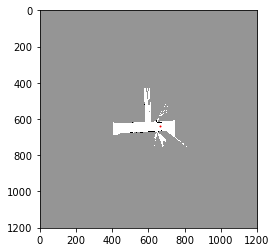

i: 3350
c_array
(100,)
[-685. -251. -198.   64. -683. -332. -505. -278.  -33.  400. -110.  252.
   36. -295. -427. -178. -251. -357. -185.  -90. -685. -460. -537.  103.
 -674. -503. -513. -412. -214.   87. -512.   35. -209. -189. -314. -585.
 -460. -342. -364.  623. -335. -329. -384. -477.  569. -677. -390.  443.
 -350.   -9. -433.  500. -341. -579. -457. -223. -215. -572. -403. -421.
 -461. -249. -121.   -3. -106. -390. -511. -572.  -76. -676.   11. -325.
 -290. -188. -294. -226. -237. -205. -354. -148. -329. -620. -676. -663.
 -458. -395. -520.  563.  -61. -353.  565. -268. -274. -335.  -50.  -87.
 -459. -378. -283. -265.]
np.max(c_array)
623.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 2.12499944  3.29387072  1.17331432]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.69583899e-243
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.26712620e-285   1.42013796e-097   4.59481051e-319   7.52917192e-162
   1.1

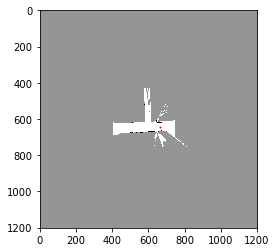

i: 3400
c_array
(100,)
[ -64. -229. -203. -164.   -6. -393.  349. -345.  394. -676. -128. -678.
 -216. -359. -541.  284. -181. -300. -677. -196.  604. -177. -116. -623.
 -328.   97. -307. -156.  -98. -430. -629. -625. -196. -449. -364. -510.
 -429. -478. -408. -512. -341.  597. -243. -440.  380. -324.  543. -159.
 -157. -420. -488. -171. -308. -240. -155.  696.  441. -203. -451. -313.
 -617. -118. -352. -414. -256. -245. -386.  -64. -214. -497. -398. -226.
 -412. -406. -254. -185. -188. -310. -610. -325.  239.  179.  222. -452.
  -66. -250. -534. -153. -547. -357. -206. -315.  183. -458.  -34. -487.
 -161. -372. -459.   18.]
np.max(c_array)
696.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.11101459  3.34485092  1.19842757]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.33436212e-305   0.00000000e+000   1.99441155e-151   0.00000000e+000
   6.96733135e-132   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

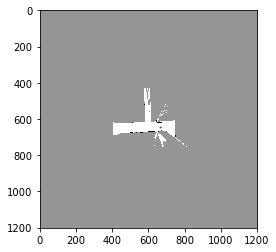

i: 3450
c_array
(100,)
[-330.  640. -241.  439.  422. -114. -316. -344. -379. -118. -328.  -90.
  -37. -382. -593.  185. -380.  483.  137.  -66.  630. -310. -327. -289.
 -471.  -16. -321. -352.  387. -210.  -44.  260. -391.  596.  -76.  185.
 -357. -103.  300.  300. -183.  150. -562. -687. -365.  -71.   36. -167.
 -332. -335. -495. -547. -448. -451. -353. -162. -196. -424. -529.  704.
  -26.  610.  231. -323. -432. -626. -496. -276.  123.  -35. -144.   67.
   49.  154.  -23.  354. -107.  122.  529. -603. -140. -690. -701. -145.
 -567. -326. -447. -706.   53. -566. -388. -165. -386.  608.   65.  380.
  232. -194. -164.  300.]
np.max(c_array)
704.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 2.191539    3.46300613  1.10536167]
particle weights
[  0.00000000e+000   1.60381089e-028   0.00000000e+000   8.16511481e-116
   3.38030668e-123   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

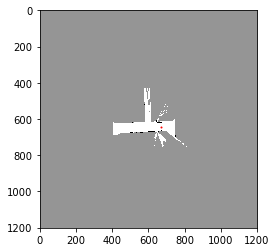

i: 3500
c_array
(100,)
[-328. -347. -281.  571. -679. -446. -307.  114.  479. -320. -530. -124.
 -377. -268. -379. -114. -455. -254. -406. -212. -101. -450. -354.  131.
  666.  150. -364. -596. -315. -266. -342. -396. -202.  699. -500. -158.
   25. -225. -464. -175. -301. -444. -404.  535. -489.  -60. -283.  484.
  313. -255.  145. -471. -221.  289. -336.  722. -116.   71. -326.  187.
   34. -288.  -89. -447. -248. -522. -687. -155. -153. -583.  -63. -100.
 -260. -466. -214. -121.   79.  398. -301.   21. -209.  544. -468.  -46.
  407. -332. -429.  -86.  479. -397.  336.  144. -276. -406. -596. -505.
 -586. -117. -436. -405.]
np.max(c_array)
722.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 2.2640976   3.58128787  1.18138811]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.63957030e-066
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.89108993e-265
   2.92712250e-106   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

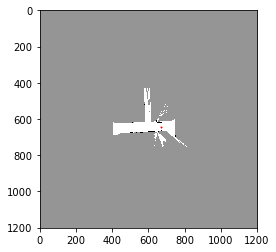

i: 3550
c_array
(100,)
[-201. -592.  -73. -191. -118.  -35.  302.   81. -318. -185. -326.   36.
 -142. -258. -128. -225.  349. -345. -643.  115. -319. -235. -155. -257.
  515. -305.  -89.  460.  619. -102.  120.  -71.   22. -316.  632. -386.
  590. -291. -140.  289.  566. -225.  332. -134.  -86. -494. -323.   78.
 -551. -671. -430.    8. -377.  188.   54. -491.  522. -502. -156. -465.
  466. -132.  -45.  352. -206. -308. -295. -326. -127. -275.  -41. -255.
 -365.  183.   59. -661. -192.  -46. -306. -315. -177.   68. -120. -179.
 -467.   54. -396.  399. -441. -333. -201. -126.   83.  194.  202.  -99.
 -298. -463. -653. -196.]
np.max(c_array)
632.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.22702019  3.71843003  1.22326161]
particle weights
[  0.00000000e+000   0.00000000e+000   6.64338278e-307   0.00000000e+000
   0.00000000e+000   2.11631149e-290   4.81748078e-144   5.05521335e-240
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.44706422e-259
   0.0

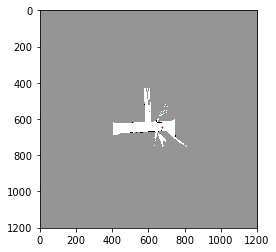

i: 3600
c_array
(100,)
[ 760. -150.  454.  -67. -336.  128. -510.  246. -163.  631. -407. -283.
  -43.  102. -100. -353. -176. -198.  612.   69. -377.  -28. -276.  196.
 -405. -245. -215. -534.   84. -371. -162.  661. -287. -132.  -98. -159.
 -351. -253. -184.  442.  -79.  769. -383. -568. -386.  266.  421. -669.
 -240.  340.  -68. -347.  309. -388.  151. -519.  414.  385.  220. -159.
 -651. -172. -102. -145.  168. -252.  150.   -8.  597.  782. -111. -257.
  -23. -359. -409.  402.  520. -327.   66.  123. -580. -156.  583.  433.
 -104. -230. -158. -167. -293.  245. -331. -661.  172. -517. -466. -164.
 -120.  142.  103.  174.]
np.max(c_array)
782.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.25666093  3.84197457  1.31235766]
particle weights
[  2.78946179e-010   0.00000000e+000   3.55966357e-143   0.00000000e+000
   0.00000000e+000   9.36284543e-285   0.00000000e+000   1.65255803e-233
   0.00000000e+000   2.63956433e-066   0.00000000e+000   0.00000000e+000
   0.0

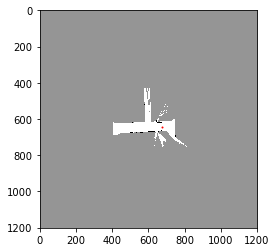

i: 3650
c_array
(100,)
[  43.  118. -214.  455.   55. -267.  294.  449. -339. -115.  133. -155.
 -308. -419.  -43.   -7.  -19.  -61.    0. -705.  -28. -209. -141.  150.
   27. -104. -252. -136. -252. -412. -326.  -28.   11.  -80. -429. -165.
 -117. -295. -296. -119.   37. -324.  156.  155.  131.  593.  194. -262.
 -359.  277. -641.  -79.  427.    6. -389. -615.  -81.   24. -478. -160.
  376.   89. -703.  738.  237. -102.  422. -375. -517. -263.  134. -329.
   47. -241.  196.  180. -126. -289. -641. -250. -115.  628.  -48.  100.
  554.  529. -103. -338.   42.  -85.  113.  276.  -87.   48.  751.  397.
  -85.  -49. -698.  330.]
np.max(c_array)
751.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.31778003  3.93900661  1.42132695]
particle weights
[  3.30754553e-308   1.23478679e-275   0.00000000e+000   2.81081573e-129
   5.38318882e-303   0.00000000e+000   3.36837774e-199   6.96731560e-132
   0.00000000e+000   0.00000000e+000   4.03653946e-269   0.00000000e+000
   0.0

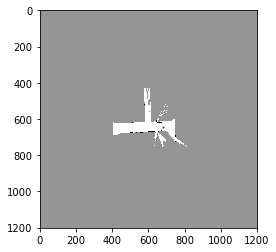

i: 3700
c_array
(100,)
[ -71. -285. -316.  -49.  -29. -175. -341.  136.  335.  668.   22. -649.
  163.  -65.  571. -589.  109. -389. -176.  -66.  338. -648. -307. -387.
 -340.  -48.  398. -200.  -70.  -71.  161. -606.  385. -249. -102. -355.
 -330. -614.  -82. -641. -259. -689.  608. -458. -337.  233. -239.  -72.
 -311. -647.  407.  -62.  -87. -343. -219.   54. -466. -545. -250.  -42.
 -414. -363.  -15.  -75. -357. -578. -485. -252. -250. -194.  685. -287.
 -140.  185.  148. -622. -249. -120.  -40. -627. -131. -265.  -88.  -93.
  -31.  223. -171. -277. -177.  -97. -281. -164. -187. -169.  -76. -153.
 -138. -271. -621. -313.]
np.max(c_array)
685.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.32906271  4.12020428  1.41746918]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.68970451e-319
   8.19860387e-311   0.00000000e+000   0.00000000e+000   3.73533380e-239
   9.92958999e-153   4.13993755e-008   1.15546948e-288   0.00000000e+000
   1.9

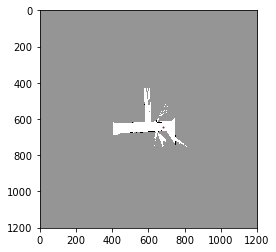

i: 3750
c_array
(100,)
[ -25. -145. -499.    2. -217.  -81. -665.  338. -537.  -17.  531. -276.
  702. -604.  678.  -35. -467.  -38. -296. -359.  -70.  618.   77.  -13.
 -225. -542.  567. -216. -124. -343.  553. -271. -667. -632.  242. -440.
 -108. -280.  -25. -132.  434.   33. -343.  -48.  265. -214. -580. -447.
  699.   46. -162. -214.    6. -342. -324. -308. -681.  286. -160. -262.
 -603. -248. -241. -234.   46. -272. -613.  712.  741.  293. -229.  591.
   43.  640.   -4. -288. -687. -433. -105.  165. -213. -344. -297.  -15.
   87.  590. -286. -350. -309.  698.  136.  168.  657. -374.  388.   43.
 -641.  -42. -706.   44.]
np.max(c_array)
741.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.34983689  4.24288018  1.43748659]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   9.88131292e-322
   0.00000000e+000   0.00000000e+000   0.00000000e+000   9.53506796e-176
   0.00000000e+000   0.00000000e+000   6.28288051e-092   0.00000000e+000
   1.1

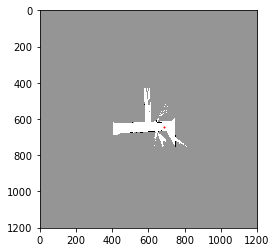

i: 3800
c_array
(100,)
[-407. -327. -441.  249. -449.  216. -352. -282.   -8. -242.  -40.   33.
   74.  -33. -245.   65. -427. -431. -288. -400. -361. -681. -226.   19.
 -360.   51. -713.  -55. -146.  185. -219.  112.    4. -451. -217.  -34.
 -208. -331. -393. -270. -231.   81.  226. -631. -695.  -31. -351. -202.
 -133. -534.   32. -227. -206. -678.  -64. -349. -421.   -8. -570. -438.
 -397. -572. -310. -166. -355. -277. -269.  339. -345. -185.   29. -368.
 -299.  549. -326. -434. -340. -180. -284. -543. -249. -132. -324. -338.
   -8. -711.  345. -641.  -42. -108. -339. -415. -131. -557. -129. -450.
  346. -641. -683.   57.]
np.max(c_array)
549.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.33605855  4.38007957  1.48544611]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   5.14820022e-131
   0.00000000e+000   2.39848787e-145   0.00000000e+000   0.00000000e+000
   1.25306494e-242   0.00000000e+000   1.58690219e-256   8.01765451e-225
   5.1

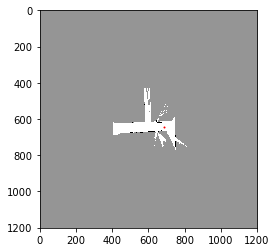

i: 3850
c_array
(100,)
[-470.  321.  307. -204.   24. -467. -183. -341.   15.  -31.   17.   77.
 -420. -319.   -8.  347.  -63. -225.  114.  728.  217. -495.   24.   36.
 -251. -166.   42. -443.   37. -325.  100. -174. -139.   85.  215. -366.
  501. -446. -604. -498. -164. -280. -114. -321. -272. -215.  303. -341.
  255. -300.  -67. -237.  383. -356.  386. -632. -299. -419.  696. -500.
 -648. -333. -562.  -91.  -26.   20. -286.  364.  -66.  472.  579.  418.
  -55.  -85.  538. -663. -251. -328. -359. -661. -256. -439. -342. -636.
   37. -267. -329. -103. -158.   70. -338. -632. -268.  423. -377. -627.
  449. -269.  635. -117.]
np.max(c_array)
728.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.32239396  4.5215364   1.35373918]
particle weights
[  0.00000000e+000   1.74640862e-177   1.45218892e-183   0.00000000e+000
   1.80586275e-306   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.22861168e-310   0.00000000e+000   1.64673368e-309   1.88058203e-283
   0.0

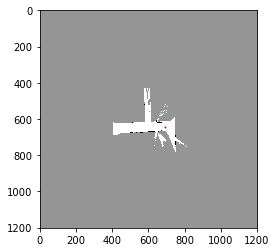

i: 3900
c_array
(100,)
[-631. -544.   32. -656. -157. -167.  -55. -239.   69. -527.  354.   35.
 -309.  -56.  -59.  -75. -532.  144. -436.   70. -353.   34.  506.  152.
 -477. -661. -545. -692. -345.  343.  396.   92. -610. -291. -166.  101.
 -282. -347. -198. -243.  204. -549.  602.   97.  -46. -233. -232. -293.
 -123. -387.  294.  641.  499.  460. -214.   82.  125. -240.  -85.  229.
 -654. -226.  704.  -68.  176.  224. -490. -105. -221. -225.  189. -336.
 -371. -236. -244. -157. -590. -478. -175.   23. -550.  180. -167. -652.
 -446.  -80. -270. -568. -332.  246.  253. -673. -305. -153.  -25. -351.
  544. -559.  377. -163.]
np.max(c_array)
704.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.37426963  4.63614174  1.2447843 ]
particle weights
[  0.00000000e+000   0.00000000e+000   1.42596269e-292   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.67110597e-276   0.00000000e+000   9.92959040e-153   2.86412262e-291
   0.0

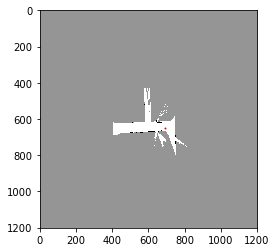

i: 3950
c_array
(100,)
[ 278. -382. -221. -380. -140. -342. -265. -164. -322. -498. -348. -148.
 -363. -253.  125. -502. -363.  -18.  223.  712. -597. -671.  -60. -209.
 -228. -274.  375. -212. -104. -490. -176. -670. -211. -352. -231. -423.
 -463.  351. -167. -307. -590. -100. -309.   -5. -621. -436. -490. -355.
  623.    0. -207. -255.  266. -369. -184. -283. -356.  -96. -427. -642.
 -372. -697.  387. -573. -435. -336. -576. -333.  225. -719. -163. -690.
  144. -356.  630. -290. -276. -284. -160. -269.  160. -449. -265. -401.
   89. -337. -128. -152. -479. -414.  117. -346. -122. -252. -660.   94.
 -566. -419.   21. -318.]
np.max(c_array)
712.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.44749799  4.73650382  1.15774907]
particle weights
[  3.28242532e-189   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

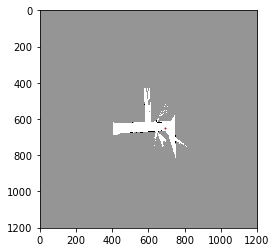

i: 4000
c_array
(100,)
[ 211. -527. -444. -383. -572. -152. -482. -414. -569. -302. -311. -343.
  521. -370. -275. -210. -269.  123. -411. -358.  -37. -485. -398. -268.
  234.  615.  128. -691. -449. -289.  589. -582. -293. -364. -507. -411.
 -268. -130.  523. -704.  -11.   73.  -43. -294. -406. -556. -306. -287.
 -226.  499. -589. -365. -290.  -89. -346. -273. -664. -593. -278. -132.
 -506.   98. -413.  117.  -15.   11.  271. -347. -203. -293.  231.  588.
 -408.  -38. -517.  100. -337. -244. -699. -223. -369. -294.  581. -251.
 -638.  221.  229. -470. -262. -602.   60.  -94. -580.  200. -203.   22.
 -265. -258. -539. -339.]
np.max(c_array)
615.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.45346774  4.84413507  1.06648264]
particle weights
[  3.50775547e-176   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.5

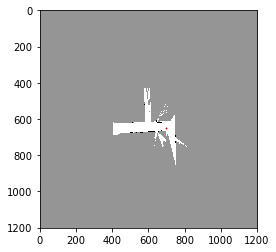

i: 4050
c_array
(100,)
[-330. -628. -561.  572.  557. -204. -744.   58. -323.  387. -549. -154.
  563. -329. -665. -326.  577. -478. -278.  247. -587.   17. -537. -142.
 -570.  -25. -322. -516. -451. -442.   37.  122. -327.  530. -246. -597.
 -462.    9.  485.  274.  -46. -364.   42. -221.  187.  193. -120. -367.
 -227. -326. -295. -295. -361. -418.  196.   38.   65. -655. -571. -374.
 -734. -568. -227.  431. -295.  199.  141.  540. -155.  399. -404. -273.
  273.   -6.   62.  387. -232. -290.  368. -141. -633. -544. -670.  -82.
 -227.   63. -446. -204.  492. -287. -599.  381. -466. -509. -372. -388.
  -43. -221. -664. -119.]
np.max(c_array)
577.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[ 2.5101022   5.02673275  0.93927338]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.69284538e-003
   2.04735693e-009   0.00000000e+000   0.00000000e+000   3.96503563e-226
   0.00000000e+000   3.02783106e-083   0.00000000e+000   3.37150891e-318
   8.2

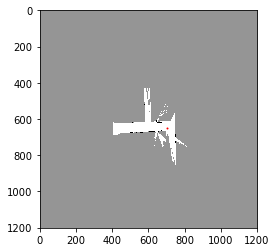

i: 4100
c_array
(100,)
[-365.  295.   82. -356. -220. -253. -686. -545. -328. -337. -169. -181.
   39.   17. -737. -746. -110.   54. -295.  -77. -301.   23.  205. -348.
  -63. -262. -303. -467. -226. -462.  492.  480.  441. -361.  283.  266.
   53.   58. -273.  117. -506. -359.   68. -256. -477.  421.   92.   28.
 -564. -454. -582. -247. -299.  334. -636. -558. -425. -257. -766. -840.
  501. -248.    7.  243.  424. -132. -548.  -38.   46.  -14.   57. -404.
  127.  493. -464.  -20. -499. -254.  542.  460.  326. -287. -774. -160.
   57. -408.    3. -610.  565.  493.  -20.   -1. -390.  117. -687. -215.
 -658. -663. -297.  581.]
np.max(c_array)
581.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.62639204  5.07561781  0.81738196]
particle weights
[  0.00000000e+000   6.19124695e-125   1.93666044e-217   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.0

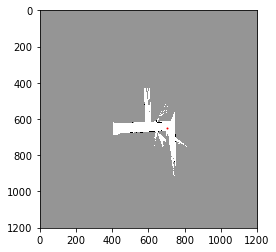

i: 4150
c_array
(100,)
[-105.  369. -305. -599.  536. -223. -332. -303. -122.  501. -431.   27.
  164. -383. -259. -772. -522. -284.  223. -581. -211. -462. -284. -421.
 -352. -183. -365.  401. -191.  429. -729. -224.   77. -326. -462. -284.
 -228.   71.  496. -373. -769.  485. -347. -138.  439.  -29. -437. -320.
 -438.  311. -418.  488. -401. -352. -387. -329. -226.  452.  515.  413.
  517.   36. -380. -505.  -98.  312. -253.  219. -380.  426.   61. -428.
  273.  120.  132.  -72.  192.  497. -600. -455.  181. -347. -737. -402.
   26. -372. -359. -352. -417. -397. -346. -256. -152. -381.   65.  419.
 -223. -458. -406. -217.]
np.max(c_array)
536.0
xy_w_scan shape
(2, 1080)
*****Updating map*****
particle states
[ 2.76128693  5.13922389  0.61696999]
particle weights
[  4.14225754e-279   2.97044503e-073   0.00000000e+000   0.00000000e+000
   9.99999994e-001   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.71486882e-286   6.30511672e-016   0.00000000e+000   8.79242573e-222
   2.7

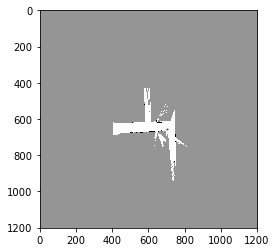

i: 4200
c_array
(100,)
[ -42. -360. -336. -425.   88. -367.    2. -423.   39. -478. -225. -432.
 -601. -653. -230. -669.  316. -436. -148. -252. -280.  -18. -215. -215.
 -459. -500. -413. -107.  493.  -65. -516. -253. -206. -862.  457. -127.
 -148. -376. -725.  -14. -532. -359.  315. -780. -222.  -85. -590.  137.
 -155. -396.  451. -447.   -6. -256. -450. -527.    5.   22.  -96.    0.
 -631.  -58. -389. -357. -509. -257.  208.  353. -195. -336. -171.   37.
  201. -336. -241. -517.   42.  402.  321.   17. -704. -203. -238.   55.
  133. -192. -273. -363. -453.   18.  106. -186. -276. -277. -138. -625.
 -594.   91.  246.  134.]
np.max(c_array)
493.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.82839322  5.19591144  0.51481858]
particle weights
[  4.49212861e-233   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.29043112e-176   0.00000000e+000   5.77310406e-214   0.00000000e+000
   6.76558284e-198   0.00000000e+000   1.50162674e-312   0.00000000e+000
   0.0

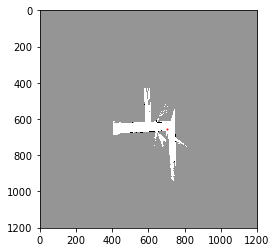

i: 4250
c_array
(100,)
[ 389. -416. -406.   57. -404. -236. -216.  221. -306. -439. -420. -502.
  346.   -3. -237.  359. -235. -385. -359.  313. -520.  174. -513. -491.
 -493. -586. -209.  187. -525.   88. -212. -449. -533.    2. -462. -404.
  360. -479. -381.  323. -251. -171.   86. -528. -475.  -68. -344. -258.
  -96. -488.  113.  -35.  423. -625. -518. -451. -223.    5. -494. -412.
 -432.  265.  -99.  438. -246. -384. -470. -739. -486. -486. -105. -520.
  331. -259. -432. -561. -550.  -32. -420.   12. -205. -520. -349.  104.
 -300.  220. -522. -423. -358. -791. -133. -525. -447. -183.  315. -334.
 -513. -162. -495. -413.]
np.max(c_array)
438.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 2.92454087  5.27626413  0.45611522]
particle weights
[  5.24288406e-022   0.00000000e+000   0.00000000e+000   3.41823772e-166
   0.00000000e+000   1.92983005e-293   9.36286373e-285   5.72924368e-095
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.1

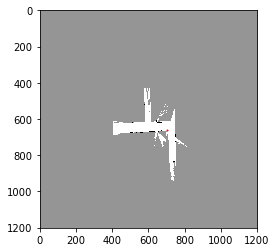

i: 4300
c_array
(100,)
[ 183. -211.  179.  233. -436. -273. -445. -535.  182. -706.  283.    5.
 -717. -404. -367.   51.  250.  400. -733.  436.  339. -537. -283. -516.
 -531. -183. -182. -209.  -23. -151. -346. -329.  335. -544.  259. -196.
  434. -416. -306. -598. -416.  325.  340.   15. -173.  286. -374.  262.
 -401. -500.   -3. -139. -397. -421. -471.  247. -510. -571. -143.  282.
 -454. -678.  -70. -537.  192. -291. -585.  107. -536. -337.  297. -564.
 -611. -703. -556. -566. -556.  206.   89. -751. -561. -116. -562. -523.
  257. -753. -537.  446. -569. -543.  258. -666. -193.   46.  -96.  -58.
   73. -697. -269. -647.]
np.max(c_array)
446.0
xy_w_scan shape
(2, 1066)
*****Updating map*****
particle states
[ 3.07533418  5.36801467  0.39304266]
particle weights
[  6.03293817e-115   4.66125653e-286   1.10497117e-116   3.12790079e-093
   0.00000000e+000   5.52389134e-313   0.00000000e+000   0.00000000e+000
   2.21939392e-115   0.00000000e+000   1.62172445e-071   2.99303018e-192
   0.0

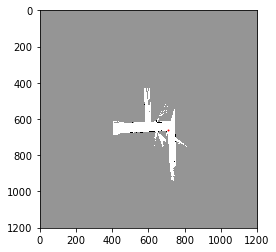

i: 4350
c_array
(100,)
[ 527.  -21. -459. -235. -565. -196.   23. -565. -454. -547.  328.  543.
  -20. -701. -646. -577. -452.  236. -718.  180.   43. -510.  406.  554.
  509. -546. -263. -592.  345.  154.  423. -266.  186. -568.   85.  451.
 -312. -218. -315. -277. -626.  459. -383. -482.  -94.  155. -499.  -92.
 -445. -722. -447. -421. -409. -495.  340.  -88. -251. -170.  -93.  259.
 -707.   91. -640.  425.  -49. -178. -590. -359. -588.  457. -435. -455.
  426. -563. -404. -120. -370. -718. -164.   42. -167. -386.  314. -196.
 -286. -575. -149. -399.  -52.  341. -578. -447.  172. -559. -418.  149.
   85. -586. -414.  158.]
np.max(c_array)
554.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 3.18327276  5.38527086  0.30344995]
particle weights
[  1.87949743e-012   1.90838350e-250   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.45257816e-231   0.00000000e+000
   0.00000000e+000   0.00000000e+000   7.07033247e-099   1.67014218e-005
   5.1

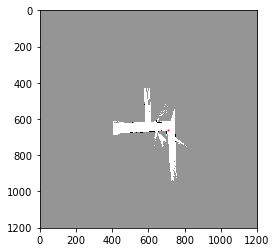

i: 4400
c_array
(100,)
[-298. -432. -200. -177. -141. -474. -454.   19.  -41.  524.  283.  317.
  -68. -525. -393. -380.  620. -100.  -17. -551.  353. -458. -499. -635.
  -53.  -40. -267. -192.   46. -549. -415.  -31. -566.  359. -632.  485.
 -152.  -86.  577. -650. -508.  101. -388. -366. -566. -288.  269. -341.
 -247. -355. -554. -550.  515. -481. -196.   20. -597. -387.  642. -203.
 -366. -276. -334.  510. -399. -628. -622. -269.  -13.  637. -251. -592.
 -536.  203. -454. -590.  182.  -24. -375. -553.  574.  151. -465.  614.
  119. -239. -513. -567.  129. -355. -286. -463. -367.  147. -309. -597.
 -567.   65. -571.  298.]
np.max(c_array)
642.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 3.34684722  5.39667144  0.32565428]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.70160179e-271
   2.36566051e-297   5.62774870e-052   1.21720733e-156   7.10193908e-142
   4.4

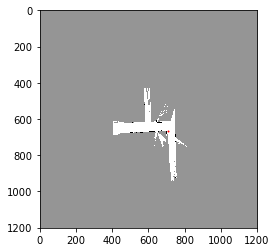

i: 4450
c_array
(100,)
[ -65. -628.  251. -417. -584. -114. -613. -623. -515. -609.   69. -599.
 -133.   49.  218.   86. -638. -316. -119. -223. -488.  237.   44. -312.
 -401. -587.  707.  198. -122.  462. -299. -505.  162.  695. -110.  326.
 -546.  257. -621.  259. -435.  504.  109.  -14.  169. -511. -624. -472.
  717.   62. -381.   55. -346.   75.   13. -106.  270. -582. -184. -584.
 -287. -245. -370.  300.   96.  126. -278. -249.  153. -267. -483. -424.
 -589. -287.  520.  283. -458. -178. -348.  729.   24.   10. -144.  473.
 -374. -560. -308. -614. -197. -421.  291.  318. -300. -584. -490. -567.
  147.  -56. -266.  -70.]
np.max(c_array)
729.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 3.43662691  5.49367577  0.44196241]
particle weights
[  0.00000000e+000   0.00000000e+000   2.55408285e-208   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.32080833e-287   0.00000000e+000
   0.0

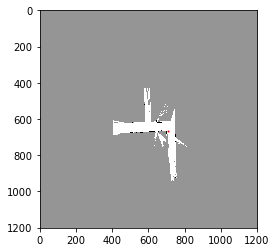

i: 4500
c_array
(100,)
[-444. -299.  383.  -34.  294. -275.  122. -281. -415. -538.  474. -467.
  562.  234. -447.  437. -594.  -59. -488.  122. -345. -345. -459. -229.
   22. -198.  187. -465.  -71. -229.  567. -361.   71. -441.  292. -431.
   69. -300. -192.  136. -586. -553. -463. -464. -218.   88. -444. -589.
  601. -413. -365.  289. -405.  148. -590. -373.  365. -468.  -17. -250.
  353. -272.  366. -212.  -52. -449. -601. -462. -193. -554. -430.  124.
 -256.  265. -451. -649.  597.   11. -575.  -59. -591. -474. -532. -542.
  395.  224. -218. -486. -240. -410. -443. -493. -176.  374. -230. -202.
 -306. -439.  149.  728.]
np.max(c_array)
728.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 3.54796627  5.58391255  0.47416822]
particle weights
[  0.00000000e+000   0.00000000e+000   1.47368188e-150   0.00000000e+000
   3.28242532e-189   0.00000000e+000   6.56967622e-264   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.88879241e-111   0.00000000e+000
   8.0

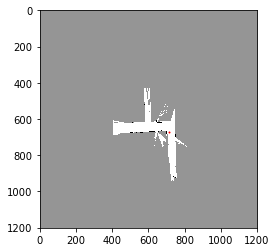

i: 4550
c_array
(100,)
[ 116.  355.  122.  -63. -100. -455. -591. -598.  -94. -442.  596. -501.
 -488. -134. -144. -276.   95. -585.  103.  210. -445. -498. -367.  -83.
 -454.  -58. -256. -497. -331. -432. -250.  180.  147.  290.  509. -453.
  -60. -427. -521.  -84.  456. -160. -228.   16. -438.  -57. -178. -205.
 -610. -560. -394. -436.   -7. -261. -322. -562. -546. -202.  333.  502.
  -75.  297.  -64. -328.  -95. -323. -585.  210.  -25.  584. -586. -116.
 -598.  570.   96.  285. -511.  363.  -97.  217. -486. -390.  -98.  476.
  271.  622. -353.  560.  537.  -82. -568. -429.   96.    8.  168.  -36.
 -202.  382.  222.  532.]
np.max(c_array)
622.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 3.65294806  5.58589687  0.58209862]
particle weights
[  1.76600593e-220   1.10502813e-116   7.12457641e-218   3.22314539e-298
   2.75032531e-314   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.10956042e-311   0.00000000e+000   5.10908903e-012   0.00000000e+000
   0.0

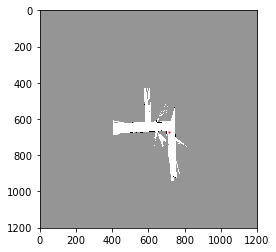

i: 4600
c_array
(100,)
[ 250. -356. -312. -130.  413.  141. -112. -467.   40. -318. -386.  265.
 -448. -315.  -90.    5.  -40.  107. -303. -398.  187.  614. -347.  172.
 -406.  -77. -215. -168.  147. -607. -400.  100.  -77. -336.  404.   97.
   73. -614.   30.  120. -436. -146. -400.  -88.  -37. -169.  484.   92.
 -420.   -3. -573. -435. -437. -172. -241.   96.  411. -303. -494. -508.
  191. -608. -505. -354.  167.  554.  -92. -576.  383. -169. -544.  139.
 -446. -471. -338.   83. -476. -423.  -45.  624. -568.  112. -414. -422.
 -556. -423. -256. -428. -595.   54.   34. -259.  334. -567. -420. -450.
 -483. -168. -260.   67.]
np.max(c_array)
624.0
xy_w_scan shape
(2, 1051)
*****Updating map*****
particle states
[ 3.74581584  5.58672126  0.64497428]
particle weights
[  3.74838380e-163   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.31123764e-092   1.72085994e-210   2.27270197e-320   0.00000000e+000
   2.35506475e-254   0.00000000e+000   0.00000000e+000   1.22535317e-156
   0.0

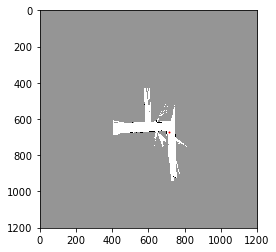

i: 4650
c_array
(100,)
[ 131. -516. -381. -624. -605. -332.  131. -448.  303.  150.  296. -596.
 -593. -609. -625.  109. -270. -545. -533. -364. -490. -558. -308. -451.
 -680. -410. -572. -468. -599. -512.   72. -583.   50.  142.  322.  -34.
  239. -457. -586. -611. -176.  597. -139.  130. -522. -578.  278.  195.
 -201. -566. -485.  277. -448. -566.  295.  -60. -576. -506. -567.  169.
  175.  148. -444. -615. -562. -321. -351.   77.  288. -487. -580. -503.
 -187. -622. -595.  153. -184. -128.  365. -185.  589.    3.  131. -484.
   47. -117. -342. -570. -431. -571.  -68. -182. -332. -558. -288.  142.
 -270. -626. -589. -109.]
np.max(c_array)
597.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 3.83570567  5.7586997   0.66138698]
particle weights
[  4.15552374e-203   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.15552374e-203   0.00000000e+000
   2.07623570e-128   7.41687439e-195   1.89328190e-131   0.00000000e+000
   0.0

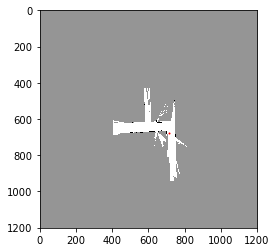

i: 4700
c_array
(100,)
[-360.  268. -478.  115. -168.  209. -552. -419. -514. -370. -524. -584.
 -385.    6.  360.  627. -225.  294. -599. -412.  -30.  336. -474. -522.
 -621. -503.  211.  156. -570. -580.  212. -117.  101. -430. -468.   67.
  198. -303. -498.  626.  255. -226.  202.  327. -530. -417. -594. -551.
 -331.   28. -300. -564. -355. -471. -430.  397.   62. -207. -534. -271.
 -425.  363. -475. -287. -208. -261. -383. -573. -303. -521.  135.  159.
  423. -314. -352. -557. -122. -451.  266. -569. -587. -364. -538. -280.
 -565. -454. -374. -522.  231. -487.  -52. -463.  496. -377.  398. -631.
 -611. -378. -511. -515.]
np.max(c_array)
627.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 3.94455741  5.82014023  0.58104768]
particle weights
[  0.00000000e+000   8.95845620e-157   0.00000000e+000   3.20020238e-223
   0.00000000e+000   2.13235124e-182   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

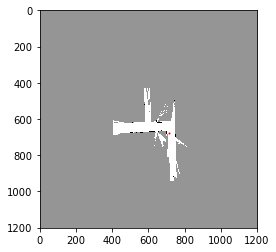

i: 4750
c_array
(100,)
[  52. -200.  573.   86. -433. -174.  496. -441. -500. -335. -287. -527.
 -421. -503. -437.  193.  637. -252.   12. -561. -388. -198. -615. -488.
  -10.   19. -390. -380.  592.   49.  401. -391. -182.  621. -523. -418.
 -406. -240. -267. -566. -581. -506. -547.  549. -110. -136. -606. -500.
 -632.  183. -518. -294. -271. -504. -516.  263. -537.   22.   90. -486.
  288. -532. -417. -393.   16.  279.  229. -507.  522.  548.  170. -142.
  202.   74. -197. -123. -215. -144.  432. -495. -554. -531.  113. -435.
  293.  452. -576. -135. -567.  -60. -280.  214. -471.  -94. -546. -541.
  613. -243.  513. -481.]
np.max(c_array)
637.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 4.06411948  5.83896655  0.4312368 ]
particle weights
[  8.66419140e-255   0.00000000e+000   1.60381071e-028   5.05522421e-240
   0.00000000e+000   0.00000000e+000   5.81403983e-062   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

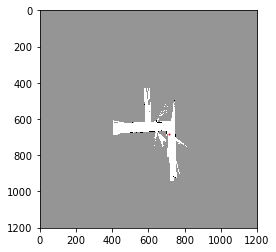

i: 4800
c_array
(100,)
[-603. -521. -480. -520. -330. -491.  427. -534.  -97. -166.  259. -481.
 -509. -466. -475. -473.   -7. -495.  -82. -464. -487.   96. -553. -544.
 -498.  349. -422.  668.  460.   26.  255. -134.  305. -525. -455.  -77.
 -477. -490. -491.  241. -398. -502. -494.  353. -551.  470. -182.   48.
 -417. -492.  126.  529. -480.  -59.   52. -107. -105. -189.  384.   60.
 -391.  -45. -487. -577. -513.   68. -360. -234. -213. -500.  -38. -612.
 -149.   29.  167. -337. -421. -369. -575. -523.  183. -219.  271.  552.
  124.  351.  153. -530.  216. -312.   41.  383. -494. -472.  330.   98.
  295. -265.  463.   94.]
np.max(c_array)
668.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 4.12796178  5.9033502   0.24302199]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.16286723e-105   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.36350705e-178   0.00000000e+000
   0.0

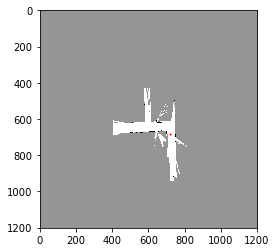

i: 4850
c_array
(100,)
[-161. -477. -481. -507. -480. -471. -477. -484. -439. -528.  -70. -451.
  -59. -471. -526. -509. -475.  429. -251. -503. -480. -509. -202. -211.
 -501.  247.  336. -480. -412. -483. -486. -215. -484. -488.  451. -524.
 -492.  152. -514. -487. -528.  273.  240.  228.   37. -376. -356. -503.
 -497. -189.  384. -484.   50.   52. -487. -143. -333. -562. -477.  325.
  373.  -66. -439. -599. -205. -487. -356. -552. -418. -497.  -49. -126.
 -374. -309.  476.   77.  277. -486. -478. -489. -467. -518. -337. -131.
 -278.  505. -514. -283. -164. -211. -233. -587.  212.    0. -460.  279.
   18. -510.  442. -105.]
np.max(c_array)
505.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 4.3061262   5.95379038  0.10941928]
particle weights
[  5.75274406e-290   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.90841537e-250   0.00000000e+000
   1.1

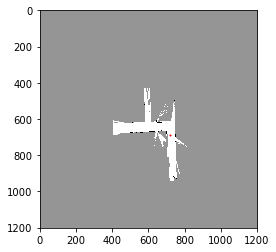

i: 4900
c_array
(100,)
[-461.  177. -457. -469. -443.  -91. -496.   70. -561. -399. -172. -420.
 -452.   85. -500. -478.  198. -370.   40.  170. -491.  -98.  140. -484.
 -302. -354. -439. -416. -405. -502. -413.    0.  550. -102. -478. -457.
   54.  292. -189. -221. -450. -451. -538. -455.  -23. -503. -501.  619.
  -53. -248. -412. -559. -447.  321. -109. -459. -454.  289. -462.  351.
   -6. -456.   48.  -59.  435. -429.  623.  -96. -441. -283. -139. -460.
 -403. -460. -470.  478. -646. -374. -465.  -67.  593. -488. -254.  111.
  147. -478.   -9. -458.  558. -371.  497.   30. -338.  330.  394.  401.
   15.  504.  195. -478.]
np.max(c_array)
623.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[ 4.39644897  5.92642758  0.0691888 ]
particle weights
[  0.00000000e+000   1.98051738e-194   0.00000000e+000   0.00000000e+000
   0.00000000e+000   8.05114239e-311   0.00000000e+000   6.71845007e-241
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

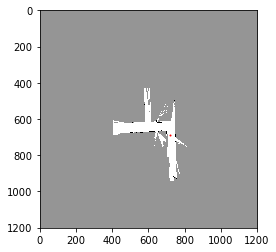

i: 4950
c_array
(100,)
[  80.  -17.   48. -486. -277. -376. -451. -418.  -78. -472. -433. -268.
 -579. -409. -459. -236.   56.  -92. -433. -343. -577. -436. -263. -533.
 -297. -406. -314. -109. -543. -314. -420. -466. -249.   35. -332. -293.
 -450. -353.  325.  120. -285. -315. -568. -567. -186. -242. -398. -331.
 -245.  -91. -384. -147.  256. -440.  -80. -575. -360. -428. -299.  552.
  193.  180. -371. -246. -444. -467.  -34. -105.  -89. -414. -548.  235.
 -258. -456. -150. -485. -426. -124. -387. -262.  -85. -113.  256.  171.
  101. -142.  185. -414. -399. -438. -424. -228.  -62.  529. -371. -432.
 -564.  266. -437.  -32.]
np.max(c_array)
552.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 4.54399333  5.89897107 -0.0868352 ]
particle weights
[  1.03039690e-205   7.69909710e-248   1.30491169e-219   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.48014117e-274   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

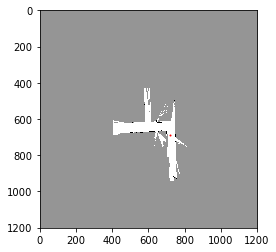

i: 5000
c_array
(100,)
[-461.   41. -557. -379. -417.  174.  415. -440.  397.   89. -360. -566.
 -443. -583. -445. -433.  447.  -77.  289. -230. -146.  -79. -443. -607.
  -84. -426.  -68. -139. -429.  183. -247. -367. -441. -444. -591. -539.
 -241.  121.  -62. -391. -455. -418.  336.   54. -170. -112.  441. -483.
 -454.  256. -294. -640.  211. -421. -437. -470. -593.  422. -404.  397.
 -479.  151. -216. -454. -437. -641.  419. -438. -439.  323. -408. -424.
  134. -390.  -10.   10. -313.  -11.  -13. -386. -462. -204. -384. -574.
 -419. -430. -414. -160. -410. -540. -117. -502. -151. -259. -580.  300.
  439. -320.   93.  224.]
np.max(c_array)
447.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 4.66432646  5.90514727 -0.08261164]
particle weights
[  0.00000000e+000   4.73390857e-177   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.73140411e-119   1.26286259e-014   0.00000000e+000
   1.92333716e-022   3.32165863e-156   0.00000000e+000   0.00000000e+000
   0.0

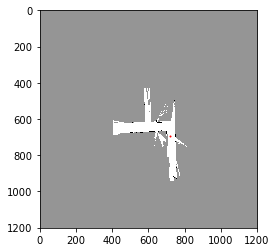

i: 5050
c_array
(100,)
[ -57. -311. -412. -455. -473.  166.  -18. -425.  308. -513. -489. -128.
 -472. -495. -155. -473.   13.  -98. -474. -411. -176. -621. -394. -443.
  -99. -166. -414. -200. -511. -413. -456.  333. -220. -598. -187. -475.
   86.  184. -392.  -23.  -31. -482.  -55. -508. -614.  126. -357. -444.
 -375. -233. -463. -425. -446. -355. -310. -462.  -80.  153.  297. -613.
 -232. -471.  511.  -84.  -37. -196. -493. -388. -144. -439. -594. -439.
   90.  136.  -29. -220.   37. -342.  354. -572. -425.  -43.   61. -228.
 -443. -436.  178. -413.   60. -390. -419. -454. -453. -472. -492.  195.
 -116. -464. -470. -174.]
np.max(c_array)
511.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 4.73685353  5.98712698 -0.04124351]
particle weights
[  2.09283157e-247   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.47368188e-150   1.81225403e-230   0.00000000e+000
   6.89001510e-089   0.00000000e+000   0.00000000e+000   3.06073735e-278
   0.0

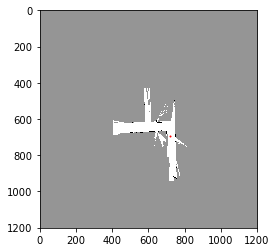

i: 5100
c_array
(100,)
[-227. -324. -265. -600. -458. -335. -599. -125. -225. -589. -453. -211.
 -484. -555. -547. -457. -282. -533. -580. -399.   77. -194.  -14. -198.
 -113. -450. -153. -163. -548. -297.  -75. -306. -398. -485. -235. -594.
 -219. -323. -176. -126. -157.  303. -354. -343. -222. -414. -452. -399.
 -602. -577. -199.  -58. -440. -428. -211.  -50. -183.   32.   44. -390.
 -125. -406.  282. -501. -136. -346. -556. -190. -597. -331. -378. -506.
 -484. -456. -442.  -94.   22. -371. -282. -140. -431. -230. -615. -591.
   -4.  246. -208. -241.  304. -105. -151. -159. -559. -480. -470. -332.
 -380. -317. -483. -297.]
np.max(c_array)
304.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 4.90122154  6.00931698  0.01306544]
particle weights
[  1.79300825e-231   1.33973080e-273   5.62849098e-248   0.00000000e+000
   0.00000000e+000   2.23757830e-278   0.00000000e+000   3.56138923e-187
   1.32486385e-230   0.00000000e+000   0.00000000e+000   1.59328694e-224
   0.0

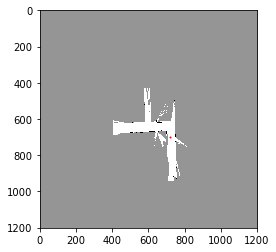

i: 5150
c_array
(100,)
[-393.  311.  233.   43. -172. -449.  -32.  -31.   78. -600. -312. -419.
 -316.  110. -383.  126. -321. -129. -455. -111. -540. -429. -366.   81.
 -407. -546. -584. -447. -402. -423. -279. -611. -687.  -88.  198. -107.
 -310. -471. -574.  311. -363. -404.  292. -194.  -57. -593. -186. -397.
 -316.   -4. -444.  279. -415. -289. -154. -452. -462.  289.   95. -135.
 -123.  134. -398. -203. -441. -546.   67.   57.  143. -102.  -54. -272.
 -584.   47. -369.  312. -205. -448.  242.  148.  118. -107. -385.  -90.
  321. -386.  -69.  -83. -592. -593.  121. -610.  133. -446. -387.  116.
  179. -423. -454. -575.]
np.max(c_array)
321.0
xy_w_scan shape
(2, 1073)
*****Updating map*****
particle states
[ 5.05369076  6.03877469 -0.0272574 ]
particle weights
[  8.19684836e-311   4.53902067e-005   6.05330522e-039   1.84518965e-121
   7.81137346e-215   0.00000000e+000   4.94259321e-154   1.34353613e-153
   2.92649561e-106   0.00000000e+000   1.23452513e-275   4.94065646e-322
   2.2

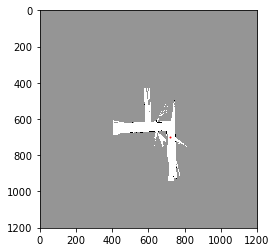

i: 5200
c_array
(100,)
[-303. -215. -289. -474.  145. -402. -513. -327. -321.   58. -309. -352.
 -371. -162. -650.   -7. -163.  -62. -511. -445.   73. -569.   69. -400.
 -373. -347.  277. -260. -210. -381.  -89.   74. -326.  282. -352. -160.
  205.  -68.  108.  256. -449. -446. -274.  119. -601.   30.   39. -349.
 -583. -559. -274. -425.  266.  -53.   -8. -228.   31.  152. -268. -617.
   20.  278. -257. -371. -335. -424.  147. -543.   19. -435. -363.  127.
 -597. -362. -393. -280.  166.  174.  278. -653. -394. -651. -303.  -99.
  -80. -238.  -19. -158. -301. -113. -237. -375.   28. -435.  -42. -221.
  277.   63. -650.  136.]
np.max(c_array)
282.0
xy_w_scan shape
(2, 1079)
*****Updating map*****
particle states
[ 5.18485128  6.06311665 -0.133092  ]
particle weights
[  8.25076876e-255   1.36272688e-216   9.92240986e-249   0.00000000e+000
   3.02288975e-060   8.34335470e-298   0.00000000e+000   3.11477622e-265
   1.25659041e-262   4.97510651e-098   2.04516110e-257   4.32578372e-276
   2.4

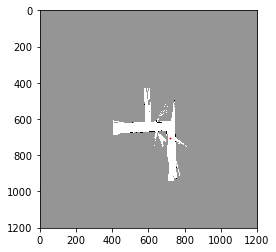

i: 5250
c_array
(100,)
[ -95. -199.    6.  -60. -301. -433. -570. -469.   39. -632. -271. -430.
 -545. -455. -127. -386. -536. -223. -239. -626. -446.  115. -533. -338.
 -410. -400. -375. -198. -435. -136.  -36. -346. -453. -178. -191. -323.
 -607. -447.   51. -375. -350. -626. -279. -448. -332. -424.  -91.   70.
  202. -494. -621. -386. -251. -316.  -76. -345.   18. -248. -616. -374.
 -623. -396. -149. -420. -368. -335. -424. -472. -429. -355. -412. -644.
 -146. -616.  218. -301. -368. -270. -342. -482. -354. -399. -424. -446.
 -300. -425.  -90. -241. -634. -411. -443.   12. -465. -232.  211.  -38.
 -390. -627. -336. -423.]
np.max(c_array)
218.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 5.30609388  6.11504755 -0.10286051]
particle weights
[  1.16260255e-136   7.92145852e-182   8.49520655e-093   1.84390328e-121
   3.98811799e-226   1.87886851e-283   0.00000000e+000   4.35807840e-299
   1.82344155e-078   0.00000000e+000   4.26189215e-213   3.77380828e-282
   0.0

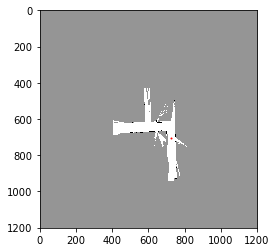

i: 5300
c_array
(100,)
[-684.  -76. -279. -180. -378.   93.   53.    7.  164. -686. -340.  233.
  -56. -428. -275.  -82. -115. -451. -595.   92. -507. -311. -206.   23.
 -392.  -38. -297.  210. -328. -336. -456. -114. -624. -427.  236.   67.
 -275.   74. -318. -337. -665. -364.   46.  -68.  214. -235. -163.  145.
 -656. -543. -613.  238. -395. -364.  193. -349.  122.  -74. -476. -113.
 -143. -226. -496.   90. -161. -141. -633. -425. -392.   83. -195. -409.
 -274.  229.    3. -248. -367. -595.   66. -404. -592. -283. -114. -113.
  109. -270. -405.  -25.  -10.   32. -156. -162.    8. -443. -379. -338.
 -355.  194.    3. -326.]
np.max(c_array)
238.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.46304212  6.11167759 -0.15975187]
particle weights
[  0.00000000e+000   3.74793287e-137   2.58233141e-225   2.55367536e-182
   2.61130902e-268   9.32307646e-064   3.96077315e-081   4.17093865e-101
   6.37481317e-033   0.00000000e+000   8.31856820e-252   5.89911296e-003
   1.8

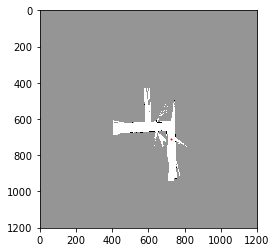

i: 5350
c_array
(100,)
[ -21. -308. -154. -158. -314. -297. -218. -636. -471. -121. -127. -376.
 -408.  -52. -552. -289. -649. -624.  227.  -97. -262. -138. -396. -362.
 -218. -285. -542. -645. -447. -360. -599. -457.   46.  -43. -257.  148.
  -87. -341. -187.  141. -204. -169. -128. -646. -333. -458. -266. -235.
 -429.  -33. -283. -199. -411. -248. -181.  149. -365. -512. -501.  113.
  -39. -268.  206. -282. -401. -290. -446. -379. -439. -241. -226. -584.
 -321. -650.  -37. -658. -510. -153. -182. -248. -377.  -25.  225. -655.
 -670. -265. -123. -250. -447. -549. -144.  -81. -336. -257. -390. -174.
 -232. -438. -615.   23.]
np.max(c_array)
227.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.59208823  6.04126343 -0.15648711]
particle weights
[  1.73717813e-108   3.95665375e-233   3.01077471e-166   5.51442624e-168
   9.80756410e-236   2.36901247e-228   4.82871327e-194   0.00000000e+000
   6.41693288e-304   6.46243462e-152   1.60187739e-154   1.16225996e-262
   1.4

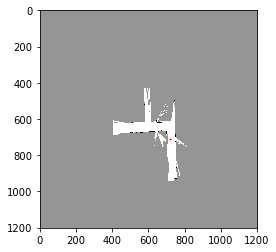

i: 5400
c_array
(100,)
[ 152. -637.  113.  -48. -330.  155. -332.  -79. -328. -172. -312. -273.
  177. -418.  195. -203.  101. -396. -639. -272. -691. -419. -388.  145.
 -371.   22. -633. -348. -334. -392.  191. -145. -277. -310. -257.  145.
  137.  120. -640. -225.  230. -407.  132.    8. -634.  203. -318. -656.
  140. -284.   45. -116. -628. -395. -500. -296.  -18.  134. -328.   59.
 -277. -334. -632. -322. -391.   79.  -57. -497. -662.  181.   26. -418.
   28. -279.   67.  194.   76.  214.   59. -133. -681. -414.  182. -491.
 -336. -228. -333.   -6. -246. -455.  193. -108.   88.  -90.   11.  -64.
 -291. -658. -402.  -89.]
np.max(c_array)
230.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 5.02169679  5.9936918  -0.19176725]
particle weights
[  1.33361467e-034   0.00000000e+000   1.54008811e-051   1.84558470e-121
   6.23864230e-244   2.67863666e-033   8.44308422e-245   6.35338309e-135
   4.60976779e-243   2.59189991e-175   4.09629061e-236   3.54711733e-219
   9.6

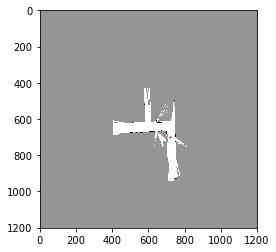

i: 5450
c_array
(100,)
[-424. -398.  238. -108. -432. -533. -295.   99.  167. -455. -441.  203.
   58. -552. -404. -454. -723.   62. -247.  255. -673.  302.  -82. -411.
 -544. -387. -360.   16.  270.  -87. -652. -231. -487. -178. -405.   62.
 -320. -645.  259. -426. -429.  -90.  184.  209. -617. -691. -312.  -96.
   98. -350.  131.  -64. -408. -422. -148. -125.  104. -466.  164.  244.
   54. -303. -412. -196. -433. -164. -308. -383.  117.  220. -527. -234.
  203. -388. -201.   86. -382. -694. -281. -165.  141. -215. -385.  215.
 -100.  -83. -177. -336.  160. -401. -408. -329. -264. -148. -512. -209.
  -89. -408. -239.  155.]
np.max(c_array)
302.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.11864754  5.99239156 -0.21436912]
particle weights
[  5.03739451e-316   9.85967654e-305   1.60381089e-028   8.69485652e-179
   1.68970451e-319   0.00000000e+000   5.32346378e-260   6.89001510e-089
   2.34555134e-059   0.00000000e+000   0.00000000e+000   1.01122149e-043
   1.0

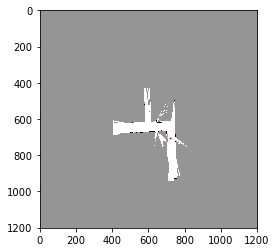

i: 5500
c_array
(100,)
[-167. -432. -345. -331. -490. -152. -460.   -5. -486. -285. -333. -501.
 -470. -170. -160. -366.   66. -567. -200. -586. -158. -106. -415. -370.
 -169. -345. -131.   15. -497. -288.  257. -197. -369. -527. -217. -464.
 -229. -201. -135. -525. -272. -394. -417. -395. -235. -366. -383. -403.
  -87. -414. -120. -447. -436. -458. -111. -457. -458. -525.  -16. -122.
 -503. -191. -475. -308. -349. -167. -213. -431. -373. -123. -184. -399.
 -349.   99. -405. -246. -292. -363. -132. -231. -454. -326. -338. -450.
 -564. -532. -476. -409. -675. -441. -473. -272. -597. -534. -421. -320.
 -246. -201. -332. -549.]
np.max(c_array)
257.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.2129978   5.98171287 -0.07669169]
particle weights
[  7.23002290e-185   5.90339671e-300   3.58692168e-262   4.31364738e-256
   0.00000000e+000   2.36350705e-178   4.08184468e-312   1.64000715e-114
   0.00000000e+000   4.09629107e-236   5.83788690e-257   0.00000000e+000
   1.8

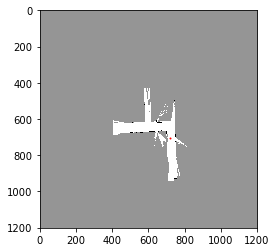

i: 5550
c_array
(100,)
[-388.  -47. -166.  -16.  268. -576. -269.   28. -634.  -21.  197.  -11.
 -297.  220.  170. -460. -516. -576. -498.  191. -294.   35.   34.  297.
  166. -538. -517. -191. -144. -504. -341.  -81. -443. -420.  229. -478.
   23.   72. -233.   -6. -101.   27. -111. -361.  -63. -533.   52.  215.
  149. -196.  269.  -51. -418. -425.  159.  202.  161.  254.  -37.  270.
 -413. -416.   26. -258. -364.  181.  -11. -561. -616. -402. -509.  -28.
 -305. -184.  182.   59. -115.  -17.   62.  169.  -63. -470. -685.  188.
 -327. -602. -499. -190. -580.  176.  133.  259.   45. -511.  -51. -515.
 -338.   40. -410. -548.]
np.max(c_array)
297.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 5.05789966  5.9460606  -0.11451113]
particle weights
[  3.22314539e-298   4.00588267e-150   8.34939253e-202   1.16366284e-136
   2.54366565e-013   0.00000000e+000   1.54640499e-246   1.49549294e-117
   0.00000000e+000   7.84069851e-139   3.72007598e-044   1.72702878e-134
   1.0

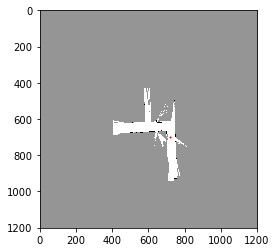

i: 5600
c_array
(100,)
[-393. -558.  -35.  -89.  170. -654.  281.  -70. -477. -545. -493. -175.
   96. -460. -288.   33.   97.   53. -510.  272. -469. -428. -372. -447.
  126. -522.   87.   35.  -56. -629. -543.  247. -469. -628. -475. -505.
  261. -452. -510. -184. -148. -604.  -47.   45. -601.  -52. -577. -606.
 -514. -318. -440.  -68.  -59. -157. -225. -656. -464.  -41.  -48. -408.
  130.  165.  264. -434. -358.    1.  282. -487.  -37.  153. -324. -551.
 -334.   96. -403.  -22. -353. -100. -394. -446. -115.  199.  -47.  127.
  212. -590. -447. -507. -314.  -63. -108. -470.  108. -446.   80. -356.
 -354. -348.  112. -467.]
np.max(c_array)
282.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.06611391  5.91999339 -0.17386774]
particle weights
[  5.18994164e-294   0.00000000e+000   1.55807011e-138   5.50408298e-162
   1.67092049e-049   0.00000000e+000   2.68932492e-001   9.82381395e-154
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.46240525e-199
   1.2

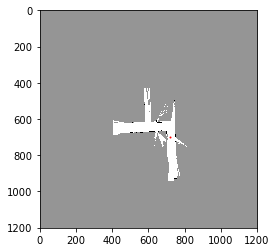

i: 5650
c_array
(100,)
[-302. -539. -520.  223. -236.  203.   65. -509. -491.  -93. -342. -561.
 -254.  175. -544.  268. -540.  -91.  123. -436. -295. -211.  195. -527.
   44. -353. -521.  227. -189.  -95. -141.  -96.  -91. -717. -560. -516.
 -129.  249.  -94. -353. -388. -304. -441.  237. -326. -137. -525. -406.
  159.  253. -305. -203. -484.  -90. -553. -519. -563. -394. -549. -392.
   85. -474. -405.  281. -328.   44. -359.  234. -328. -372.  252. -628.
 -540. -571.   50.   81. -498. -457. -425. -330. -554. -316. -419. -518.
   68. -511. -310. -328.  -91.  -22.  -78. -519.  -89.  -98.  -46.  -87.
 -107. -519. -399. -552.]
np.max(c_array)
281.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.24170267  5.86916755 -0.11807522]
particle weights
[  6.40200588e-254   0.00000000e+000   0.00000000e+000   6.47022030e-026
   2.94952359e-225   1.33361180e-034   1.55736685e-094   0.00000000e+000
   0.00000000e+000   3.74854550e-163   2.71979889e-271   0.00000000e+000
   4.4

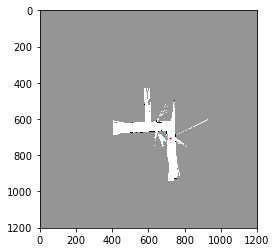

i: 5700
c_array
(100,)
[-175.   18.   15. -108. -561. -641.  191.  104. -266. -368.  189. -537.
 -549. -559. -220.  241. -183. -496. -447. -525.  109. -583. -562. -596.
 -584. -582.   67. -581.  -98.  135. -245.  175. -501. -598.  204. -421.
 -560. -238. -226. -508. -452. -381.  175. -592. -564.  225.  240.  100.
 -447.  228. -121. -560.  242.   86.  113. -535.  217. -105. -258. -115.
 -128. -358.  176. -361. -339.  205. -266. -608.  -48. -530.  191.  -98.
 -234.   78.  145. -517.  234. -583. -627.  -65. -354.  227.  234. -487.
   48.   18.   90. -157. -454. -576.   99.  136.   -4.  213. -566.   98.
 -464. -345. -518.   94.]
np.max(c_array)
242.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 5.38148863  5.91399343 -0.02055741]
particle weights
[  5.27212733e-182   3.47392868e-098   1.72956725e-099   6.60261810e-153
   0.00000000e+000   0.00000000e+000   4.71809050e-023   7.76508728e-061
   1.58923469e-221   8.00112183e-266   6.38524114e-024   0.00000000e+000
   0.0

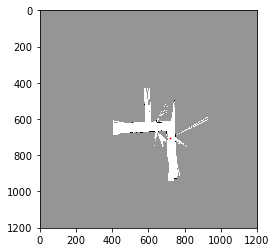

i: 5750
c_array
(100,)
[-586. -152.   57. -605. -644. -399. -608. -608. -535. -598. -616. -608.
 -251.  -73. -177.   27.  194.  126. -242. -606. -283. -599. -175.  -98.
 -219. -620. -601. -455. -167. -151. -464. -446.  101. -600.   36.  149.
 -225. -477. -593. -603. -172.  -73. -604. -219. -383. -428.   60. -622.
 -642. -652.  185. -541. -633.  158. -249. -411. -594.  -96. -206. -298.
 -138. -652.  -99. -595. -468. -595.  157.  108.  150. -637.   99. -548.
 -611. -677. -648. -606. -155. -170. -561.   68.   36. -564. -440. -273.
 -443. -605.  150. -594. -181. -468. -343. -629. -162. -325. -369. -315.
 -527. -434. -430. -475.]
np.max(c_array)
194.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 5.50073108  5.94802518  0.04164098]
particle weights
[  0.00000000e+000   5.42070369e-151   3.17396685e-060   0.00000000e+000
   0.00000000e+000   2.90615410e-258   0.00000000e+000   0.00000000e+000
   2.50766675e-317   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.4

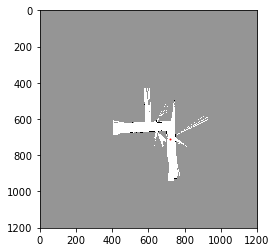

i: 5800
c_array
(100,)
[-591. -305. -154. -233. -416. -581.  135. -595.  221.  124. -478. -454.
  114. -634. -648. -513. -364. -659. -426.   75. -360. -415. -181. -441.
  186. -620.  172. -337.  115. -200. -634. -323. -263. -317. -193. -535.
 -192. -225.   98. -594.   15. -314.  173. -340. -224.  158.  -97.   81.
 -388. -208. -220. -613. -454. -353. -221. -276. -321. -543.  147.  201.
   54.  171. -151. -507. -628. -279. -229. -280. -707.  170.   88. -338.
 -628.  179. -616. -367.  -52.  153.   10.    8.   45. -657. -131. -130.
 -599. -248.  173. -463.   89. -300. -668. -626. -596. -563.   49. -419.
 -423. -615. -498. -592.]
np.max(c_array)
221.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.5982673   5.96586349  0.06401106]
particle weights
[  0.00000000e+000   3.64000951e-229   1.37901594e-163   6.76558282e-198
   2.26159600e-277   0.00000000e+000   4.47377930e-038   0.00000000e+000
   9.99999998e-001   7.47197232e-043   2.68013795e-304   7.09945016e-294
   3.3

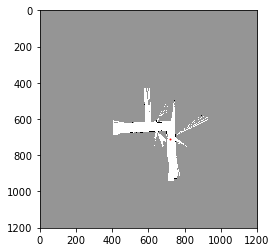

i: 5850
c_array
(100,)
[-220. -449.  -86.  -28.  107. -285. -384. -537. -577. -619. -626. -138.
   44. -568. -592. -505. -284. -648. -198. -200. -180. -649.  128.  115.
 -214. -691. -453. -229. -592.  177.   60. -463. -329.    1. -309. -645.
   76.  132. -671. -589. -306.  155. -276. -175. -411.   93. -533.   43.
 -484.  187. -356. -353.    6.   38. -668. -285. -155.   44. -644. -662.
  163.  102. -682. -132. -657.  143. -156. -196.  -75. -251. -511. -315.
   83. -159. -452.   84. -136. -139. -220. -643.  183. -160. -147.   35.
 -486. -292. -755. -604. -284. -402.   20.  155. -560. -115. -127. -647.
 -267. -514. -522. -643.]
np.max(c_array)
187.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.66938964  5.95668065  0.14421605]
particle weights
[  1.71492089e-177   6.03681315e-277   2.68970509e-119   4.15704394e-094
   1.77230994e-035   1.01181885e-205   1.02317297e-248   3.65505012e-315
   0.00000000e+000   0.00000000e+000   0.00000000e+000   7.02088090e-142
   7.7

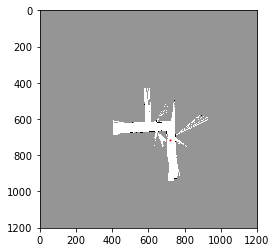

i: 5900
c_array
(100,)
[-118. -301. -320. -305. -503.  -31.  -42. -653. -321.  -48. -681.  -23.
 -157.   -2. -270. -167. -795. -681. -687. -682.  117. -675. -648. -674.
 -134. -394. -583. -425. -617. -647. -145. -118. -689. -625. -402. -480.
 -125. -371. -250. -559.  137. -642.  135. -101. -634.   71. -655.  144.
 -689. -690.  -34. -211. -557. -117.  -33.  131.  110. -608. -166.   -1.
 -684. -120. -541. -560. -497. -541.  -93. -187. -417. -465. -511. -345.
 -255. -222. -332. -102. -603. -235. -122.  -11.   31.  -87. -590. -691.
 -701. -600. -413. -690.  -99. -670.  -63. -679.   85. -600.  -17. -168.
 -647. -434. -678. -488.]
np.max(c_array)
144.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.68815423  5.98412099  0.19742227]
particle weights
[  1.63830732e-114   5.47652637e-194   3.06838625e-202   1.00306079e-195
   1.02569878e-281   9.95440480e-077   1.66255490e-081   0.00000000e+000
   1.12879622e-202   4.12106159e-084   0.00000000e+000   2.96736625e-073
   1.8

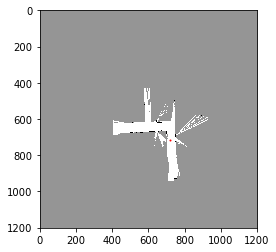

i: 5950
c_array
(100,)
[-263. -210. -391. -602. -224. -468. -350. -283. -438. -538. -606. -244.
 -302. -366. -700. -206. -504. -104. -298. -383. -280. -328. -345. -170.
 -345. -635.   99. -338. -623. -331. -318. -322. -478. -413. -626. -615.
 -356. -296. -390. -202. -457. -600. -598. -511. -640. -308. -397. -422.
 -240. -564. -515. -427. -417. -306. -434. -285. -348. -288. -310. -641.
 -392. -613. -612. -409. -431. -283. -182. -434. -420. -681. -473. -508.
 -263. -680. -398. -493. -256. -391. -607. -303. -449. -413. -230. -432.
 -593. -205. -363. -310. -214. -619. -319. -630. -241. -328. -429. -337.
 -416. -367. -579. -313.]
np.max(c_array)
99.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.97274219  5.97074426  0.05410598]
particle weights
[  6.10095120e-158   6.35338381e-135   1.56929239e-213   3.62717230e-305
   5.28302110e-141   5.68890604e-247   1.00410152e-195   1.25749977e-166
   6.07943498e-234   2.26159600e-277   6.64339780e-307   1.08891181e-149
   7.04

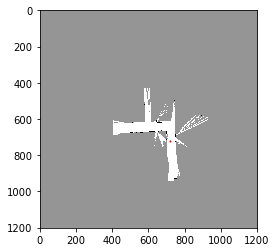

i: 6000
c_array
(100,)
[-268. -645.   68. -570.  -67.   99. -243. -675. -633. -644. -383.   18.
 -115.   25. -615.  -64.   30.  169. -667.  -65. -665. -294.  158.   59.
 -125.  -21. -655. -368. -592. -698. -616. -158. -293. -123. -685.  137.
  104. -666. -258. -565. -371.   31. -319. -630.   57.  -78. -673. -578.
 -265.  -80.  -21. -663.   67.  132. -633. -538. -611.  110. -638. -640.
  -15. -303. -109.  -96.  -22.  -25. -313.   69.  -13. -672.  117. -107.
 -478. -700.   74. -649.   91. -213.  170. -343. -389. -132. -177. -568.
  101. -526. -720. -209. -602. -310. -170. -282.   67.   72. -589.   92.
 -644. -531. -187.    2.]
np.max(c_array)
170.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 5.92733838  5.97090855 -0.00834658]
particle weights
[  4.39508373e-191   0.00000000e+000   3.68055297e-045   3.60667921e-322
   8.63292595e-104   1.06915830e-031   3.16467562e-180   0.00000000e+000
   0.00000000e+000   0.00000000e+000   5.00151683e-241   7.09886599e-067
   1.2

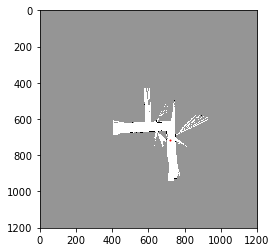

i: 6050
c_array
(100,)
[-175. -627. -547. -666.   32.  -87.  -60. -634. -183.  -24. -146. -577.
  -94. -589.  -91. -617. -595. -314. -674. -422. -664. -245. -654. -455.
 -538.  -54. -677.  -41. -687.  -74. -662. -613. -198. -276. -112. -656.
 -505. -403. -645. -143. -659. -695.   79. -174. -483. -303. -576. -287.
  -85. -125.  -69.  139. -355. -106. -236. -162. -344. -677.  -69. -191.
 -637. -169. -668.   15.  132. -685. -685. -228. -656. -677. -177.  107.
  -87.   -8. -666. -270. -124.  -40. -651. -675. -364. -355. -472.  105.
 -299.  -71. -660. -294. -688. -131. -498.  -14. -627. -678. -118. -351.
 -268.  106. -639. -303.]
np.max(c_array)
139.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.05570316  6.02733018  0.07565887]
particle weights
[  4.27697624e-137   0.00000000e+000   1.18464867e-298   0.00000000e+000
   3.38917966e-047   7.06400902e-099   3.75839357e-087   0.00000000e+000
   1.43476569e-140   1.62033049e-071   1.68142234e-124   1.10854956e-311
   6.4

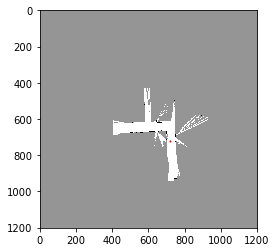

i: 6100
c_array
(100,)
[ 123. -742. -125. -482.  107. -312. -123. -145.  137. -310.  128.  -47.
 -673. -714.   32. -674. -449. -684.  194. -566. -395. -631. -222.   50.
  -36.   49.  -67. -493.   52. -102. -588. -182. -616. -614. -507. -679.
 -379. -690. -220.  127.  -77.  -53. -338. -646.   26. -444.    1.  -42.
 -626. -689.   -4. -523. -374. -663.   88. -158.  144. -642. -614. -666.
  -15.  180.  188. -684. -194.  150.   -5. -662. -559. -342. -454. -655.
 -293. -271. -448.  -50.   97. -670. -429.  137. -263. -206.  -63. -678.
  125.  178.   74. -650.  144. -623. -669. -684. -687. -451.  -99.  183.
 -121. -366. -743. -644.]
np.max(c_array)
194.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.56943556  6.08370258  0.12448192]
particle weights
[  1.45884437e-031   0.00000000e+000   2.87724903e-139   2.60523805e-294
   1.64171306e-038   1.76160825e-220   2.12601545e-138   5.93045226e-148
   1.75441249e-025   1.30166222e-219   2.16511702e-029   2.15748130e-105
   0.0

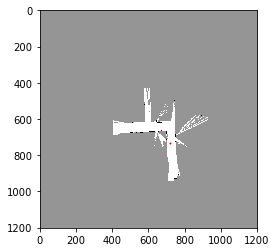

i: 6150
c_array
(100,)
[-133. -533. -402. -273. -585.  193.  216. -554. -691. -214.  226. -563.
  188. -593. -447.   12. -273. -501. -350. -278.  204. -565. -206.  206.
  103. -166.  161. -597.  131.  -25.   42. -337. -484. -307.  223. -217.
   73. -516.  205.  215. -568. -618.  210. -560.  214. -340. -563.  222.
  175. -412.  164. -606.  131.  213.  -21.  -95. -566.  -54. -417. -685.
 -246.  119.  234. -319. -170.  -22.  170. -494. -416. -576.  125. -572.
  -89.  155. -589. -584.  185. -373. -609.  -64.   94. -564. -649.  -44.
 -117.   63. -669.  180. -618. -562.  172.  172. -587.   61. -447. -582.
 -263. -460.  207.  -20.]
np.max(c_array)
234.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.54390467  6.05504123  0.11997623]
particle weights
[  4.10931608e-160   0.00000000e+000   6.14545320e-277   6.49444557e-221
   0.00000000e+000   1.56232236e-018   1.52245243e-008   0.00000000e+000
   0.00000000e+000   2.72845323e-195   3.35342464e-004   0.00000000e+000
   1.0

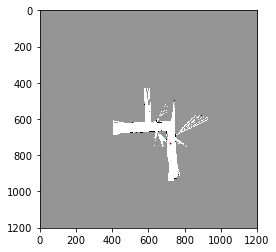

i: 6200
c_array
(100,)
[-484. -451. -127. -115. -240. -430. -129.  -79. -593. -169.   95. -726.
 -617. -462. -136. -171. -431.  205. -418. -602.  230. -587.  217.   -4.
 -446. -554.   92. -159.   59. -256. -130. -178.   67. -465. -292. -577.
 -172. -141. -166. -392. -581. -546. -338. -239.  -64. -573. -358.  -97.
  178.  198.  129. -598.  163. -508. -466.  149. -605.  212. -558. -492.
 -323. -531.   38.  -94. -170. -259. -586. -597. -520. -623. -338.  211.
 -187. -428.  164. -483.  177. -166. -172. -129.   55.  216. -185. -127.
   27.  226.  215. -267.   83. -402. -111. -462.  172. -586.  -40.  127.
 -318. -365.  159. -472.]
np.max(c_array)
230.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.63507259  6.04538423  0.14355617]
particle weights
[  8.05111536e-311   1.72812022e-296   8.89172636e-156   1.44717107e-150
   7.47669447e-205   2.27907214e-287   1.20336431e-156   6.23908957e-135
   0.00000000e+000   5.11231787e-174   2.30335603e-059   0.00000000e+000
   0.0

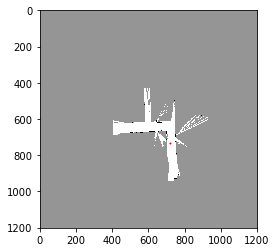

i: 6250
c_array
(100,)
[ 130. -584.  -90. -300. -632. -425.  136.   69. -583. -605.   -9. -162.
 -559.  215. -197.  111.  -61. -571. -359. -616. -573. -629. -100. -695.
 -555.   18. -167.   73.  213. -116. -574.    2. -607. -368. -576. -622.
 -120. -567. -613.  -88. -104. -496. -471.  143. -622. -620. -618. -619.
 -602. -677. -567. -271.  222.    7. -672. -530.  216. -416. -447. -580.
 -460.   -5. -251.  146. -577. -443.   74. -505.   -5. -612.  -75. -160.
 -628.   38. -539. -577. -128. -467. -679. -361.  -84. -620.  130.  -91.
 -423. -475.  199.   63. -276. -686. -619.  187. -574.  148. -156. -558.
   99.  199. -396. -159.]
np.max(c_array)
222.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.66668288  6.09939665  0.20125695]
particle weights
[  1.10505580e-040   0.00000000e+000   3.15208697e-136   1.98041858e-227
   0.00000000e+000   1.02316754e-281   4.45811330e-038   3.55976078e-067
   0.00000000e+000   0.00000000e+000   4.74734972e-101   1.69588147e-167
   0.0

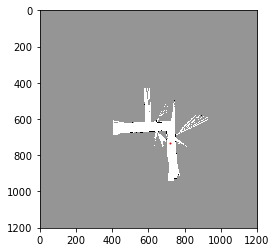

i: 6300
c_array
(100,)
[  57.   52. -598. -667. -529. -580.  118. -588. -630.   54. -280. -689.
 -251. -644. -488.  140.  180.  160. -604. -657. -633. -312. -537. -629.
 -611.  -89.   94. -590. -370. -615. -404.  163. -573. -406.  189.  163.
 -606. -570. -561. -332. -194. -625. -634. -668. -487. -568. -605. -612.
  120.    1. -236. -672.  -44.    7. -259.   34. -599.  185.  148.  168.
 -621.  194. -378. -313. -516. -578.  164. -593.   97. -584. -571. -414.
 -677. -142. -207. -543. -603. -643.  161.  170. -368.  167. -568. -685.
   66.  136. -594. -402. -610. -139. -572. -550. -393. -696. -570.   56.
 -693. -548. -591. -598.]
np.max(c_array)
194.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.88588023  6.18610881  0.17646513]
particle weights
[  3.15272396e-060   2.12428870e-062   0.00000000e+000   0.00000000e+000
   1.00489238e-314   0.00000000e+000   9.78699449e-034   0.00000000e+000
   0.00000000e+000   1.56964883e-061   1.38498652e-206   0.00000000e+000
   5.4

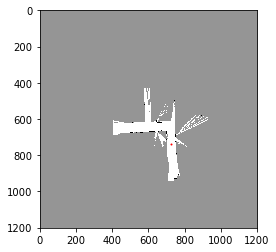

i: 6350
c_array
(100,)
[-401.  -51. -580.  104. -366. -167.   56. -377.  174. -624. -225.  135.
 -254. -641.  128. -254. -470. -570. -583. -621. -192. -570.  162. -603.
 -165. -579.    2. -383. -374. -382.  158.  -86. -643. -144. -150. -582.
 -425. -573. -561. -427.   92. -148. -204. -496. -551. -576. -584. -584.
 -579. -248.   99. -639.  166. -582. -634.  171. -564.  -73. -607.  161.
 -614. -246. -631. -190. -415. -290.  -39. -481.  195. -560. -584.  172.
 -524. -262. -591.  195. -239. -296. -201.   96. -565. -563. -224.  166.
 -423.  172. -191. -236.  -45. -620.  -37.  164. -191.  101.  183. -622.
 -615.  168.   58. -572.]
np.max(c_array)
195.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.04833892  6.1976813   0.19500973]
particle weights
[  7.23531520e-260   7.28662000e-108   0.00000000e+000   1.50719976e-040
   1.14753072e-244   3.05046623e-158   2.14800697e-061   1.91657148e-249
   3.79126856e-010   0.00000000e+000   1.97372331e-183   4.37824193e-027
   5.0

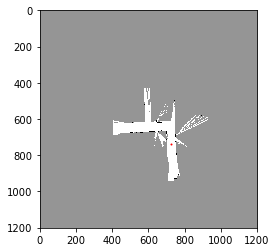

i: 6400
c_array
(100,)
[-267. -553. -581. -518. -658. -623.  194. -609. -562. -552.  173.   98.
 -169. -523. -565. -554. -422. -640. -103.  -99.  177.  -47. -593. -473.
 -537. -491. -626.   -2. -514. -586. -377.  132.  218. -268. -257.   71.
 -426. -327. -632. -579. -608. -522. -340. -557. -500. -622. -632. -230.
   43.  191.   74.  119. -639.  140.  144. -589. -140. -633. -549. -620.
 -605. -243. -376. -594.  -58.  234. -325. -209. -481.   34. -161. -562.
 -606.  -68. -571.  191.   61.  129. -361.  -70. -610. -295. -137.  197.
 -585.  217. -371.   47. -383.  212. -583. -561.   85. -581.  123. -560.
 -212. -619. -610.  177.]
np.max(c_array)
234.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.0519639   6.18313359  0.17061123]
particle weights
[  2.62098478e-218   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.24835360e-018   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.22133979e-027   8.62879983e-060
   9.5

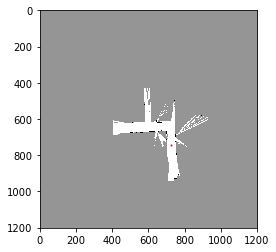

i: 6450
c_array
(100,)
[-591.  -94. -463. -139. -525. -640. -628.   88. -141.  -52. -521.  256.
  -93. -568. -343. -226. -113.  235.  226.    1. -644.  117.  277.   94.
 -183. -562. -185. -601. -778. -414.  171.  262. -634. -645. -564. -291.
 -587.  204. -591. -637. -614.   14. -599. -144.  232. -648.  194.  -20.
 -223.  139. -515. -591. -593.  249. -620.  137. -180. -592. -596. -514.
 -656.  265. -203.  257.  267. -548. -226.  106. -582. -532.  268.  252.
 -622. -217.  245. -609. -591. -565. -632. -568. -569. -603.  198.  223.
  -47. -216. -428. -224. -591.  203. -399. -299.   30. -223. -560. -480.
  217.  217. -592. -561.]
np.max(c_array)
277.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.97539076  6.18987764  0.15702835]
particle weights
[  0.00000000e+000   7.52785257e-162   4.94065646e-322   2.15486178e-181
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.28450971e-083
   2.91628830e-182   1.30930053e-143   0.00000000e+000   7.58123172e-010
   2.0

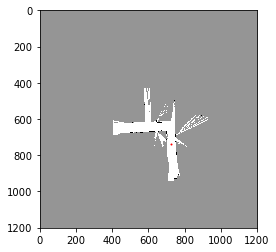

i: 6500
c_array
(100,)
[ 219.  205. -585. -276. -509. -615.  142.  229. -485.  106.   49. -130.
 -585. -628. -260. -594.  208.  221.  178. -541. -191. -329.  151. -558.
  221. -562. -552. -646. -544. -592.  -34. -574. -580. -147. -595.  202.
  204.    0. -577.  193. -363.  230. -559. -347. -614.  200.   12. -595.
 -628. -188. -550. -581. -232.  -66.  225. -245. -111. -580.   -8. -577.
  125. -651. -635. -441. -572. -558. -210. -551. -558.  219.  175. -499.
 -551. -586. -588.   68. -483. -552. -634. -575. -566. -541.  164. -568.
 -589. -327. -595.  197. -570. -536. -200.  113.  -40. -501. -600. -137.
 -583. -588.  235. -306.]
np.max(c_array)
235.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.12773045  6.25824145  0.17271753]
particle weights
[  1.11502220e-007   9.27172978e-014   0.00000000e+000   1.17900316e-222
   0.00000000e+000   0.00000000e+000   4.04211259e-041   2.45599983e-003
   2.01357705e-313   9.37577243e-057   1.64900354e-081   3.00960381e-159
   0.0

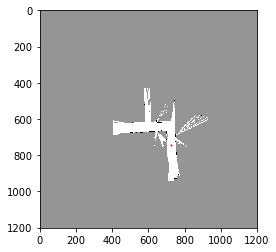

i: 6550
c_array
(100,)
[-649.  162.  152. -623. -591. -659. -632. -138.  161. -650. -398. -364.
 -575. -570.  192.  113.   82. -566. -143. -596. -524.   93. -616. -581.
 -144. -643.   30. -623. -518. -579. -569. -634. -584. -181. -582. -604.
 -134. -522. -283. -470. -567. -544. -140. -603. -394.  107.  173. -613.
 -291.  181.   29. -573. -290. -572.  197. -476. -204. -167. -623. -669.
   59. -568. -210. -280.  164. -584.  187. -582. -583.  106. -580. -540.
 -529. -286.  158.  160. -129. -636.  -50.  101. -564. -449. -581. -413.
 -590.  136.   -4. -646.   93.  184. -161. -591. -371.  -59.   23.  176.
 -133.  137. -609. -137.]
np.max(c_array)
197.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.69065924  6.26569041  0.17147398]
particle weights
[  0.00000000e+000   6.26262037e-016   2.84322525e-020   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.22412236e-146
   2.30388928e-016   0.00000000e+000   3.90702527e-259   2.27959977e-244
   0.0

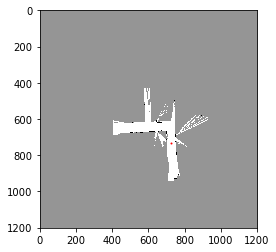

i: 6600
c_array
(100,)
[-287. -264. -636. -156. -655.  -53. -365. -172. -594. -332. -651. -659.
 -218.  231.  180. -562. -752.   92. -679.  170. -152. -201. -527.  243.
 -437.   -3. -401. -665. -649. -436. -152.   65. -191. -525.   -3.  240.
 -363. -640. -328. -357. -594. -328. -276. -290. -653. -214. -602. -278.
 -623. -644. -471. -551.  236.  175. -229.  -47.  -54.  225.  232. -664.
 -215.  -63. -528.  146. -105. -659. -139. -571. -661. -657.  146. -389.
 -279.  182. -348. -754.  -33.  142.   98. -525. -507. -105. -635. -644.
 -578. -672. -627. -117. -667. -389. -642.  258. -398. -378. -322. -681.
  239.  113.  137.  127.]
np.max(c_array)
258.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 6.8872387   6.25451631  0.11166766]
particle weights
[  2.03942257e-237   1.98737721e-227   0.00000000e+000   1.59251800e-180
   0.00000000e+000   8.59836716e-136   2.71980415e-271   1.79214291e-187
   0.00000000e+000   5.83788499e-257   0.00000000e+000   0.00000000e+000
   1.8

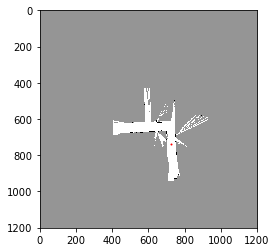

i: 6650
c_array
(100,)
[-617. -169. -227. -204. -464.   78. -190.  177. -621. -405. -228. -150.
 -318. -223. -604. -391. -593. -264. -621. -605. -535. -562. -341. -412.
 -448. -593. -577. -576. -103.  175. -372. -545. -390. -621.  -43. -567.
  198.  193. -169. -273. -545. -580.  148. -331. -324. -301. -529. -399.
 -367. -190. -558. -652. -584. -583. -568. -495. -448. -468. -330. -615.
 -563. -311. -499. -570. -547. -336. -326. -598. -573. -295. -534. -211.
 -182. -446. -249. -446. -597. -561. -587. -166.   43. -539.  -72. -560.
 -171.  -62. -355. -307. -195.   -4. -458. -311. -233. -560. -425. -165.
 -618. -263.  -39. -576.]
np.max(c_array)
198.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.53132415  6.21082033  0.22143054]
particle weights
[  0.00000000e+000   4.08327568e-160   2.64197529e-185   2.57455299e-175
   3.11987031e-288   7.61632964e-053   3.09616846e-169   7.53181147e-010
   0.00000000e+000   1.31072316e-262   9.71928394e-186   7.28792439e-152
   7.9

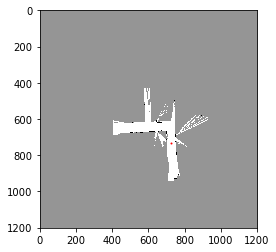

i: 6700
c_array
(100,)
[ 136. -656. -650.   18. -622. -362. -664.   90. -696. -363. -165. -598.
  -39.  210. -433. -290. -626. -574. -618. -570. -490. -574. -158. -663.
 -673.   67. -618. -707.  -51. -196. -325. -622.  104. -126.  199. -197.
 -522. -604. -344. -168. -189.  166. -579. -606. -594. -668. -611.   97.
 -596. -569. -376. -625. -580. -607. -625. -447. -158. -156. -586. -552.
 -161. -526. -676. -640. -606. -618.   98.  100. -215. -166. -662. -266.
 -594.  128.  112.   40.   18. -281. -711. -649.  199.  140.   34. -686.
 -633.  163.  162.  188. -370. -614. -281. -612.  204. -454. -100. -662.
 -605.  125. -173.  177.]
np.max(c_array)
210.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.52148883  6.2817925   0.23744689]
particle weights
[  7.26304428e-033   0.00000000e+000   0.00000000e+000   4.11499988e-084
   0.00000000e+000   3.82354939e-249   0.00000000e+000   7.64843402e-053
   0.00000000e+000   1.40660521e-249   1.37556032e-163   0.00000000e+000
   7.2

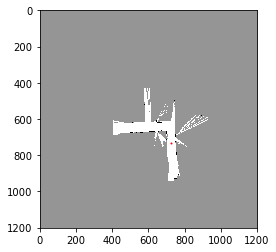

i: 6750
c_array
(100,)
[-696. -339.  -42. -282.  221.  188. -707.  230.  -46. -388.  300. -625.
 -185.  -38. -107. -661. -336. -686. -143. -312. -233.  278.   51. -656.
   93.   69.  186. -322.  205. -705.   -8. -651. -664.    3.   51. -698.
  -85. -396. -645. -701.   30. -604. -527. -247. -454. -289.  228. -149.
 -658. -224. -362. -706.  -51. -377. -689. -266. -655. -286.  191. -327.
  291. -484. -484. -658.  221. -576.  218. -313. -690. -692. -476. -680.
  -59. -125. -231. -695. -538.   -1. -505. -126. -223. -184.   33. -294.
 -149. -118. -222. -121. -245. -662. -162. -566. -591. -521. -286.  -58.
   15. -278. -480.  187.]
np.max(c_array)
300.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 6.84258041  6.34499755  0.09201505]
particle weights
[  0.00000000e+000   3.06035967e-278   2.95960394e-149   1.74003482e-253
   4.90548934e-035   2.28541163e-049   0.00000000e+000   3.97495919e-031
   5.42070369e-151   1.60451159e-299   9.99876605e-001   0.00000000e+000
   2.3

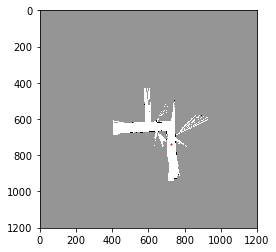

i: 6800
c_array
(100,)
[ 226. -109. -630. -582.  292. -595.  224. -588. -100.  150. -618. -668.
 -555.  332. -453. -197.  118. -475. -652. -354.  299.  174. -657. -631.
 -527. -527.  157. -284.  194. -326. -676.  -97.  168. -596. -552. -597.
  281. -558. -613.   62.  144. -644. -443. -483. -248. -536. -164. -621.
 -559. -617.  197. -526.  177. -173. -592.   16. -654. -623.  103. -560.
 -404.   56.  -13.  162.  194.  321.  -91. -674. -360.  290. -123.  297.
   -2. -578. -345.  165.  302.  -92. -540. -567. -305. -520. -408. -611.
  -28. -662. -652.  304.  264. -549.  150. -559.  161. -645. -639.   85.
 -411.  277.  325. -571.]
np.max(c_array)
332.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.94261658  6.32536591  0.03022575]
particle weights
[  9.21259176e-047   2.99040761e-192   0.00000000e+000   0.00000000e+000
   4.24441296e-018   0.00000000e+000   1.24678872e-047   0.00000000e+000
   2.42315238e-188   9.07823043e-080   0.00000000e+000   0.00000000e+000
   0.0

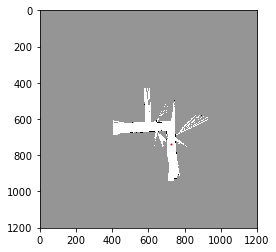

i: 6850
c_array
(100,)
[-163. -544. -140. -456. -416. -576. -498.  -41.  -69. -235. -637. -666.
 -645.  -54. -502. -434.  127. -272.  292.   -3.  241.  155. -576.  294.
  161.  165. -577. -252. -602. -162.   89. -193. -240.  -93.   10. -593.
 -247.  195.    1.   54.   26. -581. -314.  -86. -143. -545. -596. -146.
 -203. -272.  215. -660. -618. -590. -599. -107.  195.  -87. -386. -311.
 -608. -321. -402. -646. -164. -526. -383.  -16. -121. -600.  211.  -47.
 -203.  316.  101. -238.  302. -115.  -85. -593.  331. -679. -307. -557.
 -110. -100. -352.  106. -208. -471. -167.   53. -190. -559.  -73.  188.
 -444.  247. -627.  171.]
np.max(c_array)
331.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 6.92128731  6.28747333 -0.0546026 ]
particle weights
[  2.87425838e-215   0.00000000e+000   2.80090830e-205   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.76982671e-162
   1.91516901e-174   1.54640452e-246   0.00000000e+000   0.00000000e+000
   0.0

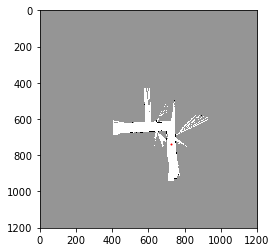

i: 6900
c_array
(100,)
[-685.  267. -602. -174. -572. -583.  271.  274.  201.  -11. -595. -590.
  -14.  255. -647.  110. -604. -588.  204. -355. -323. -457. -601. -586.
   18. -408. -499. -507. -548. -399.  338. -657. -279.   25. -276. -160.
 -320. -581.  284.  -45. -508.  177. -608. -337.  365. -539. -570.  333.
 -185. -176. -669. -505.  363. -200. -548. -506.  338.  372.  226.   89.
 -611. -615.   82. -658. -617. -404.  247. -538.  213. -548.  172. -546.
   73. -575.  200. -524. -538. -519. -387.  118.  147.   76.  273. -450.
  188. -252. -409. -674. -541. -475. -366.  -24.  321.  261.  133. -622.
 -605. -100. -192.  -21.]
np.max(c_array)
372.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 6.94340294  6.26869573 -0.03482161]
particle weights
[  0.00000000e+000   2.50397513e-046   0.00000000e+000   7.49485943e-238
   0.00000000e+000   0.00000000e+000   1.36712410e-044   2.74594216e-043
   5.43493314e-075   4.62129872e-167   0.00000000e+000   0.00000000e+000
   2.3

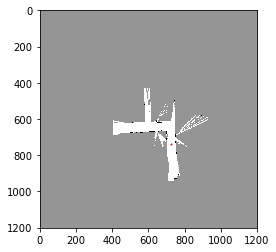

i: 6950
c_array
(100,)
[ -92. -601.  122. -576. -565. -559.  281. -179. -475. -660. -406. -647.
 -366.  -87. -563.  -25. -655. -694. -524.   89. -578.  272. -513.   80.
 -472. -689.  215.  350. -488. -273. -632. -156. -651.  338. -625.  214.
 -563. -619. -573. -395. -308. -550. -663. -108.  146. -621. -145. -455.
  196.  344. -532.  237. -552. -203. -613.  248. -630. -399.  -54. -638.
 -674. -496.  347.  263. -624.  359.  369. -618. -552.  228. -556.   19.
  349. -698. -611. -654.  143.  214. -596. -186. -588. -620. -666. -631.
 -676.  303. -605. -602.  228. -584. -236. -222. -705. -592.  100.  263.
 -550. -648. -418. -525.]
np.max(c_array)
369.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.04211952  6.31224566 -0.0514904 ]
particle weights
[  6.16913285e-201   0.00000000e+000   5.36096843e-108   0.00000000e+000
   0.00000000e+000   0.00000000e+000   6.05432698e-039   1.01532294e-238
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.2

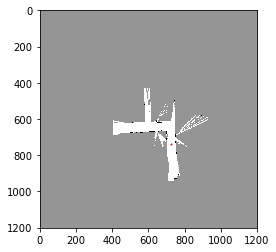

i: 7000
c_array
(100,)
[ 216. -545.   24. -560.   35. -583. -569. -545. -549. -124. -568. -127.
 -588. -595.  268.  203. -598. -595. -705. -562. -545. -221. -549. -640.
    5.   49. -626.  -97.  225.   70.   17. -177. -557.  234. -616. -155.
 -355. -593. -538. -578. -575. -524. -538. -301. -540.  -25. -170.  221.
 -568. -575. -561. -637. -689. -518. -669.  222. -638. -642. -505.  -96.
 -367. -631.  154. -579. -620. -327. -524.  135. -659. -596. -544. -499.
 -161.   86. -150.  198. -697.  119.  224. -583. -471. -719.  264. -147.
 -524. -464. -484. -555.  250.  155. -498. -138. -445. -198.  244. -343.
 -241.  222. -571. -169.]
np.max(c_array)
268.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.21959784  6.33498975 -0.05501583]
particle weights
[  2.56333000e-023   0.00000000e+000   1.05746011e-106   0.00000000e+000
   6.33145168e-102   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.60635603e-171   0.00000000e+000   2.79124031e-172
   0.0

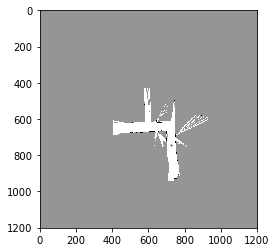

i: 7050
c_array
(100,)
[ 158. -502. -560. -618. -672. -496. -606. -603. -582. -570. -542. -318.
 -584. -622. -563.  111. -598. -336.  292.  -55.  149.  -68.  192.   19.
  208.  304. -415. -599. -559. -600. -623. -604. -398. -579.    0.  282.
 -600.  273.  327. -676. -327.  281. -648. -632. -596. -609. -498. -597.
 -582.   -7. -611. -255. -418.  151. -614.  301. -629.  253. -133. -597.
  -56. -194. -283.  159. -581. -504.  338. -449. -604.  150. -639. -587.
 -600. -571. -611. -603. -666.  249. -306.  310. -586. -148.  314. -584.
  328.  324.  333. -587. -595. -607.  232. -589.  280.  302.  304. -563.
 -583. -171.  329. -528.]
np.max(c_array)
338.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.15594393  6.15463609 -0.05981009]
particle weights
[  6.66801303e-079   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.25841259e-285
   0.0

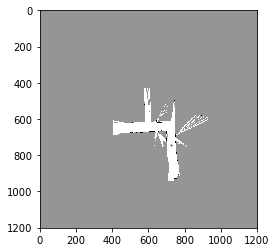

i: 7100
c_array
(100,)
[ 182. -563. -542. -569.  163.  171.  121. -252.  191. -343.  -72.  -56.
 -660. -359. -386. -624. -560. -574. -595.  161. -577.  233.  197. -557.
 -607. -406.  176.   86.  196. -278.  182. -510.  226. -553. -606. -553.
  -90. -637. -550. -575.  232. -652.  171. -551. -161.  219. -454. -198.
 -409. -545. -566.  203. -271. -610.  144. -517.  -96.  164. -704. -662.
 -597.    9.  154.  -67. -606. -621. -569. -345.   -8. -575. -603. -569.
 -585. -595. -599. -571. -591. -571.  234. -475. -599. -198. -339. -343.
 -567. -614.   80. -652.  -17. -591. -607.   47.  238.  150. -630.   72.
 -672. -564. -500. -225.]
np.max(c_array)
238.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.4142665   6.29268791 -0.09150391]
particle weights
[  4.65276283e-025   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.60684830e-033   7.77090527e-030   1.49881323e-051   1.52723465e-213
   3.77017277e-021   4.60370955e-253   2.27463916e-135   2.02126950e-128
   0.0

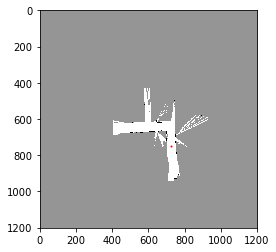

i: 7150
c_array
(100,)
[  -5.  181. -510.  -69.  -50. -643.  135. -527.  169. -582. -495. -609.
  152.  158. -512.    6. -311.  134. -612.  163.  178.   87. -526. -578.
 -768. -215. -509. -302.  163. -551.  198.  108. -565. -546. -622.  143.
 -536. -521.  -17. -617. -559.  102. -596. -592. -520. -335. -277. -562.
 -593.  144. -552. -385. -108. -459.  136.  -16. -481. -523. -527.   51.
 -612. -600. -568. -565. -628. -545. -612. -537. -584.   60.  171.  110.
 -483. -386. -557.  -63. -513. -534. -161. -531. -192. -506.   84.  133.
 -543.  171. -517. -690.   42.   96. -180. -324. -700. -144. -517. -539.
 -519. -597.   36. -608.]
np.max(c_array)
198.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.51146469  6.28155369 -0.0638391 ]
particle weights
[  6.89001480e-089   4.13993754e-008   3.30755286e-308   1.10502808e-116
   1.97227954e-108   0.00000000e+000   4.35960981e-028   1.36930634e-315
   2.54366554e-013   0.00000000e+000   1.08124478e-301   0.00000000e+000
   1.0

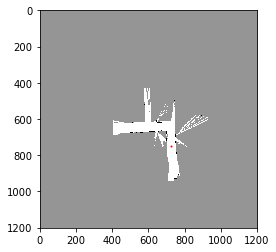

i: 7200
c_array
(100,)
[  14.  -78. -375. -251. -560. -201. -149. -101. -485. -255. -542. -587.
 -645. -534. -165. -613.  -65. -573.   35. -199. -522.  -32. -527. -535.
 -137.  -35.   39. -487. -514.  -57. -222. -382. -481.  -30. -387. -232.
 -109. -548. -573. -616. -585. -559.   69. -296. -224. -584. -536. -364.
 -167. -310. -612. -369. -580. -597. -244.  113. -535.   37. -406. -553.
 -287.  117. -282. -542. -589. -249. -620. -236. -580. -192. -545. -578.
 -175.  141. -431.  109. -412. -130. -356.   78. -245. -193. -129.   68.
  -72. -593. -250. -372. -242. -620.  -62. -673.  -23. -367. -597. -593.
 -506.  -67. -424. -153.]
np.max(c_array)
141.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.615164    6.23723299 -0.11571597]
particle weights
[  6.99199000e-056   7.75369053e-096   8.01765451e-225   5.70904011e-171
   3.62717230e-305   2.95996918e-149   1.13396656e-126   7.95674389e-106
   1.35411119e-272   1.04564717e-172   2.38160021e-297   6.81736481e-317
   0.0

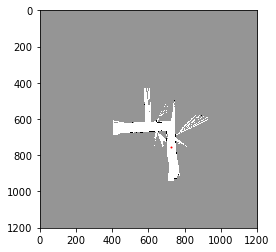

i: 7250
c_array
(100,)
[-189. -514.   62. -285. -250. -594. -538. -295. -570. -546. -679. -244.
  -70.  -39.   -2.   70. -559. -385.   29. -463. -130. -179. -495.   56.
 -602. -515.   87. -130.   77. -626. -153. -530. -259.  104.   98. -120.
 -580. -364. -551. -420. -141.  -33.  106. -597.   48. -336. -206. -510.
 -307. -492. -529. -144. -614. -417. -242.   57. -610. -440. -593. -243.
 -328. -551. -513. -193. -250. -359. -289. -322. -578. -540. -213. -178.
   15. -486. -504.   63. -471. -584. -710. -571. -824. -620.  -35. -538.
 -570. -673. -202. -541. -450. -168.   24. -527. -600. -584. -113. -470.
   16. -535. -332.  -81.]
np.max(c_array)
106.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.83492911  6.24130377 -0.10389223]
particle weights
[  6.72783602e-129   4.81026252e-270   6.85157404e-020   1.36648584e-170
   2.16726492e-155   8.68180899e-305   1.81593882e-280   6.20383610e-175
   2.29973499e-294   6.09179609e-284   0.00000000e+000   8.74337072e-153
   3.2

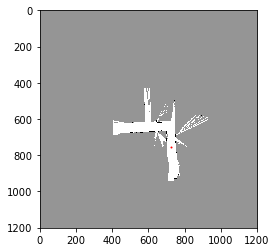

i: 7300
c_array
(100,)
[-691. -610. -596. -490. -315. -614. -822. -510. -477. -398. -602. -605.
 -133. -614. -468. -748.   10. -513. -726. -556. -691. -327. -507. -219.
 -232. -588. -568. -635. -569. -791. -397. -647.   43. -377. -616. -402.
 -297. -862.    5. -640. -508. -590. -202. -635. -232. -449. -479. -623.
 -715. -613. -560. -448. -605. -254.   29.    6. -633. -579. -189. -408.
 -199. -635. -543. -592. -544. -630. -446. -613. -489. -610. -632. -600.
   22. -528. -527. -429. -192. -298. -650.    8. -633. -593. -611. -477.
 -590. -501. -296.   52. -411.   39. -604. -585. -639. -613. -600. -578.
 -529. -320.  -55. -367.]
np.max(c_array)
52.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.94859239  6.24474641 -0.02678016]
particle weights
[  0.00000000e+000   3.14049716e-288   3.77677534e-282   4.09577635e-236
   4.11027204e-160   5.75202120e-290   0.00000000e+000   8.44202426e-245
   1.81202631e-230   3.69341892e-196   9.36169010e-285   4.66091105e-286
   4.52

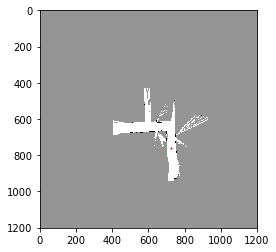

i: 7350
c_array
(100,)
[-307. -553. -241. -575. -585.  -18. -664. -342. -602. -791. -387. -371.
  -20. -402.   22. -511. -662. -505. -552.   -2. -388. -586.  -17. -492.
 -606. -762. -578. -587. -260. -226. -573. -569. -507.  -64. -584. -660.
 -112. -745. -524.  -51. -578. -811. -712.    9. -604. -849. -594.   22.
 -422. -571. -739. -238.    4. -577. -367.  -11.  -91. -492. -390. -583.
 -517.   30. -600. -325.  -98.   13. -564. -226. -664. -356. -852. -598.
 -738. -144. -654. -595. -306. -666. -675. -396.  -12. -168. -185. -716.
 -306. -505. -114. -665. -612. -113. -535. -406. -368. -248. -573. -549.
 -550. -718. -679. -234.]
np.max(c_array)
30.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.99535843  6.32013762 -0.07610632]
particle weights
[  4.39003820e-147   6.39772768e-254   2.02257253e-118   1.78462572e-263
   8.10218825e-268   1.42420849e-021   3.97501031e-302   2.76797034e-162
   3.35425548e-275   0.00000000e+000   7.92336653e-182   7.04079107e-175
   1.92

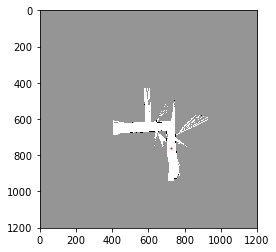

i: 7400
c_array
(100,)
[-617. -577. -218. -802.   20. -602. -641. -603. -518.  -12.    1. -589.
 -184. -648. -550. -199.  -69. -125. -612.   -4. -709. -826. -597. -628.
 -237. -305. -736. -422. -270. -545. -496.  -28. -571. -782.    9. -625.
 -538. -839. -736. -418. -546.   25.   20. -621. -741. -584.   -3. -671.
 -547. -574. -142. -708. -647. -549.  -93. -560. -274. -634. -582. -582.
 -591. -591.  -19. -564. -476. -588.   20. -479. -613.  -68. -615.   18.
 -549.  -94.  -17. -306. -779. -196. -634. -135. -597. -610. -546. -596.
 -765. -593. -531. -107.   10. -582. -422. -650. -570. -577.  -82.    4.
 -150. -746. -569. -607.]
np.max(c_array)
25.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 8.18917953  6.36758728 -0.06233552]
particle weights
[  1.49232434e-279   3.51271164e-262   2.86656308e-106   0.00000000e+000
   6.59854520e-003   4.87843420e-273   5.63372518e-290   1.79467565e-273
   1.47576407e-236   8.35650687e-017   3.69703055e-011   2.15828462e-267
   1.67

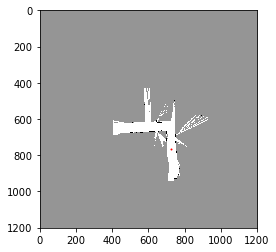

i: 7450
c_array
(100,)
[-494. -586. -481.   21.  -27. -885. -650. -846.  -62. -728. -793. -100.
 -467. -391. -725. -553. -555. -398. -634. -168.   25. -141. -608. -164.
 -537.  -89. -389.    6. -531. -155.  -35. -497. -512. -597.   27.  -36.
 -213. -894. -471. -403.  -36. -576.   14. -594.  -29.  -52. -513. -691.
   25. -147. -558. -586. -637. -601. -318. -617. -643. -577.  -91. -445.
   37. -519.  -60. -217. -589. -869. -603. -575. -855.  -31.  -22. -806.
 -745. -366. -289. -719.   35. -558. -570.   28.   13. -406. -578. -603.
 -579.  -71. -439.   -3. -515. -496. -426. -580. -877. -546.  -31. -517.
 -435. -174.  -84. -320.]
np.max(c_array)
37.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 8.05086261  6.38887386 -0.06449801]
particle weights
[  2.15991501e-231   2.39521403e-271   9.55575326e-226   9.91048349e-008
   1.41240651e-028   0.00000000e+000   3.84147035e-299   0.00000000e+000
   8.90538797e-044   0.00000000e+000   0.00000000e+000   2.79551954e-060
   1.14

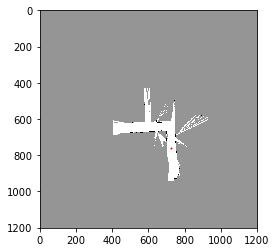

i: 7500
c_array
(100,)
[-601.   46. -301. -709. -142. -578. -884. -533. -653. -587. -597. -812.
 -580. -575. -356. -754. -356. -514. -762. -533.  -54. -517. -503. -709.
 -378. -225. -546. -494. -183. -630. -291. -799. -554.  -31. -370. -586.
 -706. -587. -849. -570. -789. -575.  -75.   54. -572. -421. -526. -675.
   48.  -33. -489.  -63. -689.  -14. -596. -485.   45. -519. -835. -212.
   65.   40. -510. -158. -516. -543. -767. -110. -540. -434. -820. -369.
 -515. -560. -647.   60. -625. -597. -521. -577. -493. -535. -538. -515.
   52. -589. -558. -717.   52. -568. -683. -648. -318. -483.   45. -620.
   26. -378. -540. -522.]
np.max(c_array)
65.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[  8.22930451e+00   6.53977936e+00  -5.38936196e-03]
particle weights
[  5.71412105e-290   5.56518016e-009   1.10992596e-159   0.00000000e+000
   1.25347775e-090   5.56829865e-280   0.00000000e+000   1.94524454e-260
   1.49154506e-312   6.87182646e-284   3.11980439e-288   0.000000

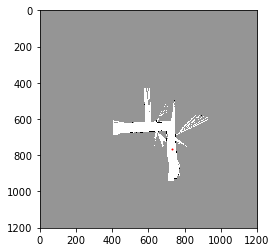

i: 7550
c_array
(100,)
[-562. -629. -539. -315.  -80. -323. -620. -144.   64.   55. -554. -343.
 -852. -539. -607. -404. -854. -464. -714. -556.  -34. -532. -230. -655.
   23. -783. -555. -538. -163. -431.   29. -579. -841. -590. -635. -753.
 -747.   70. -112.   56. -605.  -25. -571. -208. -462.   45.  -85. -766.
   65. -635. -673.  -27. -813. -784. -359.   -9. -578.   65. -179. -560.
 -823. -550. -180. -319. -554. -734. -794. -547.   46. -649. -784. -746.
 -364. -567. -819. -557. -536. -547. -531. -835. -459. -718.   57. -837.
   82. -504.   61. -567. -546. -128. -794.   56. -496.    4. -572. -534.
 -394.   58. -597.   38.]
np.max(c_array)
82.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 8.10330786  6.61204889  0.01234328]
particle weights
[  2.06229573e-280   1.64672339e-309   2.00966666e-270   3.84669695e-173
   4.40850381e-071   1.29042307e-176   1.33435379e-305   7.07040642e-099
   1.52298847e-008   1.87951708e-012   6.14761693e-277   2.65976018e-185
   0.00

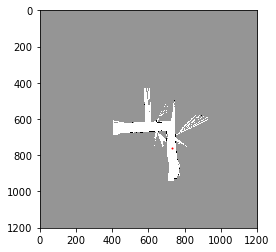

i: 7600
c_array
(100,)
[-781. -384. -209.    8.   19.   21. -531. -290. -308. -857. -447. -571.
 -811. -482. -561.   -3.   -1. -383.   15. -554.  -95. -373.   20.   15.
 -556. -725.   -2. -717. -584. -108. -132.   17. -688. -524.  -62. -592.
 -643.   10. -785. -572. -820. -570.   18.  -33. -762. -561.   12. -662.
 -293. -556. -769. -807. -157. -236. -382.   12. -561. -586. -549.   24.
  -14. -427. -109. -404. -488. -853. -455. -554. -586. -117.   22. -510.
 -590. -772. -574. -479. -243.  -49.   23.  -33.   20. -310. -750. -565.
   21. -314. -572. -669. -567. -763. -356. -777. -210. -738.   16.    1.
  -83. -589. -539. -184.]
np.max(c_array)
24.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.60082799  6.51608429  0.02104839]
particle weights
[  0.00000000e+000   3.89340406e-178   3.90718352e-102   6.81971747e-008
   4.08324730e-003   3.01713434e-002   5.61100476e-242   2.59424373e-137
   3.95102795e-145   0.00000000e+000   1.69737233e-205   2.38375360e-259
   0.00

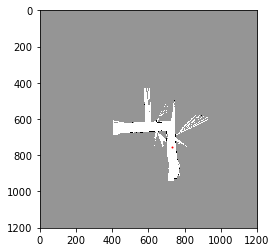

i: 7650
c_array
(100,)
[-343.  -87. -321. -130. -341.  -55. -565. -274. -167. -558. -569. -505.
 -315. -339. -362. -564. -486.  -46. -488. -508.  -27. -547. -574. -293.
 -414. -217. -371. -673. -311.  -57. -534. -578. -644. -221. -375. -174.
 -542. -352. -198. -121. -532. -633. -390. -319.  -88. -674. -430. -538.
 -558. -337. -280. -525. -398. -603. -513. -585.  -59. -264. -544. -516.
 -643. -506. -296. -524. -173. -272. -151. -785. -517. -504. -149. -760.
 -400. -326. -516.  -69. -652. -437. -579. -541. -318. -201. -580. -304.
 -271. -149. -558. -204. -386. -756.  -33. -814. -494. -376. -551. -530.
 -424. -684. -223. -179.]
np.max(c_array)
-27.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.68594038  6.49814385 -0.04653853]
particle weights
[  5.77921085e-138   8.73485916e-027   2.07179672e-128   1.84753717e-045
   4.27029132e-137   6.89730336e-013   2.23096911e-234   5.34795558e-108
   1.57651227e-061   2.44655470e-231   4.08616246e-236   2.54778321e-208
   8.35822452e-126   3.155342

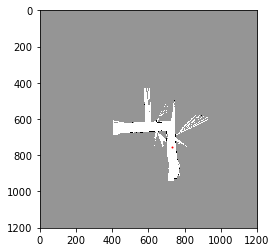

i: 7700
c_array
(100,)
[-588. -613.  -75. -575.  -53. -453. -456. -375. -327. -505. -499. -342.
 -534. -317. -517.  -75. -143. -534. -460. -387.  -63. -268. -109. -161.
 -544. -426. -757.  -70. -345. -646. -326. -141. -584.  -89. -566. -725.
 -457. -645.  -57.  -83. -504.  -73.  -62. -387. -612. -523. -568. -177.
 -385.  -58. -630.  -52. -372. -526. -517. -593.  -94.  -52.  -70.  -44.
  -63. -523. -475. -540.  -83. -120.  -70. -154. -203. -420. -324. -649.
 -181.  -47. -602.  -70. -653. -575. -150. -675.  -63. -540. -592.  -53.
 -314.  -54. -524. -579. -545.  -93. -689. -561. -794. -535. -523.  -53.
 -619. -263.  -62. -159.]
np.max(c_array)
-44.0
xy_w_scan shape
(2, 1078)
particle states
[ 7.10015595  6.45026811 -0.06236308]
particle weights
[  5.27533515e-237   7.32635584e-248   3.27581428e-014   2.33387892e-231
   1.17435087e-004   2.24908108e-178   1.11975154e-179   1.68645478e-144
   1.18334078e-123   5.87072928e-201   2.36842123e-198   3.61986692e-130
   1.49331724e-213   2.606481

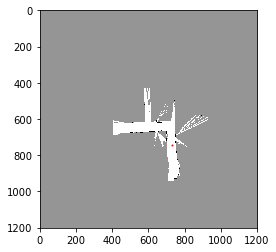

i: 7750
c_array
(100,)
[-385. -285. -529. -603. -296.  -90. -101. -357. -260. -333. -468. -372.
 -147. -357. -371. -591. -316. -609.  -86.  -73. -577. -378. -296. -440.
 -543. -534. -387. -465. -392. -436. -601.  -97. -395. -390. -447. -361.
 -496. -547. -395. -599. -195. -529. -532. -307. -106. -243. -443. -445.
 -277. -363.  -74. -404. -509.  -84. -332. -678. -143. -631. -430. -310.
 -384. -180. -375. -401. -321. -256. -497. -449. -311. -495. -429. -252.
 -426. -475. -460. -548. -355. -132.  -90. -416. -547. -501. -408. -497.
 -325. -535. -495. -469. -474.  -77. -560. -219. -317. -398. -361. -472.
 -329. -271. -457. -378.]
np.max(c_array)
-73.0
xy_w_scan shape
(2, 1078)
particle states
[ 7.13598735  6.49859722  0.02622716]
particle weights
[  2.28187225e-136   6.13393990e-093   6.60519939e-199   4.80943735e-231
   1.02447229e-097   2.98650666e-008   4.98797407e-013   3.30017386e-124
   4.41673725e-082   8.74187084e-114   2.05045068e-172   1.00953084e-130
   5.25264463e-033   3.300173

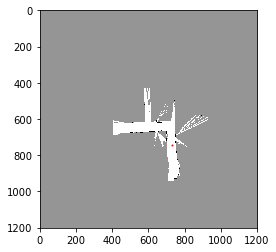

i: 7800
c_array
(100,)
[-121. -538. -560. -165. -131. -535. -134. -192. -104. -123. -685. -507.
 -121. -436. -461. -133. -453. -138. -114. -357. -329. -350. -412. -373.
 -384. -535. -499. -338. -418. -291. -141. -117. -154. -397. -123. -341.
 -331. -231. -567. -552. -123. -535. -212.  -98. -490. -279. -118. -231.
 -229. -120. -532. -595. -479. -193. -545. -551. -167. -205. -315. -286.
 -362. -507. -533. -250. -128. -152. -345. -153. -490. -163. -127. -459.
 -550. -570. -226. -231. -536. -135. -511. -106. -105. -273. -331. -501.
 -370. -381. -343. -374. -194. -215. -143. -418. -499. -554. -519. -404.
 -541. -535. -429. -449.]
np.max(c_array)
-98.0
xy_w_scan shape
(2, 1077)
particle states
[ 6.90934647  6.47061903  0.04903439]
particle weights
[  1.02237836e-010   8.10611376e-192   2.26117457e-201   7.95526121e-030
   4.64159057e-015   1.62815647e-190   2.31091187e-016   1.49521427e-041
   2.46955010e-003   1.38363865e-011   1.16821790e-255   2.35473280e-178
   1.02237836e-010   1.610088

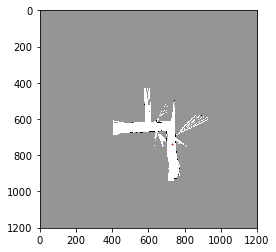

i: 7850
c_array
(100,)
[-511. -182. -427. -250. -145. -557. -146. -568. -510. -408. -289. -183.
 -560. -572. -164. -617. -206. -164. -261. -424. -175. -442. -564. -238.
 -556. -384. -577. -434. -290. -255. -277. -166. -357. -137. -381. -466.
 -285. -553. -429. -524. -335. -428. -142. -303. -175. -498. -385. -486.
 -182. -522. -275. -486. -467. -477. -441. -225. -388. -344. -368. -152.
 -228. -149. -279. -609. -335. -219. -306. -466. -642. -183. -265. -303.
 -384. -237. -470. -490. -178. -140. -143. -195. -133. -136. -507. -646.
 -525. -540. -333. -198. -578. -494. -157. -558. -174. -160. -542. -155.
 -405. -363. -217. -366.]
np.max(c_array)
-133.0
xy_w_scan shape
(2, 1081)
particle states
[ 6.90217263  6.41980799  0.02938113]
particle weights
[  6.42140662e-165   4.90359640e-022   1.94252516e-128   1.44042267e-051
   5.74659444e-006   6.76213761e-185   2.11405395e-006   1.12939199e-189
   1.74551929e-164   3.46706359e-120   1.66343239e-068   1.80393230e-022
   3.36667007e-186   2.06855

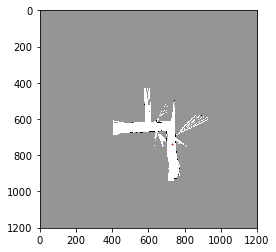

i: 7900
c_array
(100,)
[-547. -326. -261. -185. -421. -169. -521. -299. -225. -197. -261. -582.
 -574. -547. -177. -466. -569. -169. -391. -578. -597. -319. -334. -470.
 -288. -174. -195. -288. -578. -172. -234. -194. -406. -558. -291. -255.
 -464. -189. -332. -303. -171. -464. -312. -659. -336. -314. -463. -436.
 -438. -157. -532. -546. -516. -181. -643. -426. -294. -614. -161. -351.
 -458. -622. -168. -581. -205. -166. -404. -507. -432. -529. -180. -205.
 -467. -167. -205. -444. -529. -645. -588. -517. -311. -351. -290. -518.
 -537. -580. -543. -353. -536. -509. -546. -168. -483. -494. -444. -486.
 -498. -378. -494. -482.]
np.max(c_array)
-157.0
xy_w_scan shape
(2, 1079)
particle states
[ 6.81660781  6.38839093 -0.01452716]
particle weights
[  4.14169076e-170   3.94691860e-074   6.68958988e-046   6.78859841e-013
   2.17912623e-115   6.03242357e-006   8.10651515e-159   2.09995110e-062
   2.88403709e-030   4.17105902e-018   6.68958988e-046   2.61138438e-185
   7.78442713e-182   4.14169

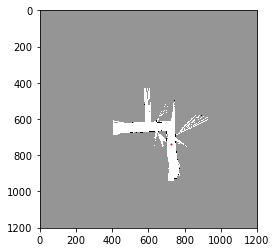

i: 7950
c_array
(100,)
[-556. -135. -478. -367. -159. -260. -579. -461. -362. -549. -132. -381.
 -181. -151. -345. -161. -374. -171. -366. -246. -352. -245. -179. -456.
 -502. -373. -325. -600. -153. -596. -638. -410. -464. -573. -161. -371.
 -517. -353. -322. -458. -419. -245. -191. -369. -376. -439. -464. -464.
 -302. -174. -162. -271. -328. -477. -157. -300. -364. -411. -340. -358.
 -570. -380. -452. -465. -452. -386. -234. -140. -178. -267. -166. -518.
 -329. -554. -374. -493. -224. -157. -533. -436. -447. -384. -404. -164.
 -594. -179. -275. -337. -472. -157. -552. -382. -175. -378. -531. -364.
 -197. -166. -169. -500.]
np.max(c_array)
-132.0
xy_w_scan shape
(2, 1081)
particle states
[  6.79881033e+00   6.42578726e+00  -1.05555867e-03]
particle weights
[  6.88493261e-185   4.74107226e-002   5.16260957e-151   8.30915334e-103
   1.78981857e-012   2.44943736e-056   7.06523497e-195   1.24702590e-143
   1.23318770e-100   7.55024539e-182   9.52269820e-001   6.90929963e-109
   4.99264179

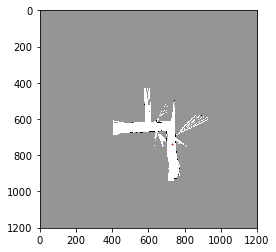

i: 8000
c_array
(100,)
[-174. -401. -150. -535. -593. -178. -181. -527. -158. -201. -237. -160.
 -555. -377. -386. -289. -148. -563. -537. -521. -274. -444. -143. -267.
 -428. -174. -477. -486. -169. -147. -507. -170. -322. -146. -465. -671.
 -147. -556. -571. -419. -320. -369. -158. -423. -240. -136. -518. -135.
 -583. -144. -141. -565. -391. -408. -435. -553. -379. -409. -442. -210.
 -442. -564. -161. -160. -333. -570. -571. -448. -600. -528. -556. -222.
 -554. -560. -162. -388. -422. -163. -625. -137. -429. -147. -306. -148.
 -325. -136. -167. -258. -384. -708. -443. -573. -444. -260. -376. -140.
 -503. -176. -155. -154.]
np.max(c_array)
-135.0
xy_w_scan shape
(2, 1081)
particle states
[  7.03203939e+00   6.45559255e+00  -4.87419920e-03]
particle weights
[  6.14002796e-018   1.59706634e-116   1.62643950e-007   1.01826867e-174
   6.58843751e-200   1.12458535e-019   5.59898076e-021   3.03541612e-171
   5.45609670e-011   1.15403595e-029   2.67681273e-045   7.38402392e-012
   2.09880816

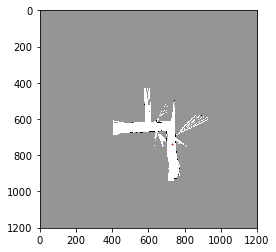

i: 8050
c_array
(100,)
[-465. -524. -210. -196. -443. -335. -139. -413. -413. -153. -448. -354.
 -165. -155. -213. -163. -134. -323. -426. -548. -569. -290. -172. -179.
 -135. -389. -530. -283. -196. -395. -633. -139. -482. -421. -384. -538.
 -180. -575. -200. -141. -272. -313. -496. -136. -202. -415. -347. -154.
 -134. -409. -426. -182. -556. -556. -346. -219. -629. -486. -132. -212.
 -170. -557. -483. -205. -566. -516. -445. -412. -523. -647. -211. -294.
 -602. -502. -569. -174. -479. -344. -263. -586. -485. -486. -484. -175.
 -136. -405. -571. -519. -163. -526. -230. -560. -138. -135. -144. -535.
 -153. -513. -752. -388.]
np.max(c_array)
-132.0
xy_w_scan shape
(2, 1081)
particle states
[  6.99788040e+00   6.39499794e+00   5.02725750e-03]
particle weights
[  1.69947862e-145   4.04521188e-171   9.44949483e-035   1.13640030e-028
   6.09248275e-136   4.88200651e-089   6.46125390e-004   6.51071621e-123
   6.51071621e-123   5.37271818e-010   4.10508259e-138   2.73528887e-097
   3.30111214

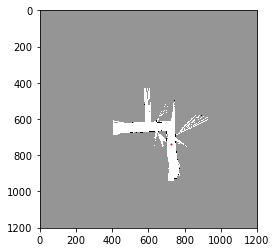

i: 8100
c_array
(100,)
[-504. -461. -466. -612. -597. -182. -481. -173. -177. -421. -334. -197.
 -577. -574. -451. -544. -515. -572. -290. -539. -506. -417. -550. -175.
 -522. -228. -193. -442. -567. -173. -464. -438. -423. -438. -500. -265.
 -577. -531. -690. -521. -242. -556. -510. -536. -223. -576. -455. -449.
 -512. -568. -542. -505. -504. -570. -354. -498. -422. -473. -175. -178.
 -197. -550. -211. -573. -378. -179. -449. -455. -199. -456. -562. -174.
 -524. -428. -548. -511. -359. -233. -417. -392. -240. -203. -204. -177.
 -603. -313. -467. -240. -184. -611. -201. -187. -192. -507. -644. -173.
 -489. -677. -425. -178.]
np.max(c_array)
-173.0
xy_w_scan shape
(2, 1078)
particle states
[ 6.85223063  6.33268695 -0.03979701]
particle weights
[  4.80120077e-145   2.26993065e-126   1.52946724e-128   5.99164152e-192
   1.95867802e-185   3.34328223e-005   4.67867578e-135   2.70908965e-001
   4.96187078e-003   5.34308232e-109   3.24647297e-071   1.02271779e-011
   9.50282405e-177   1.90869

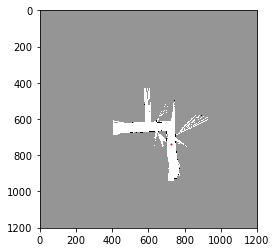

i: 8150
c_array
(100,)
[-490. -509. -587. -444. -192. -423. -565. -525. -154. -544. -388. -556.
 -450. -549. -522. -153. -367. -151. -240. -420. -411. -413. -304. -221.
 -487. -452. -436. -394. -468. -439. -165. -163. -501. -496. -305. -579.
 -238. -389. -565. -493. -130. -180. -278. -486. -579. -547. -150. -422.
 -207. -257. -160. -434. -693. -566. -169. -340. -806. -716. -566. -343.
 -361. -488. -562. -171. -557. -391. -402. -177. -528. -539. -437. -166.
 -365. -460. -170. -412. -445. -506. -418. -508. -575. -183. -419. -241.
 -158. -160. -460. -511. -704. -753. -532. -565. -494. -502. -158. -173.
 -242. -275. -361. -523.]
np.max(c_array)
-130.0
xy_w_scan shape
(2, 1078)
particle states
[ 7.73485565  6.43307764 -0.04091321]
particle weights
[  4.50802705e-157   2.52575579e-165   3.36838534e-199   4.28087632e-137
   1.18506486e-027   5.64568705e-128   1.20753679e-189   2.84236369e-172
   3.77513453e-011   1.59251852e-180   8.95413561e-113   9.78477194e-186
   1.06112315e-139   1.07303

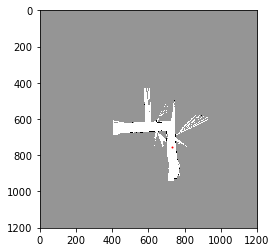

i: 8200
c_array
(100,)
[-511. -597. -481. -432. -535. -129. -647. -508. -517. -579. -453. -517.
 -503. -685. -436. -506. -490. -628. -533. -661. -639. -678. -597. -593.
 -476. -513. -120. -439. -281. -450. -509. -121. -122. -537. -504. -851.
 -126. -589. -272. -488. -129. -111. -508. -476. -449. -477. -526. -524.
 -150. -579. -593. -735. -522. -772. -420. -507. -122. -834. -540. -529.
 -244. -536. -115. -503. -344. -167. -434. -439. -466. -523. -289. -528.
 -540. -171. -133. -548. -486. -260. -467. -526. -467. -594. -793. -120.
 -447. -396. -599. -469. -273. -302. -292. -355. -440. -491. -219. -441.
 -167. -858. -421. -481.]
np.max(c_array)
-111.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.50552462  6.44186815  0.03996219]
particle weights
[  1.88012113e-174   8.41124702e-212   2.00918667e-161   3.83221531e-140
   7.09771024e-185   1.49512643e-008   1.62231914e-233   3.77632424e-173
   4.66035435e-177   5.52282220e-204   2.90580042e-149   4.66035435e-177
   5.60456211e-171   5.09267

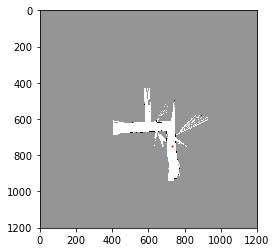

i: 8250
c_array
(100,)
[-626. -385. -482. -194. -564. -587. -299. -132. -494. -505. -561. -437.
 -125. -140. -593. -746. -538. -397. -240. -138. -471. -264. -543. -541.
 -558. -459. -525. -439. -545. -430. -628. -421. -591. -541. -256. -347.
 -612. -530. -355. -129. -324. -472. -524. -447. -373. -412. -361. -133.
 -501. -251. -405. -629. -578. -174. -542. -363. -384. -243. -495. -205.
 -131. -547. -541. -542. -617. -163. -397. -391. -339. -538. -362. -612.
 -350. -283. -415. -214. -541. -424. -278. -689. -542. -151. -427. -337.
 -704. -127. -372. -127. -543. -558. -534. -541. -557. -268. -132. -432.
 -550. -542. -803. -140.]
np.max(c_array)
-125.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.19153691  6.46278193 -0.04027132]
particle weights
[  2.02607481e-218   9.36754127e-114   6.99940092e-156   8.35356119e-031
   1.70967419e-191   1.75444707e-201   2.09387648e-076   7.04903288e-004
   4.30058056e-161   7.18270097e-166   3.43397240e-190   2.44518969e-136
   7.73020319e-001   2.36468

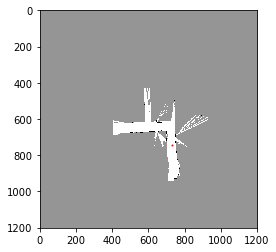

i: 8300
c_array
(100,)
[-235. -527. -457. -352. -279. -500. -577. -163. -122. -200. -519. -130.
 -439. -155. -509. -124. -502. -291. -653. -381. -149. -444. -477. -343.
 -136. -580. -130. -112. -343. -483. -579. -383. -529. -592. -445. -460.
 -532. -370. -280. -126. -530. -120. -498. -124. -338. -399. -509. -431.
 -425. -530. -414. -480. -423. -427. -484. -182. -268. -240. -445. -129.
 -127. -506. -544. -278. -518. -509. -447. -405. -230. -380. -126. -454.
 -122. -629. -299. -406. -347. -341. -307. -359. -167. -400. -109. -107.
 -719. -228. -537. -501. -523. -446. -477. -434. -132. -156. -327. -520.
 -433. -474. -260. -133.]
np.max(c_array)
-107.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.31566021  6.4166811   0.01937829]
particle weights
[  2.25222220e-056   3.45638825e-183   8.69433266e-153   3.46862103e-107
   1.75248388e-075   1.83896529e-171   6.66650831e-205   4.18614177e-025
   2.67847558e-007   3.57205471e-041   1.03033482e-179   8.98528456e-011
   5.70869614e-145   1.24787

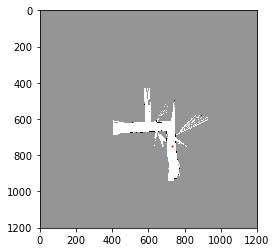

i: 8350
c_array
(100,)
[-303. -450. -523. -246. -406. -266. -442. -546. -649. -529. -351. -304.
 -632. -453. -484. -389. -278. -602. -171. -162. -187. -263. -505. -244.
 -393. -577. -524. -473. -274. -449. -378. -530. -155. -432. -339. -508.
 -507. -427. -531. -166. -364. -334. -427. -512. -462. -317. -161. -681.
 -485. -427. -366. -519. -533. -266. -315. -375. -145. -162. -460. -453.
 -433. -438. -378. -444. -443. -481. -418. -694. -290. -340. -685. -148.
 -260. -248. -446. -466. -485. -297. -330. -508. -416. -367. -463. -454.
 -396. -171. -233. -470. -372. -227. -503. -518. -628. -162. -522. -427.
 -443. -314. -389. -408.]
np.max(c_array)
-145.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.47988558  6.43248365 -0.05490916]
particle weights
[  2.29272391e-069   3.30417409e-133   6.53981920e-165   1.30357862e-044
   4.24639241e-114   2.68687580e-053   9.84960414e-130   6.71108375e-175
   1.24297108e-219   1.62105911e-167   3.26750777e-090   8.43445992e-070
   3.00239076e-212   1.64505

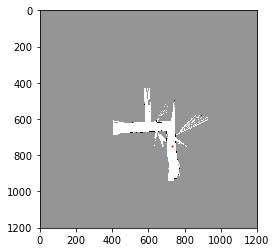

i: 8400
c_array
(100,)
[-164. -156. -162. -518. -539. -476. -426. -304. -181. -436. -357. -154.
 -437. -344. -347. -356. -490. -163. -544. -565. -266. -331. -245. -165.
 -361. -260. -556. -248. -523. -556. -193. -185. -186. -162. -548. -148.
 -322. -534. -159. -496. -157. -177. -405. -546. -159. -511. -209. -495.
 -326. -188. -171. -309. -569. -151. -428. -219. -195. -267. -159. -402.
 -558. -218. -339. -416. -337. -444. -410. -544. -465. -270. -480. -393.
 -312. -405. -423. -532. -530. -480. -486. -173. -546. -534. -395. -171.
 -372. -163. -351. -163. -177. -164. -538. -540. -432. -301. -822. -152.
 -560. -387. -444. -410.]
np.max(c_array)
-148.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.55653573  6.39093856 -0.05265726]
particle weights
[  1.05065708e-007   3.13196463e-004   7.76336414e-007   1.91079633e-161
   1.44887287e-170   3.32340018e-143   1.72308513e-121   1.66047953e-068
   4.34965489e-015   7.82279439e-126   1.59450537e-091   2.31422623e-003
   2.87784523e-126   7.05430

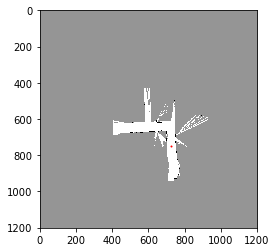

i: 8450
c_array
(100,)
[-687. -541. -164. -156. -593. -247. -297. -151. -417. -321. -348. -241.
 -337. -283. -335. -471. -517. -388. -308. -152. -615. -329. -377. -321.
 -522. -218. -299. -157. -146. -185. -167. -159. -162. -153. -152. -162.
 -520. -172. -531. -159. -177. -158. -154. -167. -164. -540. -165. -163.
 -222. -152. -161. -523. -287. -456. -247. -525. -421. -359. -161. -162.
 -541. -163. -475. -385. -415. -172. -166. -221. -150. -275. -505. -510.
 -146. -150. -387. -585. -508. -177. -152. -364. -515. -161. -162. -412.
 -160. -204. -159. -320. -526. -511. -222. -441. -603. -701. -498. -471.
 -472. -160. -344. -456.]
np.max(c_array)
-146.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.96802397  6.39920954 -0.03527593]
particle weights
[  5.41945911e-236   1.38340806e-172   7.41259000e-009   2.20966194e-005
   3.61108110e-195   6.66082435e-045   1.28470640e-066   3.27942908e-003
   9.85067652e-119   4.84993949e-077   9.11560104e-089   2.68716833e-042
   5.45788788e-084   1.54499

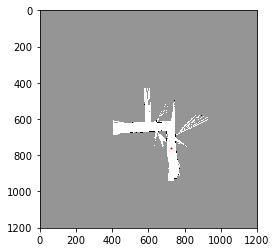

i: 8500
c_array
(100,)
[-131. -384. -126. -571. -367. -363. -849. -293. -557. -127. -498. -584.
 -432. -827. -455. -245. -501. -741. -512. -406. -134. -504. -359. -384.
 -398. -120. -488. -520. -513. -134. -111. -407. -478. -312. -128. -120.
 -498. -361. -128. -508. -408. -537. -127. -392. -115. -266. -127. -501.
 -533. -505. -503. -461. -254. -539. -395. -193. -421. -492. -329. -486.
 -415. -403. -399. -302. -287. -146. -231. -498. -514. -389. -440. -500.
 -130. -148. -330. -227. -161. -130. -477. -207. -122. -129. -472. -435.
 -227. -383. -118. -224. -126. -207. -434. -126. -116. -305. -206. -484.
 -391. -528. -245. -241.]
np.max(c_array)
-111.0
xy_w_scan shape
(2, 1081)
particle states
[  7.86258115e+00   6.40852804e+00   4.39520574e-03]
particle weights
[  2.00847072e-009   2.66907995e-119   2.98083485e-007   1.63415583e-200
   6.44715002e-112   3.52002464e-110   2.89028403e-321   8.85440610e-080
   1.96524280e-194   1.09658786e-007   8.25639850e-169   3.69373048e-206
   3.80387688

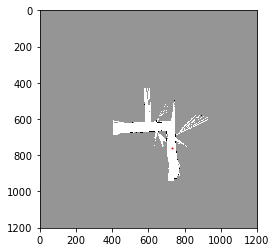

i: 8550
c_array
(100,)
[-129. -126. -370. -155. -123. -136. -454. -134. -395. -450. -637. -272.
 -593. -180. -337. -540. -500. -110. -374. -232. -501. -299. -476. -431.
 -125. -390. -561. -523. -372. -491. -118. -349. -449. -536. -313. -529.
 -483. -528. -519. -712. -303. -116. -427. -372. -395. -465. -513. -274.
 -451. -569. -456. -577. -411. -132. -110. -110. -355. -466. -322. -128.
 -381. -495. -480. -516. -126. -164. -531. -134. -488. -128. -475. -449.
 -533. -439. -462. -292. -403. -221. -134. -402. -529. -111. -307. -283.
 -248. -489. -121. -221. -118. -134. -487. -505. -423. -405. -259. -122.
 -589. -405. -267. -614.]
np.max(c_array)
-110.0
xy_w_scan shape
(2, 1081)
particle states
[  8.03262845e+00   6.43947161e+00   5.82728548e-03]
particle weights
[  1.66203066e-009   3.33827783e-008   3.59475167e-114   8.49146263e-021
   6.70511026e-007   1.51557579e-012   1.18831728e-150   1.11986745e-011
   4.99237093e-125   6.48799253e-149   3.97230169e-230   1.30776021e-071
   5.10504329

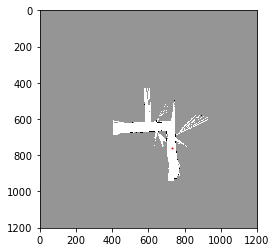

i: 8600
c_array
(100,)
[-154. -221. -581. -491. -146. -407. -202. -368. -229. -486. -409. -490.
 -265. -470. -242. -496. -317. -152. -475. -153. -149. -475. -177. -130.
 -221. -461. -202. -504. -137. -494. -465. -736. -143. -518. -352. -504.
 -263. -148. -144. -513. -146. -483. -196. -265. -486. -482. -465. -184.
 -497. -242. -499. -481. -252. -138. -129. -332. -505. -152. -700. -327.
 -155. -153. -293. -386. -405. -132. -417. -480. -493. -228. -262. -148.
 -482. -143. -769. -508. -149. -250. -350. -318. -308. -150. -351. -465.
 -543. -400. -515. -395. -403. -385. -382. -347. -490. -518. -265. -348.
 -293. -200. -223. -148.]
np.max(c_array)
-129.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.16673957  6.43008878 -0.02968734]
particle weights
[  9.79315633e-012   7.81974155e-041   3.52516066e-197   4.30211768e-158
   2.91929876e-008   1.30142386e-121   1.39568547e-032   1.12694718e-104
   2.62323105e-044   6.38490875e-156   1.76128567e-122   1.16943683e-157
   6.08464431e-060   5.67370

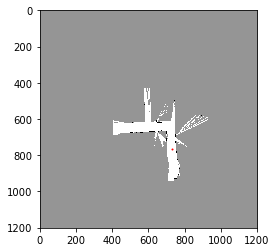

i: 8650
c_array
(100,)
[-492. -267. -529. -341. -501. -445. -475. -357. -397. -529. -252. -534.
 -360. -503. -229. -218. -462. -526. -339. -270. -466. -204. -499. -224.
 -423. -226. -326. -393. -203. -231. -296. -489. -340. -195. -297. -345.
 -467. -466. -393. -529. -355. -229. -520. -473. -441. -495. -523. -470.
 -242. -222. -396. -232. -179. -341. -408. -387. -454. -474. -366. -264.
 -325. -368. -416. -500. -223. -211. -530. -313. -336. -568. -219. -217.
 -268. -496. -504. -263. -231. -207. -299. -332. -179. -509. -467. -513.
 -577. -756. -314. -733. -209. -523. -341. -335. -520. -382. -465. -500.
 -218. -321. -374. -297.]
np.max(c_array)
-179.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.58525112  5.82860511 -0.17487406]
particle weights
[  5.81831385e-137   3.02730078e-039   4.96479492e-153   2.20426554e-071
   7.18036972e-141   1.50188885e-116   1.40541096e-129   2.48057408e-078
   1.05383574e-095   4.96479492e-153   9.89629883e-033   3.34525250e-155
   1.23500511e-079   9.71757

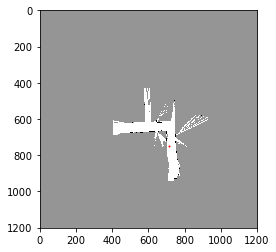

i: 8700
c_array
(100,)
[-273. -324. -169. -323. -187. -283. -212. -178. -442. -288. -445. -340.
 -195. -221. -153. -425. -176. -438. -306. -169. -273. -147. -145. -459.
 -424. -403. -428. -480. -336. -200. -339. -385. -362. -206. -278. -240.
 -433. -229. -255. -185. -433. -413. -257. -241. -443. -423. -225. -173.
 -280. -217. -168. -138. -429. -367. -434. -268. -211. -454. -183. -432.
 -405. -492. -437. -168. -210. -501. -178. -301. -406. -459. -181. -162.
 -191. -181. -173. -438. -406. -417. -285. -189. -218. -456. -423. -145.
 -586. -331. -225. -429. -180. -210. -407. -170. -286. -147. -220. -164.
 -460. -287. -143. -417.]
np.max(c_array)
-138.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.31432951  5.73629557 -0.29769103]
particle weights
[  2.32507018e-059   1.64974754e-081   3.41241768e-014   4.48447875e-081
   5.19710521e-022   1.05558023e-063   7.21771055e-033   4.21125797e-018
   9.34692211e-133   7.11244362e-066   4.65355850e-134   1.85654627e-088
   1.74343457e-025   8.90736

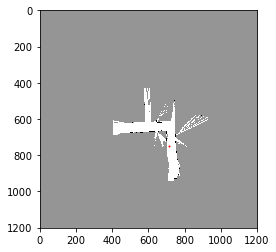

i: 8750
c_array
(100,)
[-242. -172. -183. -405. -173. -189. -147. -173. -234. -498. -266. -185.
 -180. -394. -382. -515. -151. -172. -195. -213. -480. -487. -192. -536.
 -582. -476. -340. -178. -178. -314. -180. -524. -384. -227. -493. -138.
 -217. -207. -149. -536. -149. -536. -292. -315. -376. -322. -186. -207.
 -209. -225. -493. -183. -273. -260. -232. -162. -375. -268. -328. -245.
 -439. -182. -332. -201. -245. -327. -372. -464. -256. -386. -199. -376.
 -279. -214. -104. -513. -543. -455. -214. -298. -330.  -75. -324. -293.
 -185. -211. -344. -376. -171. -172. -232. -322. -157. -383. -239. -450.
 -407. -339. -246. -297.]
np.max(c_array)
-75.0
xy_w_scan shape
(2, 1081)
particle states
[ 6.3809333   6.15908525 -0.34135529]
particle weights
[  2.97044505e-073   7.47197234e-043   1.24794646e-047   4.81749166e-144
   2.74878501e-043   3.09335001e-050   5.38018616e-032   2.74878501e-043
   8.85477188e-070   1.96532399e-184   1.12138297e-083   1.68891188e-048
   2.50656748e-046   2.884431

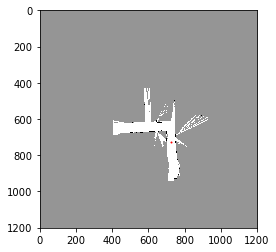

i: 8800
c_array
(100,)
[-607. -285. -556. -190. -106. -328. -238. -294.  -70. -202. -177.  -39.
 -583. -329. -282. -200. -584. -123. -427. -304. -101. -234. -186. -349.
 -378. -601.  -55. -137. -301. -112. -350. -288. -107. -134. -231.  -53.
 -115. -301. -127. -201. -254. -475. -424.  -40.  -80. -431. -585. -196.
 -273. -380. -633. -259. -204. -223. -135.  -84.  -49. -281. -104. -117.
 -319.  -57. -229.   -6. -247.  -38. -260. -391. -242. -194.  -64. -190.
  -61. -303. -230. -569.  -97.  -66. -195.  -34. -174. -140.  -96. -231.
 -529. -183. -384. -578. -193.  -43. -141. -253. -191. -312. -131. -258.
 -293.  -40. -219.  -67.]
np.max(c_array)
-6.0
xy_w_scan shape
(2, 1068)
particle states
[ 5.54573162  6.04789965 -0.42714049]
particle weights
[  9.75026403e-262   6.78952746e-122   1.37415257e-239   1.22974575e-080
   3.72007598e-044   1.43607403e-140   1.75258947e-101   8.37894253e-126
   1.60381089e-028   7.55581902e-086   5.44055988e-075   4.65888615e-015
   2.58275935e-251   5.2830211

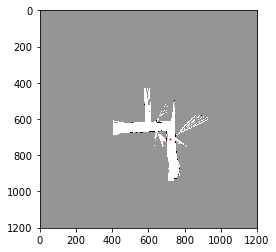

i: 8850
c_array
(100,)
[-474.   -7. -344. -468. -186. -277. -416. -467. -348. -308. -397.  -30.
 -146. -591. -164. -366. -600. -333. -377.  -62. -287. -416.  -99. -156.
 -477. -372. -255.  -36. -547. -129.    5. -340. -152. -201. -206. -407.
 -407. -372. -196. -342. -218. -161. -437. -124.   -8. -557. -146. -268.
 -433. -306. -434. -425. -105. -288.    3. -157. -468.  -26.   -4. -465.
 -354. -139.   18.  -61. -296. -434.    6. -141. -295. -418. -436. -362.
 -421. -422. -331. -457. -132. -421.  -55.    4. -290.  -78. -180. -357.
 -468. -435. -402. -461. -408.   -7. -549. -486. -466.  -53. -113.  -31.
  -30. -397.  -95. -269.]
np.max(c_array)
18.0
xy_w_scan shape
(2, 1065)
*****Updating map*****
particle states
[ 5.70931302  5.98485173 -0.51234494]
particle weights
[  2.12378603e-214   1.38878113e-011   6.10089298e-158   8.56796435e-212
   2.53467072e-089   7.64053368e-129   3.28239400e-189   2.32901418e-211
   1.11741753e-159   2.63023623e-142   5.85849233e-181   1.42515048e-021
   5.96

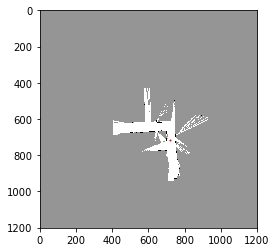

i: 8900
c_array
(100,)
[-479. -611. -315. -464. -347. -573.   67. -322. -277. -179. -220. -386.
 -624. -531. -646. -462. -186. -591.   89. -766. -573. -582. -638.  122.
   23. -394. -222. -284. -552. -429. -662. -458. -326. -108. -607. -203.
 -360. -366. -480. -599.   83. -586. -545.   46. -623. -378.  -67. -698.
 -606. -641. -677. -387. -515. -292. -662. -197. -531.   31. -360. -188.
   19. -361. -348.   73.   94.   90. -278. -336. -634. -468. -662. -230.
 -626. -608. -301. -515. -221. -256. -393.  -66. -400. -655. -542. -371.
 -582. -364. -182. -319. -191.  137.   65. -435. -515. -365.   51. -637.
 -390. -385. -119. -544.]
np.max(c_array)
137.0
xy_w_scan shape
(2, 1068)
*****Updating map*****
particle states
[ 5.80059944  5.87226471 -0.51520969]
particle weights
[  2.98262748e-268   0.00000000e+000   4.99912558e-197   9.75026105e-262
   6.33097540e-211   4.47628486e-309   3.97544852e-031   4.55861246e-200
   1.59251803e-180   5.79353434e-138   9.05461164e-156   7.31115231e-228
   0.0

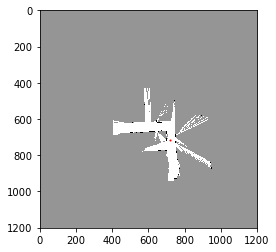

i: 8950
c_array
(100,)
[ -16. -267. -192. -545. -608. -332. -343. -623. -161. -588. -170. -115.
 -650. -672. -105. -628. -517. -430. -754. -642.    9. -196. -443. -141.
 -657. -450. -718. -453. -592. -350. -344.  -10.   50. -222. -217. -184.
 -663. -209. -581. -518. -351. -716. -263. -671. -410. -443. -416. -189.
   49.   45. -236.   71. -693. -582. -654. -566. -413. -328. -629. -490.
 -237. -339. -272. -352. -396. -271. -199. -613. -249. -644.   -4. -589.
 -162. -460. -389. -109. -665. -698. -158.   -5. -698. -447. -510.   72.
 -406.  -24. -562.   26. -384. -222. -412. -246.  -34. -372.  -60. -677.
 -300. -658. -575. -635.]
np.max(c_array)
72.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[ 5.93137552  5.88389726 -0.55448639]
particle weights
[  4.42626865e-039   4.34633115e-148   1.62259060e-115   8.02152319e-269
   3.49707127e-296   2.56437473e-176   4.28294195e-181   1.06976222e-302
   4.71343903e-102   1.69665727e-287   5.81684588e-106   4.47593800e-082
   2.01

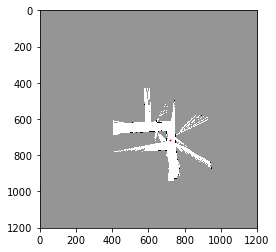

i: 9000
c_array
(100,)
[-456. -704. -393. -265. -346. -540. -194. -431. -253. -577. -672. -485.
 -623. -301. -243. -274. -654. -694. -498. -461. -341. -595. -391. -247.
 -543. -289. -665. -478. -202. -550. -630. -559. -390.   54. -212. -675.
 -371. -541. -520. -554. -427. -601. -359. -496. -597. -412. -601. -451.
 -511.  -82. -648. -442. -407. -343. -234. -403. -559. -425. -120. -655.
 -183.  -89.   43. -440. -529. -440. -127. -542. -218. -652. -470. -552.
  -80. -608. -493. -252. -687. -193. -175. -628. -200. -449. -655. -453.
 -413. -676. -454. -149. -401. -172. -581.  -92. -282. -284. -262. -127.
 -561. -570. -486. -694.]
np.max(c_array)
54.0
xy_w_scan shape
(2, 1044)
*****Updating map*****
particle states
[ 6.0750068   5.81717695 -0.51934824]
particle weights
[  3.23449866e-222   0.00000000e+000   7.41923856e-195   2.88438361e-139
   1.91513761e-174   1.06922843e-258   1.97224668e-108   2.32899751e-211
   4.69447253e-134   9.12377708e-275   5.03731037e-316   8.22748314e-235
   9.60

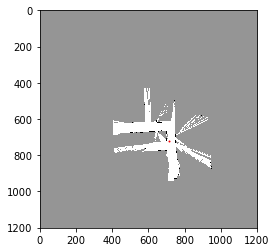

i: 9050
c_array
(100,)
[  -4. -462. -518. -459. -422. -526. -635.   69. -351. -423. -536.  -28.
 -234. -541.  -75. -458. -390. -264. -691. -403. -508. -452. -294. -256.
 -443. -267. -660. -608.  -19. -612. -338. -453. -308. -494. -657. -497.
 -615. -621.  -63. -326. -327. -642. -677. -389. -512. -661. -490. -540.
 -277. -108. -342. -452. -557. -695. -412. -503. -496. -653. -531. -481.
 -396. -382. -621. -493. -271. -377. -256. -478. -576. -636. -263. -700.
 -600. -670. -421. -527. -189. -397. -682. -485. -387. -612. -285. -367.
 -358. -476. -463. -716. -244. -127. -395. -703. -585. -695. -539. -171.
 -524. -470. -470. -480.]
np.max(c_array)
69.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[ 6.18945658  5.72754525 -0.51442323]
particle weights
[  1.97925988e-032   2.45261912e-231   1.17257093e-255   4.92621719e-230
   5.77310406e-214   3.93353725e-259   1.80586275e-306   1.00000000e+000
   3.94745875e-183   2.12380629e-214   1.78582315e-263   7.47197234e-043
   2.56

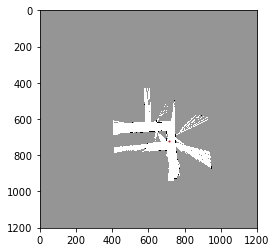

i: 9100
c_array
(100,)
[-405. -578. -377.   39. -572. -352. -230. -615. -608. -445. -489. -200.
 -226. -647. -277. -640. -318. -206. -362. -296. -354. -319. -574. -210.
 -433. -328. -423. -271. -666. -337. -192. -305. -590. -393.  -19. -247.
 -269. -674. -510. -333. -374. -277. -546. -250. -321. -557. -377. -229.
 -637. -338. -600.  -84. -245. -469. -342. -610. -378. -684. -239. -675.
 -625. -224. -401. -506. -303. -485. -231. -228. -352. -553. -669. -746.
 -654. -588. -274. -374. -321. -616. -276. -652. -658. -555. -378. -629.
 -641. -438. -319. -486. -497.  -88. -538. -305. -329. -662. -363. -366.
   43. -111.    9. -107.]
np.max(c_array)
43.0
xy_w_scan shape
(2, 1038)
*****Updating map*****
particle states
[ 6.31127843  5.61369525 -0.59044268]
particle weights
[  2.68033880e-195   1.97353269e-270   3.87645893e-183   1.79862100e-002
   7.96179912e-268   2.79124035e-172   2.68982501e-119   1.68402484e-286
   1.84675748e-283   1.13870288e-212   8.86039766e-232   2.87447466e-106
   1.46

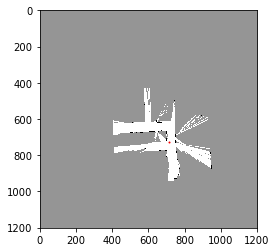

i: 9150
c_array
(100,)
[-256. -337. -306. -212. -322. -272. -702. -250. -565. -662. -596. -312.
 -497. -132. -462. -276.  -47. -529. -232. -424. -434. -608. -494. -408.
 -533. -520. -587. -420. -328. -487. -499. -336. -699. -368. -512. -335.
 -578.  -55. -157. -354. -645. -229. -319. -530. -590. -528. -583. -537.
 -783. -298. -289. -536. -306. -651. -342. -304. -260. -430. -453. -455.
 -277. -594. -328. -291. -397. -250. -572. -582. -610. -702. -402. -224.
 -257. -342. -294. -622. -213. -494. -756. -266. -268. -589. -377. -588.
 -330.  -24. -267. -353. -255. -303. -211. -604. -491. -529. -605.  -34.
 -427.  -49. -237. -558.]
np.max(c_array)
-24.0
xy_w_scan shape
(2, 1070)
particle states
[ 6.42436123  5.53738236 -0.68620025]
particle weights
[  1.75250991e-101   1.16361001e-136   3.38015322e-123   2.25225565e-082
   3.80386133e-130   1.97219009e-108   3.53444765e-295   7.07012958e-099
   1.11343681e-235   8.31956902e-278   3.83298072e-249   8.37856215e-126
   3.79044626e-206   1.247889

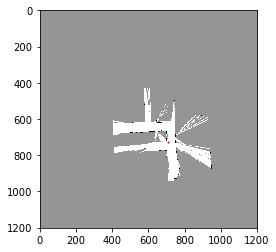

i: 9200
c_array
(100,)
[-501. -653. -422. -640. -571. -577. -345. -131. -295. -411. -510. -252.
 -574. -221. -567. -134. -424. -250. -134. -432. -420. -430. -392. -576.
 -475. -195. -357. -335. -599. -260. -594. -649. -257. -475. -414. -170.
 -532. -466. -517. -435. -585. -569. -516. -629. -572. -134. -329. -616.
 -287. -415. -202. -515. -490. -512. -725. -591. -439.  -87. -457.  -99.
 -277. -355. -417. -186. -599. -372. -294. -411. -314. -741. -145. -301.
 -443. -119. -417. -595. -422. -403. -634. -590. -545. -131. -546. -734.
 -130. -542. -186. -592. -463. -587. -184. -503. -624. -511. -412. -550.
 -405. -341. -480. -654.]
np.max(c_array)
-87.0
xy_w_scan shape
(2, 1071)
particle states
[ 6.51766291  5.50294521 -0.76526   ]
particle weights
[  1.59250874e-180   1.54639549e-246   3.24598041e-146   6.84146074e-241
   6.33093844e-211   1.56928274e-213   8.95408062e-113   7.78108443e-020
   4.64242713e-091   1.94350291e-141   1.96531191e-184   2.19486502e-072
   3.15198865e-212   6.375830

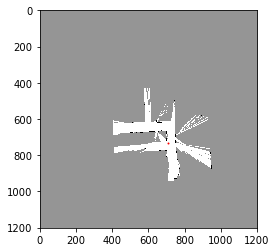

i: 9250
c_array
(100,)
[-324. -402. -482. -495. -412. -638. -440. -462. -491. -453. -566. -651.
 -342. -578. -481. -592. -473. -400. -560. -531. -489. -429. -533. -650.
 -493. -620. -504. -347. -551. -566. -518. -637. -189. -567. -514. -446.
 -405. -540. -461. -631. -582. -461. -601. -413. -359. -760. -211. -455.
 -410. -331. -586. -402. -216. -227. -673. -727. -210. -491. -569. -177.
 -592. -421. -218. -603. -555. -539. -250. -342. -377. -660. -405. -547.
 -604. -504. -495. -436. -207. -277. -598. -510. -511. -422. -361. -527.
 -625. -783. -520. -406. -483. -204. -678. -520. -349. -653. -586. -579.
 -503. -407. -662. -484.]
np.max(c_array)
-177.0
xy_w_scan shape
(2, 1032)
particle states
[ 6.65103737  5.39826959 -0.86298197]
particle weights
[  1.44114770e-064   1.92193592e-098   3.46880871e-133   7.84065034e-139
   8.72557557e-103   6.16937507e-201   6.03321207e-115   1.68294526e-124
   4.28085003e-137   1.36370467e-120   1.14668431e-169   1.39448199e-206
   2.19486502e-072   7.04547

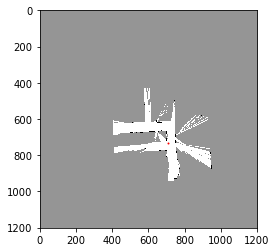

i: 9300
c_array
(100,)
[-626. -396. -501. -596. -461. -486. -561. -201. -230. -599. -297. -680.
 -667. -517. -680. -671. -346. -574. -543. -216. -261. -724. -598. -593.
 -549. -219. -415. -551. -500. -592. -244. -476. -551. -468. -512. -557.
 -462. -351. -356. -651. -518. -603. -363. -237. -710. -309. -591. -800.
 -332. -504. -465. -473. -535. -434. -392. -578. -795. -357. -533. -714.
 -646. -650. -508. -402. -610. -548. -532. -575. -776. -570. -436. -517.
 -510. -552. -635. -463. -493. -514. -268. -423. -539. -560. -486. -547.
 -692. -232. -638. -389. -551. -647. -624. -463. -432. -681. -707. -689.
 -486. -662. -543. -325.]
np.max(c_array)
-201.0
xy_w_scan shape
(2, 1039)
particle states
[ 6.73333423  5.27476041 -0.95323767]
particle weights
[  2.65977593e-185   2.05388389e-085   5.14819857e-131   2.84236279e-172
   1.21181009e-113   1.68295506e-124   4.50802562e-157   9.99999679e-001
   2.54366483e-013   1.41512910e-173   2.03109201e-042   9.39600045e-209
   4.15691643e-203   5.79353

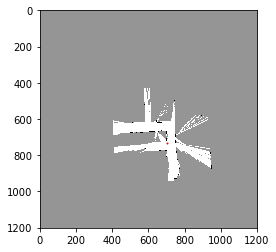

i: 9350
c_array
(100,)
[-559. -446. -597. -588. -428. -679. -408. -241. -573. -659. -285. -520.
 -369. -586. -810. -710. -627. -636. -715. -624. -312. -507. -311. -583.
 -375. -445. -298. -371. -584. -496. -593. -535. -754. -557. -511. -612.
 -443. -484. -625. -494. -421. -474. -281. -505. -303. -640. -630. -677.
 -431. -630. -368. -637. -332. -466. -752. -430. -445. -630. -756. -491.
 -629. -649. -454. -655. -690. -569. -622. -378. -581. -451. -562. -627.
 -576. -637. -641. -637. -582. -370. -352. -248. -689. -552. -652. -577.
 -549. -550. -358. -631. -420. -656. -547. -552. -622. -604. -563. -437.
 -461. -475. -250. -675.]
np.max(c_array)
-241.0
xy_w_scan shape
(2, 1061)
particle states
[ 6.77059338  5.14111905 -1.06299162]
particle weights
[  7.83258950e-139   9.31497773e-090   2.45875385e-155   1.99234888e-151
   6.11621150e-082   6.00575398e-191   2.96737295e-073   9.98965779e-001
   6.51302311e-145   2.91378280e-182   7.77308483e-020   6.78250559e-122
   2.56954914e-056   1.47215

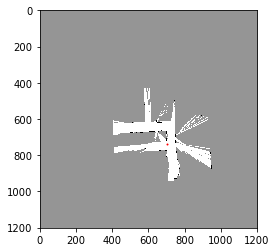

i: 9400
c_array
(100,)
[-594. -388. -454. -522. -648. -755. -395. -515. -538. -705. -728. -710.
 -306. -512. -329. -653. -578. -477. -548. -600. -555. -267. -346. -663.
 -395. -580. -571. -620. -679. -683. -537. -375. -622. -403. -331. -662.
 -692. -621. -625. -301. -369. -552. -370. -583. -527. -597. -585. -341.
 -694. -766. -622. -583. -323. -366. -366. -569. -659. -530. -747. -674.
 -616. -593. -423. -449. -366. -632. -375. -659. -660. -677. -616. -578.
 -558. -639. -279. -473. -611. -420. -336. -683. -583. -651. -583. -385.
 -490. -462. -665. -683. -589. -597. -542. -473. -424. -509. -787. -804.
 -426. -552. -302. -680.]
np.max(c_array)
-267.0
xy_w_scan shape
(2, 1076)
particle states
[ 6.86101537  5.07629537 -1.14522654]
particle weights
[  9.67613122e-143   2.82075276e-053   6.12250595e-082   1.79847517e-111
   3.41821776e-166   1.15955182e-212   2.57219357e-056   1.97226751e-108
   2.02391717e-118   6.01193474e-191   6.16937507e-201   4.05080977e-193
   1.15481532e-017   3.96140

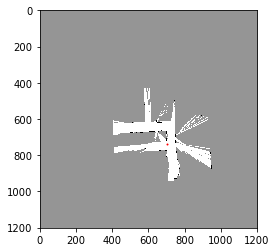

i: 9450
c_array
(100,)
[-506. -548. -628. -631. -554. -642. -533. -672. -683. -764. -697. -700.
 -669. -797. -566. -561. -719. -298. -711. -653. -523. -721. -538. -659.
 -613. -259. -638. -414. -624. -376. -680. -518. -458. -809. -666. -628.
 -584. -663. -748. -343. -676. -399. -622. -496. -651. -621. -665. -673.
 -483. -636. -476. -695. -663. -646. -622. -599. -674. -638. -582. -648.
 -699. -505. -738. -730. -318. -356. -572. -700. -572. -640. -729. -643.
 -670. -733. -627. -719. -649. -524. -483. -723. -355. -644. -313. -663.
 -613. -649. -640. -377. -656. -514. -316. -150. -536. -691. -607. -552.
 -309. -523. -650. -617.]
np.max(c_array)
-150.0
xy_w_scan shape
(2, 1078)
particle states
[ 7.09393502  3.51239547 -1.20739396]
particle weights
[  2.46129938e-155   1.41512956e-173   2.55409855e-208   1.27161079e-209
   3.50775547e-176   2.12380629e-214   4.62608311e-167   1.98737786e-227
   3.31925903e-232   2.20388085e-267   2.76005921e-238   1.37415257e-239
   3.99175513e-226   1.02676

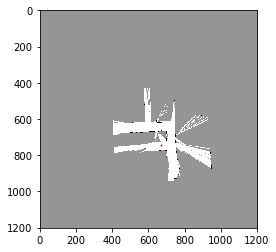

i: 9500
c_array
(100,)
[-176. -206. -480. -343. -216. -110. -257. -560. -541. -519. -385. -277.
 -150.  -83. -157. -248. -179. -417. -496. -252. -377. -245. -470. -106.
 -426. -151. -595. -454. -479. -126. -356. -149. -295. -762. -516. -575.
 -473. -194. -217. -103. -427. -622. -391. -676. -666. -296. -595. -786.
 -276. -506. -166. -744. -444. -603. -314. -293. -802. -636. -612. -142.
 -143. -405. -487. -105. -496. -193. -216. -281. -531. -701. -775. -665.
 -686. -184.  -79. -316. -466. -428. -501. -394. -714. -559. -169. -369.
 -633. -564. -613. -346. -204. -651. -421. -251. -277. -315. -577.  -85.
 -509. -581. -312. -222.]
np.max(c_array)
-79.0
xy_w_scan shape
(2, 1081)
particle states
[ 7.04905926  2.89157768 -1.24511869]
particle weights
[  7.31976234e-043   6.84955762e-056   6.90199248e-175   2.17429518e-115
   3.10969435e-060   3.37235112e-014   4.86008591e-078   1.24570707e-209
   2.22336664e-201   7.97057564e-192   1.25011585e-133   1.00173837e-086
   1.43269422e-031   1.794253

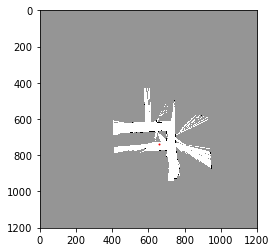

i: 9550
c_array
(100,)
[-630.  -37.  116. -663. -137. -430. -566. -472. -270.  -41. -159.  -57.
  -93. -539. -210.   70. -415. -567. -124. -436. -633. -159. -718.  -20.
 -223. -675. -270.  -67.  -50.  -34. -134.  -45.   60. -219.  -85. -430.
 -573. -565. -549.   48.  -90. -501. -585.   39. -610. -298. -283. -621.
 -572. -593. -186. -595. -636. -579. -442. -588.  -29. -624. -106. -488.
 -307. -263. -528. -576.   25.  -54. -577. -534. -145. -576.  -77. -145.
 -445. -715. -644. -264. -440. -624. -211. -665. -104. -170. -232. -498.
  -12. -545. -654. -235. -132. -399. -176. -506. -631.   60. -496. -499.
 -572. -621. -544. -278.]
np.max(c_array)
116.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[ 7.20221549  2.06612711 -1.30951596]
particle weights
[  0.00000000e+000   3.57226994e-067   1.00000000e+000   0.00000000e+000
   1.32891156e-110   7.50261880e-238   6.47386058e-297   4.31364738e-256
   2.30319116e-168   6.54284062e-069   3.70695639e-120   7.36299712e-076
   1.7

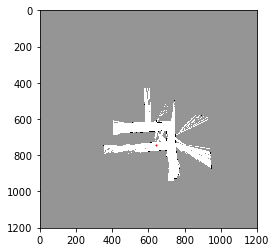

i: 9600
c_array
(100,)
[-601. -586.  492.  608. -493. -327. -494. -189. -574. -422. -449. -177.
 -654. -551.   92. -199. -375. -495. -397.  -71.  492.  241. -598. -592.
 -578. -209. -449. -459. -187. -488. -588.  -94.  -66.  126. -548. -211.
  -15. -529. -387. -465. -431.  424. -469.  343. -455. -654.   32. -582.
  -31. -266. -569.    9.  -80. -582. -430. -564. -120.  577. -589.   47.
 -559. -405. -547.  474.  -72.  -30. -309. -157. -610. -162. -584. -354.
  651. -657. -577. -583. -181. -628. -150.  -85. -493. -240. -253. -437.
 -169.  620. -582. -592.  605.  406. -577. -583.  -94. -422.  321.  293.
 -124.  351. -516. -596.]
np.max(c_array)
651.0
xy_w_scan shape
(2, 1079)
*****Updating map*****
particle states
[ 7.27406562  1.92080415 -1.32413196]
particle weights
[  0.00000000e+000   0.00000000e+000   8.85477188e-070   2.11513104e-019
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0

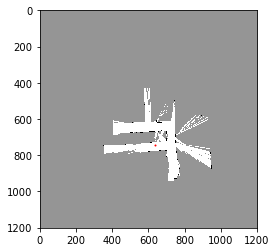

i: 9650
c_array
(100,)
[-447. -553.  309. -559. -257. -338.  422. -554. -527.  266. -127. -634.
 -147.  -78. -154.  582. -555.  611.  375.  606.  -86. -524. -318. -508.
  393. -550. -550. -530. -348. -524. -568. -548. -112. -278.  488. -563.
 -556.   18. -571. -468. -135. -190. -559. -217.  224. -339. -171. -550.
 -556. -260. -333. -447. -590. -263. -566. -660. -566. -522. -413.  521.
  340. -544. -481.   86. -271. -629.  -39. -512. -570.   24. -285.  226.
  586.   24. -127. -253.  594. -278. -168.  191. -350. -475. -428. -200.
 -562.  134. -474. -440. -483. -564. -309.  451.  500. -274. -363.   37.
 -410. -572.  234. -541.]
np.max(c_array)
611.0
xy_w_scan shape
(2, 1038)
*****Updating map*****
particle states
[ 7.26395184  1.76187526 -1.37520785]
particle weights
[  0.00000000e+000   0.00000000e+000   6.92069976e-132   0.00000000e+000
   0.00000000e+000   0.00000000e+000   8.23050463e-083   0.00000000e+000
   0.00000000e+000   1.46381869e-150   2.94463125e-321   0.00000000e+000
   0.0

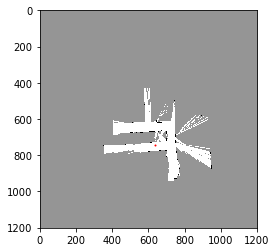

i: 9700
c_array
(100,)
[ 136. -517. -527. -507.  279. -424. -584. -185. -361. -520.  148. -486.
 -469. -481. -528.  -74.  455.  614.  110. -226. -527. -529. -576.  -58.
  453. -172.  -76. -106. -140. -517. -623. -324. -109.  401. -205. -449.
 -552.  263. -522. -253. -522. -524. -152. -551. -521. -140.  223. -320.
 -471. -622. -187. -548. -520.  113.  342. -564. -429. -462. -407. -527.
 -479. -598. -425.  163. -480. -555. -565. -465.  158. -214. -541.   61.
 -503. -528.  -63. -539. -116. -548. -251. -265. -478. -326. -575.   81.
 -185. -256.  476. -491. -524. -133. -595. -527.  299. -168. -475. -106.
  409. -192. -340.  402.]
np.max(c_array)
614.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.26445836  1.63007734 -1.40302439]
particle weights
[  2.55409855e-208   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.24600035e-146   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.15691777e-203   0.00000000e+000
   0.0

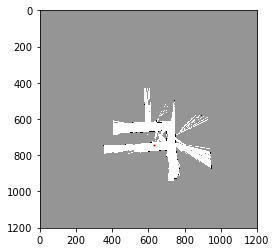

i: 9750
c_array
(100,)
[ 211. -552. -626. -497.  128.  307.  367.  -89. -439. -378. -537.  429.
  168. -305. -559.  -63. -110. -217.  411. -439. -387. -460. -612.  181.
  626. -370. -376. -425.  610. -531. -448.  406. -182. -545. -491.  337.
 -401.  453.  -66. -477. -524. -276.   13. -296.   40. -469. -511.  -23.
 -429. -234.  269. -304. -202. -483. -561.  -96. -429. -531. -465. -510.
 -503. -564. -524.  415.  477.  382.  623. -228. -139. -479. -480. -519.
 -416. -478. -562.  -64. -555. -537.  355. -572.   21. -437. -163. -510.
 -582. -405.  117. -538.   14. -306. -475.   60. -454. -483.  519. -517.
  -78. -490. -547.  343.]
np.max(c_array)
626.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.31672447  1.53180957 -1.42311964]
particle weights
[  5.58070087e-181   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.01472067e-217   2.74763480e-139   3.13781924e-113   2.87305655e-311
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.64780379e-086
   1.1

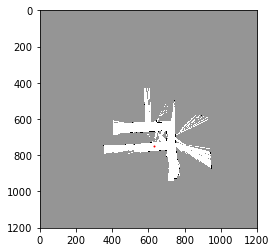

i: 9800
c_array
(100,)
[-532. -531. -515. -385.  302. -423. -232.  -41. -428.  126.  -81. -543.
 -540. -551. -550.    7. -323. -611.  655.  184. -437. -567. -570. -417.
 -532. -574. -440.  574. -582. -539. -531. -540. -533.   -6. -540. -324.
  635.  -67.  350.   -7.   -3.  347. -516.  -39.   94.  209. -524.   22.
   29. -307. -551.  478. -486. -319. -567.  -76. -540. -550. -547.  120.
  294.   64.  564.  -15. -425. -614.  196.   36. -521. -406.  314. -109.
 -502. -398.  275. -104. -534.  212.   14. -127.  276.  -73.  504.  189.
 -494. -445. -290.   83.  323. -344. -225. -182. -542. -528.  102. -505.
  444. -313.  -46. -349.]
np.max(c_array)
655.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.33689086  1.35065761 -1.41448789]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.94365195e-154   0.00000000e+000   0.00000000e+000   5.38320098e-303
   0.00000000e+000   1.81225402e-230   2.27270197e-320   0.00000000e+000
   0.0

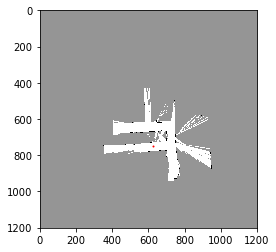

i: 9850
c_array
(100,)
[-263. -434.   54. -539.  170. -552. -526.  147. -532. -574. -429.   41.
 -512. -271. -410.  -38. -370.  443. -576. -545.  295. -194. -483. -144.
 -522.  588. -591. -540. -211. -508.  276. -198.  383. -495. -519.  222.
 -173.  575.  183. -524. -312. -554. -581. -527. -530. -539.  544.  -14.
 -477.   66. -192. -492.  205. -578. -418. -579. -573.   63. -283. -213.
  169. -530.  499. -541. -537. -540. -475. -600. -352. -424.   -7.  261.
  571.   88. -594. -144.  481.  578.  192. -521. -346. -380. -528. -579.
  306. -531. -571. -310. -576. -482.  100. -568.  288.  321. -500.  523.
  582. -590.  -95. -290.]
np.max(c_array)
588.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.36814634  1.2160129  -1.41583878]
particle weights
[  0.00000000e+000   0.00000000e+000   1.21800991e-232   0.00000000e+000
   2.90944883e-182   0.00000000e+000   0.00000000e+000   2.98564137e-192
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.75310362e-238
   0.0

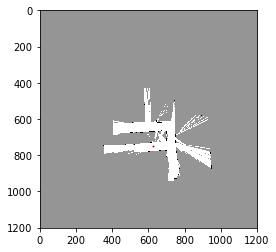

i: 9900
c_array
(100,)
[ 640.  641. -471. -415. -113. -461.   97. -531. -532.  400.  597.  -90.
  408. -544. -528. -194.  572.  120. -578.  475.  689. -534. -531. -377.
 -421. -478.  351.  363. -310.  543.  190. -538.   21. -239.  -96. -463.
 -453.  -99.  672. -202. -568. -528. -539. -558. -586. -481.  -25.  332.
 -454. -536.   44.  -31.  -86. -204. -268. -335. -454. -431. -534. -131.
  341. -536.  281.  526. -578.  232. -526. -519.  127.  629. -483. -540.
  688. -515. -556. -401. -413. -413. -113. -463.  131. -550. -376.  209.
 -522. -116. -327.  337.  324. -414. -130.  293. -515.  293. -209.  -66.
  375. -141. -483. -484.]
np.max(c_array)
689.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.39235578  1.09199108 -1.40924759]
particle weights
[  3.83285642e-022   1.04187840e-021   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   5.77588952e-258   0.00000000e+000
   0.00000000e+000   2.25344465e-126   8.10699359e-041   0.00000000e+000
   6.7

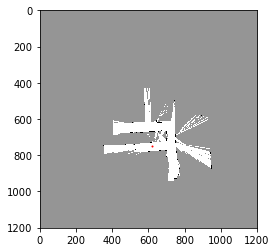

i: 9950
c_array
(100,)
[ -86.  303.  260. -555.  519.  573.  375. -531. -220. -550.  251.   92.
  554. -474. -202.  131. -534. -541. -504. -502.  175.  401. -540. -538.
  213. -168. -139. -463. -566. -617. -522. -579.   61. -514. -279. -293.
 -461.  224. -355.   46. -326. -333. -529. -549.  -24.  357.  355. -521.
 -590.   40. -477. -526.  459. -118.   23. -118.   71. -166. -253.  546.
  341. -563.  377. -414.   -8.  -25.  450. -533. -586. -536. -288. -358.
 -480.  -45. -206. -484.  388.  518. -516. -356.  216. -500. -430.   81.
 -539.   65. -338.  432. -519. -311. -203. -399. -323. -527.  -22. -344.
 -480. -467. -549.   39.]
np.max(c_array)
573.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.42054436  0.88063706 -1.38460516]
particle weights
[  6.30864985e-287   5.50161105e-118   1.16366283e-136   0.00000000e+000
   3.53262855e-024   9.99999994e-001   1.02256890e-086   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.43607402e-140   1.27161078e-209
   5.6

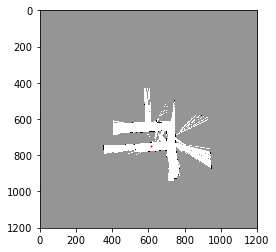

i: 10000
c_array
(100,)
[ -53. -474. -336. -191. -322. -564. -505. -562. -530. -535.  295. -550.
 -551.   85. -545.  522.  185. -305. -172.  202. -155. -452.    9. -403.
 -558. -558.  446. -554.  256. -360.  616.  258.  520. -558.  424.  -58.
 -517. -448.  222. -556. -207. -557. -564.  -46.  472.  -15.    9. -553.
 -256.  257. -301.  571. -524.  333.  291. -550. -458. -542. -570.  -16.
 -427. -495.  -65. -420. -548.  502. -543. -540. -518. -555. -570. -541.
  241. -479. -570. -231. -545. -365. -550. -532.  -58. -556. -562. -554.
  446. -559.  342.  319. -557.  -27.  590. -539. -522. -559. -518.  435.
  377. -127.  170.    8.]
np.max(c_array)
616.0
xy_w_scan shape
(2, 1035)
*****Updating map*****
particle states
[ 7.49644652  0.80494315 -1.33179331]
particle weights
[  2.86412262e-291   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.90365393e-140   0.00000000e+000
   0.

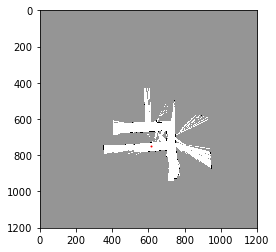

i: 10050
c_array
(100,)
[-565. -267. -328. -437. -537. -514. -507. -201. -458. -436. -433. -569.
  424.   60.  -58.   77. -528. -527. -514.  136.  103.  241. -447. -488.
 -481. -501. -544. -380. -383. -285. -422. -272. -418.  402. -500. -579.
 -527.  250. -192. -524. -444. -323. -470. -521.  575.  -29. -519. -143.
 -474. -580. -351.   49.  528. -530. -546. -326. -449. -461.  257.  500.
 -578. -591.  231.  162. -558.  348. -388.   32.  253.  314. -564. -574.
 -525.  419. -370.  -51. -429.   -3.  -64. -246. -261. -543.  243.  443.
 -187.  159.  407. -364. -480. -523. -464.   29. -551. -473.  349. -323.
 -540. -432.  232. -441.]
np.max(c_array)
575.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.54024971  0.64466802 -1.36424161]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.

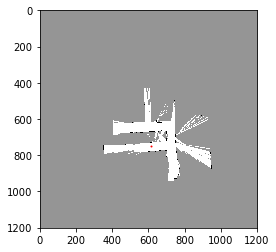

i: 10100
c_array
(100,)
[ 277. -157.  524. -488.  594.  467.  537.  442.  318. -487. -329. -206.
 -485. -566. -429.  287. -531.  235. -241.  590. -474. -392.  133. -187.
 -244. -461.  362. -525. -231. -118. -457. -519.  269.  460. -527. -570.
   76. -441. -500. -310.  239.  128.  -16. -476. -409. -473. -349. -440.
 -468.  526. -466. -357.    0. -298.  224.  -32. -524. -485. -382.  468.
  448.  248.  334.  464.   50. -489. -320. -517.  289. -468.   -8.  646.
 -526. -499.  155. -474.  563. -262.  185. -486. -464.  357. -537. -569.
 -535. -405.  362.  416. -466.  446. -513.  298. -406. -309.  628. -149.
 -156. -295. -351. -478.]
np.max(c_array)
646.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[ 7.55534297  0.49166021 -1.40349048]
particle weights
[  5.56334729e-161   0.00000000e+000   1.03770331e-053   0.00000000e+000
   2.61027903e-023   1.82510449e-078   4.59093840e-048   2.53469487e-089
   3.55967156e-143   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

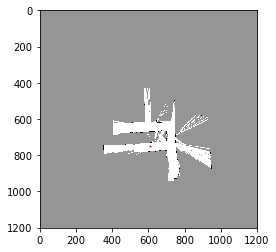

i: 10150
c_array
(100,)
[-209.  154. -345. -486. -210. -133. -143. -216. -371. -486. -493.  173.
  477.  149.  478.  -93.  127. -497. -482. -112.  500. -511. -497. -236.
 -479. -541. -445. -475.   35. -189.  314. -499. -119.   73.   92. -451.
  229. -514.  259.  251. -513. -223. -188. -264. -374.  261. -394.  325.
  214.  350.  -53.  537. -196. -450.  -54.   39.  120. -553.   40. -533.
   -3.  167. -211. -463. -454. -443.  161. -525. -481.  -88. -418.  -65.
 -250. -492. -146.  196. -391. -490. -291.  213. -358. -484. -298.  192.
 -222.  123. -136. -447.  319. -478. -133. -466. -505. -451. -527.  204.
 -491. -480.  496. -475.]
np.max(c_array)
537.0
xy_w_scan shape
(2, 1068)
*****Updating map*****
particle states
[ 7.55762828  0.34140627 -1.44263476]
particle weights
[  0.00000000e+000   4.62608311e-167   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.05365183e-291   4.78357190e-296   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.25673958e-159
   8.

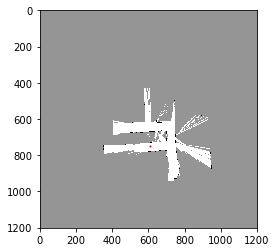

i: 10200
c_array
(100,)
[ 220. -340. -401. -486. -478. -433. -489. -293. -477. -487. -246. -497.
 -473. -448. -455. -485.  637. -412. -428. -460. -449.   90. -503. -566.
 -499. -492. -507.  387.   35. -353.  219. -489. -272.  338. -463. -466.
 -405. -575. -487. -504.  628.   40.  470. -546. -558. -318. -127. -486.
 -482.  300.  609. -126. -123.    5. -232. -501. -428. -455. -463.  477.
 -484. -464. -445. -456. -460. -506.  634.  249. -444. -427. -516. -487.
 -493. -557. -460. -554.  286.  505. -203.  201. -344. -508.  432.  625.
 -456.  363. -490. -483. -505. -152.  327. -378.  448. -501. -481. -474.
 -244.  151.  123. -463.]
np.max(c_array)
637.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 7.61436569  0.21521098 -1.46770573]
particle weights
[  7.55172619e-182   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

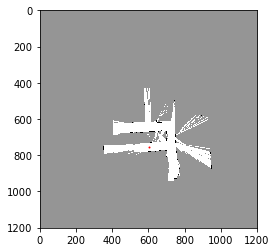

i: 10250
c_array
(100,)
[-402. -168. -522. -501.  446. -180. -516. -513.   78. -468. -323. -518.
  500. -583. -526. -234. -522.  198. -462. -276. -196. -196. -525. -378.
 -470. -383. -520.  351.  494. -393.  320.  472. -505. -437.  332.  -62.
    9.  203. -521.  -99. -451.  102. -540. -351. -198. -517.  -61.  146.
  647.  -36.   -6. -110. -257. -528. -468. -181. -167. -475.  693. -477.
 -502.  236. -435. -378.  377.  -71. -517. -538. -494. -427. -522.   50.
 -461.  275. -530.  319.  -97. -364. -469. -326. -538.   64. -177. -523.
 -290. -493. -565.  -11. -518.  100. -521.  413. -515. -403. -267. -161.
 -230. -532. -491. -560.]
np.max(c_array)
693.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.64049143  0.05989204 -1.40880437]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.36121186e-108   0.00000000e+000   0.00000000e+000   0.00000000e+000
   8.10762456e-268   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.

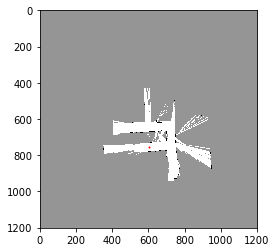

i: 10300
c_array
(100,)
[-456.  532.  498. -132.  260.  551.  348.  473. -567.  514.  431.  -59.
  571. -469. -524. -249. -478.  210. -485.  580. -436. -481. -571.  487.
 -313. -566. -420.  432. -429. -481. -426. -427. -479. -153.    0.  377.
 -482.  452. -464.  478. -505.  -45. -158.  260.  312. -292. -458.  415.
  -12.  544.  154. -469. -344. -541. -412. -483.  304.  476.  547.  593.
  422.  211. -549. -457.  539. -421. -396. -484. -462.  710. -564. -307.
 -517. -529. -431.  372.  -83. -440.  547. -431. -497.  412. -418.  298.
 -515.  387. -450.  110.  219. -454. -509.  476.  522. -413.   17.  473.
  322. -497.  255. -184.]
np.max(c_array)
710.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.62423419 -0.0694862  -1.42331607]
particle weights
[  0.00000000e+000   4.96114844e-078   8.50295414e-093   0.00000000e+000
   3.69388307e-196   8.85477188e-070   6.10095120e-158   1.18088550e-103
   0.00000000e+000   7.55581902e-086   6.78952746e-122   0.00000000e+000
   4.

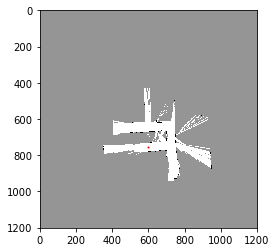

i: 10350
c_array
(100,)
[ 135.  386.  386. -439. -315.  147. -428. -492. -460. -550. -441.  -51.
 -528.  568. -535.  -91. -217. -476. -514. -500.  239.  438.  528. -461.
 -420.  245. -447. -473. -395. -235.  347. -224. -471. -286. -533. -465.
 -484. -276. -248.  562. -454. -444.   -2. -513.  159. -397.  -65. -142.
  525.  116.  502. -517. -458. -478. -505. -462. -259.  361. -519. -461.
 -244.   68. -577.  293. -119. -474.   73.  -28. -441. -474. -501.  621.
  141.  480. -110.  468. -436. -451.  434.  416. -491. -230.  250.   89.
 -385. -495. -440. -459.  312.  347.  394.  309.  -13. -530. -242.  271.
 -251. -426. -458. -308.]
np.max(c_array)
621.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[ 7.6476074  -0.21047504 -1.43937173]
particle weights
[  8.56804611e-212   8.72562919e-103   8.72562919e-103   0.00000000e+000
   0.00000000e+000   1.39449056e-206   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.42596269e-292
   0.

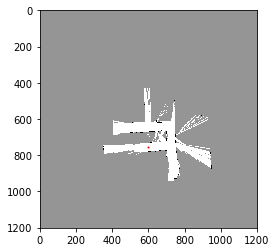

i: 10400
c_array
(100,)
[-421. -453. -528.  346. -474.  687. -498. -360. -456.  192.   33. -131.
 -562.  -46. -322.  356. -426. -485. -436. -231. -450. -502. -214.  452.
  -82. -488. -559. -480.  394.  523. -446.  664. -480. -423.  332. -564.
  447.   52.  484. -129.   20.  444.  483. -172.  377. -416. -393. -449.
 -174.  685. -484.  416. -508. -473. -345.   -7.  537. -452. -525. -215.
 -470. -556. -191.  186.  504.  468.  539.  117. -567. -426. -495. -508.
  471.  209. -449. -438. -336.  486. -482. -474. -198. -543.  617. -184.
 -217. -493.  191. -403.  451.  110. -331. -225. -409. -489.  379. -424.
 -468.  363.  440.  582.]
np.max(c_array)
687.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[ 7.68490793 -0.3389944  -1.48080818]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   7.08692010e-149
   0.00000000e+000   8.80797078e-001   0.00000000e+000   0.00000000e+000
   0.00000000e+000   9.31338000e-216   8.24678553e-285   0.00000000e+000
   0.

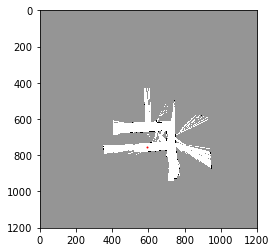

i: 10450
c_array
(100,)
[ 194. -461. -458.  227.  173.  144. -238. -417. -527. -499. -222.  451.
  435.   94.  276. -450. -520.  340. -511. -484. -287.  628. -494.   31.
 -316.   16.  263. -519.  299. -378. -512. -371.  290. -430.  332.  342.
  633.  -18.   87. -306. -331.  381. -492.  466. -486. -110. -493. -482.
 -546. -282. -392. -537.   66.  348. -156. -428.  242. -183. -446. -417.
 -245. -168. -518. -522. -515.   52. -206. -517. -450.  112.  536. -512.
 -541. -211. -292.   46. -527.  281. -532. -521. -496. -492. -245.  -46.
 -498. -258. -171.  596. -169. -489.  629. -459.   16. -519. -517. -492.
  204. -339. -498. -558.]
np.max(c_array)
633.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[ 7.72953998 -0.48842062 -1.40608904]
particle weights
[  2.15762455e-191   0.00000000e+000   0.00000000e+000   4.63120258e-177
   1.63603185e-200   4.16151803e-213   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.86457103e-080
   9.

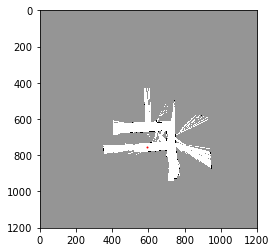

i: 10500
c_array
(100,)
[-163.  166. -534. -508. -484. -470. -410. -482. -497.  312. -452. -558.
 -180. -437.  309.  355. -342. -151.  129.  359. -436. -482. -253.  538.
  607. -136. -299. -247. -477. -188. -141.   38. -491. -535. -497. -505.
 -558.  284. -382. -489.  584. -496. -480. -358.  365. -311.  371. -513.
 -420. -475.  253.  378.  597.  373. -490.  190.  583. -437. -512.  359.
 -401.  366. -531. -413. -442.  597.  413. -419. -457. -521. -531.  255.
  551. -329.  366. -554. -543.  426. -443.  320. -505.  180.  333. -479.
 -438. -464.  122. -402.  613. -460. -454.   -4.    2. -582. -522. -387.
  372.  226.  361.  369.]
np.max(c_array)
613.0
xy_w_scan shape
(2, 1070)
*****Updating map*****
particle states
[ 7.74334575 -0.6240054  -1.41525203]
particle weights
[  0.00000000e+000   7.40101553e-195   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.88923365e-131   0.00000000e+000   0.00000000e+000
   0.

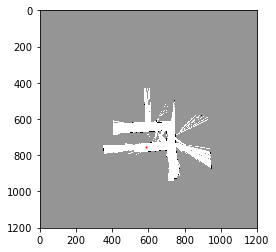

i: 10550
c_array
(100,)
[-387. -558.  393. -470.  309.  319. -507. -484.  195. -469.  369.  449.
 -406. -133.  343. -267. -214.  246. -286. -476. -477. -566. -525.   25.
 -477.  402. -550. -297. -118.  382. -245. -463. -566.  114.  393. -462.
 -493. -545. -358. -257.  338. -375. -175.  392. -192.  462.  439.  405.
 -303. -563.  519.   -2.  631. -451.   12.  -20. -428.   17.   42. -463.
 -483. -506. -324.  371. -248. -562. -232. -416. -512. -245. -442. -143.
  464. -542.  371.  -59. -460. -489.  616.   27. -530.  399.  324.  100.
 -272.   95. -399. -543. -470.  446.  406. -522.  275. -491. -376. -574.
  363. -448. -448. -476.]
np.max(c_array)
631.0
xy_w_scan shape
(2, 1073)
*****Updating map*****
particle states
[ 7.74643758 -0.76721729 -1.45922532]
particle weights
[  0.00000000e+000   0.00000000e+000   4.34423364e-104   0.00000000e+000
   1.43607359e-140   3.16316257e-136   0.00000000e+000   0.00000000e+000
   4.44227824e-190   0.00000000e+000   1.64000665e-114   9.08665754e-080
   0.

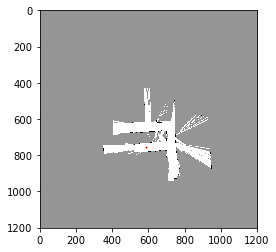

i: 10600
c_array
(100,)
[-246.  417.  153.  394. -548. -482.  402. -427.  304. -477.  453. -423.
 -519. -550. -428. -482. -352. -112. -420. -171. -421. -508. -427. -514.
  627. -104. -122. -518.  657.  224. -531. -249. -139. -442.  568. -465.
 -541.    0.  443. -497. -459.  670. -482. -471. -287.  576. -192. -296.
 -244.  563. -559. -421.  460. -478.  188. -192.   34.  437. -547. -478.
 -314. -295.  187. -330. -371. -402. -461.  406. -299. -156. -361. -442.
  459.  465. -556.  312. -382. -343.  190.  339. -520. -476. -483.  446.
  -73. -459.  585.  341. -543. -255. -488. -488. -522. -514. -211. -284.
 -449.  507.  329. -498.]
np.max(c_array)
670.0
xy_w_scan shape
(2, 1068)
*****Updating map*****
particle states
[ 7.7423421  -0.89308319 -1.50512814]
particle weights
[  0.00000000e+000   1.32890855e-110   2.94952359e-225   1.36370996e-120
   0.00000000e+000   0.00000000e+000   4.06516210e-117   0.00000000e+000
   1.11742566e-159   0.00000000e+000   5.72923248e-095   0.00000000e+000
   0.

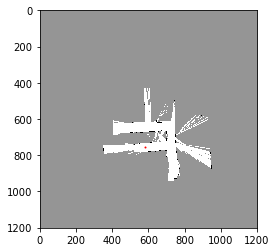

i: 10650
c_array
(100,)
[ -65. -486. -371. -564. -533.   -5.  -42. -442.    3.  439. -222. -470.
 -500.  640. -153.  663.  417.  179.  408.   12. -400. -510.  200.  414.
  644.  545.  -74. -554.   -9.  698. -476. -440.  325.  -61. -509. -445.
   14. -280.  247. -554. -249.  293. -522. -422. -480.  224.   96.  693.
 -309. -477.  603. -470.  599.  441.   20. -375. -488.  646. -503. -356.
 -533. -567.  146.  391. -553. -235. -210.  -63.  427. -186. -447.  605.
   -5.  -18. -540. -407. -513. -417. -293. -492. -497.  455. -479.  640.
 -213. -467. -501.  671. -499. -475. -539.  428.  349. -426. -505.  276.
 -388. -472. -489.  673.]
np.max(c_array)
698.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[ 7.81568762 -1.02979231 -1.46436073]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   4.87598974e-306   4.89124989e-322   0.00000000e+000
   1.45351206e-302   3.27199588e-113   0.00000000e+000   0.00000000e+000
   0.

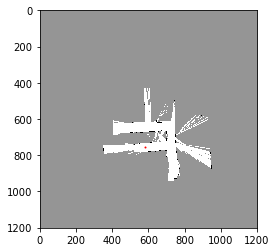

i: 10700
c_array
(100,)
[-262.   33. -461.  246. -472. -497. -493.  579. -519.  512.  498.  722.
  666. -459. -561.  346.  516.  618.  335. -452.  590. -517. -303.  362.
  731.  -27.  325.  238. -511. -469. -467. -514. -505. -444. -458.  521.
 -511. -462. -457. -532. -459.  204. -476.   34. -358.  763. -436.  601.
  549. -401. -227.  404. -507.  556. -259. -533.  480. -440. -480. -408.
   75. -412.  566.  553. -521. -331. -514. -490.  457.   82.  524.  672.
  550. -497.  -38.  -90. -548. -504. -437. -177. -186. -491. -181. -494.
 -487.  432. -401. -114.  491.  403. -199.  247.  601. -546. -491.  691.
 -284. -151.  489. -531.]
np.max(c_array)
763.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[ 7.93064952 -1.13269937 -1.47567555]
particle weights
[  0.00000000e+000   9.22618187e-318   0.00000000e+000   2.94953026e-225
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.22974575e-080
   0.00000000e+000   9.81940205e-110   8.16511481e-116   1.56288219e-018
   7.

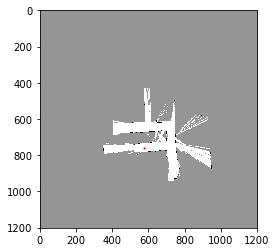

i: 10750
c_array
(100,)
[-451.  171.  -40.   67.  426.  495. -466. -413. -368. -497.  737. -193.
 -537. -103. -469. -411. -492. -483. -420. -481.  -64.  438.  475. -419.
  -32. -198. -494.  197.  758.  726.   71.  280. -385.  448. -436.  372.
  493. -452.  285.  309. -540. -489.  250.  623. -377.  -71.  -88. -527.
 -474. -481.  703.  241. -141. -448.  424. -417.  415. -514. -421. -118.
  315.  556.  720. -381.  234. -417.  -81.  539. -181.  285. -141. -465.
 -418. -227. -341. -489.  421. -535. -478.  499.  188. -486.   28. -554.
 -505.  484. -141.  494. -548. -454. -518. -131. -558. -564. -548.  489.
 -528.  -42.  332.  338.]
np.max(c_array)
758.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.85066762 -1.25267633 -1.45694265]
particle weights
[  0.00000000e+000   1.17257093e-255   0.00000000e+000   7.98937865e-301
   6.51976598e-145   6.03324913e-115   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   7.58256042e-010   0.00000000e+000
   0.

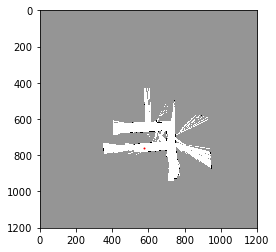

i: 10800
c_array
(100,)
[-561. -220. -432. -522. -370. -245. -542.  640.  172. -448. -511.  629.
  138. -557. -329. -209. -455. -414. -180. -351. -200. -529.   35. -181.
 -529.  304. -510. -526. -506. -476. -260. -572. -545. -560. -240. -195.
 -440.  172. -135.  368. -463. -458.  -67. -467.   26. -491.  136.  107.
 -369. -561.  522. -440. -324.  262. -448. -343.  -70.  129. -544. -455.
  278. -405. -537. -559.  137. -473. -387.  135.  312. -515. -179. -453.
  139. -450. -529. -554.  251. -171. -505. -353. -319. -217. -562.  432.
 -460. -460. -541. -237.  573.  315.  348.  457. -517. -504.  320. -518.
 -427.  352. -558. -478.]
np.max(c_array)
640.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[ 7.89994809 -1.38854741 -1.4243987 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   9.99983299e-001
   5.62568247e-204   0.00000000e+000   0.00000000e+000   1.67014218e-005
   9.

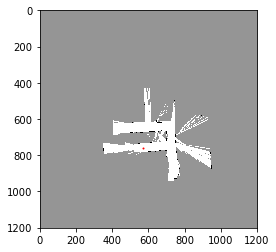

i: 10850
c_array
(100,)
[-532. -472.  167.   81. -546. -462. -504. -539. -522. -240. -518. -573.
 -467.  283. -505.  403.  457. -402. -228. -458. -515. -405. -484. -205.
 -337.  422. -474.  483.  204.  101. -443.  175. -224. -331. -493.  302.
 -136.    1. -522.  267.  334.   30.  361. -276. -562. -157. -384. -447.
 -161.  543. -558.  375. -135. -501.  341. -374.  587.  332. -261. -644.
 -347. -460. -360. -524. -417.  323. -569. -155. -443. -397.  406. -545.
  -65. -447. -145. -499. -416.  -85.  -28. -460. -363. -183. -489. -417.
  140. -457. -491.  173. -375.  308. -337. -533.  369. -543. -402. -423.
  -51.  353.   82.  611.]
np.max(c_array)
611.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.89548513 -1.50183061 -1.4810829 ]
particle weights
[  0.00000000e+000   0.00000000e+000   1.49021879e-193   6.66690998e-231
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

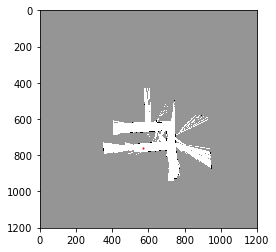

i: 10900
c_array
(100,)
[-536. -448.   47. -356. -537. -204. -451. -465. -552. -146.  -91. -544.
  249. -554. -436. -263. -475. -536. -534. -527. -357.  -74. -559. -241.
 -489. -467.  313.  -12. -498. -473. -480. -257. -261. -104.  494.  460.
 -142.  140.  -99. -520. -243. -461. -234. -216.  303. -552. -546.  255.
 -223. -162.  318. -297. -336. -528. -502.  233. -277.  308. -310. -297.
 -127. -549.  -14.  307. -287. -294. -476.  108. -469. -478. -250. -420.
  117.  460.  288.  159. -288.   86. -284.  213. -529. -454. -225. -544.
 -538.  295. -529.  282. -265. -142. -462. -546. -553. -524. -544. -465.
 -475.  -94. -118. -122.]
np.max(c_array)
494.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.83719075 -1.66746246 -1.56195459]
particle weights
[  0.00000000e+000   0.00000000e+000   7.41936248e-195   0.00000000e+000
   0.00000000e+000   7.28537031e-304   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.12598235e-278   8.66419238e-255   0.00000000e+000
   3.

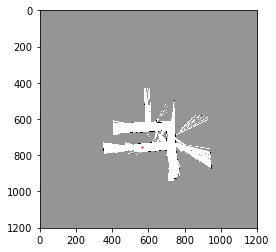

i: 10950
c_array
(100,)
[ 290.  554. -429.  365.  567.  289.  242.   75. -551.  314. -388. -366.
  347.  326.   70. -223.  110. -516. -519. -349. -520. -535. -426. -327.
  504.   -6.  -17. -501. -534. -426. -128. -136. -531.  266. -461.  -17.
 -398. -234.  169.  104.  355.  467. -421.  612. -522. -490.  311.   94.
  302.  -55.  301.  287. -362.   51.  539. -413. -448.   21. -424.  474.
  517.  343. -550. -371. -518. -401.  439.   60.   17. -594. -495.  307.
  -22.  355. -593.  -42. -520.  276.  291.  170. -516.   97. -266. -375.
  326. -504. -417. -237. -425. -414.  534.  393. -429.  234. -421. -541.
 -407. -193.  415. -159.]
np.max(c_array)
612.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.76312017 -1.77852004 -1.61982091]
particle weights
[  1.43607403e-140   6.47023493e-026   0.00000000e+000   5.36121186e-108
   2.86251858e-020   5.28302110e-141   2.04664112e-161   6.07943498e-234
   0.00000000e+000   3.80403403e-130   0.00000000e+000   0.00000000e+000
   8.

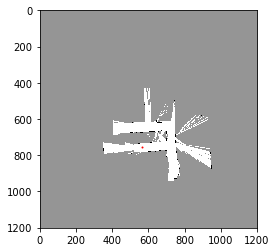

i: 11000
c_array
(100,)
[-502. -357.  -61.   68. -204. -395. -349.  442. -457.  267. -282. -469.
  585. -376. -573.  179. -464. -528. -534.   36. -342.  -57.  -84. -450.
 -388. -457. -435. -525. -167.  -58. -105.  -14.  602. -450. -549.  -98.
 -231. -570. -457. -372.  364. -171. -218. -496. -458. -463.  201. -505.
  146. -244. -442. -336.   27. -554. -506. -350. -462.   49.  -66.  445.
 -173. -165. -158.  -35. -261. -497. -473. -411. -157.  164. -106.  -21.
  289. -469. -431.  -97. -464. -478.  543. -364.   40. -355. -511. -136.
   58.  559. -145. -173. -559. -497.  260. -504.  221. -124.  -69. -529.
 -336. -466. -209. -308.]
np.max(c_array)
602.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[ 7.75932949 -1.917633   -1.54526726]
particle weights
[  0.00000000e+000   0.00000000e+000   1.15546948e-288   1.22108711e-232
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.25748840e-070
   0.00000000e+000   3.24600022e-146   0.00000000e+000   0.00000000e+000
   4.

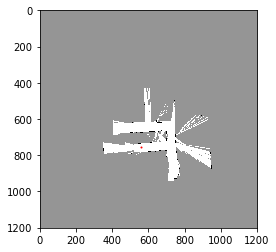

i: 11050
c_array
(100,)
[-259. -467. -353. -396.   15. -519. -521. -194. -259. -382. -458. -245.
 -327. -471.  550.  242.  195. -533. -555.  416. -559.  498.   64.   -7.
   85.  351. -497. -387. -538. -151. -484. -350. -571. -433. -352. -520.
 -101. -559. -544. -179.  -34. -462.  -64.  -55. -475. -467.  359.    8.
 -477.  -47. -248. -186. -166. -163.   91. -472. -501.  180. -517.   47.
 -545. -534.  -66. -541. -520. -442. -504. -362. -476. -472. -346. -114.
 -129. -130. -478. -515. -504. -482. -420. -352. -411. -481.  -89.   78.
 -494.  106.  -69. -487.  232. -261.  474. -485. -427. -453. -448.  341.
 -475.  220. -485. -108.]
np.max(c_array)
550.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.75071011 -2.06905517 -1.44855637]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.49212861e-233   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

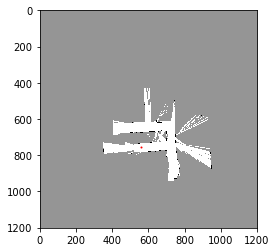

i: 11100
c_array
(100,)
[-392. -482. -435.  -70.   -9. -371.  308. -455. -419. -289. -376.  169.
 -453. -287.  601. -174. -472. -248. -396. -332. -483. -209. -289.  201.
 -382. -405. -384. -425.  -88. -361. -155. -415.  -91. -147. -203. -497.
 -386. -139. -363. -408.  -98. -579.   28.  189. -304. -475. -409. -480.
  208.  535.   68. -214. -336. -290. -318. -476.  590. -505.   15.   -1.
  473.  120. -229. -507. -398. -315. -505.  -16. -328.  135.  451. -155.
 -343. -421.   -1. -496. -387. -500. -448. -299. -122. -315. -202. -211.
 -423. -498.  412.   91. -422. -357.  165. -376.  -25. -396.   -4. -236.
  -74. -540. -527. -526.]
np.max(c_array)
601.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 7.74879756 -2.21925038 -1.56108578]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   3.87610372e-292
   1.20325808e-265   0.00000000e+000   5.64559278e-128   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.42536198e-188
   0.

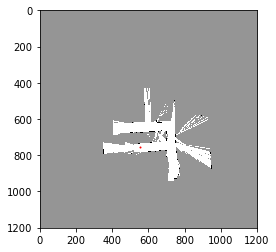

i: 11150
c_array
(100,)
[-576. -582.  489. -245.  -42. -477. -498. -345. -552.   96. -513.  -34.
 -535.  441. -394.  163. -212.   79.   23.  250. -363.  175. -553.  555.
  144. -365.  101.   -7. -221. -411.  182.  128. -125. -493.  -73.  248.
 -147. -441. -387. -383. -474.  114. -443. -469. -419.   41. -377.   95.
 -161.  277.  -33.  268.  482.  357.    7. -571. -407. -599.  527. -346.
 -291. -576. -530.  224. -413.   94. -454. -361.  123. -456. -442.  206.
 -371.  369. -518.  106. -117. -411.  308.  496. -498. -303. -154. -441.
  141. -504. -447.  583.   84. -514.  487.    0. -272.  356.    3. -372.
  433. -496. -486. -485.]
np.max(c_array)
583.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[ 7.72939403 -2.33646101 -1.60787682]
particle weights
[  0.00000000e+000   0.00000000e+000   1.50078576e-041   0.00000000e+000
   3.68085585e-272   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.15200801e-212   0.00000000e+000   1.09724767e-268
   0.

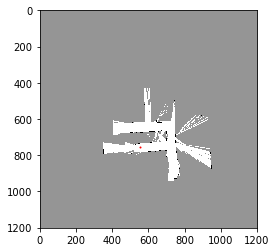

i: 11200
c_array
(100,)
[-454. -404.  236. -299. -479.  209. -463. -404. -483.  112. -402.  266.
  559. -476.  122. -472. -416.  442. -574.  483. -564. -346. -273. -407.
  -84. -442. -423. -234.   85. -417. -256.   46.  221. -400.   59.  185.
  400.  649. -322. -207.   68.  323. -221.  468. -470.  368.  562.  134.
  -28. -428.  281.  622.  587.   14. -394. -349. -411. -454.  290.   38.
 -225. -318. -561. -397.  -49. -472.  177.  -62. -348. -433.  210.   90.
  530.  581. -417. -417. -478. -379.  437. -375. -179. -399. -429. -367.
  361.  240.  282.  -21.  -95. -444. -383.  333.   97.  522.  -24.   -1.
 -502. -204. -265.  497.]
np.max(c_array)
649.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.75792674 -2.40593579 -1.6649805 ]
particle weights
[  0.00000000e+000   0.00000000e+000   4.32891416e-180   0.00000000e+000
   0.00000000e+000   8.13631891e-192   0.00000000e+000   0.00000000e+000
   0.00000000e+000   6.07943498e-234   0.00000000e+000   4.62608311e-167
   8.

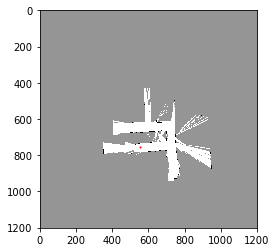

i: 11250
c_array
(100,)
[ 163. -582. -344.   39. -351.  -84.  542. -456.  124.  177. -491.  -37.
  268. -361.  187. -614.  309. -175.   56. -434. -410. -393. -420. -471.
 -585. -310. -590. -319.  668. -356.  185. -315. -389.   17.  636.   81.
  655. -234. -362. -623. -326. -451. -253. -391.  -74. -359. -491. -488.
 -464.  473.  183.  119. -442. -448. -202.  -74.   71. -185. -336.  -23.
 -427.  514. -316. -492. -481.   40.  570. -381. -491.  308.  -32. -607.
 -423. -619.  240. -552. -458.   42.  439. -301. -353. -431. -106.  -82.
   -4.  527.  441.  -86.  626. -354. -442. -371. -451.  338.  610. -192.
 -314.  461. -427.  474.]
np.max(c_array)
668.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.76273713 -2.60377277 -1.69381668]
particle weights
[  4.80049097e-220   0.00000000e+000   0.00000000e+000   6.74170743e-274
   0.00000000e+000   0.00000000e+000   1.90061564e-055   0.00000000e+000
   5.54371459e-237   5.77309101e-214   0.00000000e+000   6.64338278e-307
   1.

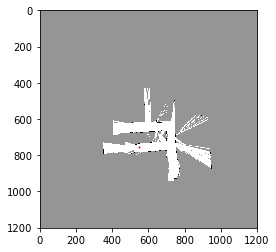

i: 11300
c_array
(100,)
[-185. -382. -180.  517.  338.   30. -466.  307. -469. -466.  343. -405.
 -522. -619.  -94.   86. -477.    2.  664. -504.  407.  458. -348. -428.
 -504. -365. -102. -397. -161. -353.  173. -483.  380. -277.  283. -186.
  -16. -377. -235.  521. -369.  -43.  490.  315.  674. -150. -249.  -30.
  431. -172.   26. -595. -520.  480. -482. -276. -169.   73. -251.   83.
 -555. -621.  649. -314. -171. -267.  679. -487. -174.   30. -235. -136.
 -550.  535. -353.   83. -219.  -62.  387. -329. -156.  280. -278.  -32.
 -302.  -17.  128. -585.  521. -340. -470.  -81. -272.  384. -586.   41.
 -296.  533. -101.  519.]
np.max(c_array)
679.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.72480413 -2.69385765 -1.73111304]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   4.37902436e-071
   7.99217712e-149   1.38027199e-282   0.00000000e+000   2.75128868e-162
   0.00000000e+000   0.00000000e+000   1.18614426e-146   0.00000000e+000
   0.

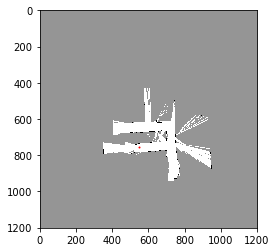

i: 11350
c_array
(100,)
[  87. -367. -271.  -77. -258. -517. -393. -152. -346. -285. -291. -104.
   34. -301. -349.  118. -377. -401. -325.  346. -362. -187. -458.  -25.
 -214. -457. -223. -412.  129.  -63.  133. -201. -161.    1.  -88. -401.
 -193. -358. -417. -353. -352. -284. -337. -415. -294. -349. -313. -258.
  -71. -394. -500.  167. -351.  118. -101. -223. -250.  -66. -501. -137.
  117. -487. -211. -379. -213. -525. -246. -249. -181. -446. -361. -506.
 -213.  -75. -183.  526. -108. -201. -200. -399. -234. -264. -238. -478.
 -364. -360. -291. -236. -602. -279. -291. -468. -220. -408. -240. -119.
 -249.  -52. -400. -122.]
np.max(c_array)
526.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.65886703 -2.87417588 -1.87749842]
particle weights
[  2.21168078e-191   0.00000000e+000   0.00000000e+000   1.31955474e-262
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.53460811e-295
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.48014117e-274
   2.

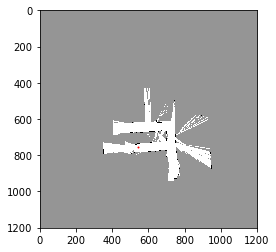

i: 11400
c_array
(100,)
[-246.  -47. -405. -278. -263. -556. -274. -179.  179. -131. -307. -340.
 -144. -427. -344.  500. -279. -573. -558. -382. -321. -220. -522. -149.
 -459. -224.  638.  579. -181.  674. -521.   38. -513.  530.  139. -299.
  265. -144. -341.  -81. -343.  277.  615. -218.  -12. -276. -290. -644.
 -390. -536.  294.  197. -320. -284. -574.  323.  224. -384.  236. -458.
   92.  330. -308. -131. -217.   80. -160. -319.  644.  257. -228. -633.
 -569. -170. -531.  637. -567. -150. -292. -250.  117. -390. -319. -141.
 -298. -424. -140. -370.  688. -221. -108.  555. -648.   89. -128. -589.
 -547. -257.  608.   58.]
np.max(c_array)
688.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.63076341 -2.9732049  -1.87063126]
particle weights
[  0.00000000e+000   6.22522714e-320   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   8.79241847e-222   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

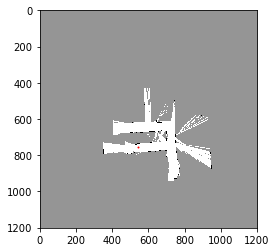

i: 11450
c_array
(100,)
[ 128. -618.  328.  177. -321.  342. -256. -210.   36. -154. -269. -166.
 -142. -139.  576. -237. -241. -299. -399. -567. -121. -459.  435.  -50.
  114. -275. -543. -198. -431. -242. -428. -271.  146. -421. -145. -422.
  -64. -223. -317. -437. -389. -247.   24. -219. -347. -417. -363. -620.
 -485. -234. -451. -436. -638. -304. -484. -363. -248.  -44. -281. -274.
 -425. -555. -639. -478. -467.  -33. -246. -397. -224. -419. -317.  -59.
 -372. -261. -173. -276. -393. -348.  558. -286. -196. -411. -296. -494.
 -356. -123.  -12. -179. -546. -467. -294. -254. -172. -419. -393. -317.
 -264. -402. -287. -188.]
np.max(c_array)
576.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.62919153 -3.14849851 -1.73020585]
particle weights
[  2.72943088e-195   0.00000000e+000   1.97227959e-108   5.20597063e-174
   0.00000000e+000   2.37187189e-102   0.00000000e+000   0.00000000e+000
   3.02677240e-235   9.22618187e-318   0.00000000e+000   0.00000000e+000
   1.

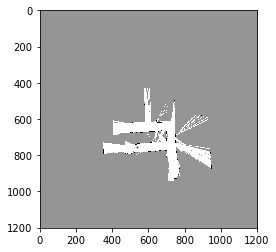

i: 11500
c_array
(100,)
[ -81. -357. -324.   47. -106. -173. -524. -399. -133. -404. -286. -200.
 -286.  328.  414. -273.  364. -200. -130.   22. -392. -202.  120. -348.
 -126. -309.  243. -303.  -28. -560.  -61.  -61.  344. -405. -376. -265.
 -303. -469. -315.  445. -308. -385.  251. -521.    6.   29. -296. -462.
 -482. -414. -147.  270. -136. -216. -350. -286. -493.  145. -502. -110.
 -111. -120. -333. -453. -444. -345.  170.  367.  -20.   -8. -188.  257.
 -284. -359.  183. -600.  -20.  141. -479. -564. -420. -197. -362. -318.
 -326. -471. -482.  242.  232. -342. -456. -149. -268. -243. -402. -291.
 -395. -369.   85. -305.]
np.max(c_array)
445.0
xy_w_scan shape
(2, 1074)
*****Updating map*****
particle states
[ 7.64814964 -3.30818565 -1.66540508]
particle weights
[  3.64000951e-229   0.00000000e+000   0.00000000e+000   1.41512956e-173
   5.05522478e-240   4.03654858e-269   0.00000000e+000   0.00000000e+000
   9.50144065e-252   0.00000000e+000   3.39423099e-318   7.58680938e-281
   3.

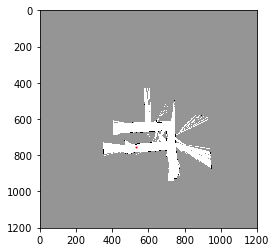

i: 11550
c_array
(100,)
[-350. -182. -198. -247. -307. -465. -281. -498. -201. -375.  153.  158.
 -457. -261.  286. -193. -354. -125. -476.  223. -238. -178. -308. -481.
  329. -359.  478. -364. -388. -224.   71. -381. -444. -396. -387.  443.
  131. -197. -239.  253. -431. -344.  154. -200. -350. -428.  333.  447.
 -386. -355. -320.  -31. -441. -411. -410. -287. -166. -230. -446.  -65.
  440. -281. -306.   49. -377. -336.  -19. -333. -411.  420. -416. -380.
 -105. -473. -116. -340. -185. -460. -285. -346. -127. -336. -452. -556.
 -358. -148.  113. -180.  -77.  -14. -516.    9.   66. -311.  -79. -445.
 -282. -494. -507. -155.]
np.max(c_array)
478.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.62521644 -3.3835359  -1.54895394]
particle weights
[  0.00000000e+000   2.32082259e-287   2.61174176e-294   1.36930640e-315
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.30030966e-295   0.00000000e+000   7.14979157e-142   1.06112315e-139
   0.

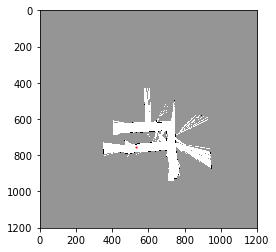

i: 11600
c_array
(100,)
[ -73. -193.   97. -174. -452. -316. -204. -504. -273. -321. -425.  158.
 -125. -129.   -5.  239. -304. -310. -173. -193. -282.  -86. -469. -198.
 -497. -260.  -36. -201.   41.  -47.  160. -417. -392. -470. -331. -397.
  226.  142. -376.  107. -456. -424.  407. -273. -367. -496.  -56. -294.
 -276. -466. -341. -472. -133. -425.   -7. -249. -312. -205.  135. -530.
  149. -123. -573. -206.  317.   52. -105.   -5. -466. -313. -340.  468.
 -387. -272. -240. -181.   13. -139. -430.  -26. -134. -407. -452.   21.
 -151. -186. -374. -275. -175. -282. -266.  377. -403. -326. -215. -251.
 -345. -475. -210.   86.]
np.max(c_array)
468.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.61063176 -3.51564093 -1.46945037]
particle weights
[  1.11348736e-235   8.53782919e-288   7.52917192e-162   1.52385140e-279
   0.00000000e+000   0.00000000e+000   1.42596269e-292   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.33727929e-135
   2.

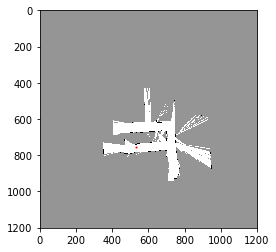

i: 11650
c_array
(100,)
[-170. -519.  124. -452. -176. -333. -294. -335. -326.  -98.  364. -117.
  362.  -17. -372. -312. -300. -366. -299. -342. -347. -419. -336.    2.
  441. -439. -478.  384.  459.   75. -228. -334.   -1.  -47. -110. -272.
 -306. -302. -309. -195.  145.  396. -479. -311. -335. -223. -325. -450.
  406. -452. -389. -367. -249. -212. -437.  131. -487.   64. -464. -292.
   -4. -453. -327. -259. -595. -476. -416.  423.   39. -365. -293. -354.
 -223. -294.  414.  322. -120. -122.  366. -435. -387. -178.  387. -343.
 -135. -303.   81.  253.  359. -283. -378.  484. -513. -162. -439.  452.
 -338. -338. -417. -328.]
np.max(c_array)
484.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.66830007 -3.63074322 -1.44546019]
particle weights
[  9.36286659e-285   0.00000000e+000   4.50802707e-157   0.00000000e+000
   2.32082259e-287   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.74024956e-253   7.66764807e-053   9.75026403e-262
   1.

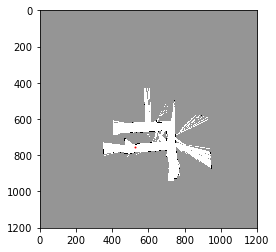

i: 11700
c_array
(100,)
[ 245. -402. -600. -145. -632.  -40. -372. -476. -447. -130. -388. -344.
 -345. -349. -493. -351. -288.  489. -296.  541.  232.   71. -246. -156.
 -111. -603. -505.  303. -497. -267. -425. -428. -429. -225. -220. -321.
 -341. -126. -298. -408. -279. -417. -299. -403. -412.  -92. -338. -400.
 -430. -525. -347. -419.  518. -250. -366. -342. -357. -359. -153. -249.
  -52. -498. -501. -274. -379. -187.  196. -180. -476. -524. -435.  -23.
  -63.  222. -204. -601. -350.   48.  538.  555.   17. -278. -590. -103.
 -165. -218. -273.  -95.  387. -438. -491. -491. -390. -356. -207. -306.
 -111. -138. -117. -474.]
np.max(c_array)
555.0
xy_w_scan shape
(2, 1066)
*****Updating map*****
particle states
[ 7.72989136 -3.76858363 -1.38665306]
particle weights
[  2.33727724e-135   0.00000000e+000   0.00000000e+000   9.85966794e-305
   0.00000000e+000   3.93353382e-259   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.22314258e-298   0.00000000e+000   0.00000000e+000
   0.

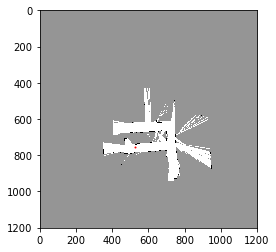

i: 11750
c_array
(100,)
[-553. -248. -427. -255.  251. -316. -415.  321. -237.  -93. -197. -257.
 -219. -287.  598. -519. -149. -489. -326. -502. -234. -496.  400.  509.
  348. -365. -522. -449. -600.  -60. -446.  365. -438. -475. -614. -466.
 -348. -267.  471. -215. -383.  612. -306. -444. -189. -265.   21. -180.
 -350. -476. -424.  230. -394. -274. -415. -162. -181.  -66. -135. -285.
   31.   32. -167. -228. -346. -225. -349.  337.   60. -513. -397. -425.
  344.  623. -334. -447. -359. -540. -349. -263. -372.  657. -302.  -17.
 -585. -633.  -42.  -20.  -42.   66.  419. -454. -361. -455.  160. -633.
  364. -163. -202. -431.]
np.max(c_array)
657.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[ 7.70264339 -3.86821398 -1.33068611]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.74723081e-177   0.00000000e+000   0.00000000e+000   1.19413680e-146
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

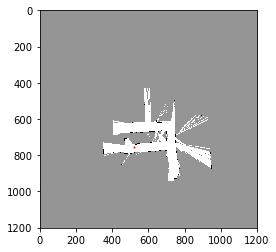

i: 11800
c_array
(100,)
[-189. -181. -487. -100. -335. -107. -525. -294. -653. -271. -551. -195.
 -438. -357. -257. -310.  435. -554. -245. -241. -386. -269. -292. -528.
 -350. -301. -282. -239.  -29. -185. -467. -177. -327. -407. -194. -450.
 -468. -528. -196. -281. -337. -336. -340. -347. -252. -444. -357.  -78.
 -493. -262. -343. -289. -374. -252. -420. -263. -294. -464. -402. -398.
 -130. -433. -429. -451. -304. -552. -165. -312. -394. -292. -320. -359.
 -464. -249. -266. -253. -352. -404. -329. -443. -239. -204. -279. -492.
 -346. -437. -175.  -16. -374. -232. -391. -424. -257. -364. -240. -300.
 -290.  389. -357. -494.]
np.max(c_array)
435.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.72332559 -4.03900594 -1.40573785]
particle weights
[  1.00056036e-271   2.98262839e-268   0.00000000e+000   4.49212861e-233
   0.00000000e+000   4.09629107e-236   0.00000000e+000   2.50797603e-317
   0.00000000e+000   2.44396947e-307   0.00000000e+000   2.48014117e-274
   0.

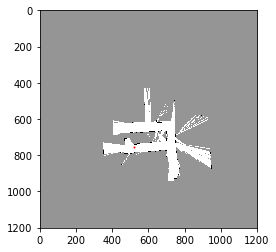

i: 11850
c_array
(100,)
[ 609. -139. -613. -318. -329. -200.  464.  593. -376.  -27. -435.  355.
 -154. -331. -205. -520. -593. -206.  716.  727. -518. -389. -378.  676.
 -353. -304. -473. -331. -442. -430. -308. -530.  739. -250. -310. -531.
   99. -405. -452. -424.  355. -406.   25.  -78. -197. -407. -399. -459.
 -514.  497. -177. -140.  734.  658.  523.  605. -541.  523. -532.  695.
  328. -308. -306. -508.  634. -209. -533. -194. -444. -148.  -32.  665.
 -268. -182.  -85. -368.  136.  628. -633.  208. -199. -336. -212.   35.
  213.  122. -144. -189.  711. -550.  475. -360. -136. -322. -365. -507.
 -306. -474.  458. -321.]
np.max(c_array)
739.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.78274671 -4.18218331 -1.40922375]
particle weights
[  3.45778721e-057   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.68212381e-120   3.89122688e-064
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.69044039e-167
   0.

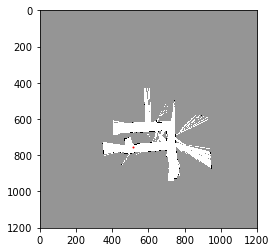

i: 11900
c_array
(100,)
[-259. -458.  124. -488. -241. -549. -341. -450. -419. -617. -244.   88.
 -372. -486.  510. -476. -427. -590. -464. -398. -226. -453.  532. -296.
 -415. -468. -462. -361. -359. -394. -505. -467. -148. -414. -595. -384.
  180. -547. -309. -370.  506.  -81. -323. -424. -245.  -76. -493. -581.
 -510. -643. -250. -505. -491.  480. -430. -425.  468. -602. -353.  -90.
 -295. -486. -466. -570. -485. -319. -458. -487. -336.  -53. -318. -469.
 -479. -444. -439. -522. -586. -483. -314. -468.  -74. -484. -395.  -33.
 -340. -179. -457. -442. -334. -435. -411. -443. -174. -154. -253. -289.
 -343. -340. -447.  401.]
np.max(c_array)
532.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[ 7.8440174  -4.32585869 -1.31862988]
particle weights
[  0.00000000e+000   0.00000000e+000   6.42467826e-178   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.49021879e-193
   0.

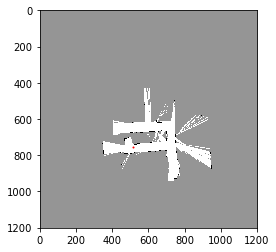

i: 11950
c_array
(100,)
[-631. -586.  574. -184. -340.  203.  -99. -118. -246. -488.  270. -529.
 -349. -500. -249.  169. -218.  700. -347. -150. -192. -164. -459.  -91.
   23. -337.  655.  548. -444.  578. -458. -309. -160.  682.    1. -427.
  601. -334. -408. -215.  347. -312.  -39.  645. -448.  -56. -141. -322.
  263. -260. -444. -279. -219. -416. -285.  269. -481. -347. -184. -474.
 -401.  305.  469. -399. -330. -306.  -28.   37.  617. -438. -403.  228.
 -315.  498.  -78. -123.  -56.  -54. -244. -411. -491. -381. -234. -314.
 -412.  -56.  692.  403. -484. -446. -333.  455. -161. -405. -137. -475.
 -454. -348. -175. -154.]
np.max(c_array)
700.0
xy_w_scan shape
(2, 1064)
*****Updating map*****
particle states
[ 7.84841622 -4.39313157 -1.37752554]
particle weights
[  0.00000000e+000   0.00000000e+000   1.89998253e-055   0.00000000e+000
   0.00000000e+000   1.43052951e-216   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.79154248e-187   0.00000000e+000
   0.

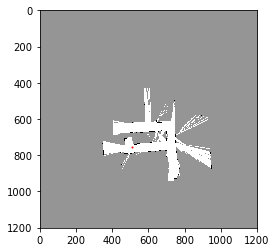

i: 12000
c_array
(100,)
[-348.  -90. -333. -547. -366. -561.  319. -268.  -50. -248.  449. -347.
 -488. -287. -166. -206. -187. -348.  192. -238. -252.  419. -424. -334.
 -574.  -82. -446. -299. -181. -263. -194. -292. -413. -359. -586. -272.
 -230. -304. -226. -369. -465. -200.  486. -364. -597. -437. -610. -631.
 -221. -205. -371. -261. -445. -444. -307.  304. -198. -232. -282.  478.
 -347. -479. -196. -277. -272. -480. -385.  415. -174. -260. -459. -122.
 -529. -500. -350. -215. -389. -190. -358.  493. -441. -116.  -13. -200.
 -344. -500. -430. -306. -410. -324. -427. -618.  278.  504. -421. -402.
 -382.   31.  343. -226.]
np.max(c_array)
504.0
xy_w_scan shape
(2, 1070)
*****Updating map*****
particle states
[ 7.86272811 -4.4855137  -1.47383898]
particle weights
[  0.00000000e+000   1.06922841e-258   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.52390616e-081   0.00000000e+000
   2.51680614e-241   0.00000000e+000   1.29955970e-024   0.00000000e+000
   0.

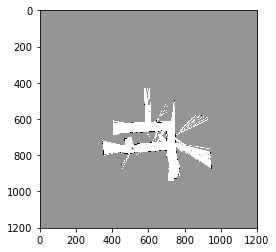

i: 12050
c_array
(100,)
[-435. -342.  559. -416.   73. -417.  508. -580. -122. -311.  295. -530.
 -357. -531.  -84. -425. -164. -467. -457.   64. -216. -266. -431. -426.
 -594. -274. -391. -317. -393.  315. -194. -502. -268. -198. -430. -475.
 -132. -259. -245. -193. -593. -361. -381. -539. -241. -582.  285.    6.
 -254. -189. -106. -241. -289. -309. -205.  364. -294. -317. -161. -270.
 -317. -394. -354. -122. -350. -356. -581. -494. -287. -402. -353.  257.
 -252.  483.  554. -389. -347. -540. -275. -509. -147. -248.  103.  358.
 -555.  284. -439.  515.  496. -529. -306. -370. -559. -492.  307. -601.
 -445.  307. -483.  -21.]
np.max(c_array)
559.0
xy_w_scan shape
(2, 1065)
*****Updating map*****
particle states
[ 7.91272491 -4.66255621 -1.55317206]
particle weights
[  0.00000000e+000   0.00000000e+000   9.93307149e-001   0.00000000e+000
   8.51070145e-212   0.00000000e+000   7.04798521e-023   0.00000000e+000
   1.74799983e-296   0.00000000e+000   2.20465348e-115   0.00000000e+000
   0.

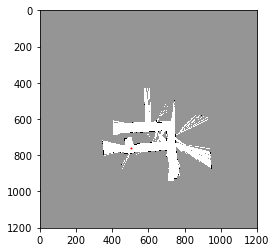

i: 12100
c_array
(100,)
[-280. -533. -284. -506. -408. -259.  348. -272.  402. -200. -205. -446.
 -198. -426. -201.  449.  -78. -333. -352. -449. -253.   60. -255. -255.
 -195.  340. -409. -191. -522. -607. -276.  -46. -401. -267.  354. -543.
 -193. -474. -383. -624. -206. -265. -307.  404. -327. -247. -570. -144.
 -227.  493.  352. -277. -298. -310. -459. -291.  369. -420. -362. -400.
 -248. -275. -597.  -76. -497.  348. -527. -139.  278.  365.  304. -199.
 -235. -304. -398. -192.  178. -329. -451.   57. -428. -364. -390. -510.
 -129. -380. -309. -252. -322.   85. -204.   20.  171. -466.  367. -222.
 -239. -181. -161.  -85.]
np.max(c_array)
493.0
xy_w_scan shape
(2, 1079)
*****Updating map*****
particle states
[ 7.87452302 -4.75865856 -1.56641005]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.06487866e-063   0.00000000e+000
   3.01440879e-040   1.08124482e-301   7.28537031e-304   0.00000000e+000
   7.

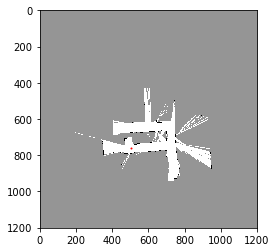

i: 12150
c_array
(100,)
[-454. -469. -199. -483. -369. -187. -289. -245. -103. -497. -110. -347.
 -187. -541. -111. -463. -237. -546. -351. -597. -314. -258.  510. -362.
 -352. -248. -298. -521.  -90.  111.   15. -147. -181. -564. -320.  488.
 -305. -183. -375. -529.  141. -559. -346. -269.   76. -275. -167.  292.
 -266. -623. -418.   57. -249. -236. -557. -559. -278. -424. -392.   25.
 -533. -287. -317. -239. -500. -459. -352. -180.  425. -238. -187. -466.
 -497. -322. -585.   30. -273.   -3. -564. -496. -393. -422. -473.  333.
 -184. -515.  -47. -555. -415.   32.  -98.   78. -287. -215.  545.  562.
 -430. -374. -542. -470.]
np.max(c_array)
562.0
xy_w_scan shape
(2, 1070)
*****Updating map*****
particle states
[ 7.87252751 -4.90858295 -1.62840923]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.56375790e-289   0.00000000e+000   1.42596263e-292   0.00000000e+000
   0.

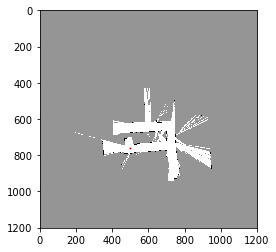

i: 12200
c_array
(100,)
[-179. -205.  -47. -472. -471. -310.  572. -378. -357. -304. -170. -398.
  553. -192. -279. -142. -339. -318.  -67. -219. -333.  -94. -420.   84.
 -216.  116. -472. -215. -242. -339. -326.  -36. -493. -136. -260. -491.
 -170.  -98.  -39. -182. -411.  267. -240. -388.  -55.   86. -365. -383.
 -237. -587. -343. -333. -282.  195. -346. -338.  336. -177. -248. -250.
   31. -154.  -84. -328. -549. -415.  397. -468.   40. -180.   51. -511.
   21.   31.  188. -324. -155.  -92. -105.  357. -527. -421. -307. -302.
 -544.  229. -355. -341. -415. -432. -590. -280.  -75. -320.  -45.  509.
 -441.  198. -204.  356.]
np.max(c_array)
572.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.90089099 -5.05348099 -1.72505884]
particle weights
[  0.00000000e+000   0.00000000e+000   1.48496323e-269   0.00000000e+000
   0.00000000e+000   0.00000000e+000   9.99999994e-001   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.

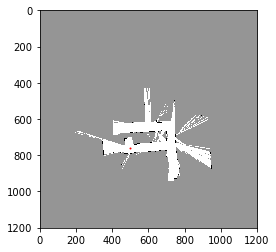

i: 12250
c_array
(100,)
[  44. -489.  -82. -414. -408.  -72. -301. -387. -513. -474. -490.  128.
 -276. -235. -541. -431. -398. -118. -292. -462. -219. -380. -378. -444.
 -233. -600. -469. -324. -180. -610. -602. -207. -467. -265. -433.  -23.
 -421. -391. -609. -453. -282. -617.  168. -254. -257.  437. -254. -211.
   -4.  213. -386. -386. -472. -438. -430. -371. -284. -186. -234.  405.
 -400. -291. -237. -326. -448. -475. -475. -448. -126. -182.  136.  -84.
 -458. -481.  -39. -195. -189. -550. -365. -266. -428. -223. -471. -403.
 -134. -258. -566.  193.  -90. -443. -103. -206. -258. -606. -162. -535.
  -97. -259. -529. -179.]
np.max(c_array)
437.0
xy_w_scan shape
(2, 1056)
*****Updating map*****
particle states
[ 7.91089346 -5.1799049  -1.60783986]
particle weights
[  2.10023848e-171   0.00000000e+000   3.99175513e-226   0.00000000e+000
   0.00000000e+000   8.79242579e-222   2.96439388e-321   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.35338381e-135
   2.

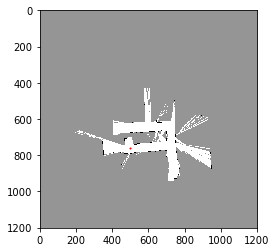

i: 12300
c_array
(100,)
[-358. -193. -598. -402.  -42.  -21.   17. -391. -483. -585.  -77. -182.
   38.   -5.    5. -177. -331. -284.  221.  -19. -344. -165. -234. -211.
   14.  426.  -90. -108. -398.   -5. -282. -438. -185. -315.  256. -449.
 -266. -353.    5.   21.  345. -446.  170.  410.  -95. -128. -331. -167.
 -170.  -28. -577.   97. -444. -378.  125. -316. -547. -104. -393.  263.
  248. -584. -413. -300. -240. -604. -341. -303. -248. -437. -188. -255.
  395. -436. -361. -541. -368. -125.  352.  300. -282.  -33.   99. -399.
  -80.  456. -597. -359. -239. -448. -480.  197. -199. -531. -229. -408.
  337. -468. -414. -292.]
np.max(c_array)
456.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[ 7.91211531 -5.32206382 -1.56960368]
particle weights
[  0.00000000e+000   1.38957261e-282   0.00000000e+000   0.00000000e+000
   5.26438948e-217   6.94275967e-208   2.21168078e-191   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.31925903e-232   8.31994673e-278
   2.

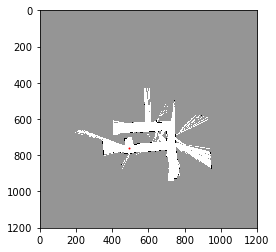

i: 12350
c_array
(100,)
[ -45. -512.  194. -329. -203. -407. -362. -210. -194. -163. -435.   50.
 -550. -155. -583. -357. -226. -131. -655. -157. -272. -156.  -90. -535.
 -421. -554. -483. -131. -339.   83.  -45.  403. -365. -409. -433.   92.
  -85. -447. -255.  332. -323. -313.  -52.  -97. -315. -651. -280. -321.
 -130. -358. -545. -465. -308. -351. -503. -142. -147. -235. -186. -143.
   -9.  -87.  -78. -296.   30. -309. -360. -456. -340. -513.   -3. -430.
  150.   51. -463. -458. -422. -375.  397. -403. -336. -203.  296. -464.
  -29. -145. -673. -475.  -77. -309. -148. -135. -324.  -99. -342. -263.
 -241. -320. -336. -378.]
np.max(c_array)
403.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.90588297 -5.45237018 -1.62542113]
particle weights
[  2.72268207e-195   0.00000000e+000   1.70364109e-091   1.24541598e-318
   6.55343189e-264   0.00000000e+000   0.00000000e+000   5.97595635e-267
   5.31030086e-260   1.54258131e-246   0.00000000e+000   4.93142817e-154
   0.

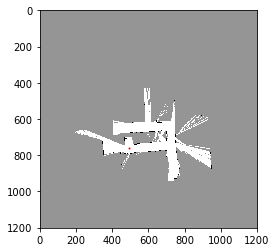

i: 12400
c_array
(100,)
[-431. -472.  323. -272.  347. -483. -325. -206. -205. -108. -482. -435.
 -658. -169. -438. -666. -230. -635. -179. -275. -358. -320.  164. -377.
 -216. -590. -250. -678. -504.  -47. -140. -499.    9. -369. -242.  420.
 -297. -253. -216. -280. -500. -237.   11. -579. -292. -260.  -81.  413.
 -611.  349. -191.  238.  280. -142. -224. -432. -188. -433. -581. -216.
  -33. -612. -153. -285. -384. -212. -289. -627.  111. -481. -147.  401.
 -289. -456.   52. -306.   53. -449. -371. -424.  -52. -677. -417.  397.
 -120.  -39. -147. -168. -202. -208. -355. -346. -518. -395. -231. -141.
 -520. -220. -472. -647.]
np.max(c_array)
420.0
xy_w_scan shape
(2, 1055)
*****Updating map*****
particle states
[ 7.86624148 -5.60282414 -1.62329857]
particle weights
[  0.00000000e+000   0.00000000e+000   7.46516495e-043   2.93645044e-301
   1.97745666e-032   0.00000000e+000   0.00000000e+000   1.35287752e-272
   3.67750239e-272   4.92172912e-230   0.00000000e+000   0.00000000e+000
   0.

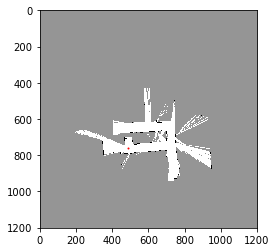

i: 12450
c_array
(100,)
[-306.  507.  -35.  -61. -343. -306.  357.  477. -449. -337. -409. -121.
 -377.  124.   39. -222. -331. -137.  427. -225. -691. -446. -218. -128.
 -228. -630. -298. -563. -446. -421.    6. -118. -440. -552. -307. -378.
 -218. -359. -209.  -75. -204. -304. -173.  431. -640.  166. -151. -295.
 -364. -448. -120. -660. -226. -496. -242. -313.  290. -232. -378.  450.
 -603. -378.  420. -285. -668. -195. -643. -542.  -35.  -78. -134. -418.
 -488.  453. -394. -425. -373.  -43.  436.  -35. -172. -223. -619.  114.
 -363. -358.   70. -420. -167.  177. -258. -257. -336. -266. -373. -527.
 -271.  417. -640. -153.]
np.max(c_array)
507.0
xy_w_scan shape
(2, 1065)
*****Updating map*****
particle states
[ 7.91441728 -5.73168713 -1.56050779]
particle weights
[  0.00000000e+000   1.00000000e+000   4.09629107e-236   2.09283157e-247
   0.00000000e+000   0.00000000e+000   7.17509597e-066   9.35762297e-014
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.83259022e-273
   0.

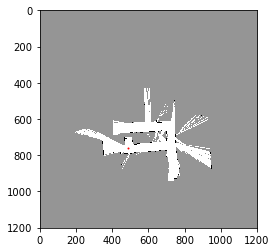

i: 12500
c_array
(100,)
[-594. -296. -273.  396. -422. -294.  -72. -262. -206. -285. -283. -209.
  257. -408. -407. -402.  -33.  -87. -525. -327. -470. -388. -335. -466.
 -645. -389. -338.  -49. -660. -233. -364. -510.  358. -400. -404.  322.
 -413. -347.   33. -454. -707.   66. -432. -509.  206. -185. -383. -166.
 -290. -105. -281. -357. -351. -107.   29. -378. -287.  247. -118. -493.
  387. -721. -236. -132.  -78. -362. -394. -343. -203. -334. -283.  212.
  314. -683. -383. -667.  -76. -692.  469. -669. -184.   13.  498.  371.
  438.  225. -194.  345. -213. -387. -142. -117. -366. -707. -366.  289.
 -345.  263. -410.  492.]
np.max(c_array)
498.0
xy_w_scan shape
(2, 1056)
*****Updating map*****
particle states
[ 7.94737607 -5.90655303 -1.54647979]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   5.02212675e-045
   0.00000000e+000   0.00000000e+000   2.82533623e-248   0.00000000e+000
   1.80139753e-306   0.00000000e+000   0.00000000e+000   8.96863021e-308
   2.

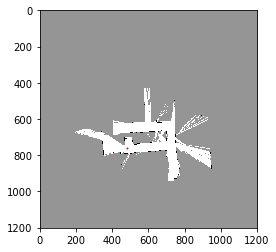

i: 12550
c_array
(100,)
[-315. -228. -406. -245.   81. -349. -269. -300. -391. -402. -129.  -91.
 -137. -196. -393. -245. -417. -412. -484.  289. -651. -412. -198. -416.
 -330.  -31.  271. -613.  350.  230.  289. -262. -414. -450. -275. -136.
 -123.  179. -438. -369. -265. -244. -257. -360.   35. -517. -224.  -57.
 -325. -381. -454. -118. -266. -394. -727. -491.  -79. -405. -268. -453.
 -207. -316.   71. -701. -203. -707. -586. -231. -416.   45. -685. -158.
 -266. -677. -649. -430. -340. -341. -625. -453. -404. -391.  144. -355.
 -342.  163. -260. -490.   88.  244. -105.  377. -345. -522. -319.  -90.
 -110. -388. -215. -342.]
np.max(c_array)
377.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[ 7.91662642 -6.02441813 -1.58416145]
particle weights
[  2.93912815e-301   1.78582315e-263   0.00000000e+000   7.39319662e-271
   2.81082208e-129   5.03739451e-316   2.79103119e-281   9.60806100e-295
   0.00000000e+000   0.00000000e+000   1.76600593e-220   5.62577643e-204
   5.

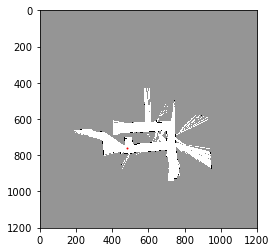

i: 12600
c_array
(100,)
[-396.  168. -644. -250.  -69. -279. -197. -289. -357. -566. -188. -199.
 -172.   37. -485. -670. -173. -322.  177. -399. -599. -131. -354.  277.
 -475. -276. -219. -425. -393. -284. -303. -165.   87. -132. -269.  -97.
  311. -327. -348. -729. -211. -384. -375. -446. -519. -176.  -23. -321.
 -265. -440. -409. -256. -273. -180. -361. -216. -336. -359. -363. -279.
 -363. -432. -410. -273.  331. -259.  113. -297. -152. -382. -314. -265.
  345. -414. -635. -220. -373.   21. -266. -569. -379. -142. -615. -559.
 -253. -298. -382.   90. -368. -336.  330.  190. -464. -173. -688. -528.
   73. -677. -501. -176.]
np.max(c_array)
345.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[ 7.89465213 -6.16616027 -1.65096155]
particle weights
[  0.00000000e+000   1.34857843e-077   0.00000000e+000   3.93353278e-259
   1.59251671e-180   1.00055922e-271   4.09628641e-236   4.54253183e-276
   1.33436060e-305   0.00000000e+000   3.31925526e-232   5.54372081e-237
   2.

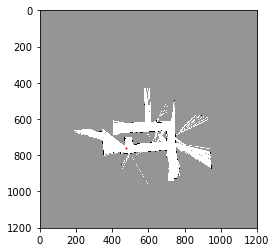

i: 12650
c_array
(100,)
[-391. -434.  221. -461.  245. -280. -721. -233. -634. -531. -175. -194.
 -406. -138. -409. -633. -231. -200. -437.  242. -440. -271.  271. -465.
 -255. -474. -447.  323. -583. -387. -198. -213. -269. -448. -140. -225.
 -334. -465. -454. -218. -201. -277. -256. -411. -255.  189. -318. -330.
  265. -196. -420. -367. -128. -385. -434. -420.  243. -437. -576. -430.
 -430.  287. -489. -474. -168. -460.  182.  -98.  175. -492. -541. -577.
 -138.   -2. -502. -244.  318. -307. -234. -346. -463. -371. -260. -377.
 -410. -178. -191. -723. -266. -538. -285. -360.  309. -436. -194.  128.
  -41. -308. -206.  239.]
np.max(c_array)
323.0
xy_w_scan shape
(2, 1065)
*****Updating map*****
particle states
[ 7.94684227 -6.27375077 -1.66094951]
particle weights
[  8.14372545e-311   0.00000000e+000   5.00087557e-045   0.00000000e+000
   1.32468804e-034   1.31072208e-262   0.00000000e+000   3.38338379e-242
   0.00000000e+000   0.00000000e+000   5.22915138e-217   2.92978707e-225
   2.

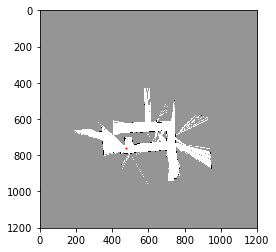

i: 12700
c_array
(100,)
[-220. -394. -302. -455. -223. -461. -323. -423. -354. -447. -520. -768.
   19. -237. -369. -367. -348.  -77. -394. -311. -301. -335. -477. -317.
 -276. -425. -467.  142. -305. -382. -228. -272. -474. -411. -551. -392.
 -395. -325. -465. -231. -509. -444.  159. -537. -490.  171. -401. -404.
 -450. -285. -753. -430. -248. -376. -324. -228. -457. -325. -278. -356.
 -486.  190. -242.  172. -451. -233. -466. -206. -378. -292. -402. -460.
 -526. -515. -441. -269. -447. -199. -761. -321. -409. -485. -301. -214.
 -696. -547. -421. -192. -341. -245. -105. -762. -287. -510. -489. -329.
 -487. -430.  128. -273.]
np.max(c_array)
190.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[ 7.95441948 -6.45455861 -1.58755185]
particle weights
[  8.69485634e-179   2.35517162e-254   2.12380625e-214   7.58680922e-281
   4.32891407e-180   1.88058199e-283   1.61038892e-223   5.99076914e-267
   5.54372700e-237   2.26159595e-277   4.47628613e-309   0.00000000e+000
   5.

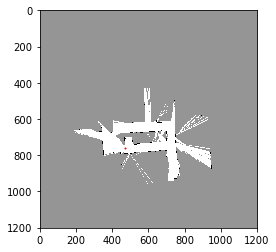

i: 12750
c_array
(100,)
[-443. -424. -179.  137. -722. -559. -212. -360. -435. -140. -510. -603.
  169. -311. -504. -260. -373. -255. -364. -343.   98. -457. -498. -437.
   94. -427. -162. -720. -212. -164. -483. -315. -356. -454. -514. -284.
 -479. -553. -231. -429.  211. -442. -288.   88. -731. -284.   25.   49.
  -79. -440. -221. -683. -344. -716. -324.  126. -563.   46.  -45. -502.
 -606. -365. -295. -381. -433. -472. -482. -420. -244. -560.  189.  162.
 -492.  194. -422. -189. -260. -245. -616. -356. -343. -179. -186. -276.
 -161. -356. -752. -635.   19.  -88. -263. -366. -278.  235. -530. -504.
 -273.  -68. -378. -785.]
np.max(c_array)
235.0
xy_w_scan shape
(2, 1067)
*****Updating map*****
particle states
[ 7.93014875 -6.58236175 -1.5644949 ]
particle weights
[  3.53460811e-295   6.30864988e-287   1.59251852e-180   2.74878501e-043
   0.00000000e+000   0.00000000e+000   7.41936248e-195   3.93353725e-259
   1.05365183e-291   1.37901594e-163   0.00000000e+000   0.00000000e+000
   2.

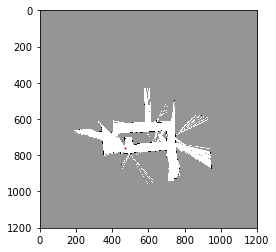

i: 12800
c_array
(100,)
[-649. -446. -672. -687. -235. -442. -250. -615. -460. -506. -447. -374.
 -464. -427. -389. -634. -456. -463. -501. -445. -450. -402. -673. -625.
 -380. -540. -413. -467. -372. -642. -637. -553. -686. -499. -586. -536.
 -481. -712. -725. -372. -460. -476. -692. -631. -561. -666. -472. -417.
 -690. -397. -422. -422. -254. -278. -610. -659. -442. -238. -633. -431.
 -597. -429. -386. -268. -631. -419. -656. -719. -460. -304. -475. -394.
 -403. -460. -434. -629. -635. -635. -694. -650. -479. -717. -400. -594.
 -384. -662. -414. -451. -462. -653. -648. -264. -676. -397. -665. -773.
 -487. -508. -620. -717.]
np.max(c_array)
-235.0
xy_w_scan shape
(2, 1077)
particle states
[ 7.90087583 -6.76117479 -1.6842709 ]
particle weights
[  1.51699149e-180   2.20172448e-092   1.55671841e-190   4.76203773e-197
   9.52573844e-001   1.20210083e-090   2.91394549e-007   8.85106498e-166
   1.83079714e-098   1.92794241e-118   8.09969171e-093   4.09228308e-061
   3.35322192e-100   3.9296

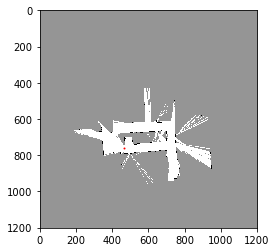

i: 12850
c_array
(100,)
[-570. -419. -352. -357. -323. -431. -412. -555. -651. -674. -664. -761.
 -478. -429. -508. -392. -496. -624. -627. -431. -620. -408. -496. -424.
 -458. -312. -389. -405. -438. -538. -681. -732. -424. -417. -762. -407.
 -642. -760. -776. -787. -425. -396. -414. -826. -693. -426. -639. -804.
 -572. -816. -485. -720. -351. -443. -429. -636. -648. -550. -593. -490.
 -806. -631. -792. -607. -636. -359. -378. -519. -354. -566. -739. -791.
 -466. -561. -778. -502. -857. -392. -439. -459. -685. -496. -327. -444.
 -638. -629. -397. -304. -769. -373. -442. -700. -819. -397. -523. -771.
 -366. -749. -710. -778.]
np.max(c_array)
-304.0
xy_w_scan shape
(2, 1061)
particle states
[ 7.88618807 -6.91000784 -1.70440135]
particle weights
[  3.00277054e-116   1.13759825e-050   1.42468615e-021   9.59945974e-024
   5.60091751e-009   6.98964519e-056   1.24752796e-047   9.81610905e-110
   1.99374271e-151   2.04595477e-161   4.50651527e-157   3.36725575e-199
   2.70778689e-076   5.1646

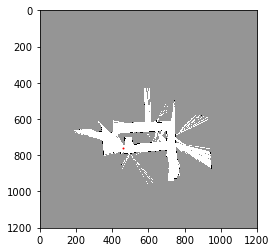

i: 12900
c_array
(100,)
[-522. -847. -531. -746. -728. -526. -552. -467. -722. -464. -481. -738.
 -584. -841. -667. -493. -590. -504. -519. -467. -688. -484. -724. -447.
 -821. -585. -719. -482. -466. -637. -456. -584. -804. -465. -494. -752.
 -796. -524. -517. -496. -611. -468. -512. -741. -423. -683. -499. -817.
 -639. -545. -501. -753. -777. -443. -613. -724. -819. -457. -710. -792.
 -454. -679. -488. -756. -468. -440. -509. -598. -769. -624. -487. -851.
 -678. -670. -701. -865. -558. -796. -464. -529. -419. -412. -424. -474.
 -706. -468. -722. -543. -517. -607. -789. -501. -473. -540. -454. -503.
 -524. -509. -481. -788.]
np.max(c_array)
-412.0
xy_w_scan shape
(2, 1071)
particle states
[ 7.90609573 -7.01798033 -1.62287649]
particle weights
[  1.68733468e-048   1.20640913e-189   2.08233642e-052   8.81530386e-146
   5.78812579e-138   3.09046127e-050   1.57894418e-061   1.29836780e-024
   2.33509661e-135   2.60784145e-023   1.07963012e-030   2.62780504e-142
   1.99960105e-075   4.8670

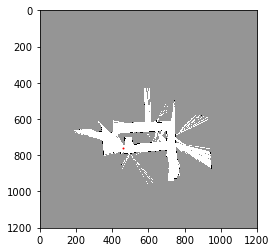

i: 12950
c_array
(100,)
[-466. -459. -792. -474. -464. -638. -473. -472. -471. -893. -651. -756.
 -490. -706. -526. -555. -527. -465. -513. -751. -487. -691. -578. -732.
 -829. -682. -732. -779. -475. -485. -478. -765. -706. -542. -840. -479.
 -505. -446. -473. -475. -579. -730. -889. -754. -858. -446. -470. -480.
 -462. -866. -523. -469. -673. -602. -548. -726. -560. -500. -690. -475.
 -723. -649. -831. -470. -515. -694. -618. -737. -521. -573. -771. -520.
 -688. -472. -523. -467. -617. -567. -618. -517. -565. -475. -523. -566.
 -845. -473. -487. -477. -691. -803. -520. -492. -555. -698. -736. -455.
 -451. -659. -541. -551.]
np.max(c_array)
-446.0
xy_w_scan shape
(2, 1066)
particle states
[ 8.50629368 -6.86731955 -1.66604245]
particle weights
[  1.02705209e-009   1.12629938e-006   2.70141541e-151   3.44537595e-013
   7.58894555e-009   2.05561409e-084   9.36550283e-013   2.54580762e-012
   6.92022258e-012   3.69699361e-195   4.64636497e-090   1.16464273e-135
   3.87725984e-020   6.0383

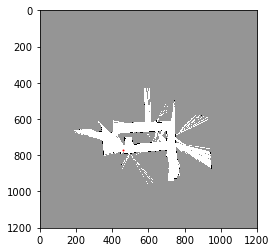

i: 13000
c_array
(100,)
[-628. -437. -740. -502. -530. -435. -457. -450. -460. -460. -449. -468.
 -421. -458. -485. -449. -507. -488. -490. -465. -421. -507. -446. -456.
 -463. -463. -463. -424. -436. -489. -448. -453. -483. -437. -520. -617.
 -423. -578. -487. -512. -438. -433. -478. -449. -470. -535. -485. -476.
 -498. -448. -834. -459. -490. -711. -484. -518. -467. -425. -493. -908.
 -834. -601. -770. -494. -528. -518. -483. -469. -630. -871. -789. -477.
 -568. -887. -601. -487. -749. -498. -661. -562. -538. -613. -816. -482.
 -661. -876. -629. -539. -471. -437. -703. -480. -708. -501. -725. -604.
 -440. -482. -455. -469.]
np.max(c_array)
-421.0
xy_w_scan shape
(2, 1066)
particle states
[ 8.53279611 -6.94732928 -1.71594955]
particle weights
[  5.72716773e-091   5.10723622e-008   1.30905511e-139   3.01331561e-036
   2.08352698e-048   3.77376550e-007   1.05267984e-016   1.15440362e-013
   5.24098434e-018   5.24098434e-018   3.13799439e-013   1.75815438e-021
   4.53834655e-001   3.8725

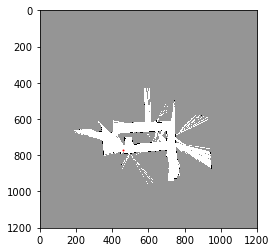

i: 13050
c_array
(100,)
[-533. -479. -417. -491. -426. -415. -483. -487. -516. -635. -416. -593.
 -483. -542. -467. -443. -500. -510. -470. -408. -510. -428. -431. -596.
 -481. -511. -410. -481. -459. -491. -483. -490. -414. -475. -530. -514.
 -523. -538. -504. -414. -685. -407. -507. -417. -503. -470. -438. -483.
 -436. -477. -415. -603. -621. -519. -448. -729. -471. -456. -513. -473.
 -514. -520. -436. -494. -423. -726. -407. -474. -425. -491. -514. -415.
 -488. -469. -628. -422. -483. -491. -461. -428. -453. -497. -406. -470.
 -501. -517. -411. -454. -416. -520. -480. -540. -433. -488. -485. -507.
 -408. -446. -503. -484.]
np.max(c_array)
-406.0
xy_w_scan shape
(2, 1069)
particle states
[ 8.43603681 -7.08586105 -1.69842062]
particle weights
[  3.43984206e-056   9.73734428e-033   8.21671840e-006   5.98283110e-038
   1.01402361e-009   6.07137932e-005   1.78345682e-034   3.26651510e-036
   8.30892225e-049   1.73181441e-100   2.23353563e-005   3.01210140e-082
   1.78345682e-034   4.2451

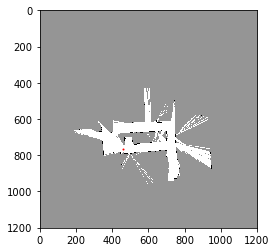

i: 13100
c_array
(100,)
[-442. -699. -456. -410. -408. -506. -405. -906. -560. -625. -452. -647.
 -515. -396. -457. -567. -521. -423. -396. -489. -569. -402. -401. -770.
 -412. -489. -520. -470. -487. -479. -489. -490. -459. -430. -402. -743.
 -497. -472. -463. -478. -399. -474. -416. -498. -429. -440. -620. -476.
 -475. -519. -554. -413. -510. -516. -564. -521. -404. -402. -474. -408.
 -400. -406. -431. -401. -570. -519. -457. -464. -460. -442. -407. -483.
 -440. -406. -474. -452. -440. -463. -408. -417. -406. -455. -469. -521.
 -478. -495. -439. -407. -483. -435. -467. -471. -485. -402. -512. -543.
 -411. -466. -439. -712.]
np.max(c_array)
-396.0
xy_w_scan shape
(2, 1078)
particle states
[ 8.46560103 -7.17545193 -1.68195434]
particle weights
[  5.03341470e-021   1.22512630e-132   4.18542888e-027   3.97453325e-007
   2.93680491e-006   8.07264532e-049   5.89873035e-005   1.54604849e-222
   2.85176575e-072   1.68256761e-100   2.28516674e-025   4.69346867e-110
   9.96243577e-053   4.7797

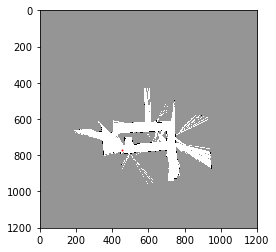

i: 13150
c_array
(100,)
[-444. -417. -484. -479. -395. -636. -375. -385. -447. -403. -382. -593.
 -378. -514. -401. -458. -526. -384. -452. -386. -488. -561. -421. -454.
 -446. -447. -482. -501. -463. -415. -389. -473. -484. -393. -395. -489.
 -374. -477. -516. -387. -489. -481. -701. -540. -412. -447. -460. -376.
 -391. -424. -637. -487. -491. -817. -392. -476. -373. -536. -409. -556.
 -375. -408. -368. -450. -396. -467. -444. -483. -377. -385. -383. -400.
 -437. -426. -449. -385. -469. -442. -407. -374. -441. -435. -368. -409.
 -383. -467. -878. -499. -415. -374. -378. -457. -480. -486. -482. -494.
 -436. -443. -443. -377.]
np.max(c_array)
-368.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.54361673 -7.32123595 -1.69707837]
particle weights
[  4.88634295e-034   2.59977017e-022   2.07589159e-051   3.08089628e-049
   9.31994948e-013   2.01578134e-117   4.52171511e-004   2.05285548e-008
   2.43276691e-035   3.12649475e-016   4.12327046e-007   9.53029056e-099
   2.25122939e-005   1.9425

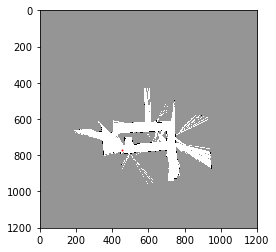

i: 13200
c_array
(100,)
[-386. -473. -392. -421. -424. -517. -530. -430. -468. -449. -528. -373.
 -409. -591. -373. -398. -451. -426. -378. -418. -423. -407. -416. -396.
 -577. -407. -504. -385. -399. -631. -403. -467. -424. -363. -459. -556.
 -521. -442. -480. -368. -428. -367. -366. -386. -432. -650. -397. -436.
 -376. -403. -404. -390. -443. -380. -441. -445. -393. -377. -496. -451.
 -392. -403. -450. -378. -405. -385. -364. -373. -446. -444. -525. -380.
 -418. -382. -561. -411. -510. -428. -427. -539. -640. -447. -504. -483.
 -400. -379. -456. -395. -456. -533. -447. -452. -410. -582. -426. -399.
 -441. -420. -426. -436.]
np.max(c_array)
-363.0
xy_w_scan shape
(2, 1070)
particle states
[ 8.44889138 -7.42957503 -1.74319659]
particle weights
[  7.11217873e-011   1.17053051e-048   1.76293285e-013   4.48431173e-026
   2.23260735e-027   9.10805266e-068   2.05871993e-073   5.53408032e-030
   1.73722130e-046   3.10063255e-038   1.52119970e-072   3.14652312e-005
   7.29843221e-021   6.6318

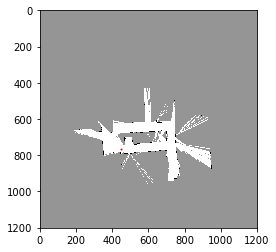

i: 13250
c_array
(100,)
[-499. -375. -694. -419. -491. -531. -420. -378. -638. -511. -544. -345.
 -469. -703. -504. -478. -451. -480. -434. -420. -488. -571. -468. -377.
 -396. -337. -380. -525. -438. -361. -471. -420. -646. -353. -616. -511.
 -528. -464. -379. -413. -714. -451. -619. -419. -397. -370. -492. -414.
 -360. -376. -342. -415. -524. -342. -445. -472. -509. -499. -565. -428.
 -511. -351. -339. -338. -515. -523. -490. -505. -351. -418. -346. -397.
 -370. -525. -504. -627. -595. -525. -556. -413. -343. -449. -360. -515.
 -538. -515. -498. -339. -572. -467. -511. -513. -574. -512. -522. -417.
 -598. -369. -542. -501.]
np.max(c_array)
-337.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.48535737 -7.5627768  -1.69371526]
particle weights
[  2.66382100e-071   1.89679674e-017   5.47118081e-156   1.47592263e-036
   7.94073850e-068   3.37350702e-085   5.42961592e-037   9.44359490e-019
   1.14438473e-131   1.63670819e-076   7.62523712e-091   2.02700702e-004
   2.84668554e-058   6.7519

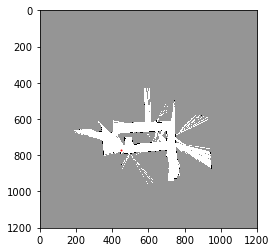

i: 13300
c_array
(100,)
[-496. -471. -497. -571. -506. -489. -424. -415. -381. -470. -489. -445.
 -389. -510. -510. -355. -343. -342. -475. -342. -382. -333. -500. -500.
 -386. -342. -435. -431. -699. -335. -498. -423. -375. -606. -331. -337.
 -411. -444. -565. -347. -734. -507. -397. -500. -374. -385. -464. -364.
 -332. -492. -483. -366. -524. -434. -341. -514. -494. -360. -631. -337.
 -492. -337. -441. -524. -337. -343. -343. -553. -373. -414. -387. -362.
 -492. -503. -492. -571. -465. -655. -370. -463. -459. -490. -343. -498.
 -427. -332. -358. -346. -361. -530. -369. -720. -414. -413. -583. -428.
 -375. -629. -762. -420.]
np.max(c_array)
-331.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.42651172 -7.75612982 -1.70227279]
particle weights
[  1.15553656e-072   8.32042939e-062   4.25098145e-073   3.09526295e-105
   5.24612788e-077   1.26719971e-069   2.14776316e-041   1.74035051e-037
   1.01542794e-022   2.26172720e-061   1.26719971e-069   1.62855439e-050
   3.40638126e-026   9.6086

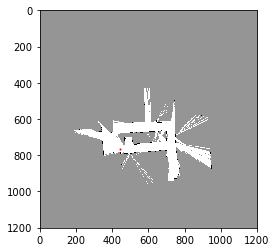

i: 13350
c_array
(100,)
[-502. -325. -341. -488. -517. -500. -339. -420. -372. -463. -638. -550.
 -341. -566. -434. -460. -341. -413. -508. -343. -469. -329. -578. -569.
 -422. -339. -397. -682. -446. -462. -451. -489. -351. -491. -777. -452.
 -368. -534. -423. -350. -334. -513. -435. -333. -350. -441. -392. -471.
 -396. -486. -488. -653. -743. -335. -450. -414. -414. -356. -455. -340.
 -337. -604. -518. -414. -481. -532. -345. -422. -389. -485. -360. -449.
 -497. -391. -394. -407. -552. -354. -406. -334. -786. -399. -484. -475.
 -502. -594. -339. -402. -501. -489. -517. -337. -343. -346. -454. -342.
 -379. -335. -341. -517.]
np.max(c_array)
-325.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.53254662 -7.878584   -1.72212874]
particle weights
[  1.32342908e-077   9.81350094e-001   1.10436404e-007   1.59156148e-071
   4.04840025e-084   9.77889168e-077   8.16020787e-007   5.41811461e-042
   3.80174794e-021   1.14600224e-060   1.14196063e-136   1.88610358e-098
   1.10436404e-007   2.1225

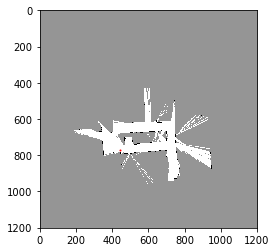

i: 13400
c_array
(100,)
[-350. -410. -375. -444. -470. -353. -362. -484. -341. -462. -330. -396.
 -361. -488. -350. -499. -389. -509. -360. -327. -359. -365. -372. -324.
 -482. -361. -362. -329. -632. -325. -489. -385. -328. -325. -328. -344.
 -360. -498. -358. -429. -531. -510. -327. -713. -501. -475. -501. -435.
 -481. -328. -699. -496. -499. -411. -336. -514. -359. -426. -390. -395.
 -330. -524. -333. -439. -439. -419. -336. -430. -490. -492. -365. -417.
 -548. -478. -513. -359. -360. -414. -404. -437. -493. -465. -357. -329.
 -467. -357. -375. -486. -392. -356. -477. -328. -500. -341. -531. -512.
 -429. -359. -458. -513.]
np.max(c_array)
-324.0
xy_w_scan shape
(2, 1073)
particle states
[ 8.49787261 -8.04988692 -1.7507597 ]
particle weights
[  2.65109094e-012   2.32143064e-038   3.68182022e-023   3.97871954e-053
   2.03276324e-064   1.31990046e-013   1.62888657e-017   1.69030101e-070
   2.14820124e-008   6.05958180e-061   1.28621705e-003   2.79176243e-032
   4.42777277e-017   3.0958

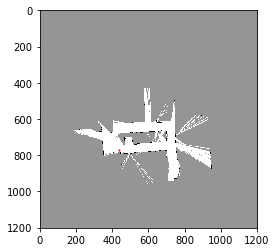

i: 13450
c_array
(100,)
[-366. -349. -346. -455. -332. -478. -324. -361. -442. -333. -418. -363.
 -374. -367. -487. -616. -429. -332. -510. -336. -553. -442. -435. -368.
 -338. -504. -434. -439. -344. -511. -357. -328. -358. -374. -486. -333.
 -479. -349. -442. -488. -350. -359. -355. -711. -337. -380. -471. -413.
 -349. -444. -435. -357. -574. -511. -422. -559. -363. -445. -337. -433.
 -566. -457. -441. -450. -394. -363. -365. -367. -382. -349. -330. -334.
 -364. -423. -483. -352. -332. -339. -345. -349. -355. -354. -429. -580.
 -541. -497. -338. -393. -364. -328. -370. -453. -342. -419. -360. -334.
 -337. -520. -480. -354.]
np.max(c_array)
-324.0
xy_w_scan shape
(2, 1077)
particle states
[ 8.51741606 -8.13615937 -1.7641927 ]
particle weights
[  5.52589509e-019   1.33477735e-011   2.68097197e-010   1.23081774e-057
   3.22414838e-004   1.26305035e-067   9.61105086e-001   8.20115548e-017
   5.44530250e-052   1.18609790e-004   1.44241283e-041   1.10990570e-017
   1.85373129e-022   2.0328

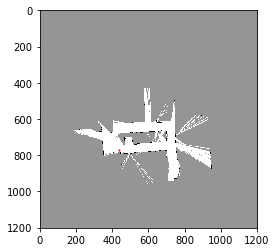

i: 13500
c_array
(100,)
[-450. -332. -499. -448. -331. -425. -420. -397. -330. -426. -419. -370.
 -368. -559. -488. -332. -504. -370. -357. -506. -393. -334. -412. -542.
 -344. -426. -512. -333. -327. -475. -474. -465. -418. -392. -442. -334.
 -418. -446. -367. -395. -349. -433. -569. -541. -349. -385. -551. -569.
 -335. -419. -500. -428. -329. -369. -353. -332. -505. -336. -461. -490.
 -406. -504. -331. -416. -388. -328. -359. -354. -496. -343. -426. -331.
 -336. -424. -451. -332. -487. -488. -335. -354. -477. -470. -351. -389.
 -504. -397. -348. -341. -417. -493. -620. -402. -564. -454. -392. -561.
 -534. -415. -510. -334.]
np.max(c_array)
-327.0
xy_w_scan shape
(2, 1078)
particle states
[ 8.541185   -8.33536978 -1.75637937]
particle weights
[  2.32627603e-054   4.10591647e-003   1.21963992e-075   1.71889841e-053
   1.11610381e-002   1.67503271e-043   2.48596896e-041   2.42252789e-031
   3.03388471e-002   6.16210098e-044   6.75756426e-041   1.28890170e-019
   9.52376699e-019   1.0679

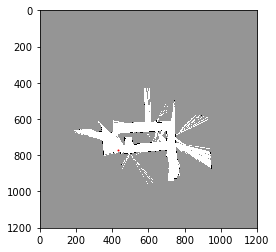

i: 13550
c_array
(100,)
[-312. -384. -324. -455. -301. -365. -482. -325. -344. -343. -332. -338.
 -370. -299. -349. -504. -323. -447. -493. -343. -342. -340. -346. -306.
 -681. -319. -470. -302. -449. -338. -507. -362. -459. -331. -717. -303.
 -343. -515. -333. -296. -538. -325. -497. -473. -513. -330. -506. -336.
 -344. -292. -362. -309. -371. -341. -291. -369. -523. -359. -298. -336.
 -480. -382. -335. -486. -298. -505. -316. -743. -321. -651. -527. -345.
 -413. -397. -299. -306. -318. -328. -446. -395. -447. -372. -355. -470.
 -423. -356. -307. -317. -321. -337. -336. -381. -396. -327. -527. -678.
 -522. -316. -314. -347.]
np.max(c_array)
-291.0
xy_w_scan shape
(2, 1078)
particle states
[ 8.41835212 -8.5049463  -1.78754598]
particle weights
[  5.50585586e-010   2.96225295e-041   3.38291476e-015   4.33225414e-072
   3.29658394e-005   5.28709722e-033   8.14259650e-084   1.24450479e-015
   6.97270701e-024   1.89537828e-023   1.13484147e-018   2.81299078e-021
   3.56241809e-035   2.4358

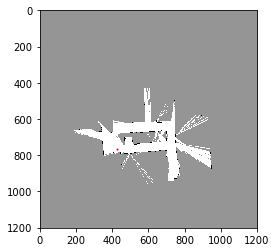

i: 13600
c_array
(100,)
[-350. -408. -478. -361. -369. -345. -496. -638. -341. -399. -532. -345.
 -376. -463. -345. -501. -363. -351. -387. -494. -340. -519. -477. -391.
 -448. -342. -386. -543. -387. -365. -349. -372. -633. -378. -503. -344.
 -377. -500. -477. -532. -395. -436. -399. -359. -506. -551. -394. -474.
 -407. -407. -342. -362. -516. -390. -428. -614. -407. -557. -432. -369.
 -421. -458. -569. -361. -414. -389. -445. -431. -678. -341. -388. -405.
 -535. -339. -393. -392. -341. -381. -502. -529. -375. -503. -425. -412.
 -629. -546. -389. -355. -490. -515. -366. -428. -457. -368. -573. -443.
 -380. -525. -389. -503.]
np.max(c_array)
-339.0
xy_w_scan shape
(2, 1076)
particle states
[ 8.43837202 -8.66049843 -1.83066923]
particle weights
[  8.84763636e-006   5.72462858e-031   2.27579732e-061   1.47770575e-010
   4.95715055e-014   1.31310566e-003   3.46603471e-069   7.41338366e-131
   7.16931400e-002   4.63871458e-027   8.03954663e-085   1.31310566e-003
   4.52033619e-017   7.4396

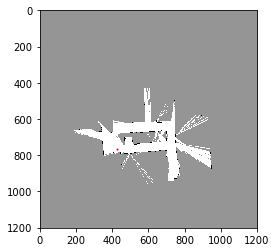

i: 13650
c_array
(100,)
[-547. -331. -301. -337. -495. -284. -294. -370. -324. -341. -331. -207.
 -490. -536. -381. -304. -340. -430. -381. -556. -682. -406. -480. -621.
 -585. -614. -341. -330. -384. -342. -278. -335. -340. -217. -373. -239.
 -334. -562. -394. -314. -358. -374. -401. -340. -341. -377. -337. -654.
 -359. -528. -507. -221. -212. -345. -350. -327. -340. -324. -315. -520.
 -266. -593. -337. -268. -515. -203. -400. -357. -384. -479. -503. -342.
 -268. -195. -373. -368. -401. -323. -519. -523. -325. -385. -320. -556.
 -336. -423. -428. -398. -247. -426. -328. -377. -338. -604. -508. -658.
 -517. -226. -485. -455.]
np.max(c_array)
-195.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.28515924 -8.78492871 -1.90009513]
particle weights
[  1.34336497e-153   8.62585415e-060   9.21799711e-047   2.13813547e-062
   5.14644195e-131   2.22660285e-039   1.01087613e-043   9.96132974e-077
   9.45939768e-057   3.91613172e-064   8.62585415e-060   6.14211391e-006
   7.63799708e-129   8.0432

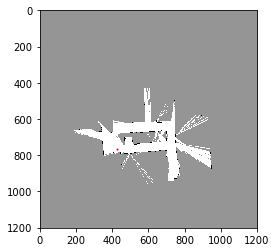

i: 13700
c_array
(100,)
[-455. -316. -570. -486. -449. -359. -298. -297. -420. -297. -300. -385.
 -438. -545. -426. -427. -347. -385. -364. -436. -317. -584. -479. -356.
 -376. -458. -315. -467. -376. -461. -419. -463. -300. -299. -288. -422.
 -455. -515. -509. -325. -385. -368. -486. -316. -724. -544. -546. -295.
 -557. -339. -478. -695. -354. -455. -284. -629. -299. -439. -550. -546.
 -497. -516. -330. -421. -566. -456. -497. -417. -465. -300. -415. -300.
 -492. -645. -519. -325. -366. -473. -303. -303. -422. -504. -573. -332.
 -349. -612. -463. -627. -593. -379. -543. -327. -407. -558. -295. -488.
 -519. -357. -301. -300.]
np.max(c_array)
-284.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.47365111 -8.95246113 -1.78057482]
particle weights
[  5.34249506e-075   1.24358969e-014   6.07965185e-125   1.83914170e-088
   2.15531634e-072   2.63035516e-033   8.16540609e-007   2.21958750e-006
   8.47326904e-060   2.21958750e-006   1.10506755e-007   1.34387187e-044
   1.29047716e-067   4.3776

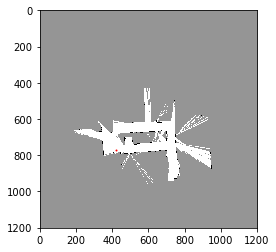

i: 13750
c_array
(100,)
[-527. -506. -528. -389. -204. -107. -220. -244. -494. -124. -519. -436.
 -506. -114. -151. -561. -148. -277. -177. -127. -245. -119. -277. -197.
 -196. -105. -198. -138. -246. -195. -317. -215. -257. -242. -199. -226.
 -410. -397. -192. -112. -281. -316. -177. -256. -189. -269. -283. -125.
 -195. -246. -357. -578. -288. -119. -541. -104. -492. -303. -513. -255.
 -220. -190. -237. -464. -296. -286. -127. -235. -249. -438. -188. -277.
 -197. -353. -195. -232. -265. -503. -324. -169. -517. -194. -122. -313.
 -100. -207. -400. -141. -479. -298. -242. -548. -191. -224. -339. -184.
 -245. -255. -280. -147.]
np.max(c_array)
-100.0
xy_w_scan shape
(2, 1081)
particle states
[ 8.44575324 -9.0846278  -1.82860734]
particle weights
[  3.50849229e-186   4.62705483e-177   1.29070218e-186   3.00440882e-126
   6.64107188e-046   8.88797707e-004   7.47354184e-053   2.82136260e-063
   7.53075344e-172   3.67956715e-011   1.04586681e-182   1.16390727e-146
   4.62705483e-177   8.1047

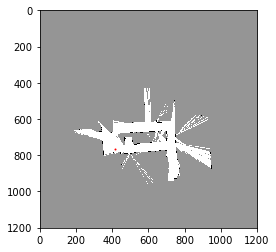

i: 13800
c_array
(100,)
[-458. -468. -206. -468. -184. -315. -480. -450. -309. -411. -222. -302.
 -398. -507. -291. -309. -210. -203. -329.  -59. -251. -297. -202. -383.
 -438. -536. -101. -296. -212. -183. -338.  -82. -461. -274. -177. -248.
 -122.  -99. -475. -370. -148. -425. -134. -255. -207. -277. -122. -413.
 -331. -303. -293. -454. -192. -257. -136. -159. -320. -343. -357. -123.
 -125. -332.  -93. -145. -526. -313. -106. -186. -104. -200. -231. -209.
 -236. -478.  -86. -445. -299. -301. -211. -328. -327. -364. -230. -302.
 -295. -341. -156. -333. -442. -214. -121. -301. -144. -144. -205. -305.
 -269. -121. -264. -127.]
np.max(c_array)
-59.0
xy_w_scan shape
(2, 1032)
particle states
[ 7.61693412 -9.38263744 -1.91202677]
particle weights
[  5.20597071e-174   2.36350705e-178   1.44115655e-064   2.36350705e-178
   5.16642063e-055   6.61626106e-112   1.45218892e-183   1.55187800e-170
   2.66919022e-109   1.34382393e-153   1.62180804e-071   2.92712250e-106
   5.94525702e-148   2.72943

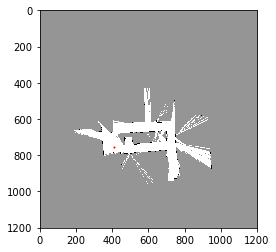

i: 13850
c_array
(100,)
[  35.   79.    2. -204. -133. -493.  -83. -501. -104.   10. -464. -455.
 -223.   12. -360. -237. -615. -205.  -56. -465.   47. -585.   21. -412.
   51. -206. -164. -710.   85.  100. -397. -422.   29. -290. -385. -287.
   38. -556. -204. -199. -458. -148. -443. -356. -400.  100. -228. -152.
 -447. -110.   22. -149. -387. -252. -544. -403. -380. -393. -126. -271.
   43. -193. -539. -478.   90. -552.   -2. -120. -455.   13.  -47. -632.
 -727.   69. -227.   56. -217. -527. -435.   20.   30. -513. -278. -207.
   68. -365. -149. -460. -563. -106. -429. -586. -294. -385. -142. -444.
 -791. -138. -208.   17.]
np.max(c_array)
100.0
xy_w_scan shape
(2, 1049)
*****Updating map*****
particle states
[ 7.56597111 -9.56817653 -1.92032206]
particle weights
[  2.94997785e-029   3.79119357e-010   1.37436110e-043   4.71452107e-133
   3.22363451e-102   1.45322316e-258   1.67135956e-080   4.87502060e-262
   1.26731849e-089   4.09691268e-040   5.71310605e-246   4.62937778e-242
   2.

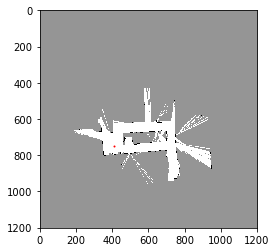

i: 13900
c_array
(100,)
[-320.   74. -238.  303.  341. -753. -363. -591. -187. -334. -669. -272.
 -165. -428. -115. -371. -188. -735. -276. -300.  -71. -191. -646. -125.
  -39. -102. -459. -497. -180. -490.  -87. -646. -606. -165. -411. -221.
  -98. -801. -363. -127. -194. -164. -462. -102. -253. -376. -520. -419.
  119. -199. -472. -387. -561. -304. -615.  -53. -133. -235.  -67. -152.
 -454. -120.   64. -494. -420. -369. -186. -709. -257.   76. -469.  360.
 -584. -688. -660. -525. -223. -388. -453. -807. -326. -296. -347. -203.
 -215. -458.   28. -141. -280. -659. -749. -270.  123. -353. -253. -591.
 -235. -807. -111. -734.]
np.max(c_array)
360.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[ 7.58672175 -9.68536615 -1.86836351]
particle weights
[  4.78357187e-296   6.19124761e-125   1.95839287e-260   1.75879219e-025
   5.60279641e-009   0.00000000e+000   1.01178814e-314   0.00000000e+000
   2.76005920e-238   3.97767739e-302   0.00000000e+000   3.35650605e-275
   9.

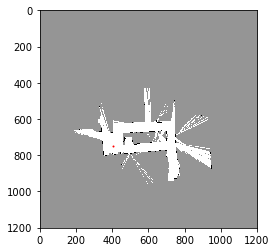

i: 13950
c_array
(100,)
[-119. -761. -278. -303. -152. -640. -450. -452. -452.   45. -138. -355.
  -95. -544. -522. -270. -428. -658. -506. -443. -297. -582. -679. -433.
 -616. -376. -302.   16. -433.  -99. -505. -382. -108. -397.  270. -257.
 -496. -638.   17. -775. -314. -288. -391. -163. -164. -234. -491. -622.
 -154. -324. -137. -443.   36.  -88. -320. -202. -202. -347. -732. -293.
 -102.   33.  -51. -148. -533. -563. -158. -424.  248. -126. -496. -393.
 -429. -130.    5.  387. -410. -345.  256. -156.  -44. -292. -260.   50.
   31. -164. -400. -197. -465. -801. -251. -167.  -45. -370. -642. -337.
 -547. -575. -707. -555.]
np.max(c_array)
387.0
xy_w_scan shape
(2, 1067)
*****Updating map*****
particle states
[ 7.56638097 -9.85921586 -1.88198669]
particle weights
[  1.76600593e-220   0.00000000e+000   1.56375796e-289   2.17173828e-300
   8.22762055e-235   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.95996918e-149   9.89457172e-229   0.00000000e+000
   4.

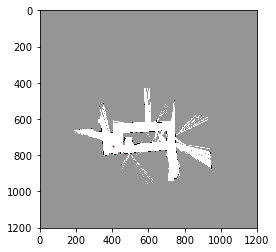

i: 14000
c_array
(100,)
[-666. -193.   49.  372. -715.  285. -393. -295. -467. -176.  442. -332.
 -120. -491. -498.  -72.  405. -199. -501.  269. -319. -285. -100. -277.
 -234. -564. -408. -442. -298. -421. -478. -601.   30.  373. -348. -382.
   79. -525. -170. -132. -427.  299. -152. -638.  -54. -317. -115.  -37.
  372. -454.  342. -288. -141. -408. -278. -429. -356. -293.  -85. -422.
 -662. -233. -257. -269. -283. -185. -276.  383.  -17.  211.  -26. -235.
 -760. -139.   63. -167. -248. -294.   30. -683. -610. -343.  -50. -175.
 -316.  -62. -506.  -80. -514. -425. -538.  -94. -362. -451. -579.  409.
 -237.  344. -425. -274.]
np.max(c_array)
442.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[ 7.51170974 -9.97735182 -1.92453727]
particle weights
[  0.00000000e+000   1.67110597e-276   2.10023848e-171   3.97544974e-031
   0.00000000e+000   6.54284062e-069   0.00000000e+000   8.39911598e-321
   0.00000000e+000   4.03654858e-269   1.00000000e+000   0.00000000e+000
   8.

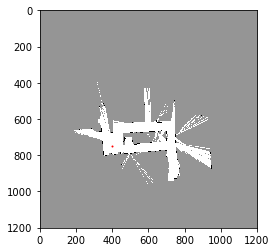

i: 14050
c_array
(100,)
[ -89. -358.  318. -241. -514. -327.  424. -243. -326. -440.  -57. -404.
 -418. -331. -233. -494. -388. -680. -412. -351. -276. -271. -214. -402.
 -286. -212. -309. -407.  393.  -62. -280. -670. -488. -504.  134. -356.
 -632. -285. -440. -168. -424.  -41. -108.  -15. -298. -693. -355. -244.
 -451. -368. -410. -239. -539. -562.   67. -517. -463. -115.   32. -256.
 -208. -304. -167. -438. -281. -205. -405. -595. -218. -267. -480.  444.
  408. -322. -307.   38. -509. -113. -168. -155. -248. -257.  287. -424.
 -267. -266. -590. -433.  366. -382. -108. -483. -443. -351.   81. -533.
 -651.  417. -425.   43.]
np.max(c_array)
444.0
xy_w_scan shape
(2, 1060)
*****Updating map*****
particle states
[  7.40619552 -10.08885654  -2.05439039]
particle weights
[  3.31925902e-232   0.00000000e+000   1.90061993e-055   3.22314538e-298
   0.00000000e+000   0.00000000e+000   2.06115362e-009   4.36205293e-299
   0.00000000e+000   0.00000000e+000   2.62098518e-218   0.00000000e+000
  

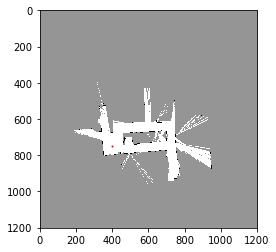

i: 14100
c_array
(100,)
[-250.  -14. -253. -620.  -53. -575.  -29. -370.   29. -342. -474.   14.
 -310. -830.  -81. -524. -690.  -19. -468.  -71.   86. -817.  -27. -688.
 -355. -632.  480.  504. -277.  454. -638.  -30. -228. -283.  262. -327.
 -143. -442. -194. -185.   27. -148. -262.  352. -142. -476. -347. -142.
 -174.  411.  -76.  -79.  -72. -303. -122.   23.   80. -759.  -89.  407.
 -320. -881. -261.  -41.  -76. -321.   95. -309. -443.  358. -235. -300.
   27.  -29.  -60.  497.  206. -388. -377. -436.  110. -205. -199. -482.
  -89.  364. -152.   21. -127.  346. -784.  447. -245. -107. -260. -564.
 -176.   14. -283. -332.]
np.max(c_array)
504.0
xy_w_scan shape
(2, 1062)
*****Updating map*****
particle states
[  7.4112943  -10.18932311  -2.17970386]
particle weights
[  0.00000000e+000   1.08408299e-225   0.00000000e+000   0.00000000e+000
   1.25192334e-242   0.00000000e+000   3.31623502e-232   0.00000000e+000
   5.12537034e-207   0.00000000e+000   0.00000000e+000   1.56786268e-213
  

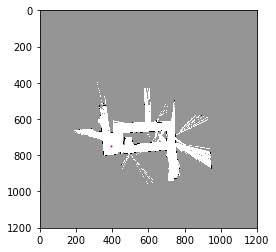

i: 14150
c_array
(100,)
[-154. -585. -488.   27.  203. -257. -230. -263. -296. -372.  -99. -782.
 -386. -301.  286.  -92. -697.  205. -657. -403. -180. -272.   14.  -89.
 -114. -892. -223.  -66. -271. -363. -267.  -60. -381. -530. -917. -118.
 -743. -342. -769. -497. -436. -595.  275. -257. -149.  449.  -89. -237.
  -36. -166.   90. -467. -691.  -63. -916. -148. -202.  414.   -9.  -54.
 -222. -534. -345. -483.  390.   11.  -27. -729. -456. -249. -172. -548.
  -68. -541. -309.  354. -473. -547.   27. -668. -743. -248.  378. -697.
 -134. -336.   35. -618.  106. -335. -297. -667.   33.  346.  138. -235.
 -393. -323.  -82.  -88.]
np.max(c_array)
449.0
xy_w_scan shape
(2, 1043)
*****Updating map*****
particle states
[  7.33904542 -10.29781397  -2.28367502]
particle weights
[  1.31955474e-262   0.00000000e+000   0.00000000e+000   5.34230448e-184
   1.45732848e-107   2.44396947e-307   1.30030966e-295   6.05799464e-310
   0.00000000e+000   0.00000000e+000   1.01536904e-238   0.00000000e+000
  

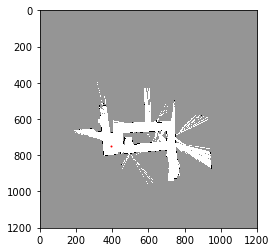

i: 14200
c_array
(100,)
[-220.  -83. -471.  -88. -747.  -24. -753. -147. -449. -312.  -29. -199.
 -278.  -48. -351. -470. -856. -111. -250.   80. -304. -371.  367. -477.
   -1.  -37. -326.  -48.  377. -479. -643.  391.  -41.  -11.    6.  -95.
  -72.  -38.  -10.  -10.  324. -742. -582.  201. -645. -386. -239. -463.
  -46.  258. -100. -261. -457.  374. -246. -898. -238. -663. -225. -161.
  -66. -539.  -45.  200. -341.  353. -455. -341. -339.    8. -580. -142.
    5. -698.  -91.   12. -696.  202. -260. -427.  -16. -762. -475. -253.
 -537. -591. -463. -432. -436. -223.   33. -486. -158. -772. -122.  254.
 -489. -584. -107. -272.]
np.max(c_array)
391.0
xy_w_scan shape
(2, 1040)
*****Updating map*****
particle states
[  7.25351717 -10.37720772  -2.43134824]
particle weights
[  4.42660916e-266   1.39448934e-206   0.00000000e+000   9.39599526e-209
   0.00000000e+000   5.85854312e-181   0.00000000e+000   2.23649719e-234
   0.00000000e+000   4.90883962e-306   3.94745531e-183   5.83788181e-257
  

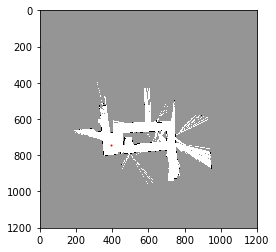

i: 14250
c_array
(100,)
[ 132.  396.  122. -575. -760. -607. -719. -599. -152. -300.   86. -390.
  483. -131. -433.  384. -300. -370. -578.   21. -263.  162. -832. -546.
    0. -618. -781. -408.    3.  -31. -771. -322.  -79. -485. -275. -413.
 -675. -304. -395. -113. -469.   22.  -42.  281.   99.   97. -649.  495.
 -820. -141. -349.  331. -644.   29. -225. -223.  -54.  174.   22. -620.
   58. -147. -405. -599. -416.   53. -545.   -1. -140.  102. -296. -306.
   -1.  324. -249. -360. -685. -624. -292. -531. -266. -619. -479. -403.
 -758. -498.  239.   -3. -799. -318.  268.  314. -483. -676. -540.  414.
 -273. -601. -236. -308.]
np.max(c_array)
495.0
xy_w_scan shape
(2, 1043)
*****Updating map*****
particle states
[  7.15604945 -10.47118848  -2.59868744]
particle weights
[  2.24440073e-158   1.01121528e-043   1.01895635e-162   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.02675669e-281   0.00000000e+000   2.36349253e-178   0.00000000e+000
  

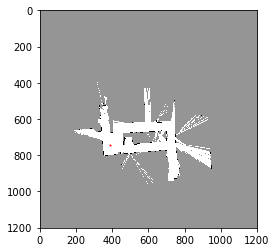

i: 14300
c_array
(100,)
[-452.  -98.  208. -260. -305. -667. -614.  389.  -56. -304.  109. -802.
 -136. -227. -121. -486. -191.  110.  -23.  408. -314.  268. -307.  375.
 -351. -426.   14. -376.  173. -181.  396. -158. -104. -302. -170.  298.
  311. -394.  214.  299. -625.  386. -566. -559. -360. -654. -300. -327.
 -351. -530. -658.   36. -467. -463. -256.  -37. -142. -231.  131.  -51.
 -547. -834. -424. -549.  359. -187. -655.   99. -539. -637. -555. -396.
 -790. -276. -114. -126.  269. -714.   35. -326. -602. -402. -191.  -25.
 -150. -268. -590. -117. -516. -238. -377. -320. -684. -253. -145. -576.
 -312. -779.  259. -854.]
np.max(c_array)
408.0
xy_w_scan shape
(2, 1043)
*****Updating map*****
particle states
[  7.04861031 -10.50019061  -2.71546442]
particle weights
[  0.00000000e+000   1.76599507e-220   1.38388802e-087   7.78544458e-291
   2.22859798e-310   0.00000000e+000   0.00000000e+000   5.60276198e-009
   3.07155097e-202   6.05795738e-310   1.39941730e-130   0.00000000e+000
  

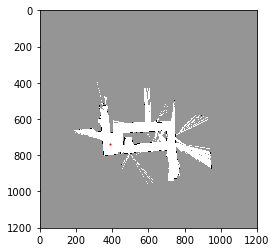

i: 14350
c_array
(100,)
[-537. -164. -594.  -83. -383. -245.   77. -318. -340.  -76. -286. -350.
 -213. -258. -309. -647. -354. -268. -461. -241.  120. -144.  215. -496.
 -422. -163.  215. -171. -311. -243. -282. -164. -471. -404. -615. -273.
 -197.    3.   96. -442. -288. -619.   76. -320. -292.  -26. -281.  -66.
 -159.  -13. -328. -435. -423. -399.  348. -617. -201. -626. -449.  127.
 -437. -273. -396. -340. -609. -306. -582. -397. -305. -243. -254. -269.
 -326. -500. -319.   42. -259.  -53. -769. -459.  -26. -211. -265. -657.
 -399. -341.  -62. -313. -416. -492. -258.  -59. -178. -262. -309. -241.
 -386. -224.  -72.  -13.]
np.max(c_array)
348.0
xy_w_scan shape
(2, 1062)
*****Updating map*****
particle states
[  6.96192938 -10.56577916  -2.74024419]
particle weights
[  0.00000000e+000   4.37749104e-223   0.00000000e+000   6.59292750e-188
   3.39423099e-318   2.90651274e-258   2.02392961e-118   5.75274406e-290
   1.60470960e-299   7.23002290e-185   4.54253700e-276   7.28537031e-304
  

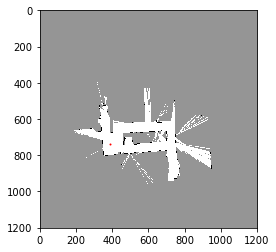

i: 14400
c_array
(100,)
[  85.  356. -618. -133. -634. -476. -339. -201.   97.   -1. -187. -548.
 -382.   79.   64. -654. -231. -219. -383. -226. -122. -692.  400.  185.
  -73. -458.  -33.  -49. -305. -647. -175. -442. -265. -207. -832.  -69.
  384.  357. -209. -305.  304. -657.  382. -391.  -67. -321.  112. -285.
  -92.  369. -177. -383. -789. -558.  -48.    8. -585.   52. -365. -470.
  231. -110. -147.  -88. -670.  -87. -308. -197.  460.   60. -348. -672.
 -143.  -64.  399. -160. -222. -199.   85. -306. -287. -409. -314. -128.
 -570.  457. -608.  222.  -63. -469. -811. -237.  372. -668. -451.  -81.
 -348. -215. -270. -341.]
np.max(c_array)
460.0
xy_w_scan shape
(2, 1046)
*****Updating map*****
particle states
[  6.89578236 -10.58657776  -2.78417083]
particle weights
[  1.31361491e-163   6.49041794e-046   0.00000000e+000   2.76866884e-258
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.13291519e-288
   2.13797120e-158   5.87682318e-201   9.78067865e-282   0.00000000e+000
  

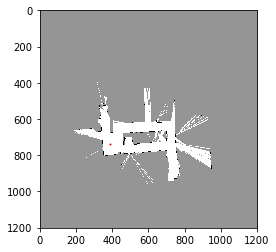

i: 14450
c_array
(100,)
[ 119.  287. -376. -693.  187. -231. -118.  334.  146.  -93. -238. -197.
 -798. -140. -299. -638. -129. -237. -234. -645. -626. -611.  183. -277.
 -545.  118. -207. -341.  370.  338. -482. -796. -267.   32. -219. -158.
 -423. -515.  296.  389. -194.  309. -283.  266. -136. -568. -352.  211.
 -118. -101.  -76. -500. -346.   80.   28. -295. -609. -450. -394. -335.
   13. -575. -156. -248. -511. -337.  316. -591. -210.  314.  179.  300.
 -639. -548. -130. -126. -405. -223.  335.  354. -201. -177.  253.   14.
   84. -649. -454. -442.   25. -518. -275. -157. -272. -375. -458. -216.
  356. -296. -627. -299.]
np.max(c_array)
389.0
xy_w_scan shape
(2, 1047)
*****Updating map*****
particle states
[  6.79383056 -10.63838591  -2.89961465]
particle weights
[  5.50161105e-118   5.03457533e-045   0.00000000e+000   0.00000000e+000
   1.87290027e-088   5.46287443e-270   6.49677270e-221   1.29958142e-024
   2.92712248e-106   4.67799464e-210   4.98149667e-273   3.18737823e-255
  

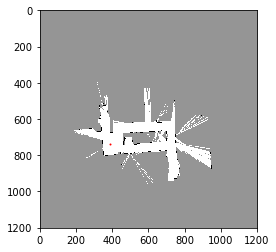

i: 14500
c_array
(100,)
[-400. -792. -225. -625. -275. -176. -778. -258. -279. -167. -120. -396.
 -806. -296. -553. -143. -482. -201. -532. -465. -698. -664. -377. -271.
  -22. -366. -209.   22. -139.  203. -479.  -46. -142.  -84. -407. -545.
 -527. -247. -261. -587. -654.  318. -242. -315.  298. -140. -474.  313.
 -357. -275. -371. -363. -125.  -58.  -91. -154. -652.  -93. -611. -355.
   -6.    9. -466.   52. -221. -164. -181. -590. -432. -544. -411. -445.
 -755. -650. -769. -651.  -25. -337. -402. -265.  142. -176.  351. -259.
 -132. -251. -570.  318. -152. -161. -507. -309.  -98. -220. -332.  -41.
 -535.  331. -277. -289.]
np.max(c_array)
351.0
xy_w_scan shape
(2, 1030)
*****Updating map*****
particle states
[  6.66591245 -10.6968812   -3.0001546 ]
particle weights
[  0.00000000e+000   0.00000000e+000   7.02066778e-251   0.00000000e+000
   1.35411119e-272   1.33908466e-229   0.00000000e+000   3.27084919e-265
   2.48014116e-274   1.08507154e-225   2.80090915e-205   0.00000000e+000
  

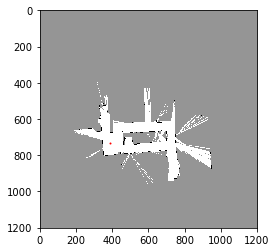

i: 14550
c_array
(100,)
[-386. -443. -101. -178.  -43. -274. -190. -202. -367. -121.  -56. -225.
 -300.  282. -165.  -63.  326.  304. -273. -397.  -83. -167. -302. -293.
 -608. -148. -229.  274.  298. -562. -106. -647. -678. -775. -101.   69.
 -741. -189. -220. -573. -285. -348.  311. -111. -773.  296. -151. -417.
 -628. -817. -242.   91. -221. -380.  151. -432. -465. -535. -326. -212.
 -106. -220. -324. -389. -158. -267. -399. -364. -399.  224.  244. -584.
 -149. -278.  225. -203. -244. -335.   15. -357. -174. -109. -520. -751.
 -130. -562.   78. -194. -438. -205. -684. -506.  159. -607. -387. -297.
 -759. -723. -596. -310.]
np.max(c_array)
326.0
xy_w_scan shape
(2, 1049)
*****Updating map*****
particle states
[  6.54388936 -10.69314135  -3.11007304]
particle weights
[  6.05799279e-310   0.00000000e+000   3.59961534e-186   1.30491129e-219
   5.56334567e-161   2.65039574e-261   8.01765205e-225   4.92621568e-230
   1.08124449e-301   7.41936020e-195   1.25749938e-166   5.05522323e-240
  

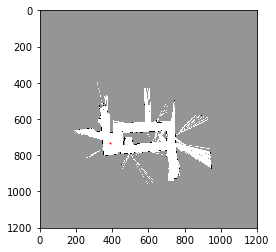

i: 14600
c_array
(100,)
[ -11.  139.  281. -519.  219. -693. -169. -588. -521.  323.  103. -354.
 -566. -554. -233.   44. -338.  174. -469. -230. -270. -503. -558. -263.
 -438. -588. -303. -323. -492.  172. -213. -305. -715. -681. -241. -381.
 -413. -511. -336.   -2. -440. -472. -391. -284. -177. -515. -167. -272.
 -275. -183. -426. -230. -126.   23.  155. -242.    8. -299. -191.  -44.
 -172. -523. -131.   28. -528.  242. -223. -330. -453.  328. -360.  253.
 -641.  -73.  -95. -588.  102. -444. -575.  228. -277. -531. -503. -287.
 -380. -424. -125. -421. -109. -447. -505.  211. -251. -575. -757. -587.
 -170. -149. -382.  300.]
np.max(c_array)
328.0
xy_w_scan shape
(2, 1025)
*****Updating map*****
particle states
[  6.41807092 -10.66634359  -3.15933413]
particle weights
[  5.90546631e-148   8.23050497e-083   3.84806954e-021   0.00000000e+000
   4.56021201e-048   0.00000000e+000   1.42143189e-216   0.00000000e+000
   0.00000000e+000   6.69285092e-003   1.90908442e-098   6.43053199e-297
  

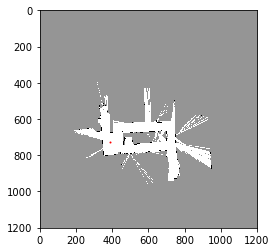

i: 14650
c_array
(100,)
[-435.  198. -272. -192. -190. -433. -232. -174. -323. -529. -275. -307.
 -669. -709.  -63. -149. -283. -237.  354. -237. -466. -198. -320. -441.
 -617.   35. -181. -462. -475. -148. -331. -431.  -78. -443. -527. -570.
  -85.  222.  241. -236. -112.  142. -728. -432. -338. -532. -618. -130.
 -454. -514. -472. -355. -238. -318. -219. -416. -510. -163. -647. -705.
 -389. -443.   60. -466.  339.  356.  201. -380.  401. -526. -206. -415.
 -253. -357. -356. -166.   -9. -171. -216.  367. -368. -749. -234. -409.
 -565. -334. -284.  365. -167. -388. -521. -273. -334. -327.  260. -340.
 -415. -371. -277. -504.]
np.max(c_array)
401.0
xy_w_scan shape
(2, 1042)
*****Updating map*****
particle states
[  6.35268142 -10.70372898  -3.09554336]
particle weights
[  0.00000000e+000   6.89001510e-089   5.24582356e-293   2.90651274e-258
   2.14763857e-257   0.00000000e+000   1.23478958e-275   1.90841537e-250
   3.72216064e-315   0.00000000e+000   2.61174176e-294   3.30755300e-308
  

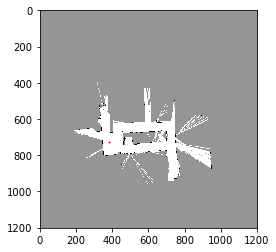

i: 14700
c_array
(100,)
[  27. -224. -125.  239. -196. -570.  256. -151. -508. -383. -164. -483.
  286.  334. -277. -435.  359. -554. -735. -362. -465. -157. -118.  419.
 -619. -549.  -46. -210.  -31. -647. -433. -562. -571. -466. -526.  203.
  -65. -680. -384. -231. -456. -276. -211. -560. -776.  434. -363.  -99.
 -123. -326. -382.  236. -133. -596. -526. -359. -723. -588. -185. -290.
 -725. -296. -311. -353. -685.  129. -530. -354. -420. -619. -452. -267.
 -561. -380.   -9. -604. -563. -227. -117. -183. -467. -544.   95. -148.
 -286. -607. -808.   15. -381. -154.   49. -458. -560. -216. -154.  -68.
 -245.  355.  390.   20.]
np.max(c_array)
434.0
xy_w_scan shape
(2, 1033)
*****Updating map*****
particle states
[  6.24213658 -10.81894211  -3.14516428]
particle weights
[  1.74640808e-177   1.71486831e-286   1.69583847e-243   2.05388393e-085
   2.48014041e-274   0.00000000e+000   4.96114692e-078   8.66418973e-255
   0.00000000e+000   0.00000000e+000   1.95839228e-260   0.00000000e+000
  

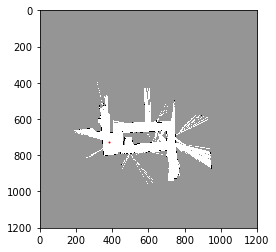

i: 14750
c_array
(100,)
[ 210. -330. -475. -159. -614. -279. -708. -165. -345. -123. -159. -141.
  100. -225. -445. -182. -482. -316. -165. -297. -258. -117. -567. -315.
  -95. -392. -370. -477. -167. -398. -631. -710. -621. -430. -501. -547.
 -594. -328. -569. -158.   81.   63.  240.  360.  -95. -102. -306. -350.
 -242. -114. -711. -171. -149.  -65.  205. -167. -288. -253. -399. -633.
  -80. -539. -528. -513.  -36. -300. -426. -157. -291. -514. -492. -625.
 -162.  385.  291. -273.  361.   98. -527. -735.   33.   44. -125. -100.
 -544. -232. -727. -573.  118.  123. -463.  -97. -721. -616. -714.  -62.
   19. -185. -290. -541.]
np.max(c_array)
385.0
xy_w_scan shape
(2, 1052)
*****Updating map*****
particle states
[  6.09673508 -10.88350464  -3.13018437]
particle weights
[  9.96473301e-077   3.01609793e-311   0.00000000e+000   5.54372712e-237
   0.00000000e+000   4.25073486e-289   0.00000000e+000   1.37415257e-239
   9.22618187e-318   2.39002912e-221   5.54372712e-237   3.64000951e-229
  

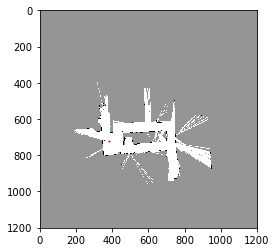

i: 14800
c_array
(100,)
[-548.  198. -575.  247. -110. -207.  -39. -140. -488. -238. -428. -108.
 -484. -273. -522.  202. -130. -122. -490. -197.  -22. -152. -185. -366.
 -599. -725.   74. -594. -350.  234. -398.  170. -120. -548. -177. -179.
 -567.  -96. -567. -291. -426.  128. -410. -651. -400. -303. -530. -546.
 -198.  -28. -442. -213. -567. -563. -453. -338. -323. -291. -560.  346.
 -168.  270. -140.  258. -135. -309. -613. -447. -581. -280.  -79. -389.
 -279. -517.  123. -282. -522. -307. -134.   49. -243. -408. -306.   39.
 -245. -298. -266. -300. -304.  264.   12. -660. -467. -270. -540. -265.
 -293.  -24. -283. -613.]
np.max(c_array)
346.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[  6.00780194 -10.92804302  -3.09500929]
particle weights
[  0.00000000e+000   5.30171867e-065   0.00000000e+000   1.01122149e-043
   9.15622070e-199   6.84150278e-241   6.26072268e-168   8.56804611e-212
   0.00000000e+000   2.35517167e-254   0.00000000e+000   6.76558284e-198
  

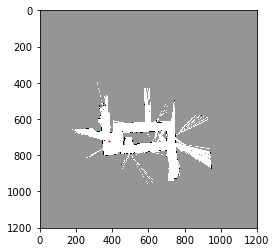

i: 14850
c_array
(100,)
[-116. -240. -375.  431. -415.    0. -666. -498. -204. -599. -121. -371.
 -432. -330. -322.  381.  -18. -487. -371. -627. -534. -118.  -62.   90.
 -610. -503. -310. -294. -173. -316. -458. -363. -161. -331. -177. -181.
  -72. -270. -689. -285. -701. -664. -601. -350. -164. -189.  221.  -95.
 -484. -519.  147. -172. -156. -191.  230. -288. -413.  -49. -536. -309.
 -392. -460.  -73. -329. -587. -187. -698. -100. -391.  -72. -180. -117.
 -344. -236.  331. -308.  310.  311. -574.  321.  280. -369. -620. -325.
 -394. -532. -505. -331. -337. -472. -314. -378. -598. -610. -608. -399.
 -148. -683. -313. -482.]
np.max(c_array)
431.0
xy_w_scan shape
(2, 1043)
*****Updating map*****
particle states
[  5.87593274 -10.94274546  -3.07827382]
particle weights
[  2.76005921e-238   3.87616846e-292   0.00000000e+000   1.00000000e+000
   0.00000000e+000   6.59292750e-188   0.00000000e+000   0.00000000e+000
   1.67110597e-276   0.00000000e+000   1.85971327e-240   0.00000000e+000
  

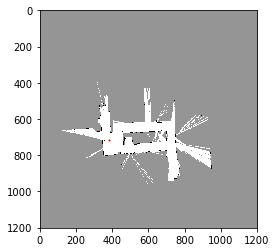

i: 14900
c_array
(100,)
[-415. -275. -601. -667.  294.  -87.  244.  -97. -482. -180. -495. -733.
 -741. -588.  -64.  171.  357. -453.  365. -298. -170. -399. -422. -237.
  258.  317. -550. -513. -586.  -86. -440. -125.  315. -448. -251.  -77.
 -692. -686. -467.  387. -380. -581. -299. -360. -537. -109. -187. -356.
  -77.  -69. -367. -177. -495. -366. -472. -496. -157.  198. -373. -350.
 -718. -744. -505. -522. -585.  -63.  332. -564. -520.  420. -460. -240.
 -616. -207. -492.  339. -537.  474. -521. -430. -396. -195. -469.  301.
 -331. -186. -799. -461. -413.  -98. -671. -596.  197. -300. -212.  458.
 -415. -599.  188.  440.]
np.max(c_array)
474.0
xy_w_scan shape
(2, 1045)
*****Updating map*****
particle states
[  5.77226026 -11.07500773  -3.1044811 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.71418353e-079   2.29506824e-244   1.29499805e-100   1.04195937e-248
   0.00000000e+000   9.36286554e-285   0.00000000e+000   0.00000000e+000
  

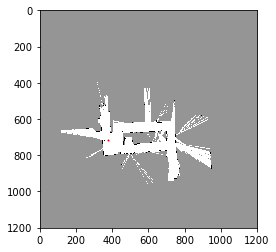

i: 14950
c_array
(100,)
[-364. -426. -398. -477. -180. -604.  -92. -484. -576.  214. -250. -652.
  -61. -460.  427. -372. -514. -323. -310.  321. -512. -214. -473. -177.
 -326. -788.  453. -558. -283. -333.  262. -130. -259. -406. -424.   44.
 -701.  277. -350. -467. -221.  131. -482. -298.  139.  292.  -60. -312.
 -215. -214. -464.  276. -387. -127. -450.  313. -524. -197. -331.  290.
 -140. -312. -415.  442. -640. -456. -644.  286. -128. -714. -461.  379.
 -199.    2. -514.  -71.  227. -474. -386.  -93. -464. -249. -505. -596.
 -427. -398. -571. -143. -654. -545. -518. -614. -229. -186. -380. -332.
 -656. -453. -295. -420.]
np.max(c_array)
453.0
xy_w_scan shape
(2, 1037)
*****Updating map*****
particle states
[  5.62834135 -11.17189679  -3.13663251]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.23476896e-275   0.00000000e+000   2.03938917e-237   0.00000000e+000
   0.00000000e+000   1.59812804e-104   4.90876192e-306   0.00000000e+000
  

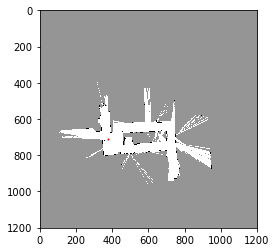

i: 15000
c_array
(100,)
[-584. -316. -241. -306. -521.  369. -215. -275. -508. -515. -221. -192.
 -266.  -83. -372. -238.  285. -314. -181.  256. -508. -502. -316. -445.
 -129. -604. -366. -501.  207.  223.  353. -280.  222. -517. -269.  231.
 -184. -287. -807. -393. -389. -403. -340. -417. -237. -216. -568. -522.
   97. -197.   -3. -299. -516. -347. -505. -132. -514.  250. -290. -594.
 -193. -472. -197. -273. -143. -460.  286. -284. -283. -413. -217. -186.
 -324. -663. -133. -176. -131. -296. -566. -626. -540.  294. -135. -684.
 -282.  400. -572. -479. -299. -526.  142. -388. -585. -155. -204. -344.
 -363. -300. -332. -489.]
np.max(c_array)
400.0
xy_w_scan shape
(2, 1047)
*****Updating map*****
particle states
[  5.53638564 -11.16935007  -3.08835077]
particle weights
[  0.00000000e+000   1.10956042e-311   4.14225757e-279   2.44396947e-307
   0.00000000e+000   3.44247711e-014   8.10762456e-268   7.09945017e-294
   0.00000000e+000   0.00000000e+000   2.00967920e-270   7.90072077e-258
  

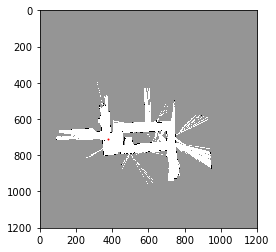

i: 15050
c_array
(100,)
[ 233. -526. -236. -651. -639. -500. -453. -715. -491. -731. -167. -533.
 -596. -486. -431. -558. -393. -495. -466. -509.  -24.  -85. -465. -174.
 -717. -388. -498. -411. -294. -592. -304. -291. -373. -516. -419. -532.
 -407.  195. -197. -231. -204. -367. -416. -421. -531. -153. -724. -517.
 -335. -121. -404. -554. -331. -464. -326. -716. -334. -580. -486. -531.
 -558. -476. -601. -217. -405. -615. -415. -219. -334. -405. -453. -373.
 -509. -526.  300. -335. -727. -378. -579. -229.  -63. -533. -450. -643.
 -649. -440. -707. -359. -512. -578. -435. -754. -548. -408. -720. -432.
 -485. -554. -605. -340.]
np.max(c_array)
300.0
xy_w_scan shape
(2, 1055)
*****Updating map*****
particle states
[  5.40283319 -11.22043949  -3.19419707]
particle weights
[  7.98490425e-030   0.00000000e+000   1.65256176e-233   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.52924458e-203   0.00000000e+000
  

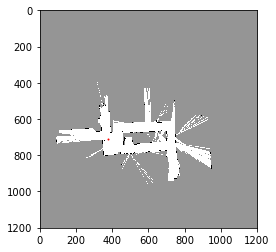

i: 15100
c_array
(100,)
[-351. -262. -243. -338. -458. -286. -288. -134. -471. -308. -233. -320.
  192. -387. -469. -123. -724. -306.  237.  330.  -21.  275.  -60.  109.
 -412. -586. -303. -332.  221.  -51. -390. -244. -585. -326.   73. -445.
 -229.  377. -528. -660. -428. -332. -272. -424. -380. -309.  -89. -244.
  277.  290. -256.  -74. -182. -408. -285.   36.  210. -180. -204. -291.
 -533. -254. -531. -307. -581.  210. -315. -460. -173. -415. -243. -412.
  371. -131. -534. -493. -309.  289.  -81. -744.  234.    8. -454.  -41.
 -458. -264. -369.   61. -138. -433. -238. -367. -612. -186. -425. -320.
 -543.  289.  213. -304.]
np.max(c_array)
377.0
xy_w_scan shape
(2, 1053)
*****Updating map*****
particle states
[  5.29947849 -11.31087381  -3.17880629]
particle weights
[  6.80050828e-317   3.05316930e-278   5.44936683e-270   3.00864026e-311
   0.00000000e+000   1.15261249e-288   1.55989138e-289   1.18698320e-222
   0.00000000e+000   3.21517577e-298   1.20030292e-265   1.97547227e-303
  

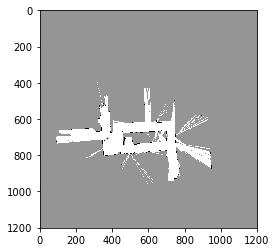

i: 15150
c_array
(100,)
[-573. -374. -472. -315. -265. -343. -301. -291. -307. -717. -417. -344.
 -380.  111. -272. -428. -486.   92. -328. -423. -616. -411. -286. -518.
 -592. -364.  227. -418. -530. -264. -589. -448. -571. -438. -433. -402.
 -357. -426. -334. -515. -335. -364. -189. -420. -431. -266. -416. -544.
 -133. -353. -687. -397. -440. -305. -492. -323. -672. -445. -371. -372.
 -361. -318. -630. -315. -374. -342. -434. -412. -507. -483. -502. -441.
 -518. -610. -552. -522. -198. -229. -377. -389. -298. -559. -335. -344.
 -460. -346. -406. -373. -547. -330. -372. -365. -314. -420. -323. -338.
 -434. -204. -309. -456.]
np.max(c_array)
227.0
xy_w_scan shape
(2, 1030)
*****Updating map*****
particle states
[  5.1679975  -11.43113552  -3.0408453 ]
particle weights
[  0.00000000e+000   9.75026403e-262   2.68013796e-304   4.09629107e-236
   2.12380629e-214   2.83233954e-248   4.92621719e-230   1.08507154e-225
   1.22108716e-232   0.00000000e+000   2.06230861e-280   1.04195949e-248
  

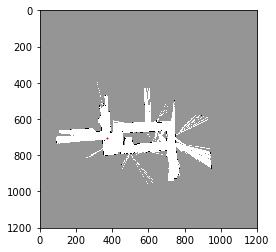

i: 15200
c_array
(100,)
[-411. -321. -449. -100.  188. -230. -501. -304.  176. -412. -398. -273.
 -296. -351. -334. -334. -382. -152. -374.  170. -468. -462.  264. -540.
  -90. -578. -566. -144.  -26. -502. -320. -533.  -67. -314. -419. -518.
 -366. -680. -258. -471. -277. -458. -421.  180. -199. -452. -457. -182.
 -326. -469. -543. -617. -611. -223. -569.  193. -434.  -42. -549. -377.
 -323. -181. -299. -639. -464. -452. -429. -386.  -66. -179. -334. -343.
 -610.  145.  233. -525. -240. -507.   45. -342. -277. -614. -147. -275.
 -290. -630. -407.  284.  -30. -427. -556. -412. -489. -327. -283. -196.
 -517.  172. -488. -483.]
np.max(c_array)
284.0
xy_w_scan shape
(2, 1034)
*****Updating map*****
particle states
[  5.07402656 -11.46970177  -3.01392895]
particle weights
[  1.46330574e-302   1.78582315e-263   4.59481051e-319   1.70184087e-167
   2.03109266e-042   5.92428988e-224   0.00000000e+000   4.31364737e-256
   1.24794646e-047   5.38320098e-303   6.47386056e-297   1.25306494e-242
  

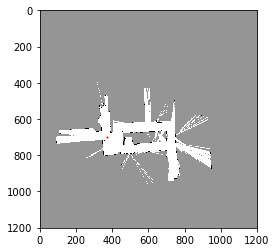

i: 15250
c_array
(100,)
[-580. -574. -193. -327. -610. -465. -579.  197.  254. -269. -555. -548.
 -176. -462. -324.   41. -682. -149. -355. -518. -562. -596. -593. -229.
 -548. -596. -128. -322. -206. -612. -601. -503. -408. -479. -449.  237.
  131. -474. -538. -502. -476. -184. -343. -532. -354. -566. -630. -312.
 -274. -372. -148. -312. -326. -491. -562. -456. -561.  155. -603. -519.
 -489. -550. -619. -427. -546. -496. -460. -339. -545. -448. -544. -432.
 -622.  230. -626. -377. -336. -249. -621. -406. -389. -435. -453. -391.
 -169. -498. -305. -458. -409. -481. -521. -409. -468. -587. -452. -427.
 -433. -434. -432. -552.]
np.max(c_array)
254.0
xy_w_scan shape
(2, 1041)
*****Updating map*****
particle states
[  4.94802387 -11.48661521  -3.07801105]
particle weights
[  0.00000000e+000   0.00000000e+000   7.41936217e-195   4.73048856e-253
   0.00000000e+000   5.52417584e-313   0.00000000e+000   1.75879213e-025
   9.99999959e-001   7.31115425e-228   0.00000000e+000   0.00000000e+000
  

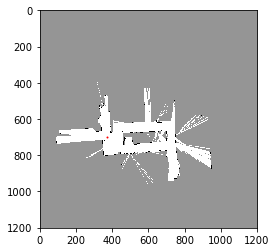

i: 15300
c_array
(100,)
[-210. -417. -335. -620. -149. -497. -181. -568. -186. -341.  143. -456.
 -425. -442.  240.  177.  154. -447.  -18. -317. -424.  204. -430. -234.
 -605. -152. -291. -237.  205. -464. -164. -582. -437. -585. -363.  -35.
  250.   39.  -60. -268. -429. -347.  170. -635. -436. -462.  175. -332.
 -205.  206. -531.  165. -465. -675.  101. -266. -147. -520. -410. -484.
 -479. -439. -142. -309. -459. -385. -398.  143. -555. -199. -518. -318.
 -434.  143. -321. -280. -392. -450. -467. -123. -650. -148. -135. -459.
 -479. -309. -199. -433. -345. -319. -310. -316. -381. -142. -293.  139.
 -370.  158. -130. -409.]
np.max(c_array)
250.0
xy_w_scan shape
(2, 1033)
*****Updating map*****
particle states
[  4.94381619 -11.50227537  -3.09086688]
particle weights
[  1.67694419e-200   2.11622019e-290   8.66379904e-255   0.00000000e+000
   5.20573437e-174   0.00000000e+000   6.59262819e-188   0.00000000e+000
   4.44207793e-190   2.14754107e-257   3.39211619e-047   2.44385852e-307
  

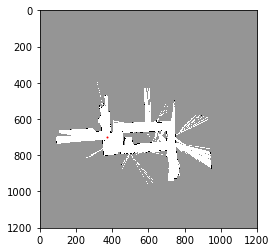

i: 15350
c_array
(100,)
[-387. -592. -593. -499. -280. -365. -584. -325. -589. -516. -578. -234.
 -570. -500. -424. -560. -492.  -92. -638. -490. -415. -456. -560. -649.
 -337. -468. -424. -305. -507. -512. -456. -584. -535. -599. -638. -395.
 -423. -489. -396. -537. -535. -362. -390. -627. -543.  155. -635. -612.
 -568. -524. -272. -576. -590. -641. -339. -451. -668. -463. -476. -487.
 -467. -349. -373. -639. -343. -656. -365. -407. -198. -360. -201. -476.
 -244. -336. -442. -519. -235. -410.   71.  138. -560. -536. -516. -623.
 -413. -220. -439. -580. -617. -459. -645. -589. -537. -621. -552. -473.
 -368. -210. -292.  -89.]
np.max(c_array)
155.0
xy_w_scan shape
(2, 1022)
*****Updating map*****
particle states
[  4.93245497 -11.48839123  -3.20338575]
particle weights
[  4.09629090e-236   0.00000000e+000   0.00000000e+000   9.36286620e-285
   1.20753674e-189   1.46848459e-226   9.88131292e-322   3.45659636e-209
   0.00000000e+000   3.87616830e-292   4.59481051e-319   1.14669131e-169
  

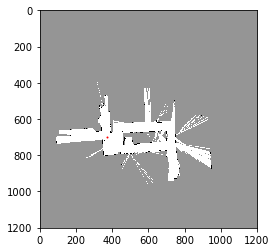

i: 15400
c_array
(100,)
[-358. -201. -559. -592. -508. -528. -666. -522. -524. -460. -517. -556.
 -611.   81. -279. -246. -392. -496.  -66. -341. -352. -513. -483. -530.
 -327. -454. -482. -573. -457. -524. -633. -338. -639. -571. -633. -501.
 -542.  -29. -295. -544. -489. -592. -654. -526. -573. -509. -335. -581.
 -578. -339. -433. -597. -551. -674. -483. -218. -117. -302. -390. -373.
 -508. -613. -495. -367. -223. -464. -218. -348. -581. -455. -412. -347.
 -782. -601. -642. -515. -655. -212. -580. -501. -194. -616. -448. -426.
  160. -525. -432. -549. -306. -631. -601. -443. -556. -555. -356. -540.
 -128. -592. -126. -587.]
np.max(c_array)
160.0
xy_w_scan shape
(2, 1000)
*****Updating map*****
particle states
[  4.95789784 -11.4742482   -3.31099843]
particle weights
[  1.08507154e-225   1.65841048e-157   5.52417606e-313   0.00000000e+000
   7.78549246e-291   1.60470960e-299   0.00000000e+000   6.47386058e-297
   8.76141755e-298   5.46287446e-270   9.60806100e-295   1.10956042e-311
  

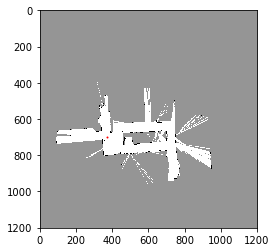

i: 15450
c_array
(100,)
[-396. -496. -565. -208. -496. -484. -637. -524. -358. -343. -316. -617.
 -586. -464. -489. -380. -352. -432.   -6. -464. -362. -368. -402. -602.
 -513. -489. -429. -509. -567. -568. -197. -295. -637. -275. -353.  -69.
 -582. -380. -646. -504.  -84.  199. -717. -557.  -36. -602. -454. -434.
 -487. -327. -472. -383. -383. -604. -401. -612. -617. -519. -513. -414.
 -460. -498. -610. -682.  227. -641. -505. -470. -606. -512. -640. -462.
 -461. -385. -513. -500. -567. -305. -682. -302. -471. -562. -553. -575.
 -602. -524. -603. -462. -631. -511. -502. -445. -454. -280.  124. -623.
    9. -335. -321. -562.]
np.max(c_array)
227.0
xy_w_scan shape
(2, 989)
*****Updating map*****
particle states
[  4.93321232 -11.48872993  -3.42436158]
particle weights
[  2.71980504e-271   1.01178814e-314   0.00000000e+000   1.20753679e-189
   1.01178814e-314   1.64673368e-309   0.00000000e+000   0.00000000e+000
   8.66419238e-255   2.83233954e-248   1.50694127e-236   0.00000000e+000
   

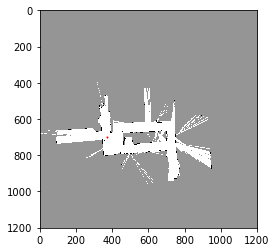

i: 15500
c_array
(100,)
[-447. -342. -372. -311. -468. -515. -307. -544. -494. -427.   27.  -33.
 -258.  186. -404. -544. -289. -643. -507. -478. -439. -482. -248. -604.
 -601.  -80. -274. -399. -447. -638. -663. -484. -512. -569. -321. -391.
 -648. -464. -476. -604. -348. -319. -371.  -48. -300. -523. -287. -277.
 -629. -437. -491. -561. -306. -357. -571. -220. -559. -475. -310. -641.
 -473. -417. -632. -580. -473. -273. -542. -529. -612. -619. -454. -661.
 -548. -419. -531. -602. -501. -288. -602. -396. -372. -497. -634. -349.
 -350.  186. -427.  192. -592. -339. -523. -389. -374. -533. -497.  -63.
 -317. -568. -644. -471.]
np.max(c_array)
192.0
xy_w_scan shape
(2, 996)
*****Updating map*****
particle states
[  4.94908972 -11.45450072  -3.53303523]
particle weights
[  3.04563859e-278   1.21506348e-232   1.13701059e-245   3.52961962e-219
   2.30937386e-287   8.94650887e-308   1.92710702e-217   2.26133846e-320
   1.17987967e-298   1.47763784e-269   2.18405107e-072   1.91246667e-098
   

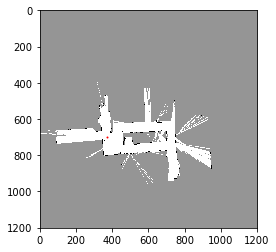

i: 15550
c_array
(100,)
[-515. -582. -444. -634. -434. -373. -540. -439. -425. -422. -648. -482.
 -371. -424. -302. -370. -545. -497. -303. -387. -435. -578. -391. -547.
 -502. -427. -459. -628. -673. -420. -361. -510. -610. -486. -511. -546.
 -575. -496. -594. -595. -563. -484. -501. -484. -354. -563. -525. -231.
 -595. -521. -395. -360. -218. -569.   95. -614. -154. -618. -502. -278.
 -299. -559. -603. -291. -488. -339. -398. -583.   -9. -508. -375. -610.
  -96. -427. -293. -435. -631. -608. -557. -592. -633. -593. -554. -278.
 -619. -591. -568. -441. -414. -631. -621. -624. -473. -479. -559. -457.
 -603. -370. -660. -304.]
np.max(c_array)
95.0
xy_w_scan shape
(2, 994)
*****Updating map*****
particle states
[  4.91063648 -11.4523086   -3.65017676]
particle weights
[  1.20327817e-265   9.60806100e-295   8.22762055e-235   2.50797603e-317
   1.81225403e-230   5.62577643e-204   1.67110597e-276   1.22108716e-232
   1.46848465e-226   2.94953026e-225   0.00000000e+000   2.58275935e-251
   4

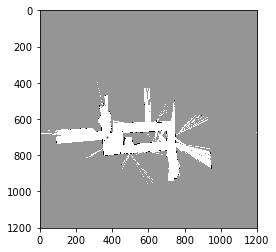

i: 15600
c_array
(100,)
[-133. -568. -275. -598. -298. -551.   60. -154. -283.  213. -356.   22.
 -531. -307.   57. -376. -116. -477. -297. -265. -166. -453. -397. -301.
 -385.   68.   66. -491. -340. -501. -366. -557. -374. -176. -419.  -30.
 -239. -190. -286. -206. -430. -261.   23. -431. -464. -244.  -63. -248.
  -30. -488. -297. -467.    0. -348.  -61. -379. -338. -604. -519. -579.
 -376. -458. -332. -525. -453. -533. -426. -453. -218. -659. -290. -117.
 -629. -286.  166. -505. -219. -348. -512. -504. -286. -651.  148. -495.
  -92. -491. -655.   98.  -23. -624.  156. -429. -566.   -8. -447. -343.
 -347. -463.  202. -406.]
np.max(c_array)
213.0
xy_w_scan shape
(2, 999)
*****Updating map*****
particle states
[  4.91381777 -11.44356865  -3.69047201]
particle weights
[  5.42128212e-151   0.00000000e+000   1.15953958e-212   0.00000000e+000
   1.18990556e-222   0.00000000e+000   3.57221028e-067   4.11071993e-160
   3.88982195e-216   9.99983299e-001   7.69896852e-248   1.12136424e-083
   

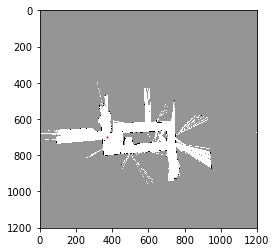

i: 15650
c_array
(100,)
[-655. -479. -674. -568. -638. -688. -590. -648. -660. -722. -703. -594.
 -672. -546. -628. -701. -667. -344. -663. -726. -661. -662. -674. -678.
 -669. -652. -669. -682. -632. -675. -678. -575. -695. -724. -746. -748.
 -600. -665. -578. -709. -659. -528. -668. -651. -440. -655. -684. -685.
 -509. -645. -768. -684. -667. -530. -631. -401. -545. -631. -689. -596.
 -662. -652. -598. -656. -701. -586. -713. -706. -700. -682. -671. -675.
 -697. -734. -702. -659. -730. -663. -664. -714. -479. -625. -680. -652.
 -565. -743. -651. -554. -687. -699. -560. -672. -685. -681. -682. -609.
 -608. -744. -722. -695.]
np.max(c_array)
-344.0
xy_w_scan shape
(2, 1036)
particle states
[  4.93984703 -11.43059648  -3.84829211]
particle weights
[  8.59836997e-136   2.34555134e-059   4.81749166e-144   5.22439558e-098
   2.07693220e-128   4.00588267e-150   1.45732848e-107   9.42925762e-133
   5.79353612e-138   6.86571609e-165   1.22540881e-156   2.66919022e-109
   3.55967162e-143   1.8

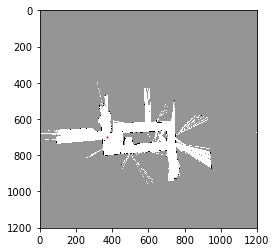

i: 15700
c_array
(100,)
[-624. -637. -604. -477. -701. -631. -575. -748. -587. -636. -571. -711.
 -524. -641. -727. -627. -567. -690. -552. -653. -723. -714. -627. -696.
 -687. -593. -594. -550. -716. -634. -692. -643. -607. -672. -529. -613.
 -643. -711. -588. -383. -691. -628. -707. -639. -640. -669. -682. -646.
 -683. -535. -649. -659. -653. -664. -695. -706. -671. -638. -642. -568.
 -631. -683. -553. -629. -642. -620. -570. -599. -643. -646. -697. -703.
 -573. -637. -688. -630. -713. -742. -645. -702. -591. -560. -664. -709.
 -694. -634. -462. -559. -655. -612. -597. -580. -712. -613. -559. -496.
 -579. -600. -619. -719.]
np.max(c_array)
-383.0
xy_w_scan shape
(2, 1019)
particle states
[  4.90715275 -11.42075794  -3.95703891]
particle weights
[  2.16286723e-105   4.88879241e-111   1.04934790e-096   1.50078576e-041
   7.84069851e-139   1.97227962e-108   4.12533740e-084   3.03748474e-159
   2.53469490e-089   1.32891156e-110   2.25235791e-082   3.55967162e-143
   5.81404049e-062   8.9

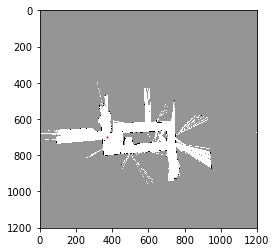

i: 15750
c_array
(100,)
[-688. -678. -693. -732. -632. -663. -647. -553. -665. -663. -538. -683.
 -699. -732. -692. -519. -715. -644. -697. -745. -692. -494. -741. -634.
 -604. -617. -572. -587. -706. -683. -675. -696. -735. -646. -538. -627.
 -598. -717. -629. -662. -543. -679. -613. -553. -717. -571. -659. -661.
 -681. -611. -334. -604. -568. -612. -360. -649. -722. -649. -579. -708.
 -739. -485. -673. -656. -686. -675. -688. -648. -630. -684. -579. -515.
 -724. -651. -481. -633. -560. -635. -586. -644. -616. -572. -628. -655.
 -506. -759. -328. -607. -728. -679. -707. -701. -549. -340. -632. -405.
 -656. -661. -675. -669.]
np.max(c_array)
-328.0
xy_w_scan shape
(2, 1051)
particle states
[  4.91996253 -11.22001599  -4.09215089]
particle weights
[  4.49685285e-157   9.90497755e-153   3.02995562e-159   3.49906067e-176
   9.40588497e-133   3.23795437e-146   2.87728204e-139   1.91718372e-098
   4.38209472e-147   3.23795437e-146   6.26730690e-092   6.67392138e-155
   7.51050908e-162   3.4

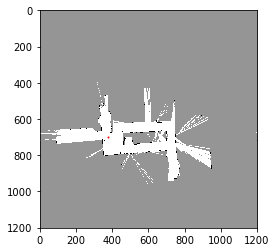

i: 15800
c_array
(100,)
[-673. -727. -661. -668. -584. -723. -674. -699. -666. -642. -691. -625.
 -551. -749. -662. -745. -563. -482. -640. -586. -646. -591. -625. -552.
 -537. -502. -622. -576. -477. -406. -657. -514. -685. -353. -667. -643.
 -606. -589. -640. -655. -550. -411. -666. -671. -431. -612. -590. -721.
 -583. -598. -536. -587. -547. -633. -592. -485. -587. -597. -535. -518.
 -539. -571. -650. -461. -372. -449. -561. -596. -693. -622. -736. -595.
 -570. -553. -559. -621. -643. -734. -660. -485. -629. -637. -647. -683.
 -619. -491. -525. -598. -670. -578. -537. -646. -620. -582. -657. -537.
 -750. -584. -717. -643.]
np.max(c_array)
-353.0
xy_w_scan shape
(2, 1037)
particle states
[  4.93983824 -11.60010514  -4.20562017]
particle weights
[  1.06112315e-139   3.74855395e-163   1.72702877e-134   1.57484639e-137
   4.76403209e-101   2.04664111e-161   3.90365391e-140   5.42137263e-151
   1.16366283e-136   3.08244068e-126   1.61608840e-147   7.44562090e-119
   1.02256890e-086   1.0

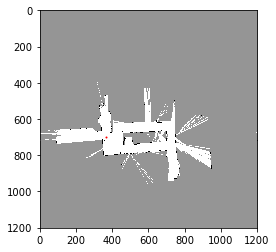

i: 15850
c_array
(100,)
[-595. -679. -530. -574. -629. -531. -518. -634. -395. -554. -583. -432.
 -539. -495. -672. -678. -643. -637. -626. -486. -611. -618. -625. -604.
 -528. -553. -674. -590. -500. -682. -427. -537. -588. -575. -643. -678.
 -588. -452. -470. -641. -653. -680. -555. -653. -684. -641. -444. -605.
 -533. -629. -511. -592. -495. -385. -615. -646. -500. -573. -431. -664.
 -681. -477. -610. -652. -558. -638. -703. -579. -673. -477. -514. -654.
 -733. -587. -385. -647. -614. -661. -636. -667. -595. -558. -646. -588.
 -632. -662. -529. -689. -668. -488. -677. -578. -765. -568. -525. -669.
 -601. -585. -380. -491.]
np.max(c_array)
-380.0
xy_w_scan shape
(2, 1021)
particle states
[  4.96041193 -11.54088042  -4.29269645]
particle weights
[  4.17708042e-094   1.38081774e-130   7.07968867e-066   5.50879938e-085
   7.15913335e-109   2.60447191e-066   1.15225325e-060   4.82378611e-111
   3.01834735e-007   2.67267773e-076   6.79839852e-089   2.57557017e-023
   8.73702992e-070   1.1

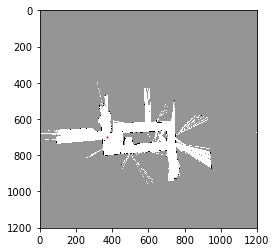

i: 15900
c_array
(100,)
[-516. -642. -668. -626. -464. -630. -672. -494. -610. -624. -605. -465.
 -630. -723. -482. -614. -669. -667. -506. -597. -516. -634. -648. -572.
 -429. -382. -361. -645. -459. -700. -508. -592. -461. -532. -599. -510.
 -465. -648. -620. -583. -423. -633. -533. -517. -541. -608. -620. -412.
 -627. -480. -615. -565. -597. -407. -564. -562. -393. -670. -543. -466.
 -382. -605. -588. -532. -425. -555. -530. -335. -597. -683. -582. -611.
 -691. -363. -614. -668. -543. -487. -625. -365. -701. -504. -470. -611.
 -656. -447. -473. -403. -756. -618. -438. -631. -408. -609. -682. -454.
 -541. -567. -472. -657.]
np.max(c_array)
-335.0
xy_w_scan shape
(2, 1048)
particle states
[  4.94505282 -11.5099183   -4.3589881 ]
particle weights
[  2.47001036e-079   4.69455094e-134   2.39848787e-145   4.17162985e-127
   9.46262947e-057   7.64060659e-129   4.39298377e-147   8.85477188e-070
   3.70695639e-120   3.08244070e-126   5.50161108e-118   3.48110684e-057
   7.64060659e-129   3.1

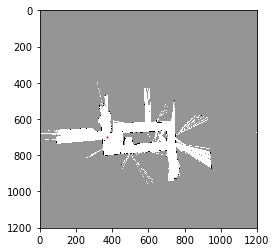

i: 15950
c_array
(100,)
[-447. -554. -450. -596. -440. -484. -576. -604. -464. -586. -422. -539.
 -600. -483. -599. -453. -517. -470. -568. -562. -595. -581. -576. -478.
 -479. -638. -414. -635. -580. -468. -670. -646. -484. -481. -476. -510.
 -457. -697. -587. -483. -575. -440. -469. -484. -611. -445. -537. -516.
 -558. -551. -562. -500. -568. -446. -458. -451. -447. -530. -610. -442.
 -516. -491. -520. -453. -371. -451. -577. -578. -497. -474. -473. -442.
 -457. -546. -481. -590. -477. -473. -447. -635. -621. -451. -578. -452.
 -522. -447. -579. -454. -533. -532. -470. -423. -444. -493. -585. -449.
 -599. -351. -464. -573.]
np.max(c_array)
-351.0
xy_w_scan shape
(2, 1022)
particle states
[  4.9539093  -11.56166849  -4.26402359]
particle weights
[  2.03109266e-042   6.89001508e-089   1.01122149e-043   3.96142951e-107
   2.22736356e-039   1.73314104e-058   1.92194772e-098   1.32891155e-110
   8.40859711e-050   8.72562917e-103   1.46248622e-031   2.25235790e-082
   7.25561124e-109   4.7

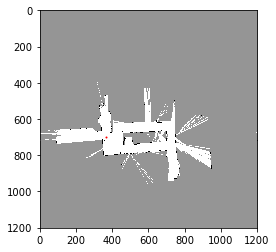

i: 16000
c_array
(100,)
[-513. -471. -350. -550. -452. -577. -434. -434. -426. -380. -537. -543.
 -629. -438. -501. -498. -570. -418. -424. -442. -543. -514. -454. -605.
 -439. -433. -419. -562. -434. -518. -415. -594. -440. -343. -543. -422.
 -529. -460. -524. -420. -589. -525. -529. -535. -398. -474. -410. -431.
 -544. -458. -575. -446. -547. -542. -429. -428. -575. -544. -601. -464.
 -428. -589. -439. -415. -426. -375. -486. -404. -520. -424. -542. -407.
 -411. -441. -428. -355. -594. -491. -388. -541. -677. -612. -530. -419.
 -541. -464. -417. -623. -423. -547. -445. -476. -566. -421. -566. -604.
 -416. -507. -554. -492.]
np.max(c_array)
-343.0
xy_w_scan shape
(2, 1038)
particle states
[  4.9509122  -11.59706314  -4.16454336]
particle weights
[  1.47754108e-074   2.56985018e-056   9.11045602e-004   1.26079284e-090
   4.58672774e-048   2.36969648e-102   3.01164402e-040   3.01164402e-040
   8.97758429e-037   8.52522125e-017   5.57791639e-085   1.38262724e-087
   6.18556913e-125   5.5

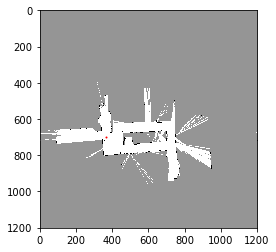

i: 16050
c_array
(100,)
[-557. -472. -454. -321. -457. -530. -450. -427. -385. -453. -509. -373.
 -480. -593. -420. -456. -318. -723. -458. -508. -485. -520. -458. -440.
 -441. -318. -510. -546. -414. -460. -411. -564. -463. -310. -480. -488.
 -457. -543. -627. -527. -466. -512. -324. -564. -453. -438. -424. -451.
 -616. -456. -504. -461. -544. -561. -416. -665. -334. -509. -547. -455.
 -552. -602. -525. -689. -469. -451. -458. -470. -451. -464. -428. -458.
 -503. -496. -415. -629. -506. -651. -559. -311. -411. -692. -607. -514.
 -423. -419. -668. -456. -484. -499. -558. -309. -530. -469. -449. -465.
 -454. -460. -481. -551.]
np.max(c_array)
-309.0
xy_w_scan shape
(2, 1056)
particle states
[  4.90503328 -11.25560226  -4.07423508]
particle weights
[  1.31182016e-108   1.07871139e-071   7.08281563e-064   4.08669315e-006
   3.52632626e-065   6.97951608e-097   3.86708630e-062   3.76839959e-052
   6.55428298e-034   1.92530890e-063   9.20469562e-088   1.06674096e-028
   3.61867356e-075   3.0

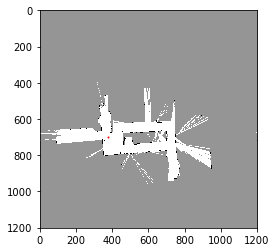

i: 16100
c_array
(100,)
[-475. -597. -456. -334. -437. -588. -594. -577. -526. -509. -465. -454.
 -455. -606. -574. -483. -588. -512. -588. -524. -590. -591. -429. -584.
 -597. -433. -571. -569. -514. -460. -592. -434. -367. -507. -424. -531.
 -622. -487. -649. -474. -541. -341. -674. -468. -583. -644. -501. -608.
 -540. -513. -598. -509. -654. -579. -439. -532. -433. -668. -492. -439.
 -456. -529. -529. -579. -427. -534. -456. -427. -540. -659. -540. -340.
 -467. -458. -553. -570. -519. -505. -516. -588. -520. -531. -492. -436.
 -513. -439. -333. -438. -397. -559. -528. -512. -557. -612. -537. -515.
 -456. -334. -504. -529.]
np.max(c_array)
-333.0
xy_w_scan shape
(2, 1073)
particle states
[  4.93726608 -11.46455336  -3.95413374]
particle weights
[  1.23135193e-062   1.27777799e-115   2.19774525e-054   2.11789362e-001
   3.92258630e-046   1.03539423e-111   2.56648569e-114   6.19933407e-107
   8.73702578e-085   2.11042445e-077   2.71223311e-058   1.62392630e-053
   5.97409098e-054   1.5

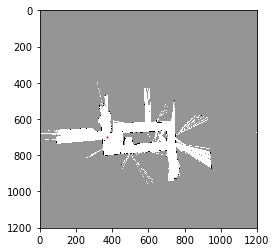

i: 16150
c_array
(100,)
[-479. -457. -613. -517. -510. -412. -444. -299. -430. -411. -561. -495.
 -386. -367. -412. -421. -504. -408. -597. -511. -455. -422. -509. -415.
 -532. -425. -464. -427. -444. -496. -604. -524. -415. -316. -563. -446.
 -491. -383. -384. -481. -521. -396. -401. -471. -426. -351. -498. -506.
 -409. -414. -443. -423. -475. -408. -469. -491. -474. -280. -605. -432.
 -526. -419. -502. -625. -462. -446. -409. -435. -578. -576. -484. -354.
 -484. -291. -512. -448. -519. -477. -445. -483. -419. -512. -467. -477.
 -511. -413. -415. -501. -446. -614. -486. -314. -380. -463. -447. -440.
 -492. -311. -530. -464.]
np.max(c_array)
-280.0
xy_w_scan shape
(2, 1064)
particle states
[  4.93439861 -11.43736605  -3.86630612]
particle weights
[  3.76175793e-087   1.34855743e-077   2.39844780e-145   1.18086577e-103
   1.29497656e-100   4.71108709e-058   5.96619868e-072   5.60270283e-009
   7.17497610e-066   1.28060624e-057   9.18847270e-123   4.23330086e-094
   9.22099237e-047   1.6

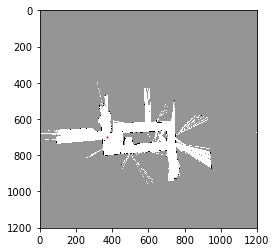

i: 16200
c_array
(100,)
[-536. -393. -561. -512. -466. -491. -352. -498. -404. -467. -404. -402.
 -584. -427. -461. -467. -459. -448. -575. -543. -448. -521. -683. -427.
 -415. -527. -392. -669. -605. -435. -434. -468. -395. -389. -471. -522.
 -465. -449. -438. -500. -453. -417. -723. -525. -310. -475. -459. -382.
 -520. -449. -438. -336. -436. -621. -624. -484. -420. -397. -418. -488.
 -404. -559. -551. -539. -417. -452. -404. -714. -462. -462. -489. -507.
 -538. -438. -378. -392. -550. -433. -426. -390. -360. -526. -388. -453.
 -540. -423. -521. -529. -489. -516. -440. -423. -407. -434. -312. -628.
 -462. -419. -592. -425.]
np.max(c_array)
-310.0
xy_w_scan shape
(2, 1067)
particle states
[  4.95890545 -11.35984921  -3.75015817]
particle weights
[  6.22763219e-099   7.91468923e-037   8.64890063e-110   1.64964510e-088
   1.56652268e-068   2.17557791e-079   5.06416241e-019   1.98387026e-082
   1.32188771e-041   5.76291490e-069   1.32188771e-041   9.76750248e-041
   8.87539772e-120   1.3

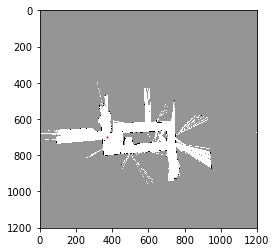

i: 16250
c_array
(100,)
[-442. -425. -428. -479. -544. -526. -654. -392. -431. -473. -502. -473.
 -533. -540. -529. -512. -433. -381. -510. -378. -399. -430. -647. -503.
 -471. -305. -460. -540. -420. -392. -403. -507. -437. -387. -451. -515.
 -423. -328. -394. -404. -433. -507. -404. -517. -476. -470. -518. -444.
 -373. -440. -371. -372. -423. -383. -520. -310. -424. -407. -562. -413.
 -398. -458. -435. -578. -549. -559. -484. -473. -385. -517. -347. -345.
 -514. -374. -529. -525. -588. -573. -418. -590. -544. -440. -619. -352.
 -468. -437. -409. -335. -384. -476. -521. -451. -482. -592. -440. -413.
 -489. -371. -341. -419.]
np.max(c_array)
-305.0
xy_w_scan shape
(2, 1074)
particle states
[  4.96737252 -11.37730283  -3.64328314]
particle weights
[  3.15311304e-060   7.61632965e-053   3.79194725e-054   2.69056637e-076
   1.58745852e-104   1.04232477e-096   2.68107756e-152   1.63479626e-038
   1.88789937e-055   1.08545195e-073   2.76102683e-086   1.08545195e-073
   9.50477164e-100   8.6

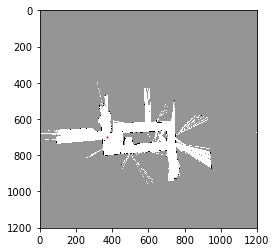

i: 16300
c_array
(100,)
[-357. -339. -423. -481. -585. -511. -505. -592. -344. -396. -487. -398.
 -227. -276. -392. -389. -456. -350. -186. -504. -500. -527. -395. -554.
 -396. -520. -199. -408. -476. -519. -387. -348. -399. -309. -488. -356.
 -440. -543. -369. -632. -367. -371. -510. -445. -180. -369. -456. -326.
 -369. -558. -382. -428. -259. -478. -349. -360. -523. -366. -558. -381.
 -508. -383. -361. -489. -601. -350. -500. -544. -446. -403. -543. -543.
 -417. -354. -493. -456. -345. -387. -498. -548. -379. -216. -653. -514.
 -387. -361. -354. -552. -395. -462. -492. -546. -358. -516. -374. -353.
 -511. -379. -532. -446.]
np.max(c_array)
-180.0
xy_w_scan shape
(2, 1062)
particle states
[  4.98881614 -11.45784197  -3.52954542]
particle weights
[  1.34524543e-077   8.83287732e-070   2.91988481e-106   1.88923407e-131
   1.28724037e-176   1.76787401e-144   7.13211279e-142   1.17381128e-179
   5.95154592e-072   1.55351958e-094   4.68294306e-134   2.10246012e-095
   3.86441867e-021   2.0

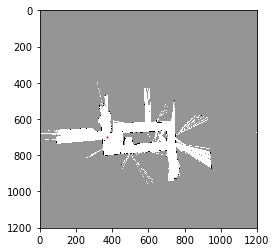

i: 16350
c_array
(100,)
[-510. -355. -247. -444. -503. -518. -459. -202. -411. -425. -576. -394.
 -556. -587. -171. -487. -544. -415. -585. -355. -499. -506. -404. -490.
 -372. -476. -389. -467. -467. -489. -564. -525. -499. -502. -555. -472.
 -542. -341. -511. -398. -455.  -71. -117. -457. -407. -332. -464. -520.
 -412. -526. -470. -434. -496. -481. -380. -501. -551. -405. -369. -497.
 -331. -332. -450. -406. -602. -540. -347. -367. -435. -112. -401.  -71.
 -441. -439. -282. -434. -455. -511. -488. -354. -356. -448. -359. -415.
 -556. -258. -521. -497. -396. -472. -420. -501. -412. -492. -459. -516.
 -400. -520. -673. -340.]
np.max(c_array)
-71.0
xy_w_scan shape
(2, 1039)
particle states
[  5.00357591 -11.45321907  -3.41245628]
particle weights
[  1.10584039e-191   2.28737381e-124   1.83291021e-077   5.09481307e-163
   1.21270124e-188   3.70968124e-195   1.55851514e-169   6.40313819e-058
   1.09356892e-148   9.09333960e-155   2.40025091e-220   2.64151055e-141
   1.16451820e-211   4.00

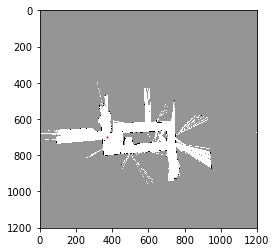

i: 16400
c_array
(100,)
[-485. -359. -553. -523. -416. -478. -478. -585. -341. -336. -471. -208.
 -609. -535. -406. -513. -386. -155. -436. -570. -650. -549. -342. -363.
 -287. -523. -362. -284. -395. -303. -281. -377. -370. -485. -410. -554.
 -588. -508. -351.  -46. -566. -506. -360. -336. -488. -263. -415. -683.
 -437. -435. -506. -539. -446. -601. -458. -471. -222. -343. -422. -444.
 -403. -376. -388. -461. -642. -491. -327. -428. -465. -485. -374. -576.
 -536. -501. -396. -415. -633. -513.  -13. -308. -333. -515. -485. -347.
 -317. -482. -517. -146. -497. -422. -474. -360. -367. -403. -528. -336.
 -500. -430. -374. -502.]
np.max(c_array)
-13.0
xy_w_scan shape
(2, 1040)
particle states
[  4.98645811 -11.4500319   -3.2950195 ]
particle weights
[  1.03039690e-205   5.42137266e-151   3.02677245e-235   3.23455268e-222
   9.53506796e-176   1.12996740e-202   1.12996740e-202   3.83315474e-249
   3.55967162e-143   5.28302110e-141   1.23915972e-199   2.05388455e-085
   1.44706749e-259   1.98

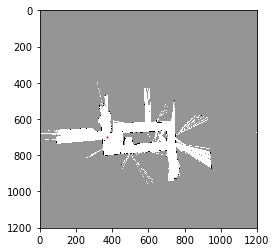

i: 16450
c_array
(100,)
[-691. -412. -291. -478. -366. -380. -529. -423. -542. -561. -466. -583.
 -473. -367. -435. -618. -522. -415. -313. -211. -330. -328. -364. -564.
 -391. -538. -408. -650. -460. -582. -572. -392. -256. -470. -432. -558.
 -428. -308. -434. -632. -598. -434. -496. -371. -460. -549. -437. -370.
 -581. -418. -219. -438. -482. -360. -438. -479. -398. -333.  -58. -330.
 -428. -472. -494. -420. -476. -516. -458. -360. -544. -400. -325. -324.
 -405. -511. -493. -320. -575. -333. -467. -419. -173. -600. -434. -554.
 -360. -517. -300. -332. -384. -543. -568. -316. -348.  -74. -384. -423.
 -365. -405. -328. -557.]
np.max(c_array)
-58.0
xy_w_scan shape
(2, 1057)
particle states
[  4.97971042 -11.43380989  -3.1810517 ]
particle weights
[  1.23478944e-275   1.81866772e-154   6.44741563e-102   3.94745831e-183
   1.72702858e-134   1.43607386e-140   2.80090884e-205   3.03748440e-159
   6.33097662e-211   3.54711733e-219   6.42467753e-178   9.89457061e-229
   5.85854758e-181   6.35

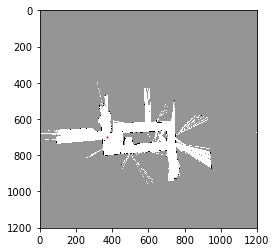

i: 16500
c_array
(100,)
[-185. -494.  -74. -458. -440. -426. -262. -254. -205.  -45. -273. -456.
 -507. -470. -605. -236. -250. -278. -194. -409. -363. -708. -253. -503.
 -254. -417. -474. -538. -319. -574. -252. -345. -392. -112.  -56. -423.
 -433. -273.  -97. -385. -270. -473. -513. -459. -335. -705.  -91. -573.
 -271. -106. -435. -377. -323. -320. -255. -177. -423. -449. -312. -307.
 -504. -254. -170. -492. -269. -328. -457. -416. -392. -311. -364.  -72.
 -338. -242. -557. -414. -418. -501.  -36. -395. -457. -331. -518. -305.
 -322. -676.  -35. -241. -346. -410. -638. -378. -298. -543. -395. -401.
  -31. -569. -357. -319.]
np.max(c_array)
-31.0
xy_w_scan shape
(2, 1059)
particle states
[  4.987307   -11.45202557  -3.17902818]
particle weights
[  1.28204381e-067   8.14531637e-202   2.06343293e-019   3.51163449e-186
   2.30573812e-178   2.77289054e-172   4.64758947e-101   1.38542689e-097
   2.64248924e-076   8.11204464e-007   7.76226487e-106   2.59476642e-185
   1.84110981e-207   2.15

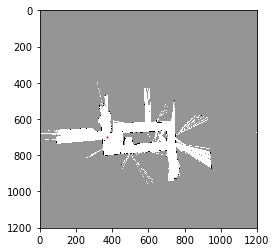

i: 16550
c_array
(100,)
[-418. -357. -490. -259. -214. -261. -386.  -93. -125. -394. -442. -635.
 -602. -398. -593. -770.  -68. -161. -414. -351. -473. -550. -416. -119.
 -329. -490. -448. -336.  -21. -606. -441. -411. -100. -497. -247. -252.
 -483. -458. -367.  -52. -424. -502. -571. -200. -586. -471. -567. -431.
  -30. -287. -503. -339. -578. -470. -359. -451. -661. -562. -447. -338.
 -590. -633. -246. -654. -339. -198.  -67.  -70. -566. -269. -271. -477.
 -524.  -73. -290. -692. -377. -449. -285. -414.  -37. -710. -402. -559.
 -711. -482. -169. -312. -201. -238. -452. -236. -312. -357.  -16. -391.
 -587. -340. -323. -593.]
np.max(c_array)
-16.0
xy_w_scan shape
(2, 1057)
particle states
[  4.9920747  -11.44044583  -3.17860165]
particle weights
[  2.57455087e-175   7.99217295e-149   1.38515629e-206   2.90752930e-106
   1.01572417e-086   3.93491301e-107   2.03294158e-161   3.60087541e-034
   4.56020824e-048   6.81975924e-165   9.71927592e-186   1.47502338e-269
   3.16604298e-255   1.24

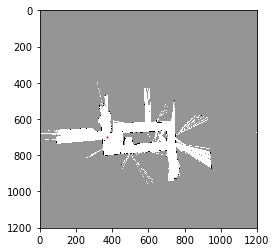

i: 16600
c_array
(100,)
[-440. -662. -435. -270. -297. -573. -338. -244. -638. -438. -278. -612.
 -318. -407. -296. -403. -289. -418. -415. -414. -450. -451. -514. -402.
 -539. -468. -325. -597. -402. -151. -445.  -38. -430. -339. -328. -663.
 -479.  -70. -411. -169. -454. -611. -589. -599. -590. -267. -497. -370.
 -488. -504. -481. -468. -571. -423. -265. -387. -612. -266. -479. -422.
 -392. -583. -537. -600. -426. -200. -458. -377. -466. -160. -381. -473.
 -626. -490. -384. -414. -440. -242. -335. -272. -302. -441. -582.  -64.
 -338. -457. -495. -557. -424. -405. -407. -420. -761. -434. -456. -128.
  -65. -608. -598. -674.]
np.max(c_array)
-38.0
xy_w_scan shape
(2, 1070)
particle states
[  4.99080556 -11.52857537  -3.08815396]
particle weights
[  2.59190020e-175   1.00056036e-271   3.84672096e-173   1.75258947e-101
   3.29404242e-113   4.49212861e-233   5.14820022e-131   3.43033653e-090
   2.65039655e-261   1.91516960e-174   5.87928270e-105   5.18761082e-250
   2.49772757e-122   5.56

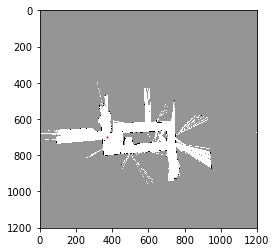

i: 16650
c_array
(100,)
[-520. -335. -478. -400. -412. -175. -583. -330. -592.  -77. -546. -591.
 -331. -603. -156. -593. -721. -179. -371. -519. -326. -588. -510. -372.
 -199. -530. -452. -486. -776. -342. -549. -178. -222. -313. -602. -194.
 -377. -267. -636. -540. -629. -576. -406. -193. -458. -302. -361. -379.
 -466. -354. -540. -408. -254. -627. -104. -486. -577. -539. -478. -485.
 -235. -163. -269. -296. -194. -232. -433. -485. -243. -372. -206. -541.
 -624. -442. -369. -682. -548. -655. -367. -398. -339. -414. -585. -529.
 -384. -587. -378. -569. -421. -558. -487. -599. -612.  -38. -214. -603.
 -387. -239. -243. -256.]
np.max(c_array)
-38.0
xy_w_scan shape
(2, 1025)
particle states
[  5.02148676 -11.55893867  -2.9607576 ]
particle weights
[  4.67799467e-210   1.03404366e-129   8.13631891e-192   6.10095120e-158
   3.74855397e-163   3.17435855e-060   2.03942323e-237   1.53465686e-127
   2.51684822e-241   1.15482242e-017   2.39002912e-221   6.84150278e-241
   5.64568707e-128   4.20

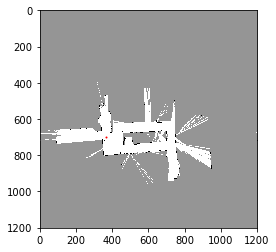

i: 16700
c_array
(100,)
[-612. -389. -656. -537. -462. -632. -435. -432. -422. -560.  -69. -559.
 -151. -284. -578. -345. -100.  -92. -111. -389. -382. -524. -342. -606.
 -171.  -38. -382. -182. -286. -485. -173. -520. -177. -222. -569. -431.
 -349. -102. -582. -665. -137. -594.   11. -351. -328. -175. -409. -455.
   -8. -569. -594. -249. -597. -586. -340. -304. -483.  -95. -130. -563.
 -337. -577. -509. -101. -181. -529. -291. -446. -116. -661. -709. -131.
 -438. -144. -565. -434. -596. -424. -305. -329. -398. -601. -105. -260.
 -357. -683. -110. -144. -443.  -82. -232. -412. -341. -334.  -92. -119.
 -357. -397. -232. -376.]
np.max(c_array)
11.0
xy_w_scan shape
(2, 1003)
*****Updating map*****
particle states
[  5.00663984 -11.58242256  -2.85212638]
particle weights
[  2.71980503e-271   1.91516959e-174   2.11631626e-290   1.01536903e-238
   3.79061832e-206   5.60593598e-280   2.01679181e-194   4.05083463e-193
   8.92255705e-189   1.04195948e-248   1.80485138e-035   2.83233952e-248
   

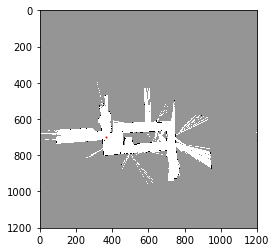

i: 16750
c_array
(100,)
[-361. -461. -199. -553. -807. -419. -227. -382. -476. -654. -645. -383.
 -612. -603. -162. -349. -112. -613. -485. -649. -420. -427. -377. -126.
 -151. -403. -559. -388. -348. -378. -634. -777. -376. -736. -506. -336.
 -159. -596. -441. -630. -196. -255. -191. -286. -187. -650. -605. -266.
 -276. -412. -632. -257. -196. -663. -425. -364. -378. -613. -179. -191.
 -467. -359. -258. -310. -292. -163. -263. -619. -615. -609. -653. -273.
 -298. -184. -437. -371. -395. -606. -174. -527. -186. -623. -571. -271.
 -529. -577. -274. -622. -441. -229. -195. -620. -284. -136. -360. -593.
 -136. -239. -432. -282.]
np.max(c_array)
-112.0
xy_w_scan shape
(2, 1019)
particle states
[  5.00859603 -11.5043753   -2.72710029]
particle weights
[  7.25560523e-109   2.69914027e-152   1.64581006e-038   2.99318196e-192
   1.46330453e-302   4.69454703e-134   1.13797893e-050   5.50160651e-118
   8.25673272e-159   4.09628766e-236   3.31925627e-232   2.02392793e-118
   7.12457048e-218   5.7

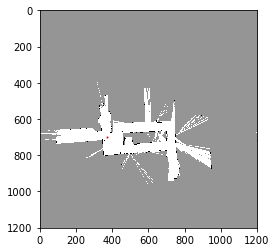

i: 16800
c_array
(100,)
[-586. -365. -484. -233. -412. -546. -358. -238. -329. -568. -343. -553.
 -507. -197. -561. -389. -398. -398. -226. -315. -231. -572. -286. -429.
 -235. -595. -312. -245. -579. -437. -543. -256. -265. -673. -250. -616.
 -274. -478. -242. -267. -257. -469. -745. -633. -279. -410. -355. -407.
 -748. -731. -465. -567. -467. -452. -410. -586. -576. -370. -243. -636.
 -265. -342. -565. -573. -609. -810. -212. -271. -399. -227. -330. -233.
 -238. -665. -479. -375. -471. -476. -241. -339. -565. -453. -649. -373.
 -573. -244. -477. -233. -564. -637. -476. -226. -491. -346. -580. -387.
 -225. -607. -432. -454.]
np.max(c_array)
-197.0
xy_w_scan shape
(2, 1037)
particle states
[  5.0006966  -11.55310003  -2.62597585]
particle weights
[  1.14669101e-169   1.09276533e-073   2.27763203e-125   2.31952212e-016
   4.23337029e-094   2.69914169e-152   1.19836269e-070   1.56288171e-018
   4.71116436e-058   7.52916962e-162   3.91746847e-064   2.46129863e-155
   2.33727857e-135   9.9

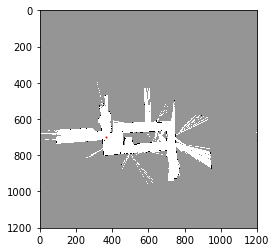

i: 16850
c_array
(100,)
[-361. -427. -561. -483. -618. -657. -248. -445. -452. -664. -416. -747.
 -234. -535. -747. -251. -319. -622. -415. -241. -233. -399. -791. -304.
 -631. -396. -217. -325. -246. -549. -455. -595. -453. -611. -334. -274.
 -394. -643. -527. -485. -638. -700. -271. -221. -469. -337. -581. -360.
 -690. -351. -639. -371. -200. -679. -544. -218. -570. -370. -334. -488.
 -749. -306. -366. -584. -512. -244. -218. -669. -283. -650. -509. -611.
 -263. -572. -453. -263. -281. -432. -584. -593. -236. -510. -446. -657.
 -327. -393. -699. -223. -317. -466. -422. -527. -488. -534. -376. -571.
 -261. -603. -697. -699.]
np.max(c_array)
-200.0
xy_w_scan shape
(2, 1048)
particle states
[  5.00744577 -11.55902236  -2.60460226]
particle weights
[  1.19836297e-070   2.60107321e-099   1.65841036e-157   1.24354524e-123
   2.91679920e-182   3.36838511e-199   1.42516398e-021   3.96142923e-107
   3.61235588e-110   3.07156963e-202   1.55737026e-094   2.76005901e-238
   1.71390831e-015   3.2

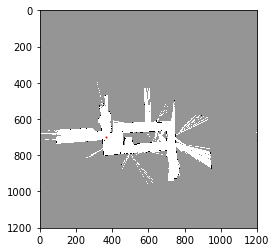

i: 16900
c_array
(100,)
[-562. -486. -471. -616. -546. -383. -289. -401. -485. -471. -491. -635.
 -675. -371. -276. -592. -253. -423. -568. -650. -289. -453. -260. -515.
 -480. -586. -548. -286. -712. -512. -748. -385. -294. -463. -306. -488.
 -275. -507. -551. -407. -506. -647. -293. -639. -450. -409. -348. -433.
 -517. -461. -439. -492. -420. -550. -436. -552. -393. -457. -733. -412.
 -451. -575. -432. -385. -653. -585. -486. -382. -376. -453. -268. -691.
 -424. -292. -264. -357. -426. -658. -391. -281. -610. -579. -367. -626.
 -396. -324. -684. -266. -652. -600. -575. -514. -472. -305. -499. -466.
 -402. -524. -575. -685.]
np.max(c_array)
-253.0
xy_w_scan shape
(2, 1065)
particle states
[  4.85867639 -11.621115    -2.56523882]
particle weights
[  6.34747336e-135   6.44141843e-102   2.10571087e-095   2.24232657e-158
   5.64043498e-128   3.47786842e-057   2.31736502e-016   5.29678656e-065
   1.75095907e-101   2.10571087e-095   4.34019360e-104   1.25632993e-166
   5.33733462e-184   5.6

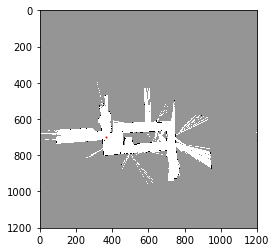

i: 16950
c_array
(100,)
[-499. -483. -630. -519. -446. -543. -612. -557. -622. -616. -474. -741.
 -524. -507. -509. -488. -483. -583. -497. -710. -755. -544. -504. -376.
 -566. -436. -678. -697. -494. -524. -399. -553. -495. -683. -464. -479.
 -571. -479. -756. -590. -470. -597. -750. -507. -495. -766. -677. -568.
 -548. -547. -522. -478. -525. -506. -707. -558. -558. -667. -615. -549.
 -482. -455. -499. -596. -552. -543. -539. -465. -713. -464. -684. -478.
 -532. -571. -553. -521. -489. -499. -443. -618. -457. -439. -590. -589.
 -744. -495. -628. -724. -457. -621. -585. -528. -612. -488. -551. -474.
 -469. -581. -449. -511.]
np.max(c_array)
-376.0
xy_w_scan shape
(2, 1081)
particle states
[  4.86483497 -11.63637564  -2.44725177]
particle weights
[  3.81749719e-054   3.39227019e-047   4.88879241e-111   7.86844816e-063
   3.97544974e-031   2.97044505e-073   3.20997959e-103   2.47001036e-079
   1.45732848e-107   5.87928270e-105   2.74878501e-043   3.03748474e-159
   5.30171867e-065   1.2

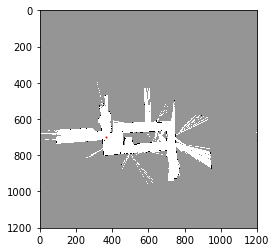

i: 17000
c_array
(100,)
[-609. -659. -701. -737. -594. -753. -592. -554. -844. -569. -518. -580.
 -717. -567. -540. -572. -371. -525. -585. -545. -756. -542. -557. -574.
 -490. -633. -528. -532. -732. -537. -529. -616. -610. -629. -568. -740.
 -518. -505. -601. -506. -537. -557. -621. -658. -596. -578. -487. -543.
 -600. -584. -548. -646. -728. -527. -590. -519. -599. -535. -526. -546.
 -525. -496. -588. -536. -535. -637. -555. -553. -432. -489. -671. -588.
 -699. -616. -601. -493. -562. -601. -700. -627. -686. -520. -716. -572.
 -581. -534. -620. -562. -582. -544. -611. -554. -627. -674. -656. -664.
 -593. -602. -771. -588.]
np.max(c_array)
-371.0
xy_w_scan shape
(2, 1078)
particle states
[  4.98863602 -11.64372442  -2.27405112]
particle weights
[  4.34423497e-104   8.37894253e-126   4.81749166e-144   1.11742819e-159
   1.42013796e-097   1.25749977e-166   1.04934790e-096   3.34279552e-080
   3.79061834e-206   1.02256891e-086   1.44115655e-064   1.70786399e-091
   5.42137266e-151   7.5

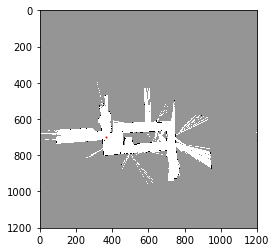

i: 17050
c_array
(100,)
[-527. -563. -690. -723. -635. -521. -581. -563. -729. -687. -613. -646.
 -484. -531. -524. -526. -636. -806. -679. -717. -653. -591. -618. -612.
 -701. -866. -645. -618. -624. -806. -570. -733. -772. -818. -678. -820.
 -547. -608. -779. -602. -609. -614. -729. -613. -521. -551. -741. -677.
 -511. -632. -667. -612. -628. -634. -603. -718. -623. -623. -822. -704.
 -499. -634. -594. -632. -741. -596. -615. -730. -745. -629. -815. -726.
 -525. -616. -536. -712. -744. -649. -592. -654. -664. -644. -608. -501.
 -689. -591. -603. -668. -628. -714. -640. -674. -676. -661. -669. -722.
 -666. -595. -726. -549.]
np.max(c_array)
-484.0
xy_w_scan shape
(2, 1076)
particle states
[  4.99760367 -11.63283288  -2.17103978]
particle weights
[  2.11513030e-019   4.90609303e-035   3.43033534e-090   1.59815418e-104
   2.63956938e-066   8.53304466e-017   7.47196974e-043   4.90609303e-035
   3.96142815e-107   6.89001271e-089   9.46262618e-057   4.40852980e-071
   9.99999653e-001   3.8

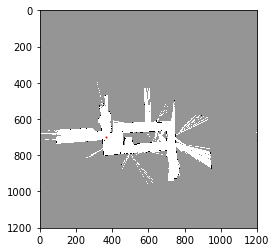

i: 17100
c_array
(100,)
[-675. -618. -620. -597. -800. -707. -747. -501. -693. -525. -505. -669.
 -541. -497. -620. -715. -541. -824. -821. -598. -532. -543. -574. -684.
 -560. -698. -733. -562. -626. -795. -499. -643. -607. -554. -665. -510.
 -550. -754. -617. -485. -762. -665. -656. -771. -601. -547. -683. -743.
 -757. -568. -534. -537. -665. -683. -600. -554. -794. -692. -518. -553.
 -626. -686. -563. -676. -595. -563. -569. -511. -699. -686. -631. -778.
 -848. -598. -592. -538. -625. -537. -546. -523. -544. -732. -633. -553.
 -550. -685. -630. -808. -805. -606. -781. -835. -731. -642. -778. -756.
 -682. -721. -489. -751.]
np.max(c_array)
-485.0
xy_w_scan shape
(2, 1076)
particle states
[  4.9889931  -11.64099795  -2.10717633]
particle weights
[  2.99338791e-083   1.70195655e-058   2.30334772e-059   2.24456708e-049
   1.54651011e-137   3.79087601e-097   1.61049842e-114   1.10510324e-007
   4.55892373e-091   4.17191342e-018   2.02406719e-009   1.20761887e-080
   4.69487005e-025   6.0

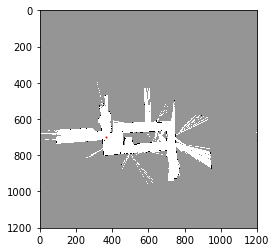

i: 17150
c_array
(100,)
[-612. -594. -737. -606. -631. -615. -717. -637. -711. -518. -509. -652.
 -543. -618. -615. -516. -529. -681. -498. -515. -733. -733. -704. -502.
 -527. -617. -622. -692. -544. -682. -631. -698. -458. -496. -672. -827.
 -575. -703. -793. -626. -537. -618. -572. -506. -619. -713. -691. -468.
 -694. -515. -491. -711. -469. -657. -633. -736. -506. -614. -668. -560.
 -511. -668. -517. -522. -710. -738. -558. -673. -615. -733. -605. -707.
 -567. -655. -523. -565. -703. -689. -629. -673. -563. -499. -476. -682.
 -547. -489. -613. -657. -585. -556. -543. -612. -638. -731. -676. -554.
 -573. -733. -645. -701.]
np.max(c_array)
-458.0
xy_w_scan shape
(2, 1049)
particle states
[  4.97263057 -11.66020221  -2.01200612]
particle weights
[  1.31408304e-067   8.62826520e-060   6.78910574e-122   5.30138936e-065
   7.36253978e-076   6.54243422e-069   3.29383781e-113   1.82499115e-078
   1.32882901e-110   8.75596687e-027   7.09503344e-023   5.58269028e-085
   1.21602376e-037   3.2

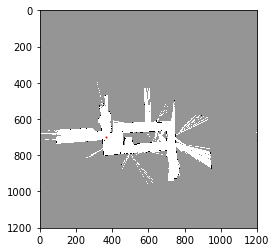

i: 17200
c_array
(100,)
[-597. -617. -582. -493. -547. -783. -561. -506. -547. -669. -615. -728.
 -494. -655. -523. -696. -757. -732. -579. -568. -601. -678. -659. -559.
 -613. -619. -737. -603. -522. -736. -493. -518. -601. -700. -666. -540.
 -763. -751. -743. -680. -717. -523. -793. -677. -593. -569. -667. -655.
 -723. -523. -514. -586. -574. -595. -631. -639. -739. -540. -489. -654.
 -499. -579. -585. -758. -624. -701. -684. -770. -674. -690. -733. -571.
 -785. -746. -720. -590. -549. -581. -676. -672. -591. -573. -578. -588.
 -651. -648. -709. -867. -525. -612. -664. -759. -682. -703. -603. -787.
 -577. -564. -573. -588.]
np.max(c_array)
-489.0
xy_w_scan shape
(2, 1059)
particle states
[  5.06578939 -11.5983529   -1.99907146]
particle weights
[  1.19602159e-047   2.46518422e-056   3.90981534e-041   1.75535571e-002
   6.20101972e-026   1.99051467e-128   5.15632599e-032   3.96768212e-008
   6.20101972e-026   6.43481878e-079   1.82153845e-055   1.53165830e-104
   6.45759277e-003   7.7

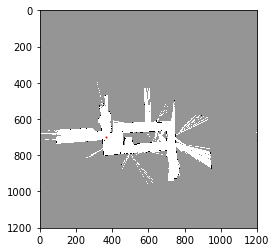

i: 17250
c_array
(100,)
[-560. -608. -603. -605. -774. -813. -578. -637. -718. -548. -627. -670.
 -531. -795. -494. -698. -627. -787. -752. -569. -643. -741. -844. -714.
 -559. -512. -650. -823. -746. -737. -711. -570. -511. -557. -609. -765.
 -646. -577. -523. -527. -629. -556. -716. -539. -667. -736. -629. -718.
 -559. -630. -720. -839. -829. -564. -744. -560. -737. -521. -689. -804.
 -561. -554. -543. -651. -548. -754. -657. -647. -552. -567. -632. -507.
 -564. -852. -805. -579. -562. -622. -538. -578. -721. -581. -755. -576.
 -639. -733. -545. -629. -518. -748. -531. -514. -700. -820. -743. -599.
 -503. -698. -570. -589.]
np.max(c_array)
-494.0
xy_w_scan shape
(2, 1070)
particle states
[  4.9738082  -11.66038852  -2.01988729]
particle weights
[  2.17024915e-029   3.09296114e-050   4.59036133e-048   6.21237851e-049
   2.49741357e-122   2.88406918e-139   3.30528506e-037   7.86745899e-063
   5.22373881e-098   3.53218447e-024   1.73292316e-058   3.66535957e-077
   8.53197491e-017   1.8

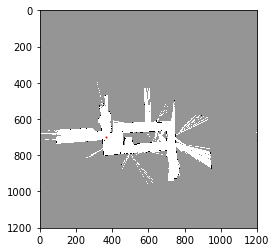

i: 17300
c_array
(100,)
[-609. -469. -832. -751. -655. -649. -673. -608. -551. -631. -481. -783.
 -643. -626. -599. -667. -844. -595. -616. -792. -732. -581. -717. -631.
 -503. -634. -853. -688. -773. -591. -733. -718. -693. -865. -585. -723.
 -722. -589. -816. -719. -602. -588. -644. -735. -718. -572. -608. -610.
 -727. -631. -710. -782. -662. -606. -658. -481. -638. -590. -656. -706.
 -733. -737. -739. -797. -774. -740. -758. -637. -645. -603. -636. -590.
 -568. -616. -635. -673. -551. -747. -699. -766. -691. -767. -722. -710.
 -801. -741. -505. -773. -559. -749. -760. -765. -721. -457. -719. -726.
 -556. -728. -768. -738.]
np.max(c_array)
-457.0
xy_w_scan shape
(2, 1081)
particle states
[  4.94548247 -11.66557411  -2.13088721]
particle weights
[  9.71037679e-067   6.14417460e-006   1.37900747e-163   2.07691944e-128
   1.02256262e-086   4.12531206e-084   1.55736081e-094   2.63955408e-066
   1.50077654e-041   2.70867862e-076   3.77511135e-011   2.63024517e-142
   1.66426967e-081   4.0

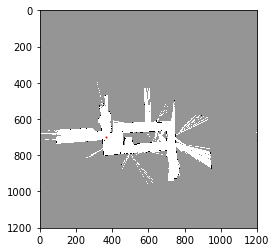

i: 17350
c_array
(100,)
[-654. -573. -558. -635. -777. -622. -694. -770. -644. -646. -748. -754.
 -585. -557. -702. -652. -451. -598. -609. -641. -758. -733. -716. -702.
 -579. -620. -708. -566. -552. -750. -605. -817. -867. -598. -738. -572.
 -693. -584. -423. -608. -871. -625. -642. -636. -434. -628. -790. -554.
 -622. -452. -606. -559. -614. -776. -782. -617. -641. -593. -803. -707.
 -605. -701. -748. -715. -668. -652. -727. -702. -755. -735. -403. -604.
 -721. -686. -688. -519. -572. -603. -499. -417. -693. -631. -554. -570.
 -646. -659. -517. -709. -599. -754. -525. -605. -590. -801. -584. -606.
 -770. -841. -749. -674.]
np.max(c_array)
-403.0
xy_w_scan shape
(2, 1078)
particle states
[  4.95206254 -11.63919998  -2.23272837]
particle weights
[  9.81939386e-110   1.47889627e-074   4.83453761e-068   1.75258801e-101
   3.74855085e-163   7.75368407e-096   4.17162637e-127   4.11078515e-160
   2.16286543e-105   2.92712006e-106   1.47368065e-150   3.65288912e-153
   9.08665275e-080   1.3

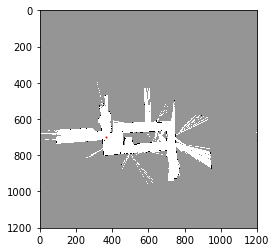

i: 17400
c_array
(100,)
[-491. -615. -687. -696. -532. -562. -687. -561. -752. -750. -562. -633.
 -604. -588. -473. -778. -544. -746. -743. -660. -661. -657. -574. -812.
 -670. -715. -624. -687. -794. -626. -410. -602. -550. -627. -756. -790.
 -667. -749. -656. -639. -553. -851. -604. -485. -636. -546. -665. -592.
 -508. -763. -575. -498. -829. -614. -673. -530. -741. -776. -575. -806.
 -456. -522. -609. -781. -650. -529. -755. -732. -447. -721. -802. -524.
 -612. -505. -546. -719. -808. -437. -612. -581. -624. -558. -629. -687.
 -790. -664. -794. -693. -608. -755. -556. -578. -476. -555. -493. -538.
 -562. -548. -528. -415.]
np.max(c_array)
-410.0
xy_w_scan shape
(2, 1081)
particle states
[  4.97882953 -11.60927663  -2.31664604]
particle weights
[  6.59523883e-036   9.26221315e-090   4.98324310e-121   6.14981055e-125
   1.03075813e-053   9.64544595e-067   4.98324310e-121   2.62190405e-066
   2.94015855e-149   2.17249964e-148   9.64544595e-067   1.41063319e-097
   5.54567063e-085   4.9

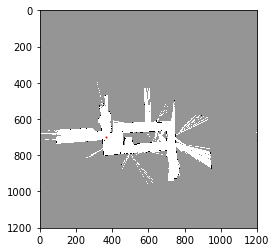

i: 17450
c_array
(100,)
[-493. -590. -770. -577. -388. -547. -735. -693. -715. -537. -784. -799.
 -720. -570. -626. -458. -693. -581. -619. -584. -710. -379. -464. -772.
 -690. -572. -767. -768. -704. -657. -652. -613. -703. -555. -596. -789.
 -531. -524. -676. -538. -528. -647. -706. -740. -561. -610. -615. -672.
 -573. -820. -776. -714. -762. -578. -578. -753. -560. -444. -706. -718.
 -691. -520. -704. -610. -576. -582. -527. -773. -553. -822. -658. -579.
 -667. -645. -539. -470. -518. -460. -671. -548. -609. -601. -840. -414.
 -484. -487. -692. -491. -578. -615. -800. -823. -466. -622. -735. -725.
 -640. -510. -699. -461.]
np.max(c_array)
-379.0
xy_w_scan shape
(2, 1078)
particle states
[  5.00711842 -11.58565104  -2.43446921]
particle weights
[  3.09296831e-050   2.31105736e-092   1.55168650e-170   1.02244273e-086
   1.23394576e-004   1.09263082e-073   2.46099567e-155   4.28034810e-137
   1.19398945e-146   2.40667954e-069   1.29027189e-176   3.94697166e-183
   8.04503760e-149   1.1

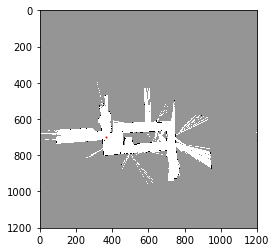

i: 17500
c_array
(100,)
[-590. -498. -743. -690. -663. -564. -507. -784. -739. -551. -645. -652.
 -550. -614. -743. -703. -867. -722. -853. -853. -720. -697. -671. -580.
 -704. -599. -611. -883. -660. -546. -616. -572. -607. -641. -541. -684.
 -630. -492. -702. -801. -563. -754. -789. -869. -790. -547. -847. -558.
 -656. -771. -688. -605. -622. -693. -574. -752. -663. -614. -657. -554.
 -667. -569. -553. -555. -586. -677. -671. -498. -648. -913. -639. -681.
 -562. -666. -644. -641. -542. -610. -654. -578. -589. -700. -532. -721.
 -647. -468. -692. -573. -737. -578. -653. -877. -521. -555. -910. -642.
 -689. -458. -652. -800.]
np.max(c_array)
-458.0
xy_w_scan shape
(2, 1056)
particle states
[  5.02780399 -11.79334096  -2.5481293 ]
particle weights
[  4.71095192e-058   4.24816139e-018   1.68287919e-124   1.75250991e-101
   9.32419813e-090   9.22072780e-047   5.24264765e-022   2.63014192e-142
   9.18820907e-123   4.07937346e-041   6.12226562e-082   5.58278360e-085
   1.10888868e-040   1.7

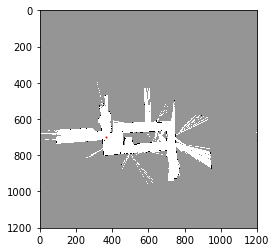

i: 17550
c_array
(100,)
[-532. -691. -499. -543. -426. -460. -475. -544. -571. -688. -657. -549.
 -550. -362. -551. -619. -564. -613. -527. -498. -606. -568. -570. -545.
 -546. -743. -707. -537. -714. -665. -402. -481. -405. -623. -651. -544.
 -520. -542. -568. -557. -554. -538. -515. -582. -516. -385. -546. -523.
 -526. -570. -490. -242. -577. -535. -452. -541. -550. -473. -619. -519.
 -637. -618. -281. -544. -629. -540. -523. -615. -289. -537. -543. -508.
 -667. -629. -556. -543. -591. -710. -409. -693. -649. -365. -649. -615.
 -618. -289. -550. -700. -579. -706. -600. -499. -558. -614. -680. -583.
 -443. -233. -586. -528.]
np.max(c_array)
-233.0
xy_w_scan shape
(2, 1029)
particle states
[  5.00315295 -11.51257189  -2.65979679]
particle weights
[  1.39925323e-130   1.23900682e-199   3.00340722e-116   2.33699088e-135
   1.51743955e-084   2.60075244e-099   7.95576207e-106   8.59730898e-136
   1.61588900e-147   2.48861171e-198   7.22913076e-185   5.79282122e-138
   2.13105983e-138   9.4

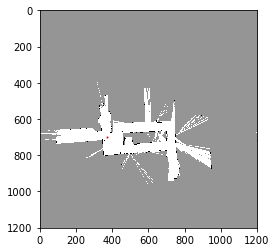

i: 17600
c_array
(100,)
[-643. -748. -627. -568. -558. -706. -615. -424. -534. -649. -637. -519.
 -552. -603. -476. -389. -350. -538. -560. -612. -383. -586. -605. -544.
 -396. -514. -647. -624. -279. -492. -542. -365. -545. -610. -444. -561.
 -366. -694. -569. -557. -662. -364. -402. -597. -400. -540. -649. -467.
 -529. -449. -550. -486. -275. -647. -608. -604. -105. -482. -644. -601.
 -626. -574. -388. -362. -397. -537. -507. -475. -543. -503. -572. -647.
 -512. -555. -585. -410. -515. -587. -513. -557. -292. -456. -617. -665.
  -85. -569. -746. -211. -530. -424. -358. -613. -546. -547. -483. -518.
 -602. -374. -585. -654.]
np.max(c_array)
-85.0
xy_w_scan shape
(2, 1000)
particle states
[  5.01980695 -11.62998791  -2.77744874]
particle weights
[  4.60976830e-243   1.15546953e-288   4.09629106e-236   1.72093806e-210
   3.79061833e-206   2.00967920e-270   6.66690997e-231   5.94525701e-148
   1.00410152e-195   1.14264732e-245   1.85971326e-240   3.28242531e-189
   1.52924458e-203   1.08

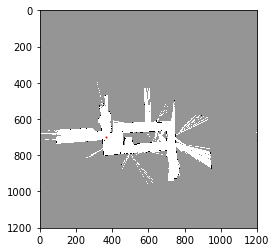

i: 17650
c_array
(100,)
[-485. -531. -315. -586. -390. -456. -272. -389. -527. -545. -502. -530.
 -392. -438. -420. -534. -508.  -11. -501. -284. -487. -582. -590. -340.
 -580. -309. -557. -517. -148. -511. -454. -417. -472. -362. -500. -591.
  -70. -321. -631. -506. -514. -517. -187. -534. -384. -410. -732. -554.
 -508. -264. -484. -492. -579. -481. -454. -630. -488. -554. -517. -493.
 -615. -655. -446.  -92. -570. -557. -564. -507. -658. -586. -750. -550.
 -524. -557. -596. -522. -572.  -85. -396. -510. -613. -546. -466. -528.
 -671. -539.  -27. -181. -580. -440. -419. -424. -533. -464. -238. -347.
 -543. -378. -519. -411.]
np.max(c_array)
-11.0
xy_w_scan shape
(2, 1018)
particle states
[  5.01156541 -11.57865651  -2.89822243]
particle weights
[  1.39449040e-206   1.46848448e-226   9.42925656e-133   1.90841516e-250
   2.52575551e-165   5.48220794e-194   4.45800113e-114   6.86571532e-165
   8.01765361e-225   1.22108702e-232   5.77310341e-214   3.99175468e-226
   3.41823838e-166   3.59

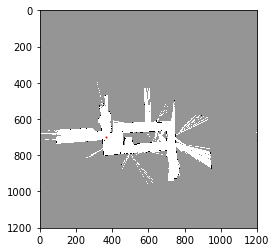

i: 17700
c_array
(100,)
[-650. -606. -483. -137. -619. -583. -601. -623. -665. -430. -584. -525.
 -576. -550. -618. -622. -554. -561. -598. -530. -680. -636. -708. -664.
 -608. -517. -708. -498. -621. -584. -520. -596. -328. -638. -676. -627.
 -508. -537. -671. -670. -669. -620. -654. -644. -615. -437. -616. -706.
 -613. -617. -575. -664. -548. -685. -312. -598. -672. -587. -380. -548.
 -563. -658. -615. -560. -341. -619. -529. -695. -602. -585. -497. -576.
 -627. -703. -554. -605. -593. -677. -511. -673. -643. -713. -638. -508.
 -671. -550. -625. -606. -496. -639. -457. -598. -597. -655. -674. -546.
 -565. -663. -657. -447.]
np.max(c_array)
-137.0
xy_w_scan shape
(2, 1060)
particle states
[  4.96512618 -11.52822609  -3.02823274]
particle weights
[  1.61038896e-223   2.06960749e-204   5.42137266e-151   1.00000000e+000
   4.67799467e-210   2.01679182e-194   3.07156986e-202   8.56804611e-212
   4.92621719e-230   5.64568707e-128   7.41936248e-195   3.11703028e-169
   2.21168078e-191   4.3

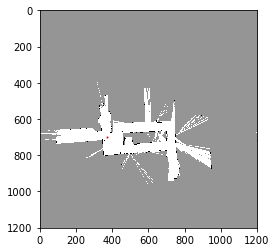

i: 17750
c_array
(100,)
[-511. -540. -354. -509. -569. -557. -532. -317. -556. -588. -464. -575.
 -701. -566. -536. -521. -406. -448. -486. -339. -633. -650. -524. -393.
 -435. -143. -516. -619. -403. -682. -285. -481. -517. -163. -365. -493.
 -525. -534. -572. -442. -363. -252. -273. -546. -518. -587. -611. -408.
 -422. -438. -417.  -99. -566. -216. -198. -414. -507. -546. -657. -510.
 -603. -391. -653. -597. -342. -312. -399. -575. -423. -126. -385. -109.
 -508.  -85. -102.  -92. -637. -586. -297. -384. -286. -517. -484.  -95.
 -533. -450. -113. -367.  -87. -521. -500. -496. -500. -434. -464. -412.
 -523. -524. -328. -345.]
np.max(c_array)
-85.0
xy_w_scan shape
(2, 1024)
particle states
[  4.95747895 -11.51465349  -3.06145477]
particle weights
[  8.61113128e-186   2.19038388e-198   1.31611509e-117   6.36281321e-185
   5.57160424e-211   9.06805286e-206   6.52944233e-195   1.54237401e-101
   2.46495233e-205   3.12165644e-219   2.22280241e-165   1.38106261e-213
   2.62487513e-268   1.11

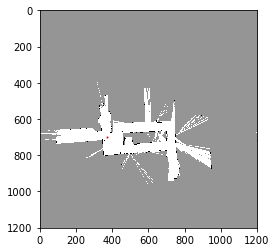

i: 17800
c_array
(100,)
[-272. -201. -383. -549. -604. -100. -163. -507. -169. -165. -563. -689.
 -573. -338. -694. -617. -130. -570. -581. -575. -527. -212. -498. -577.
 -349. -646. -370. -357. -127. -303. -468. -445. -359. -510. -627. -634.
 -386. -341. -535. -215. -265. -664. -458. -574. -413. -389. -537. -230.
 -129. -378. -235. -429. -492. -257. -392. -610. -405. -381. -439. -689.
 -551. -437. -763. -159. -453. -678. -333. -506. -165. -665. -534. -636.
 -446. -223. -146. -516. -525. -359. -619. -120. -417. -581. -388. -308.
 -560. -490. -538. -297. -553. -461. -542. -624. -525. -113. -451. -467.
 -147. -448. -389. -423.]
np.max(c_array)
-100.0
xy_w_scan shape
(2, 1069)
particle states
[  4.94497854 -11.51345034  -3.08126062]
particle weights
[  2.00146560e-075   1.36853638e-044   1.24354252e-123   1.00409925e-195
   1.30490873e-219   9.99997738e-001   4.35960014e-028   1.74640467e-177
   1.08063683e-030   5.90007719e-029   8.34937364e-202   1.58689860e-256
   3.79060977e-206   4.3

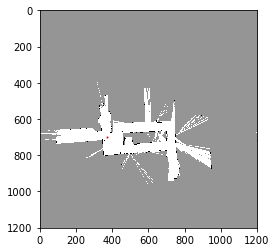

i: 17850
c_array
(100,)
[-624. -503. -147. -678. -475. -495. -495. -594. -316. -434. -462. -371.
 -147. -276. -328. -666. -408. -213. -153. -163. -420. -595. -613. -548.
 -436. -192. -400. -506. -213. -465. -456. -591. -549. -124. -408. -656.
 -536. -425. -156. -425. -404. -622. -605. -605. -599. -269. -131. -657.
 -526. -679. -526. -574. -357. -294. -420. -604. -592. -494. -132. -545.
 -654. -493. -271. -601. -501. -149. -146. -632. -647. -576. -533. -591.
 -127. -368. -238. -370. -261. -203. -347. -401. -340. -143. -122. -630.
 -492. -610. -622. -270. -355. -406. -511. -589. -547. -631. -597. -345.
 -422. -459. -648. -437.]
np.max(c_array)
-122.0
xy_w_scan shape
(2, 1071)
particle states
[  4.91600838 -11.49985357  -3.10156906]
particle weights
[  8.44135071e-219   2.99256956e-166   1.21584948e-011   2.98201567e-242
   4.32802487e-154   8.92072414e-163   8.92072414e-163   9.02082798e-206
   4.88778811e-085   2.76925855e-136   1.91477616e-148   6.35207863e-109
   1.21584948e-011   1.1

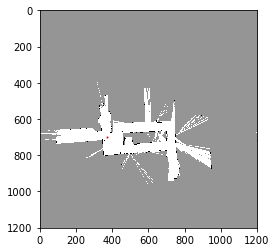

i: 17900
c_array
(100,)
[-236. -432. -322. -219. -420. -387.  -55. -453. -579. -292. -399. -314.
 -312. -198. -392. -336. -319. -371. -434. -251. -430. -502. -561. -366.
 -708. -448. -128. -431. -306. -347. -586. -447. -290. -111. -586. -202.
 -230. -157. -585. -525. -516. -438. -364. -582.  -85. -155. -718. -498.
 -569. -459. -204. -572. -571. -569. -572. -558. -646. -541. -698. -464.
 -440. -562. -457. -251. -119. -429. -517. -558. -183. -657. -662. -344.
 -166. -678. -119. -526. -577. -549. -155. -446. -536. -563. -457. -584.
 -253. -561. -617. -523. -335. -250. -370. -149. -576. -472. -327. -517.
 -382. -565. -320. -352.]
np.max(c_array)
-55.0
xy_w_scan shape
(2, 1061)
particle states
[  4.92881847 -11.52714845  -3.08832683]
particle weights
[  2.47001036e-079   1.86629513e-164   1.10502813e-116   5.96629836e-072
   3.03748474e-159   6.51976599e-145   1.00000000e+000   1.41512956e-173
   2.68962345e-228   1.18088550e-103   4.00588267e-150   3.29404242e-113
   2.43398642e-112   7.86

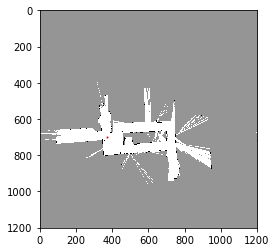

i: 17950
c_array
(100,)
[-179. -631.  -90. -539. -313. -330. -665. -349. -492. -295. -588. -122.
 -417. -522. -430. -510. -134. -615. -544. -264. -392. -493. -100. -600.
 -333. -563. -419. -383. -336. -453. -457. -422. -441. -481.  -75. -320.
 -458. -584. -498. -317. -294. -476. -246. -528. -328. -352. -583. -506.
 -271. -151. -428. -138. -654. -179. -484. -451. -195. -584. -720. -642.
 -624. -542. -342. -411. -117. -300. -696. -124. -360. -336. -570. -415.
 -439. -485. -535. -646. -479. -597. -412. -538.  -73. -466. -588. -107.
 -514. -421. -453. -470. -671. -427. -418. -444. -509. -466. -224. -138.
 -589. -584. -561. -512.]
np.max(c_array)
-73.0
xy_w_scan shape
(2, 1042)
particle states
[  4.92618451 -11.53937156  -3.09782036]
particle weights
[  8.12195853e-047   4.06027031e-243   3.64644491e-008   3.66140089e-203
   5.17845483e-105   2.14384805e-112   6.95893152e-258   1.20115442e-120
   9.45122129e-183   3.40017184e-097   1.91963062e-224   4.61791820e-022
   3.52836962e-150   8.84

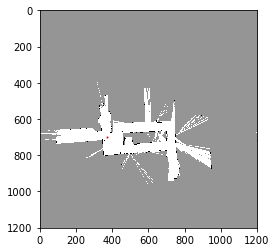

i: 18000
c_array
(100,)
[-327. -306. -161. -199.  -61. -436. -492. -646. -427. -739.  -84. -472.
 -202. -639. -470. -638. -418.  -88. -417. -450. -454. -431. -449. -399.
 -571. -159. -432. -433. -359. -593. -408. -429. -271. -493. -526. -517.
 -373. -394. -513. -498. -354. -498. -224. -327. -390. -506. -338. -419.
 -193. -212. -641. -601. -448. -355. -743. -194. -110. -481. -303. -558.
 -365. -448. -415.  -45. -207. -174. -473. -334. -525. -641. -348. -347.
 -565. -185. -315. -311. -177. -398. -479. -245. -309. -433. -486. -558.
 -318. -395. -588. -476. -348. -540. -514. -223. -338. -387. -456. -278.
 -109. -305. -588. -194.]
np.max(c_array)
-45.0
xy_w_scan shape
(2, 1066)
particle states
[  4.86534645 -11.5475534   -3.07686275]
particle weights
[  3.38030630e-123   4.45800113e-114   4.18639353e-051   1.31416452e-067
   1.12535162e-007   1.55187782e-170   7.41936164e-195   9.75026293e-262
   1.25749962e-166   3.97767696e-302   1.15482229e-017   3.59961604e-186
   6.54283988e-069   1.06

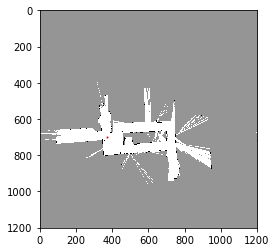

i: 18050
c_array
(100,)
[-555. -488. -572. -464. -131. -717. -367. -608. -606. -396. -568. -685.
 -639. -489. -343. -209. -388. -406. -525. -619. -206. -269. -701. -358.
 -215. -371. -597. -462. -738. -422. -497. -434. -216. -463. -497. -160.
 -480. -516. -549. -190. -418. -691. -402. -198. -194. -510. -534. -437.
 -138. -234. -346. -486. -599. -679. -617. -446. -490. -505. -485. -579.
 -757. -571. -569. -153. -588. -133. -367. -219. -407. -630. -366. -560.
 -444. -522. -436. -582. -112. -613. -397. -589. -701. -110. -477. -528.
 -506. -575. -638. -760. -393. -311.  -86. -416. -173. -579. -435. -662.
 -608. -126. -393. -557.]
np.max(c_array)
-86.0
xy_w_scan shape
(2, 1061)
particle states
[  4.80817439 -11.56097755  -3.10177558]
particle weights
[  2.06960749e-204   2.59190020e-175   8.56804611e-212   6.86571609e-165
   2.86251858e-020   9.12392946e-275   9.18862621e-123   1.98737786e-227
   1.46848465e-226   2.33727928e-135   4.67799467e-210   7.20452479e-261
   6.84150278e-241   9.53

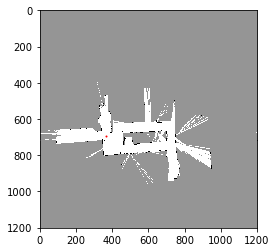

i: 18100
c_array
(100,)
[-457. -417. -413. -453. -672. -636. -414. -543. -410. -548. -401. -402.
 -576. -511. -512. -702. -719. -390. -292. -249. -628. -563. -413. -496.
 -633. -532. -573. -210. -519. -468. -693. -383. -379. -373. -192. -188.
 -410. -382. -359. -601. -416. -427. -518. -449. -235. -680. -525. -261.
 -224. -222. -692. -185. -407. -399. -514. -619. -649. -452. -560. -679.
 -329. -641. -398. -482. -528. -657. -361. -249. -637. -419. -751. -669.
 -219. -436. -457. -428. -486. -556. -476. -554. -352. -400. -598. -415.
 -560. -541. -521. -393. -291. -483. -428. -367. -715. -455. -374. -404.
 -625. -663. -359. -397.]
np.max(c_array)
-185.0
xy_w_scan shape
(2, 1067)
particle states
[  4.65194572 -11.5837369   -3.00736091]
particle weights
[  7.08635041e-119   1.66802248e-101   9.10709418e-100   3.86901623e-117
   2.99991545e-212   1.29333301e-196   3.35031272e-100   3.17027678e-156
   1.82920876e-098   2.13611569e-158   1.48222321e-094   5.45279447e-095
   1.47699586e-170   2.5

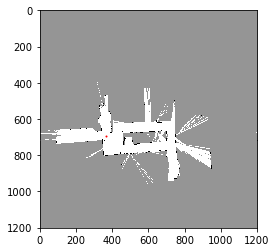

i: 18150
c_array
(100,)
[-495. -200. -328. -534. -502. -502. -637. -333. -661. -596. -199. -444.
 -190. -527. -511. -144. -456. -554. -188. -222. -232. -476. -406. -564.
 -463. -494. -149. -342. -568. -656. -606. -264. -465. -606. -358. -424.
 -600. -442. -464. -556. -639. -436. -459. -199. -431. -332. -337. -255.
 -468. -404. -382. -694. -367. -457. -435. -494. -489. -657. -673. -195.
 -582. -312. -701. -508. -374. -180. -459. -470. -297. -606. -489. -346.
 -240. -425. -488. -434. -674. -452. -298. -416. -337. -646. -499. -449.
 -328. -344. -636. -315. -581. -441. -464. -369. -465. -554. -535. -286.
 -115. -542. -843. -498.]
np.max(c_array)
-115.0
xy_w_scan shape
(2, 1070)
particle states
[  4.55049135 -11.57093754  -3.04353431]
particle weights
[  9.29173632e-166   1.21609930e-037   3.12806202e-093   1.07303054e-182
   8.47296678e-169   8.47296678e-169   1.98737786e-227   2.10767161e-095
   7.50261880e-238   1.27161079e-209   3.30570063e-037   1.30953001e-143
   2.67863696e-033   1.1

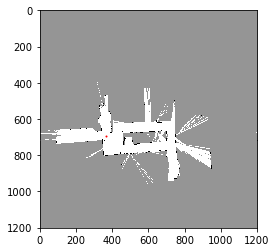

i: 18200
c_array
(100,)
[-267. -502. -308. -333. -275. -528. -187. -486. -201. -464. -339. -159.
 -511. -395. -148. -274. -258. -467. -333. -375. -483. -400. -266. -159.
 -447. -445. -151. -538. -450. -290. -453. -290. -324. -386. -464. -471.
 -364. -460. -446. -372. -375. -367. -209. -298. -628. -535. -434. -735.
 -499. -517. -575. -461. -440. -628. -495. -185. -374. -394. -448. -348.
 -456. -211. -474. -293. -331. -380. -584. -446. -149. -299. -195. -342.
 -438. -482. -392. -428. -343. -410. -517. -656. -450. -506. -393. -476.
 -262. -400. -261. -446. -483. -552. -433. -226. -175. -289. -334. -310.
 -440. -441. -343. -285.]
np.max(c_array)
-148.0
xy_w_scan shape
(2, 1081)
particle states
[  4.38820657 -11.56961393  -3.04563887]
particle weights
[  1.47018620e-052   1.28282996e-154   2.29772782e-070   3.19107150e-081
   4.93192525e-056   6.55409246e-166   8.14574655e-018   1.13993688e-147
   6.77342219e-024   4.08657436e-138   7.90987543e-084   1.17808435e-005
   1.58313794e-158   3.7

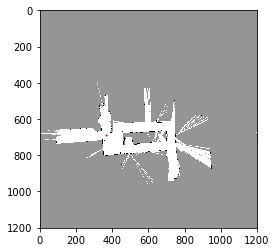

i: 18250
c_array
(100,)
[-628. -436. -345. -557. -545. -346. -378. -356. -643. -403. -433. -403.
 -697. -439. -375. -357. -202. -210. -571. -421. -235. -725. -450. -623.
 -652. -688. -174. -659. -430. -337. -337. -196. -761. -559. -568. -515.
 -295. -444. -648. -284. -358. -404. -376. -638. -366. -638. -418. -280.
 -611. -572. -455. -626. -408. -443. -618. -282. -545. -488. -275. -212.
 -545. -698. -389. -344. -347. -430. -416. -727. -513. -667. -611. -273.
 -451. -397. -304. -201. -377. -321. -220. -453. -384. -665. -372. -316.
 -284. -630. -283. -666. -282. -695. -225. -357. -233. -477. -439. -363.
 -501. -426. -380. -511.]
np.max(c_array)
-174.0
xy_w_scan shape
(2, 1081)
particle states
[  4.26657503 -11.55499545  -3.02798442]
particle weights
[  6.76558284e-198   1.64000715e-114   5.44055988e-075   4.62608311e-167
   7.52917192e-162   2.00147013e-075   2.53469490e-089   9.08666032e-080
   2.06960749e-204   3.52017005e-100   3.29404241e-113   3.52017005e-100
   7.31115455e-228   8.1

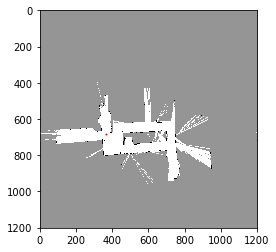

i: 18300
c_array
(100,)
[-274. -381. -745. -408. -416. -273. -408. -435. -540. -412. -532. -452.
 -372. -428. -396. -394. -337. -523. -265. -626. -356. -469. -500. -403.
 -446. -392. -658. -372. -403. -246. -423. -262. -423. -645. -360. -341.
 -421. -457. -248. -787. -383. -415. -579. -712. -365. -609. -309. -394.
 -428. -257. -434. -422. -391. -496. -660. -434. -361. -270. -411. -245.
 -420. -335. -416. -564. -318. -403. -401. -480. -496. -514. -404. -382.
 -420. -769. -270. -674. -415. -562. -625. -558. -379. -375. -273. -282.
 -252. -383. -268. -318. -545. -404. -253. -403. -375. -268. -466. -323.
 -665. -544. -537. -663.]
np.max(c_array)
-245.0
xy_w_scan shape
(2, 1080)
particle states
[  4.1302219  -11.62866052  -2.9856812 ]
particle weights
[  1.79267723e-013   6.08124553e-060   5.02112606e-218   1.14298762e-071
   3.83429631e-075   4.87300193e-013   1.14298762e-071   2.14827817e-083
   5.38480419e-129   2.09345485e-073   1.60518751e-125   8.89373783e-091
   4.92768429e-056   2.3

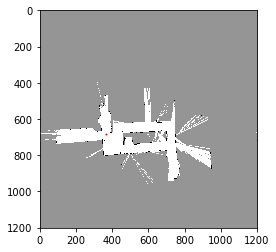

i: 18350
c_array
(100,)
[-421. -223. -368. -311. -446. -470. -460. -776. -231. -426. -393. -353.
 -480. -370. -288. -451. -524. -276. -448. -329. -453. -291. -234. -342.
 -386. -373. -255. -390. -219. -288. -397. -513. -343. -277. -482. -335.
 -523. -307. -265. -435. -441. -422. -392. -438. -232. -588. -230. -389.
 -588. -632. -327. -317. -686. -495. -364. -394. -381. -477. -662. -477.
 -385. -416. -383. -329. -552. -548. -566. -330. -219. -574. -318. -446.
 -290. -457. -368. -391. -366. -465. -217. -363. -402. -609. -392. -470.
 -395. -550. -518. -637. -394. -435. -243. -266. -413. -417. -481. -242.
 -337. -233. -343. -339.]
np.max(c_array)
-217.0
xy_w_scan shape
(2, 1076)
particle states
[  4.00720141 -11.60200003  -3.02503283]
particle weights
[  1.99088025e-089   1.94693994e-003   2.07325480e-066   1.17879463e-041
   2.76492331e-100   1.04379575e-110   2.29911314e-106   1.33199950e-243
   6.53125590e-007   1.34144456e-091   2.87932463e-077   6.77750595e-060
   4.73882538e-115   2.8

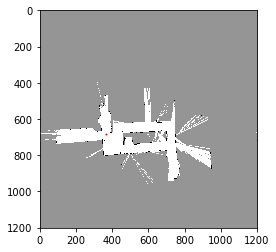

i: 18400
c_array
(100,)
[-503. -484. -530. -423. -465. -420. -397. -340. -351. -556. -447. -447.
 -531. -433. -339. -397. -452. -400. -686. -469. -582. -478. -701. -380.
 -450. -465. -384. -426. -486. -366. -470. -589. -724. -253. -427. -362.
 -749. -398. -322. -466. -348. -382. -465. -370. -255. -365. -240. -357.
 -378. -451. -428. -439. -418. -413. -475. -392. -447. -395. -330. -262.
 -590. -547. -411. -382. -422. -659. -392. -539. -414. -407. -252. -311.
 -446. -405. -242. -381. -493. -589. -391. -383. -436. -426. -520. -574.
 -597. -458. -307. -524. -341. -357. -374. -236. -451. -250. -452. -388.
 -499. -616. -422. -499.]
np.max(c_array)
-236.0
xy_w_scan shape
(2, 1073)
particle states
[  3.86914224 -11.59436596  -3.14698074]
particle weights
[  1.08251678e-116   1.93210085e-108   2.03462147e-128   5.99781668e-082
   3.44845805e-100   1.20469368e-080   1.17395032e-070   6.67475279e-046
   1.11479724e-050   1.03950622e-139   2.26425649e-092   2.26425649e-092
   7.48495411e-129   2.7

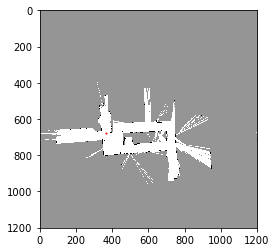

i: 18450
c_array
(100,)
[-528. -315. -316. -404. -683. -376. -472. -321. -302. -447. -309. -291.
 -409. -674. -407. -633. -354. -379. -331. -374. -306. -659. -349. -299.
 -331. -337. -386. -385. -395. -417. -244. -530. -319. -385. -642. -324.
 -369. -308. -327. -232. -309. -695. -324. -670. -407. -216. -240. -773.
 -433. -227. -630. -342. -353. -303. -546. -663. -244. -423. -337. -643.
 -685. -383. -357. -563. -312. -497. -680. -630. -766. -360. -602. -365.
 -293. -417. -360. -420. -424. -417. -564. -355. -320. -239. -380. -339.
 -365. -237. -308. -604. -234. -435. -366. -313. -280. -320. -373. -353.
 -433. -364. -443. -462.]
np.max(c_array)
-216.0
xy_w_scan shape
(2, 1037)
particle states
[  3.73877098 -11.61558642  -3.22036848]
particle weights
[  3.16311030e-136   1.01120447e-043   3.72001337e-044   2.25232000e-082
   1.52921885e-203   3.25743371e-070   6.61614970e-112   2.50652529e-046
   4.47370401e-038   4.76395193e-101   4.07949001e-041   2.67859188e-033
   1.51760128e-084   1.2

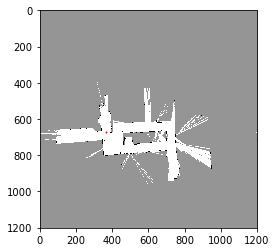

i: 18500
c_array
(100,)
[-340. -681. -621. -589. -775. -324. -371. -764. -615. -234. -355. -331.
 -350. -323. -353. -613. -235. -556. -470. -536. -339. -350. -368. -320.
 -649. -613. -775. -242. -604. -336. -380. -361. -413. -318. -427. -571.
 -315. -608. -332. -490. -603. -388. -498. -287. -468. -344. -330. -331.
 -368. -425. -539. -475. -432. -375. -572. -460. -482. -378. -391. -385.
 -607. -423. -562. -569. -244. -360. -441. -785. -731. -678. -577. -359.
 -602. -327. -386. -219. -335. -340. -243. -383. -355. -719. -443. -344.
 -245. -359. -411. -565. -336. -397. -374. -697. -324. -689. -437. -525.
 -352. -339. -361. -315.]
np.max(c_array)
-219.0
xy_w_scan shape
(2, 1026)
particle states
[  3.62446017 -11.65931197  -3.19938221]
particle weights
[  2.82076891e-053   2.26959925e-201   2.59189911e-175   2.04664026e-161
   3.40618224e-242   2.50656643e-046   9.71043239e-067   2.03942238e-237
   1.04564673e-172   3.05902192e-007   8.62879754e-060   2.28569272e-049
   1.28062710e-057   6.8

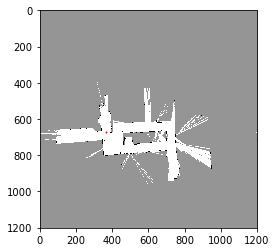

i: 18550
c_array
(100,)
[-563. -343. -350. -314. -554. -398. -349. -477. -630. -667. -265. -391.
 -357. -632. -415. -526. -534. -438. -351. -382. -519. -462. -547. -354.
 -653. -267. -341. -445. -389. -351. -344. -345. -504. -270. -453. -499.
 -621. -507. -352. -478. -283. -433. -616. -467. -796. -291. -273. -412.
 -390. -459. -442. -298. -295. -438. -338. -677. -308. -279. -281. -349.
 -373. -346. -357. -328. -422. -344. -473. -345. -586. -485. -373. -626.
 -513. -655. -527. -623. -314. -607. -523. -360. -608. -478. -398. -417.
 -334. -386. -602. -502. -662. -340. -430. -496. -409. -378. -537. -343.
 -337. -492. -265. -370.]
np.max(c_array)
-265.0
xy_w_scan shape
(2, 1048)
particle states
[  3.48917746 -11.66289028  -3.20236678]
particle weights
[  1.77558667e-130   6.22483573e-035   5.67631544e-038   2.44719102e-022
   1.43877278e-126   8.08968089e-059   1.54298251e-037   3.96887408e-093
   1.41778896e-159   1.20980607e-175   4.66764141e-001   8.87141231e-056
   5.17612968e-041   1.9

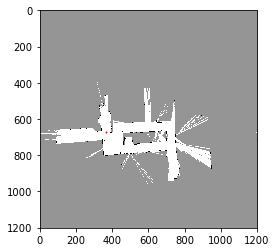

i: 18600
c_array
(100,)
[-314. -321. -503. -447. -484. -360. -306. -453. -445. -303. -363. -575.
 -536. -328. -470. -291. -316. -563. -324. -439. -612. -377. -374. -331.
 -288. -409. -384. -345. -309. -433. -451. -539. -310. -320. -411. -411.
 -451. -391. -336. -451. -372. -486. -574. -394. -514. -348. -434. -554.
 -574. -490. -418. -447. -411. -336. -437. -484. -343. -435. -322. -338.
 -298. -353. -349. -316. -327. -320. -317. -444. -426. -441. -421. -369.
 -431. -308. -558. -349. -419. -313. -413. -405. -420. -294. -385. -357.
 -354. -399. -614. -382. -372. -334. -326. -323. -359. -370. -351. -411.
 -357. -401. -303. -508.]
np.max(c_array)
-288.0
xy_w_scan shape
(2, 1037)
particle states
[  3.35440144 -11.60503875  -3.34201792]
particle weights
[  4.85510928e-012   4.42728659e-015   4.02292494e-094   8.41458915e-070
   7.18020900e-086   5.11272980e-032   1.44728768e-008   2.08576812e-072
   6.21758713e-069   2.90695501e-007   2.54547828e-033   2.16440851e-125
   1.87423493e-108   4.0

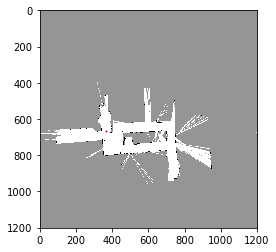

i: 18650
c_array
(100,)
[-578. -297. -607. -621. -583. -419. -370. -572. -355. -380. -347. -813.
 -359. -419. -465. -368. -334. -447. -347. -627. -402. -332. -351. -559.
 -530. -351. -632. -355. -369. -317. -543. -560. -375. -561. -671. -461.
 -410. -642. -302. -611. -485. -343. -447. -412. -363. -324. -368. -336.
 -296. -346. -380. -566. -606. -401. -473. -516. -372. -370. -355. -570.
 -378. -546. -416. -571. -379. -302. -435. -475. -343. -588. -422. -488.
 -360. -490. -423. -330. -542. -436. -368. -619. -424. -394. -351. -418.
 -659. -364. -350. -604. -522. -301. -666. -441. -814. -371. -340. -506.
 -370. -533. -438. -447.]
np.max(c_array)
-296.0
xy_w_scan shape
(2, 1053)
particle states
[  3.17102731 -11.18517727  -3.38165018]
particle weights
[  2.45025239e-123   2.66661450e-001   6.23262283e-136   5.18260488e-142
   1.65096707e-125   2.76715473e-054   5.27792309e-033   9.88502365e-121
   1.72536223e-026   2.39617337e-037   5.14323231e-023   2.13799938e-225
   3.16011115e-028   2.7

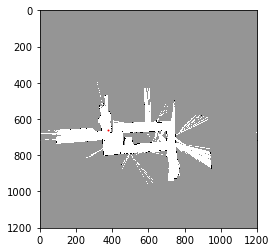

i: 18700
c_array
(100,)
[-795. -358. -490. -334. -314. -326. -332. -494. -318. -468. -735. -343.
 -378. -713. -364. -755. -416. -329. -346. -499. -347. -403. -852. -405.
 -821. -822. -345. -326. -883. -794. -755. -734. -363. -835. -493. -330.
 -351. -807. -353. -416. -635. -367. -816. -549. -395. -567. -376. -337.
 -558. -311. -306. -390. -855. -336. -636. -350. -436. -665. -562. -347.
 -688. -845. -688. -341. -720. -403. -353. -816. -819. -401. -339. -383.
 -382. -480. -834. -783. -447. -796. -319. -309. -303. -812. -324. -873.
 -485. -358. -353. -833. -438. -330. -320. -556. -825. -686. -376. -346.
 -630. -853. -445. -332.]
np.max(c_array)
-303.0
xy_w_scan shape
(2, 1060)
particle states
[  3.07126625 -11.84563     -3.16658991]
particle weights
[  2.01764115e-214   1.23461776e-024   5.81648896e-082   3.27039406e-014
   1.58668137e-005   9.74890728e-011   2.41651251e-013   1.06532711e-083
   2.90610830e-007   2.08516060e-072   2.30416111e-188   4.03598690e-018
   2.54473686e-033   8.2

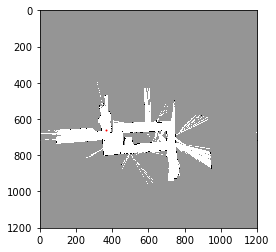

i: 18750
c_array
(100,)
[-289. -746. -406. -799. -742. -557. -494. -524. -334. -347. -498. -543.
 -427. -324. -312. -430. -409. -380. -297. -429. -460. -397. -459. -496.
 -335. -396. -497. -597. -329. -621. -332. -470. -323. -324. -404. -341.
 -641. -441. -421. -514. -488. -382. -646. -555. -535. -322. -421. -351.
 -334. -432. -423. -506. -499. -338. -384. -388. -360. -602. -359. -385.
 -398. -323. -472. -773. -405. -526. -459. -328. -423. -421. -436. -437.
 -449. -474. -406. -548. -400. -294. -324. -341. -403. -400. -435. -325.
 -335. -541. -463. -428. -424. -319. -464. -427. -525. -622. -547. -355.
 -382. -428. -475. -520.]
np.max(c_array)
-289.0
xy_w_scan shape
(2, 1066)
particle states
[  2.93047323 -11.19248719  -3.08775284]
particle weights
[  9.92976272e-001   3.34472673e-199   1.52927112e-051   3.21183407e-222
   1.82615892e-197   4.03661863e-117   9.25912784e-090   8.66434274e-103
   2.84241303e-020   6.42478976e-026   1.69586842e-091   4.85445486e-111
   1.15957907e-060   6.2

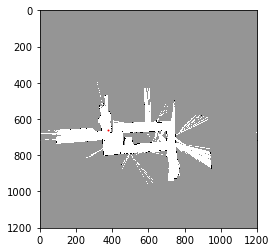

i: 18800
c_array
(100,)
[-465. -706. -767. -381. -821. -503. -316. -372. -805. -348. -417. -413.
 -449. -455. -345. -375. -503. -560. -734. -698. -349. -344. -324. -438.
 -398. -527. -387. -374. -582. -708. -788. -483. -818. -547. -472. -603.
 -801. -385. -737. -444. -500. -347. -445. -471. -389. -808. -361. -361.
 -328. -336. -319. -358. -380. -344. -368. -430. -514. -375. -818. -335.
 -409. -579. -361. -772. -368. -351. -472. -387. -671. -596. -882. -683.
 -768. -358. -716. -434. -368. -310. -483. -451. -402. -736. -713. -448.
 -786. -545. -345. -387. -395. -745. -488. -392. -536. -414. -383. -709.
 -373. -317. -378. -303.]
np.max(c_array)
-303.0
xy_w_scan shape
(2, 1081)
particle states
[  2.85175177 -11.1633964   -3.03308375]
particle weights
[  4.40450083e-071   9.52635052e-176   3.06876167e-202   1.33239556e-034
   1.08407952e-225   1.38263130e-087   2.25826290e-006   1.07965130e-030
   9.63325040e-219   2.85990152e-020   3.09052191e-050   1.68736779e-048
   3.91388812e-064   9.7

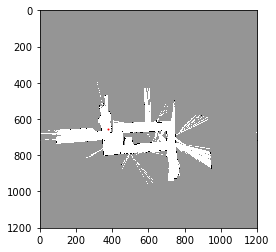

i: 18850
c_array
(100,)
[-402. -775. -838. -612. -569. -314. -834. -338. -837. -789. -679. -327.
 -368. -691. -831. -367. -705. -454. -791. -480. -482. -417. -843. -488.
 -400. -744. -313. -673. -608. -337. -800. -377. -442. -806. -412. -639.
 -831. -382. -790. -318. -425. -423. -667. -392. -797. -473. -803. -462.
 -405. -410. -492. -407. -363. -818. -403. -461. -772. -511. -323. -690.
 -419. -815. -567. -438. -676. -350. -332. -508. -352. -321. -821. -454.
 -399. -492. -343. -833. -829. -396. -828. -368. -411. -660. -817. -443.
 -756. -472. -403. -768. -679. -418. -355. -353. -526. -546. -802. -524.
 -724. -429. -741. -388.]
np.max(c_array)
-313.0
xy_w_scan shape
(2, 1078)
particle states
[  2.74963835 -11.18444444  -3.06091106]
particle weights
[  1.61990185e-039   1.65061942e-201   7.19605693e-229   1.01776497e-130
   4.81182941e-112   2.67548862e-001   3.92891396e-227   1.01003295e-011
   1.95609108e-228   1.37253745e-207   8.12675586e-160   6.04748561e-007
   9.45150754e-025   4.9

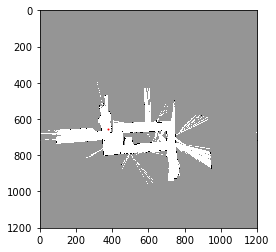

i: 18900
c_array
(100,)
[-878. -392. -357. -475. -346. -867. -390. -838. -804. -821. -413. -371.
 -411. -524. -559. -343. -581. -595. -392. -438. -364. -359. -845. -336.
 -842. -814. -836. -335. -468. -371. -449. -862. -404. -383. -474. -468.
 -838. -337. -311. -485. -804. -348. -801. -486. -432. -681. -846. -844.
 -327. -386. -871. -481. -836. -611. -344. -333. -448. -806. -752. -397.
 -827. -483. -819. -341. -831. -444. -466. -834. -816. -462. -860. -401.
 -412. -285. -503. -508. -522. -799. -358. -354. -360. -777. -847. -376.
 -556. -347. -336. -468. -370. -349. -347. -795. -825. -376. -766. -813.
 -363. -340. -606. -335.]
np.max(c_array)
-285.0
xy_w_scan shape
(2, 1081)
particle states
[  2.75760878 -11.23126709  -3.1538342 ]
particle weights
[  2.90651274e-258   3.39227019e-047   5.38018616e-032   3.04823495e-083
   3.22134029e-027   1.74024956e-253   2.50656748e-046   6.84150278e-241
   3.99175513e-226   1.65256176e-233   2.57220937e-056   4.47377931e-038
   1.90061994e-055   1.5

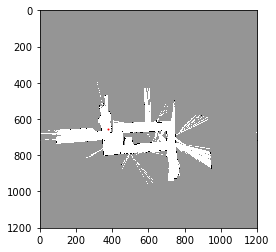

i: 18950
c_array
(100,)
[-792. -500. -447. -451. -549. -739. -852. -495. -403. -485. -731. -377.
 -509. -740. -805. -540. -770. -502. -387. -397. -807. -850. -800. -848.
 -786. -775. -542. -837. -661. -421. -500. -718. -331. -835. -515. -480.
 -332. -761. -481. -611. -536. -504. -821. -523. -423. -831. -347. -483.
 -353. -531. -470. -857. -524. -626. -827. -833. -501. -500. -820. -818.
 -522. -605. -407. -493. -801. -742. -839. -824. -805. -571. -733. -490.
 -821. -509. -499. -532. -482. -866. -699. -786. -659. -789. -875. -305.
 -722. -414. -607. -423. -539. -872. -363. -360. -531. -756. -803. -851.
 -829. -487. -497. -515.]
np.max(c_array)
-305.0
xy_w_scan shape
(2, 1081)
particle states
[  2.60021567 -11.2775275   -3.06202325]
particle weights
[  3.15200801e-212   2.05388455e-085   2.13886596e-062   3.91746966e-064
   1.07682819e-106   3.28242532e-189   2.76005921e-238   3.04823495e-083
   2.74878501e-043   6.71418429e-079   9.78477197e-186   5.38018616e-032
   2.53469490e-089   1.2

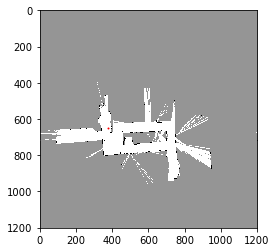

i: 19000
c_array
(100,)
[-363. -595. -821. -372. -849. -859. -379. -499. -796. -316. -527. -502.
 -867. -807. -813. -378. -671. -375. -361. -500. -494. -364. -502. -321.
 -311. -528. -465. -355. -885. -390. -368. -325. -316. -850. -519. -827.
 -374. -314. -401. -834. -483. -446. -298. -523. -815. -449. -380. -831.
 -854. -656. -815. -716. -455. -839. -530. -393. -832. -868. -456. -365.
 -871. -436. -537. -484. -832. -390. -481. -444. -353. -476. -371. -811.
 -353. -409. -530. -368. -386. -362. -845. -363. -365. -515. -836. -538.
 -339. -654. -355. -314. -493. -522. -520. -373. -498. -787. -514. -860.
 -413. -412. -381. -823.]
np.max(c_array)
-298.0
xy_w_scan shape
(2, 1081)
particle states
[  2.53612779 -11.25186071  -3.14307369]
particle weights
[  5.90007570e-029   1.03404105e-129   7.31113616e-228   7.28127186e-033
   5.05521206e-240   2.29506273e-244   6.63966049e-036   5.09105800e-088
   5.26437623e-217   1.52299414e-008   3.52016120e-100   2.53468853e-089
   7.69907773e-248   8.7

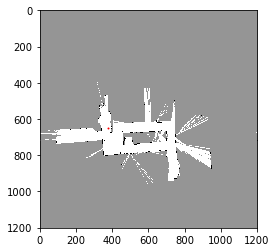

i: 19050
c_array
(100,)
[-496. -283. -511. -357. -885. -357. -463. -516. -422. -849. -370. -798.
 -278. -356. -399. -447. -835. -510. -427. -498. -396. -677. -881. -545.
 -494. -840. -544. -505. -518. -424. -281. -540. -516. -833. -288. -508.
 -470. -392. -831. -407. -847. -855. -488. -303. -494. -463. -884. -838.
 -557. -877. -442. -600. -490. -843. -329. -888. -320. -447. -838. -893.
 -898. -836. -538. -469. -868. -877. -899. -878. -889. -498. -552. -513.
 -377. -356. -493. -878. -498. -508. -352. -836. -524. -846. -508. -777.
 -816. -883. -332. -522. -324. -852. -837. -459. -367. -333. -415. -325.
 -832. -352. -348. -452.]
np.max(c_array)
-278.0
xy_w_scan shape
(2, 1081)
particle states
[  2.29287824 -11.23782691  -3.27514766]
particle weights
[  1.99482361e-095   6.37718689e-003   6.10221170e-102   4.64341483e-035
   2.28744699e-264   4.64341483e-035   4.28176080e-081   4.11163790e-104
   2.73965679e-063   9.86171363e-249   1.04956471e-040   1.38985971e-226
   9.46458452e-001   1.2

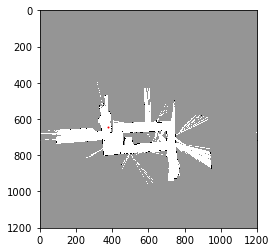

i: 19100
c_array
(100,)
[-343. -480. -838. -497. -447. -251. -831. -826. -807. -822. -500. -512.
 -394. -787. -392. -421. -630. -898. -326. -398. -385. -358. -347. -265.
 -334. -851. -470. -257. -559. -843. -864. -359. -839. -845. -855. -424.
 -319. -456. -451. -588. -257. -499. -345. -424. -464. -440. -440. -768.
 -276. -854. -313. -808. -230. -388. -300. -288. -298. -776. -541. -390.
 -842. -800. -322. -862. -478. -852. -397. -439. -795. -851. -780. -828.
 -820. -224. -552. -369. -320. -468. -308. -409. -429. -834. -383. -868.
 -379. -276. -778. -766. -452. -587. -605. -615. -591. -846. -508. -509.
 -844. -312. -856. -375.]
np.max(c_array)
-224.0
xy_w_scan shape
(2, 1081)
particle states
[  2.20433981 -11.20934403  -3.33234833]
particle weights
[  2.07912920e-052   6.59990154e-112   2.19843148e-267   2.73231813e-119
   1.41662649e-097   1.87488145e-012   2.41087286e-264   3.57805258e-262
   6.38619057e-254   1.95355051e-260   1.36034110e-120   8.35822457e-126
   1.47524075e-074   3.0

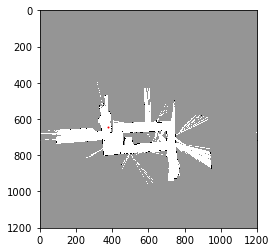

i: 19150
c_array
(100,)
[-463. -765. -271. -275. -378. -811. -603. -763. -460. -310. -327. -837.
 -324. -471. -815. -835. -450. -776. -296. -817. -492. -793. -495. -442.
 -363. -811. -809. -675. -453. -803. -442. -443. -816. -453. -428. -477.
 -769. -668. -520. -439. -283. -306. -473. -451. -464. -323. -794. -464.
 -488. -382. -807. -427. -400. -286. -835. -337. -463. -262. -256. -320.
 -822. -318. -540. -322. -270. -646. -471. -768. -436. -871. -525. -383.
 -822. -734. -813. -347. -816. -241. -754. -374. -314. -313. -743. -213.
 -412. -292. -742. -287. -827. -684. -778. -567. -773. -224. -812. -309.
 -804. -301. -738. -777.]
np.max(c_array)
-213.0
xy_w_scan shape
(2, 1081)
particle states
[  2.0854361  -11.23472528  -3.36813058]
particle weights
[  2.66914564e-109   1.85968221e-240   6.47012686e-026   1.18504507e-027
   2.19484185e-072   1.95836017e-260   4.21837131e-170   1.37412962e-239
   5.36112232e-108   7.47184754e-043   3.09329835e-050   1.00054365e-271
   6.21305582e-049   8.9

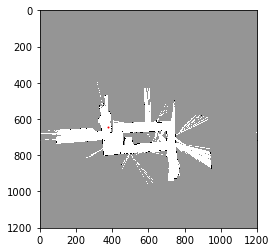

i: 19200
c_array
(100,)
[-475. -838. -796. -274. -447. -239. -415. -281. -399. -824. -398. -323.
 -415. -838. -742. -460. -769. -467. -451. -239. -385. -283. -543. -328.
 -379. -469. -306. -317. -415. -472. -808. -449. -842. -287. -800. -436.
 -317. -472. -285. -372. -717. -381. -810. -581. -397. -573. -283. -440.
 -831. -439. -478. -528. -509. -383. -403. -301. -847. -298. -330. -728.
 -455. -309. -822. -324. -241. -401. -765. -316. -391. -322. -426. -648.
 -329. -819. -678. -868. -769. -452. -469. -289. -799. -433. -254. -712.
 -479. -391. -443. -255. -839. -759. -810. -735. -448. -625. -328. -739.
 -314. -434. -609. -513.]
np.max(c_array)
-239.0
xy_w_scan shape
(2, 1081)
particle states
[  1.93105197 -11.21059987  -3.39016053]
particle weights
[  1.50326695e-103   3.37395417e-261   5.86823394e-243   2.95275200e-016
   2.17411045e-091   4.68310439e-001   1.71674197e-077   2.69256130e-019
   1.52551588e-070   4.05753174e-255   4.14678211e-070   1.54809411e-037
   1.71674197e-077   3.3

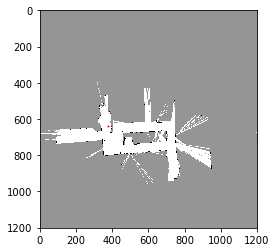

i: 19250
c_array
(100,)
[-265. -452. -276. -781. -212. -318. -791. -556. -706. -272. -869. -356.
 -724. -358. -331. -479. -271. -258. -354. -447. -262. -285. -355. -272.
 -417. -360. -313. -827. -377. -289. -328. -429. -670. -772. -298. -249.
 -244. -283. -413. -393. -285. -505. -306. -813. -759. -404. -406. -801.
 -877. -309. -359. -443. -300. -874. -788. -440. -355. -443. -718. -772.
 -326. -821. -434. -363. -220. -602. -407. -282. -345. -216. -271. -824.
 -282. -467. -279. -291. -413. -247. -297. -598. -403. -356. -304. -758.
 -324. -326. -509. -562. -508. -439. -328. -284. -570. -410. -311. -441.
 -524. -321. -243. -607.]
np.max(c_array)
-212.0
xy_w_scan shape
(2, 1081)
particle states
[  1.77844615 -11.16351647  -3.46677147]
particle weights
[  9.42685875e-024   5.77163534e-105   1.57444574e-028   7.55812966e-248
   9.81690393e-001   9.05231085e-047   3.43138556e-252   3.93253654e-150
   2.82163271e-215   8.59618249e-027   4.57614662e-286   2.84164058e-063
   4.29734090e-223   3.8

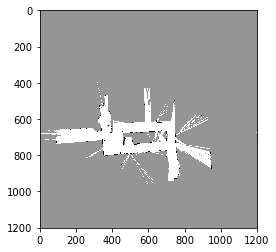

i: 19300
c_array
(100,)
[-793. -705. -365. -450. -445. -431. -291. -339. -403. -412. -296. -332.
 -332. -441. -747. -752. -326. -302. -440. -526. -417. -549. -597. -675.
 -342. -479. -397. -758. -460. -336. -349. -746. -569. -394. -436. -638.
 -293. -468. -436. -373. -714. -571. -340. -456. -342. -335. -334. -374.
 -330. -323. -710. -395. -468. -482. -802. -441. -413. -613. -365. -441.
 -436. -454. -618. -400. -367. -380. -466. -433. -328. -442. -470. -396.
 -419. -414. -485. -408. -432. -838. -746. -441. -667. -745. -754. -501.
 -734. -469. -254. -745. -414. -861. -387. -767. -736. -256. -823. -404.
 -349. -333. -721. -358.]
np.max(c_array)
-254.0
xy_w_scan shape
(2, 1081)
particle states
[  2.1213445  -11.17058018  -3.40309286]
particle weights
[  7.24686414e-235   1.19691835e-196   5.47253281e-049   6.65514331e-086
   9.87710844e-084   1.18782529e-077   7.51588342e-017   1.07113671e-037
   1.71790072e-065   2.12005791e-069   5.06416241e-019   1.17464403e-034
   1.17464403e-034   5.3

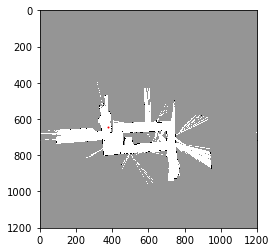

i: 19350
c_array
(100,)
[-458. -683. -537. -383. -854. -752. -531. -853. -383. -242. -229. -820.
 -383. -323. -389. -565. -336. -415. -778. -410. -396. -391. -377. -493.
 -493. -407. -796. -297. -794. -429. -782. -770. -775. -389. -525. -391.
 -473. -792. -878. -384. -717. -372. -824. -630. -843. -395. -415. -436.
 -389. -241. -560. -644. -446. -781. -356. -884. -570. -411. -316. -461.
 -413. -866. -372. -326. -754. -736. -819. -450. -828. -416. -373. -851.
 -811. -399. -437. -460. -274. -379. -278. -873. -401. -414. -573. -757.
 -485. -541. -358. -469. -487. -380. -427. -685. -747. -413. -397. -384.
 -425. -429. -411. -325.]
np.max(c_array)
-229.0
xy_w_scan shape
(2, 1081)
particle states
[  2.30291527 -11.14432505  -3.38535146]
particle weights
[  3.52014047e-100   6.76552598e-198   1.72701426e-134   1.31415362e-067
   3.68082492e-272   7.31109310e-228   6.96727280e-132   1.00055195e-271
   1.31415362e-067   2.26031041e-006   9.99991596e-001   2.14762052e-257
   1.31415362e-067   1.5

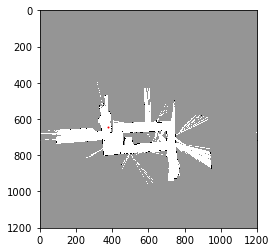

i: 19400
c_array
(100,)
[-236. -838.  -82. -350. -846. -884. -341. -126. -454. -838. -213. -227.
 -351.  -83. -128. -382. -162. -880. -914. -440. -333. -897. -253. -129.
 -370. -818. -795. -391. -372. -367. -238. -644. -150. -806. -292. -412.
 -626. -310. -180. -376. -849.  -59. -191. -327.  -98. -565. -194. -350.
 -805. -879. -824. -881. -160. -162. -605. -732. -125. -815.  -46. -363.
  -57. -380. -787. -861.  -46. -368. -109. -141. -518. -367. -504. -178.
 -827. -871. -629. -215. -356. -865. -880. -782. -867. -467. -355. -342.
 -381. -888. -875. -405. -170. -672. -422. -638. -246. -389. -473. -158.
 -879. -343. -369. -834.]
np.max(c_array)
-46.0
xy_w_scan shape
(2, 1077)
particle states
[  2.76733696 -11.03187611  -3.37471936]
particle weights
[  1.52410303e-083   0.00000000e+000   1.15975042e-016   4.71458411e-133
   0.00000000e+000   0.00000000e+000   3.82026707e-129   9.02417138e-036
   3.21230867e-178   0.00000000e+000   1.48520844e-073   1.23499347e-079
   1.73439857e-133   4.26

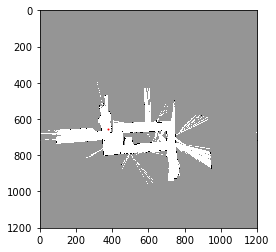

i: 19450
c_array
(100,)
[-305. -899. -880. -907.  -54. -157. -329. -249. -572.  -39. -901. -910.
 -396. -374. -397. -309.  -32. -370. -373. -231. -135. -128. -309. -911.
 -873. -629.    3. -394. -720. -235. -163. -451. -349.   -4.  -84. -326.
  -80. -356.  -39. -492. -222. -167.  -83. -191. -917. -699. -361.  -15.
 -904. -109.   26.  -25. -881.  -49.    4. -367. -862. -886.   11.  -74.
 -375. -181.   -2. -492. -483. -376. -908. -835. -914. -342.  -15.  -79.
 -280.   22. -325. -450. -139.  -63.    1.  -27. -283. -163.  -72. -205.
 -333.  -42. -154. -947. -917. -710. -314.    4. -100. -917.  -42. -169.
 -375. -203. -319. -196.]
np.max(c_array)
26.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[  2.63850328 -10.9772867   -3.41263899]
particle weights
[  1.74037945e-144   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.77238842e-035   3.28267031e-080   6.57016657e-155   3.64028120e-120
   1.92316824e-260   5.79396853e-029   0.00000000e+000   0.00000000e+000
   

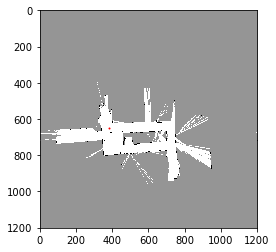

i: 19500
c_array
(100,)
[-899. -804. -124. -892. -444. -929. -138. -864. -189.  -69.  -59. -405.
 -686. -912. -328. -922. -927. -644. -112.   20. -934. -683. -871. -922.
 -938. -461. -764. -256.  -36. -698. -932. -904. -927.  -49. -648. -238.
 -792. -157. -307. -937. -910. -900.  -73. -135. -436. -144. -224. -908.
 -910. -675. -772. -929. -166. -871. -910.   25. -884. -469.  -23. -107.
 -764. -268. -918. -230. -381. -105. -905. -950. -932.  -48. -929. -661.
 -898. -807. -396. -793. -936.   92. -353.   43. -392. -238. -912. -936.
  -71. -644.  -30.   27. -351. -774. -181.   87. -848. -173. -128. -776.
 -718. -912. -533. -687.]
np.max(c_array)
92.0
xy_w_scan shape
(2, 1079)
*****Updating map*****
particle states
[  2.53564975 -10.97571826  -3.38868957]
particle weights
[  0.00000000e+000   0.00000000e+000   1.54694713e-094   0.00000000e+000
   1.64150141e-233   0.00000000e+000   1.28633096e-100   0.00000000e+000
   9.12712811e-123   1.19034260e-070   2.62190405e-066   1.42143189e-216
   

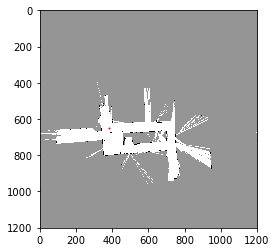

i: 19550
c_array
(100,)
[-791. -761. -337. -911.  -98.  -80. -104. -909. -603.   -7. -915. -886.
 -368. -872. -867. -887. -443.   38. -921. -703. -135. -881. -909. -703.
 -558. -902. -760.   37. -604. -724. -903. -917. -242. -905. -711. -859.
 -219. -255. -535. -907.  -50.  -98.   -4.   25. -916. -905. -871. -205.
 -383. -366. -812.  -17. -869. -258. -928. -698. -199.  -96. -857. -848.
 -452.  -56. -940. -908. -910. -922. -564. -814. -101. -763.  -84. -881.
 -948. -775.  -28. -614. -931. -411. -905. -701. -919. -286. -189. -871.
 -846. -105. -618. -633. -906. -505. -268. -213. -561. -240.  -68.   34.
 -245. -187. -809.  -83.]
np.max(c_array)
38.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[  2.47979117 -10.98942196  -3.20803802]
particle weights
[  0.00000000e+000   0.00000000e+000   9.94819352e-164   0.00000000e+000
   6.22479997e-060   4.08720174e-052   1.54297365e-062   0.00000000e+000
   2.98821636e-279   2.06501520e-020   0.00000000e+000   0.00000000e+000
   

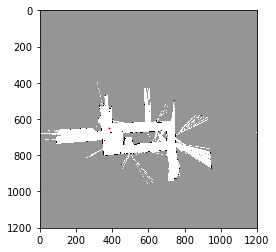

i: 19600
c_array
(100,)
[-906. -685. -850.  -90. -263. -903. -645. -264.  -97. -499. -895. -533.
 -913. -374. -905. -170. -757. -705. -677. -935. -729. -311. -726. -603.
 -972. -670. -910. -944. -232. -766. -908. -918. -351. -345. -524. -718.
 -664. -463. -319. -221. -910. -366. -110. -776. -911. -911. -914. -919.
 -700. -253. -591. -944. -331. -929. -447. -264. -944. -853. -780. -243.
 -366. -542. -395. -566. -765. -562. -451. -264. -949. -715. -229. -134.
 -955. -885. -891. -961. -905. -438. -299. -340. -916. -110. -656. -377.
 -362. -911. -627. -795. -404. -723. -821. -968. -714. -667. -450. -428.
 -461. -577. -877. -745.]
np.max(c_array)
-90.0
xy_w_scan shape
(2, 1081)
particle states
[  2.27558828 -10.99866505  -3.0840505 ]
particle weights
[  0.00000000e+000   3.92995358e-259   0.00000000e+000   9.99088945e-001
   7.35628902e-076   0.00000000e+000   9.25053173e-242   2.70622750e-076
   9.11051191e-004   2.36135376e-178   0.00000000e+000   4.04714412e-193
   0.00000000e+000   4.57

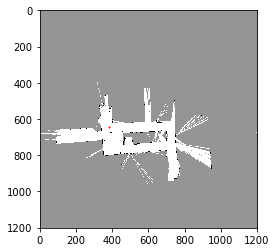

i: 19650
c_array
(100,)
[-604. -928. -821. -895. -738. -658. -806. -952. -885. -813. -668. -186.
 -742. -592. -786. -829. -339. -774. -404. -349. -920. -793. -695. -886.
 -634. -765. -820. -711. -713. -816. -845. -952. -854. -616. -833. -500.
 -758. -765. -785. -792. -514. -836. -811. -661. -620. -585. -802. -793.
 -406. -724. -773. -877. -908. -657. -918. -875. -817. -464. -679. -916.
 -659. -543. -847. -585. -550. -253. -904. -640. -899. -880. -872. -881.
 -798. -733. -935. -587. -645. -325. -682. -755. -768. -778. -671. -551.
 -917. -794. -919. -784. -609. -927. -924. -633. -929. -545. -900. -206.
 -863. -742. -357. -765.]
np.max(c_array)
-186.0
xy_w_scan shape
(2, 1081)
particle states
[  2.14682765 -11.00178185  -3.02928043]
particle weights
[  2.91679941e-182   0.00000000e+000   1.67110597e-276   1.21678075e-308
   1.85971326e-240   1.03039689e-205   5.46287444e-270   0.00000000e+000
   2.68013795e-304   4.98149669e-273   4.67799466e-210   9.99999998e-001
   3.40618366e-242   4.7

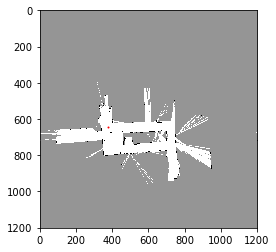

i: 19700
c_array
(100,)
[-852. -374. -364. -810. -863. -859. -470. -921. -935. -951. -537. -518.
 -728. -448. -487. -945. -693. -676. -508. -715. -839. -832. -679. -465.
 -931. -881. -684. -871. -863. -808. -338. -874. -157. -417. -860. -538.
 -527. -482. -566. -648. -837. -733. -829. -503. -345. -580. -684. -321.
 -374. -823. -409. -722. -342. -842. -384. -299. -891. -883. -524. -316.
 -476. -887. -695. -933. -848. -852. -929. -925. -848. -835. -695. -867.
 -642. -893. -604. -985. -833. -367. -958. -380. -857. -188. -878. -888.
 -455. -548. -902. -384. -860. -868. -400. -909. -594. -369. -749. -573.
 -897. -242. -850. -166.]
np.max(c_array)
-157.0
xy_w_scan shape
(2, 1081)
particle states
[  2.0129476  -11.0133274   -2.93973616]
particle weights
[  1.46312518e-302   5.72853847e-095   1.26179457e-090   2.54477696e-284
   2.44366790e-307   1.33419746e-305   1.16351925e-136   0.00000000e+000
   0.00000000e+000   0.00000000e+000   9.29058977e-166   1.65820584e-157
   1.04183091e-248   4.1

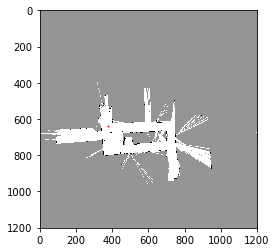

i: 19750
c_array
(100,)
[-897. -909. -399. -893. -787. -456. -644. -455. -622. -683. -689. -671.
 -661. -312. -563. -840. -900. -835. -706. -864. -803. -400. -701. -803.
 -803. -700. -593. -672. -927. -507. -841. -827. -667. -786. -776. -847.
 -721. -554. -913. -550. -385. -724. -845. -922. -376. -876. -518. -674.
 -383. -910. -845. -611. -875. -741. -903. -834. -851. -311. -774. -903.
 -928. -874. -726. -684. -389. -824. -882. -910. -504. -344. -822. -596.
 -821. -350. -876. -894. -567. -848. -769. -840. -784. -315. -752. -883.
 -438. -925. -773. -677. -527. -558. -663. -879. -795. -884. -918. -841.
 -790. -552. -857. -665.]
np.max(c_array)
-311.0
xy_w_scan shape
(2, 1078)
particle states
[  1.91738567 -11.09979375  -2.8816139 ]
particle weights
[  2.29937207e-255   1.41278303e-260   4.36778487e-039   1.25541461e-253
   1.36145177e-207   7.68202597e-064   1.73026719e-145   2.08819116e-063
   6.20285708e-136   1.99815134e-162   4.95292199e-165   3.25208705e-157
   7.16319841e-153   2.6

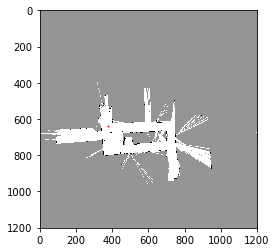

i: 19800
c_array
(100,)
[-829. -859. -820. -837. -400. -385. -730. -618. -788. -355. -880. -806.
 -827. -658. -803. -745. -804. -829. -842. -856. -876. -425. -481. -683.
 -535. -386. -362. -588. -891. -551. -608. -446. -739. -585. -840. -745.
 -725. -498. -885. -825. -569. -875. -348. -655. -799. -873. -656. -845.
 -434. -721. -701. -897. -363. -681. -764. -660. -332. -818. -650. -812.
 -682. -416. -681. -314. -839. -793. -416. -420. -562. -910. -787. -366.
 -591. -761. -797. -742. -654. -624. -827. -903. -836. -349. -777. -762.
 -747. -864. -852. -735. -351. -580. -538. -805. -576. -699. -535. -705.
 -852. -542. -594. -872.]
np.max(c_array)
-314.0
xy_w_scan shape
(2, 1071)
particle states
[  1.79873291 -11.13812466  -2.93787482]
particle weights
[  2.17942442e-224   2.03942320e-237   1.76600590e-220   7.31115444e-228
   4.47377924e-038   1.46248620e-031   2.15523942e-181   9.42925748e-133
   1.39449054e-206   1.56288217e-018   1.54640497e-246   2.12380626e-214
   1.61038893e-223   4.0

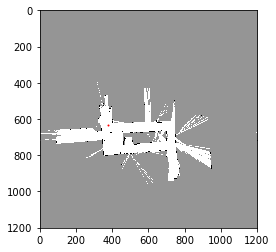

i: 19850
c_array
(100,)
[-494. -796. -536. -645. -773. -803. -367. -457. -617. -673. -691. -845.
 -290. -593. -267. -718. -368. -252. -807. -708. -767. -685. -353. -333.
 -379. -743. -799. -420. -882. -676. -633. -863. -568. -649. -677. -762.
 -438. -657. -310. -799. -625. -627. -598. -668. -437. -727. -830. -306.
 -832. -605. -624. -474. -779. -453. -866. -737. -597. -794. -613. -722.
 -362. -847. -641. -656. -627. -774. -839. -516. -681. -458. -689. -631.
 -820. -771. -644. -692. -860. -804. -863. -295. -547. -388. -747. -864.
 -596. -512. -243. -518. -748. -513. -391. -724. -762. -798. -769. -624.
 -788. -398. -376. -817.]
np.max(c_array)
-243.0
xy_w_scan shape
(2, 1061)
particle states
[  1.66451076 -11.08951475  -2.98759318]
particle weights
[  9.81819039e-110   6.84065857e-241   5.64499042e-128   2.59158037e-175
   6.66608732e-231   6.23787318e-244   1.40420544e-054   1.15060771e-093
   3.74809142e-163   1.79192236e-187   2.72909412e-195   3.58647908e-262
   3.87351960e-021   9.9

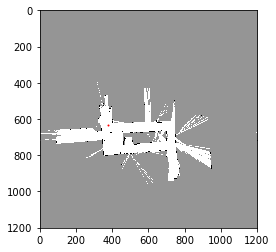

i: 19900
c_array
(100,)
[-656. -765. -835. -369. -804. -458. -491. -807. -404. -449. -540. -707.
 -823. -484. -420. -286. -503. -646. -384. -846. -782. -558. -673. -485.
 -756. -793. -442. -515. -486. -830. -615. -502. -490. -845. -512. -740.
 -767. -653. -587. -764. -404. -503. -732. -605. -488. -827. -830. -801.
 -568. -331. -514. -841. -804. -803. -728. -374. -871. -853. -651. -580.
 -378. -808. -765. -473. -739. -789. -782. -478. -466. -847. -491. -834.
 -739. -704. -679. -504. -802. -487. -532. -611. -721. -466. -749. -649.
 -734. -834. -437. -696. -503. -433. -611. -453. -429. -311. -284. -873.
 -400. -467. -707. -462.]
np.max(c_array)
-284.0
xy_w_scan shape
(2, 1065)
particle states
[  1.42639701 -11.06813819  -2.9430998 ]
particle weights
[  2.43965602e-162   1.12003107e-209   4.45262722e-240   1.07113671e-037
   1.29343699e-226   2.38581088e-076   1.11152212e-090   6.43964357e-228
   6.75364202e-053   1.93324258e-072   5.82758341e-112   1.73105163e-184
   7.24686414e-235   1.2

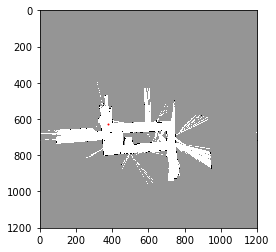

i: 19950
c_array
(100,)
[-472. -768. -553. -464. -688. -579. -590. -776. -605. -286. -484. -272.
 -554. -282. -822. -636. -709. -313. -275. -634. -515. -462. -711. -460.
 -759. -542. -405. -701. -743. -626. -532. -660. -302. -626. -596. -745.
 -814. -746. -380. -550. -781. -786. -695. -750. -645. -605. -490. -664.
 -421. -688. -831. -413. -822. -572. -794. -770. -776. -290. -272. -820.
 -666. -715. -829. -717. -575. -807. -287. -301. -778. -783. -732. -670.
 -319. -424. -703. -700. -373. -348. -285. -670. -773. -705. -703. -662.
 -273. -760. -746. -415. -281. -494. -446. -706. -479. -280. -682. -543.
 -573. -486. -475. -710.]
np.max(c_array)
-272.0
xy_w_scan shape
(2, 1048)
particle states
[  1.40498313 -11.10344963  -3.00230791]
particle weights
[  5.72289842e-088   1.60860492e-216   3.79981981e-123   1.70597197e-084
   8.91267245e-182   1.94136177e-134   3.24240434e-139   5.39626835e-220
   9.91859012e-146   3.43866344e-007   3.51627031e-093   4.13535138e-001
   1.39787559e-123   1.8

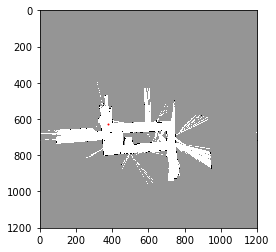

i: 20000
c_array
(100,)
[-417. -812. -376. -599. -441. -718. -403. -493. -505. -439. -769. -526.
 -798. -797. -502. -716. -593. -661. -806. -273. -500. -428. -249. -832.
 -749. -548. -443. -581. -381. -784. -589. -438. -499. -637. -549. -732.
 -278. -717. -311. -526. -493. -718. -806. -424. -366. -618. -778. -751.
 -900. -310. -480. -791. -798. -729. -614. -432. -747. -760. -645. -436.
 -263. -385. -454. -250. -368. -485. -235. -814. -638. -546. -529. -685.
 -800. -537. -763. -722. -731. -305. -732. -328. -685. -743. -774. -354.
 -532. -360. -731. -794. -373. -372. -754. -245. -776. -268. -622. -238.
 -534. -264. -704. -772.]
np.max(c_array)
-235.0
xy_w_scan shape
(2, 1067)
particle states
[  1.2547097  -11.05700357  -2.98997067]
particle weights
[  8.65533383e-080   2.46016067e-251   5.53805904e-062   7.86480785e-159
   3.26750497e-090   1.63924841e-210   1.04089415e-073   8.52909984e-113
   5.24046006e-118   2.41437776e-089   1.16312447e-232   3.97361051e-127
   2.95859976e-245   8.0

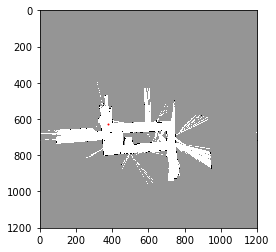

i: 20050
c_array
(100,)
[-549. -293. -805. -742. -376. -746. -294. -790. -759. -379. -386. -796.
 -392. -659. -791. -354. -696. -655. -394. -695. -735. -791. -790. -414.
 -425. -752. -437. -371. -772. -523. -386. -748. -379. -825. -364. -333.
 -453. -562. -655. -716. -429. -415. -404. -368. -467. -369. -487. -507.
 -325. -759. -788. -682. -676. -463. -408. -371. -344. -600. -683. -805.
 -735. -466. -427. -574. -307. -708. -373. -821. -788. -478. -689. -788.
 -589. -493. -794. -379. -320. -509. -369. -312. -722. -409. -541. -291.
 -729. -372. -560. -392. -429. -733. -732. -307. -777. -381. -606. -317.
 -409. -368. -742. -448.]
np.max(c_array)
-291.0
xy_w_scan shape
(2, 1081)
particle states
[  1.14199287 -11.02732051  -2.90207074]
particle weights
[  7.55545107e-113   1.14195178e-001   4.99888367e-224   1.14663552e-196
   1.02613799e-037   2.10013621e-198   4.20100581e-002   1.63414375e-217
   4.74699963e-204   5.10884023e-039   4.65865927e-042   4.05063739e-220
   1.15476618e-044   1.2

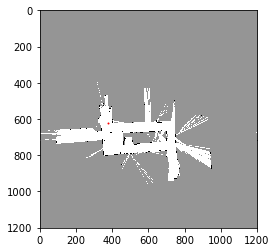

i: 20100
c_array
(100,)
[-790. -589. -403. -693. -826. -362. -508. -792. -633. -663. -648. -900.
 -518. -392. -620. -735. -304. -829. -594. -615. -287. -677. -684. -908.
 -348. -631. -711. -431. -396. -422. -680. -752. -688. -641. -710. -599.
 -703. -605. -847. -769. -727. -376. -708. -715. -823. -804. -725. -619.
 -588. -800. -477. -403. -487. -402. -741. -643. -608. -714. -360. -787.
 -766. -645. -187. -622. -779. -211. -903. -742. -646. -661. -674. -768.
 -341. -656. -729. -785. -606. -643. -292. -609. -699. -555. -623. -642.
 -617. -751. -481. -344. -671. -833. -450. -773. -312. -702. -250. -720.
 -368. -493. -361. -810.]
np.max(c_array)
-187.0
xy_w_scan shape
(2, 1073)
particle states
[  1.00989347 -10.98045994  -2.9490941 ]
particle weights
[  1.31955474e-262   2.59190020e-175   1.55737037e-094   1.76600593e-220
   3.06073735e-278   9.96473301e-077   3.90365393e-140   1.78582315e-263
   2.01679182e-194   1.88723775e-207   6.16941298e-201   2.22861168e-310
   1.77225614e-144   9.3

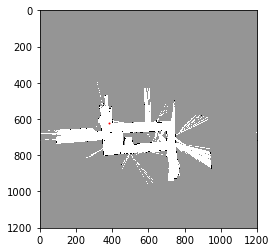

i: 20150
c_array
(100,)
[-343. -294. -384. -223. -527. -578. -774. -659. -723. -773. -447. -782.
 -699. -820. -353. -193. -903. -716. -309. -342. -799. -285. -546. -791.
 -806. -753. -269. -726. -409. -331. -732. -195. -220. -238. -673. -636.
 -317. -686. -764. -792. -488. -488. -321. -453. -319. -580. -730. -777.
 -703. -655. -825. -466. -253. -512. -734. -785. -778. -815. -593. -606.
 -776. -310. -652. -239. -437. -590. -193. -184. -738. -171. -593. -733.
 -820. -688. -662. -416. -261. -833. -586. -592. -831. -701. -748. -317.
 -592. -318. -813. -615. -313. -430. -777. -783. -519. -815. -368. -208.
 -644. -683. -642. -570.]
np.max(c_array)
-171.0
xy_w_scan shape
(2, 1081)
particle states
[  0.9036978  -10.98414629  -2.93813575]
particle weights
[  2.00146560e-075   3.81748856e-054   3.12805494e-093   2.61027317e-023
   2.46129382e-155   1.74640467e-177   1.31955176e-262   1.15955633e-212
   1.85970906e-240   3.58691357e-262   1.36370996e-120   4.42660301e-266
   4.92620605e-230   1.3

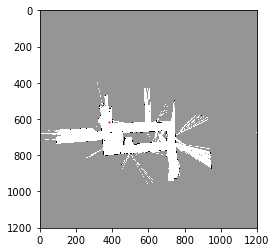

i: 20200
c_array
(100,)
[-530. -255. -687. -836. -545. -450. -274. -800. -236. -583. -423. -406.
 -311. -208. -224. -332. -556. -257. -441. -692. -309. -752. -648. -311.
 -284. -602. -417. -685. -181. -201. -170. -249. -227. -307. -306. -583.
 -526. -217. -732. -535. -830. -236. -837. -421. -658. -735. -545. -618.
 -444. -352. -693. -750. -619. -829. -317. -815. -293. -268. -642. -336.
 -647. -737. -764. -860. -626. -261. -555. -816. -635. -308. -738. -741.
 -531. -482. -257. -648. -308. -318. -355. -733. -263. -319. -708. -232.
 -824. -680. -825. -166. -529. -412. -588. -603. -180. -658. -336. -782.
 -842. -246. -675. -426.]
np.max(c_array)
-166.0
xy_w_scan shape
(2, 1081)
particle states
[  0.87199855 -10.99190903  -3.01581595]
particle weights
[  8.10822308e-159   2.18729929e-039   5.30508113e-227   1.03469947e-291
   2.48032425e-165   4.49246023e-124   1.22549927e-047   4.46082899e-276
   3.90394210e-031   7.78606720e-182   2.39020556e-112   5.77353024e-105
   1.04572436e-063   5.6

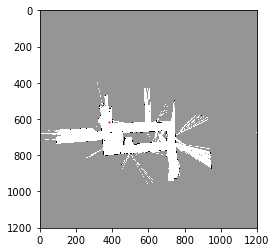

i: 20250
c_array
(100,)
[-625. -610. -298. -624. -632. -658. -683. -185. -824. -581. -225. -578.
 -180. -584. -856. -654. -178. -635. -266. -421. -399. -572. -626. -394.
 -416. -902. -263. -714. -232. -394. -721. -612. -296. -716. -787. -553.
 -357. -533. -391. -513. -527. -885. -305. -729. -724. -682. -227. -394.
 -885. -632. -621. -628. -565. -631. -386. -275. -324. -574. -680. -497.
 -292. -669. -885. -665. -640. -615. -209. -260. -546. -297. -381. -725.
 -182. -246. -334. -591. -825. -641. -277. -681. -526. -591. -233. -606.
 -607. -515. -411. -656. -690. -191. -610. -369. -271. -443. -508. -310.
 -738. -370. -890. -745.]
np.max(c_array)
-178.0
xy_w_scan shape
(2, 1081)
particle states
[  0.78064898 -11.05409782  -3.09549926]
particle weights
[  6.42611032e-195   2.10070663e-188   6.64115719e-053   1.74679789e-194
   5.85985411e-198   2.99385163e-209   4.15784434e-220   7.89805610e-004
   2.41738753e-281   8.25858001e-176   3.35537403e-021   1.65878014e-174
   1.17217546e-001   4.1

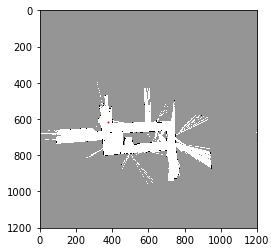

i: 20300
c_array
(100,)
[-563. -890. -644. -618. -650. -541. -306. -651. -345. -673. -611. -612.
 -409. -640. -680. -899. -558. -753. -590. -628. -866. -533. -429. -568.
 -334. -542. -306. -685. -270. -600. -379. -544. -647. -681. -566. -540.
 -672. -642. -852. -850. -687. -544. -815. -843. -611. -900. -420. -292.
 -550. -573. -287. -312. -395. -736. -684. -708. -399. -288. -652. -688.
 -647. -681. -861. -369. -524. -810. -456. -388. -276. -355. -534. -534.
 -351. -872. -764. -647. -793. -777. -659. -699. -272. -293. -292. -548.
 -397. -528. -606. -685. -612. -603. -817. -879. -604. -591. -642. -565.
 -501. -769. -296. -327.]
np.max(c_array)
-270.0
xy_w_scan shape
(2, 1081)
particle states
[  0.67973197 -11.00584664  -3.20373998]
particle weights
[  4.96187128e-128   4.80120126e-270   3.29452236e-163   6.44835575e-152
   8.16630447e-166   1.77878761e-118   2.03857805e-016   3.00421553e-166
   2.35419563e-033   8.38016336e-176   7.07148073e-149   2.60145238e-149
   3.77568459e-061   1.7

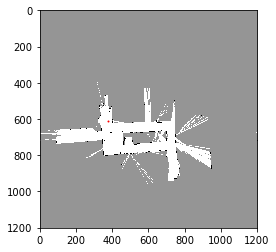

i: 20350
c_array
(100,)
[-366. -330. -518. -581. -742. -335. -601. -555. -283. -454. -663. -820.
 -578. -341. -493. -623. -828. -546. -514. -311. -317. -641. -592. -313.
 -563. -660. -616. -416. -934. -581. -340. -583. -462. -473. -349. -754.
 -399. -550. -680. -440. -598. -372. -858. -880. -601. -908. -605. -329.
 -427. -599. -387. -254. -850. -307. -846. -288. -341. -516. -420. -383.
 -658. -400. -392. -396. -581. -561. -510. -320. -314. -602. -708. -389.
 -487. -845. -256. -382. -486. -581. -887. -590. -531. -300. -593. -911.
 -597. -492. -627. -553. -568. -243. -377. -641. -513. -567. -689. -790.
 -825. -501. -654. -608.]
np.max(c_array)
-243.0
xy_w_scan shape
(2, 1081)
particle states
[  0.56606432 -10.96228816  -3.26692895]
particle weights
[  3.81742480e-054   1.64578022e-038   3.70688610e-120   1.61605777e-147
   1.93662394e-217   1.10891799e-040   3.33094333e-156   3.16310356e-136
   4.24827370e-018   2.31129874e-092   3.94738390e-183   2.58271037e-251
   3.24593880e-146   2.7

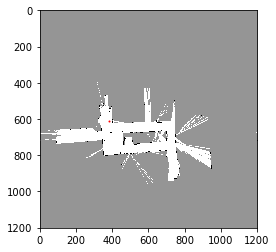

i: 20400
c_array
(100,)
[-249. -263. -374. -277. -716. -541. -267. -575. -358. -854. -330. -587.
 -400. -543. -264. -276. -485. -396. -909. -317. -441. -604. -350. -288.
 -638. -574. -450. -909. -372. -719. -311. -300. -491. -538. -803. -359.
 -719. -716. -288. -471. -236. -302. -781. -417. -550. -516. -626. -644.
 -569. -445. -477. -729. -285. -376. -773. -305. -917. -549. -301. -382.
 -343. -572. -357. -549. -561. -857. -247. -437. -881. -475. -352. -408.
 -369. -507. -620. -865. -280. -390. -598. -513. -886. -523. -379. -605.
 -391. -342. -338. -581. -538. -495. -425. -597. -356. -575. -362. -458.
 -825. -870. -617. -926.]
np.max(c_array)
-236.0
xy_w_scan shape
(2, 1081)
particle states
[  0.46969736 -11.00107845  -3.31537563]
particle weights
[  2.26028655e-006   1.87949318e-012   1.16775911e-060   1.56285255e-018
   3.45653096e-209   3.46876425e-133   3.44241183e-014   5.94514429e-148
   1.03768365e-053   4.03647204e-269   1.50075731e-041   3.65282290e-153
   5.96618523e-072   4.6

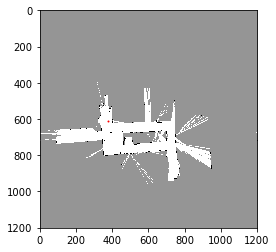

i: 20450
c_array
(100,)
[-395. -292. -292. -312. -554. -475. -525. -482. -367. -555. -577. -471.
 -416. -345. -293. -541. -317. -327. -352. -330. -303. -923. -549. -308.
 -439. -538. -560. -748. -542. -579. -372. -291. -539. -389. -351. -897.
 -943. -315. -423. -385. -718. -343. -492. -308. -386. -285. -516. -563.
 -355. -875. -292. -775. -348. -480. -326. -339. -536. -310. -628. -329.
 -455. -675. -932. -284. -533. -545. -608. -291. -383. -518. -518. -251.
 -460. -576. -339. -563. -558. -293. -805. -321. -894. -339. -485. -712.
 -396. -503. -422. -469. -469. -362. -532. -539. -483. -327. -248. -649.
 -500. -310. -546. -562.]
np.max(c_array)
-248.0
xy_w_scan shape
(2, 1081)
particle states
[  0.28839033 -10.9934112   -3.34956652]
particle weights
[  1.37280844e-064   7.41210525e-020   7.41210525e-020   1.52774876e-028
   1.21559056e-133   2.47771522e-099   4.77889286e-121   2.25938383e-102
   1.98543391e-052   4.47190776e-134   1.24742440e-143   1.35278668e-097
   1.04094030e-073   7.1

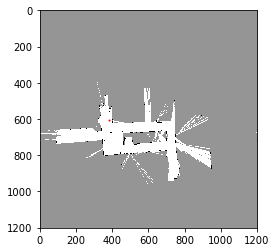

i: 20500
c_array
(100,)
[-557. -305. -253. -953. -570. -480. -915. -460. -905. -459. -292. -429.
 -492. -556. -284. -304. -318. -971. -298. -295. -303. -483. -934. -949.
 -380. -382. -930. -370. -373. -423. -906. -895. -312. -362. -895. -559.
 -948. -501. -327. -934. -282. -826. -345. -427. -280. -901. -464. -324.
 -254. -323. -454. -378. -535. -265. -427. -502. -762. -763. -936. -962.
 -393. -419. -962. -962. -625. -860. -529. -358. -341. -339. -878. -523.
 -483. -341. -482. -336. -888. -298. -549. -477. -837. -491. -312. -368.
 -790. -552. -947. -979. -853. -936. -976. -838. -428. -668. -294. -453.
 -776. -897. -608. -320.]
np.max(c_array)
-253.0
xy_w_scan shape
(2, 1080)
particle states
[  0.28421829 -10.92627194  -3.38002973]
particle weights
[  6.89330871e-133   1.90825834e-023   7.31055295e-001   7.20796874e-305
   1.55811484e-138   1.90152848e-099   2.29616560e-288   9.22555438e-091
   5.05764131e-284   2.50776568e-090   8.44239043e-018   2.67991742e-077
   1.16833948e-104   1.8

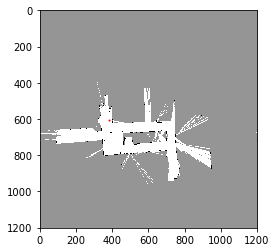

i: 20550
c_array
(100,)
[-938. -572. -330. -955. -322. -439. -502. -811. -356. -956. -542. -294.
 -456. -789. -334. -606. -400. -538. -335. -525. -451. -503. -516. -412.
 -510. -923. -450. -445. -538. -493. -873. -425. -315. -319. -902. -621.
 -672. -394. -580. -489. -554. -383. -908. -335. -555. -406. -877. -504.
 -659. -919. -351. -664. -552. -436. -318. -520. -402. -514. -311. -325.
 -508. -306. -467. -548. -497. -490. -504. -490. -534. -609. -785. -867.
 -344. -502. -339. -407. -492. -476. -483. -327. -337. -540. -411. -350.
 -374. -583. -326. -306. -424. -315. -316. -295. -927. -346. -890. -453.
 -883. -305. -547. -787.]
np.max(c_array)
-294.0
xy_w_scan shape
(2, 1081)
particle states
[  0.1175092  -10.94026786  -3.38776157]
particle weights
[  1.50763640e-280   1.34920204e-121   1.69567107e-016   6.24152080e-288
   5.05472423e-013   7.78472157e-064   3.39383500e-091   2.15623363e-225
   8.66333447e-028   2.29612718e-288   1.44182134e-108   7.31043062e-001
   3.22282624e-071   7.7

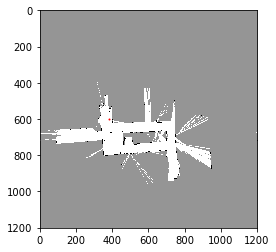

i: 20600
c_array
(100,)
[-516. -858. -435. -495. -377. -400. -402. -488. -415. -477. -542. -821.
 -450. -807. -841. -523. -939. -550. -459. -407. -380. -315. -902. -961.
 -389. -428. -958. -457. -971. -429. -498. -339. -333. -982. -540. -342.
 -280. -331. -443. -458. -407. -702. -381. -392. -984. -414. -498. -435.
 -397. -350. -508. -371. -759. -336. -825. -341. -897. -982. -443. -319.
 -368. -386. -443. -367. -407. -333. -798. -493. -452. -862. -448. -511.
 -934. -399. -780. -426. -327. -640. -491. -543. -508. -515. -557. -532.
 -426. -335. -377. -463. -442. -427. -459. -529. -421. -363. -410. -386.
 -387. -479. -378. -337.]
np.max(c_array)
-280.0
xy_w_scan shape
(2, 1081)
particle states
[  0.51867378 -10.77707795  -3.35105101]
particle weights
[  3.20997959e-103   9.50144065e-252   4.83454164e-068   4.23337159e-094
   7.47197234e-043   7.66764807e-053   1.03770332e-053   4.64245566e-091
   2.34555134e-059   2.77963048e-086   1.64000715e-114   1.11348736e-235
   1.47889751e-074   1.3

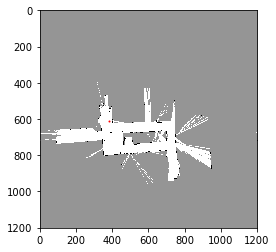

i: 20650
c_array
(100,)
[ -451.  -450.  -488.  -401.  -947.  -626.  -415.  -330.  -468.  -394.
  -629.  -432.  -439.  -522.  -603.  -513.  -531.  -579.  -731.  -412.
  -393.  -373.  -494.  -641.  -606.  -358.  -658.  -378.  -391.  -443.
  -502.  -418.  -432.  -449.  -586.  -443.  -433.  -385.  -374.  -603.
  -486.  -470.  -850.  -432.  -521.  -784.  -367.  -492.  -326.  -796.
  -450.  -286.  -412.  -394.  -463.  -673.  -351.  -510.  -304.  -471.
  -968.  -520.  -297.  -386.  -843.  -352.  -400.  -608.  -504. -1007.
  -470.  -366.  -457.  -898.  -448.  -479.  -539.  -469.  -516.  -285.
  -382.  -363.  -368.  -474.  -486.  -365.  -500.  -376.  -498.  -364.
  -391.  -373.  -413.  -443.  -470.  -452.  -948.  -385.  -559.  -398.]
np.max(c_array)
-285.0
xy_w_scan shape
(2, 1081)
particle states
[  0.42193462 -10.73320677  -3.33469976]
particle weights
[  5.90291092e-073   1.60457755e-072   5.03698200e-089   3.06048549e-051
   2.29616559e-288   5.88209313e-149   2.54488158e-057   2.09265936e-

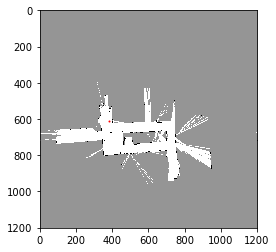

i: 20700
c_array
(100,)
[-752. -445. -286. -418. -388. -478. -395. -343. -344. -327. -839. -321.
 -340. -414. -353. -484. -394. -870. -441. -733. -347. -409. -314. -344.
 -393. -360. -579. -361. -329. -379. -321. -556. -739. -804. -322. -649.
 -319. -514. -552. -340. -347. -410. -448. -552. -321. -628. -656. -327.
 -445. -496. -556. -354. -489. -493. -434. -443. -795. -420. -881. -424.
 -498. -575. -369. -417. -514. -946. -627. -328. -373. -413. -324. -326.
 -369. -324. -344. -435. -690. -354. -458. -541. -802. -455. -517. -721.
 -290. -349. -362. -364. -404. -579. -449. -490. -417. -412. -600. -340.
 -518. -649. -446. -401.]
np.max(c_array)
-286.0
xy_w_scan shape
(2, 1081)
particle states
[-0.43841276 -9.64591898 -3.23199696]
particle weights
[  4.08215057e-203   8.69550810e-070   9.82013790e-001   4.62642978e-058
   4.94402243e-045   4.05113822e-084   4.50836489e-048   1.72715820e-025
   6.35385992e-026   1.53477186e-018   6.71845007e-241   6.19171161e-016
   3.46908997e-024   2.5259

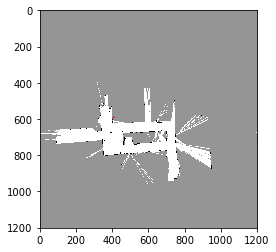

i: 20750
c_array
(100,)
[-317. -316. -121. -255. -309.    6. -281. -317. -154. -284. -311.  -30.
 -291. -135. -257. -308. -319. -264. -305. -315. -265. -304. -319. -347.
 -421. -102. -319. -126. -432. -159. -295. -279. -281. -243. -446. -317.
 -319. -377. -133. -314. -285. -259. -422. -319. -317. -301. -142. -319.
 -285. -296. -308. -258. -338. -291. -282. -461. -319. -277. -279. -317.
 -258. -280. -319. -356. -290. -113. -323. -111. -319. -169. -233. -309.
 -318. -319. -313. -258. -309. -311. -279. -319. -264. -124. -279. -325.
 -319. -319. -272. -290. -347. -218. -301. -312. -261. -311. -319. -312.
 -105. -495. -274. -152.]
np.max(c_array)
6.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.10672011 -8.58454914 -3.17037175]
particle weights
[  5.28302110e-141   1.43607403e-140   6.99199000e-056   4.45800163e-114
   1.57484639e-137   1.00000000e+000   2.27763272e-125   5.28302110e-141
   3.25748853e-070   1.13396656e-126   2.13132283e-138   2.31952283e-016
   1.03

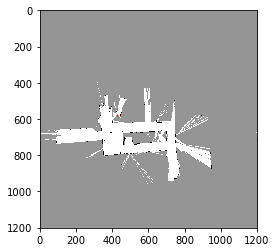

i: 20800
c_array
(100,)
[-602.  160.  131. -332.  -49. -286. -229. -386. -470.   -3.    8. -181.
 -612.  317. -120. -390. -159. -536.  -78. -322. -311. -345. -308. -298.
 -237. -339. -605. -676. -610. -598. -606. -652. -440.  -20.  -95. -655.
 -338.  288. -130. -517. -166.   10.  130. -607.  133. -304.  248. -513.
  276. -577.  -27.    6. -220. -350.   29.  126. -500. -188.  148.  142.
  -21. -651.  214. -521. -252.   -9.  150. -146. -378. -360. -152. -650.
 -254. -496. -148. -613. -580.  325. -145. -269. -249.  344. -163. -255.
 -458. -386. -156.  210. -213.   70.  -75. -273. -326. -210.   74.  209.
  -75. -268. -462.   24.]
np.max(c_array)
344.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[-1.11772144 -8.53974056 -3.17952537]
particle weights
[  0.00000000e+000   1.22974574e-080   3.12806200e-093   2.61174175e-294
   2.10023847e-171   2.48014115e-274   1.41013882e-249   9.22618187e-318
   0.00000000e+000   1.99441153e-151   1.19413679e-146   9.89457166e-229
   0.

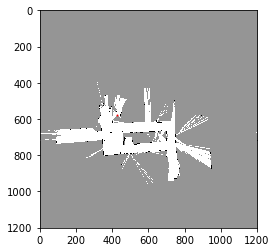

i: 20850
c_array
(100,)
[ 269.  170. -252. -513.  -56.  103. -388. -337. -577. -612.  171. -407.
    8. -297. -315. -392. -581. -678. -406. -330. -376. -343. -376. -143.
  336. -666. -573. -246.  118. -324. -579. -434. -333. -399. -392. -375.
 -316. -418. -602. -573. -334.  208. -242. -527. -328.  451.   80.  105.
  -21. -359. -397. -463. -551.   17.  348. -570.  290. -209.  332. -520.
 -572. -596. -328. -109. -640. -307. -272. -551. -107. -624. -577. -550.
 -659. -681. -578. -336.  -52. -576.   95. -358. -343. -402. -391. -268.
 -573. -296.  243. -340.  -46. -397. -582.   61. -389.  109. -619. -716.
  338.  118. -427.  417.]
np.max(c_array)
451.0
xy_w_scan shape
(2, 1080)
*****Updating map*****
particle states
[-1.11521968 -8.53521842 -3.18051006]
particle weights
[  9.08666032e-080   9.18862622e-123   4.90884390e-306   0.00000000e+000
   6.49677274e-221   7.33703005e-152   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.49772757e-122   0.00000000e+000
   4.

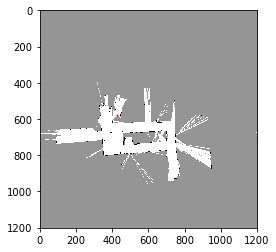

i: 20900
c_array
(100,)
[ 298. -134. -394.  324.   96. -340. -144.   17. -377. -165. -392. -143.
 -388. -150. -105.  -23. -417. -478. -309. -534. -356.  126.  395. -392.
 -526. -442.   97.  102. -412. -608. -652.  250.  187.   47. -246. -375.
 -246. -144.  305. -393. -478. -306.  -24. -413. -332. -383. -577.   12.
 -571.  295. -204.  171.  161.  -32.  121. -240.   91.  -39. -664.    7.
 -592. -383. -314. -397. -742.  -85. -362.  193. -200. -367. -547. -322.
 -121.   70. -237. -598.  403. -410. -394. -372.  -44. -287.   45.  -93.
  205. -187. -305. -205.  276.   89. -410.  -38.  393. -262.  217. -366.
 -264. -114. -316. -139.]
np.max(c_array)
403.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.08716527 -8.54590654 -3.1244252 ]
particle weights
[  2.50561318e-046   6.07712043e-234   0.00000000e+000   4.90422689e-035
   4.69276364e-134   0.00000000e+000   2.75900841e-238   2.30231430e-168
   0.00000000e+000   2.09203480e-247   0.00000000e+000   7.49976242e-238
   0.

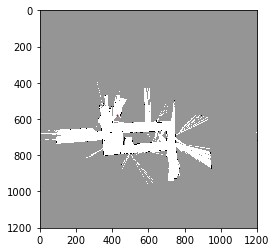

i: 20950
c_array
(100,)
[-409. -445. -410. -322. -413. -607. -675. -437. -444. -331.  112. -358.
 -384. -418. -488. -427. -488. -295. -430. -332. -461. -457. -369. -678.
  -68.  -33. -194. -345. -370. -565. -487.    4. -336. -427. -470. -176.
 -668.  125. -245. -551.  150. -674.  123. -357. -754. -425. -371. -407.
 -467. -369. -392. -299. -486. -493.  125. -588. -644. -238. -339.   39.
 -630. -480. -682. -619. -383. -708. -590. -374. -305.  322. -454. -386.
 -283. -454. -206. -423. -404.  -66. -473. -605. -365.  -36. -341. -184.
 -471. -278. -631. -368. -481. -244. -340. -457. -426.  -27. -326. -464.
 -237. -591. -597. -488.]
np.max(c_array)
322.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.03869233 -8.54869569 -3.04070154]
particle weights
[  3.39423099e-318   0.00000000e+000   1.24850389e-318   2.06230861e-280
   6.22522714e-320   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.54509101e-284   6.28288051e-092   4.78357190e-296
   2.

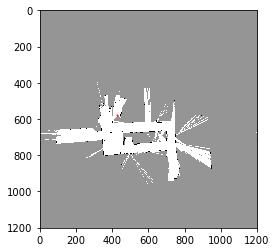

i: 21000
c_array
(100,)
[-479. -490.  186. -697. -354. -354. -396. -415. -385.  332. -242. -591.
 -377. -667. -174. -157. -486. -365. -651. -438. -605. -392. -387. -471.
 -428. -396. -594. -520. -376. -177.  155. -375. -196. -333. -458. -414.
 -390. -372. -187.  284. -512.  141. -377. -312. -523. -247. -683. -363.
 -219. -608. -448.  109. -665. -413. -314. -682.  -90. -328. -305. -392.
   34.   80. -372. -375. -178. -175. -500.  -49. -432.  227. -443. -522.
 -540. -222. -390. -641. -588. -412. -200. -348. -682. -338. -371. -678.
 -433. -195. -616. -416.  -83. -670. -374. -151. -392. -324.  319. -313.
  -88. -339.  -93. -547.]
np.max(c_array)
332.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.09543843 -8.54431714 -3.09588579]
particle weights
[  0.00000000e+000   0.00000000e+000   3.91746081e-064   0.00000000e+000
   1.18572625e-298   1.18572625e-298   6.81734950e-317   0.00000000e+000
   4.08183546e-312   9.99997740e-001   5.18759910e-250   0.00000000e+000
   1.

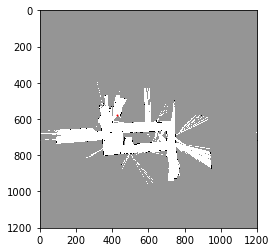

i: 21050
c_array
(100,)
[ 161. -237. -302. -292. -279. -389. -540. -450.  133. -487. -270. -585.
  -19. -251. -671. -413.  315. -295. -407. -307.  353. -186. -268. -274.
 -478.  360. -273.  194. -672. -480. -656.  347. -383. -346. -583.   91.
 -202.  -52. -429.  201. -613. -421. -331. -385. -424. -404. -689. -106.
 -607. -455. -304. -110.  -52. -264. -262. -296. -104. -649. -101. -481.
 -380. -406.  136.  100. -423. -349. -218. -697.  323. -361. -658.  -86.
 -339. -564. -166. -214. -321. -113. -458. -465.  -86. -257. -225. -695.
 -556. -210. -170.   59. -360.  -17.  247.  103. -439. -338. -276.   23.
 -107. -360. -586.  366.]
np.max(c_array)
366.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.11048592 -8.54031565 -3.11454178]
particle weights
[  9.30154415e-090   1.31628901e-262   7.76622432e-291   1.71062474e-286
   7.56803295e-281   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.43145979e-102   0.00000000e+000   6.13244062e-277   0.00000000e+000
   6.

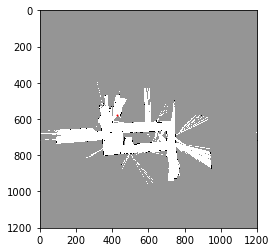

i: 21100
c_array
(100,)
[-454. -477.  459. -195. -466. -819. -531. -784. -277. -737. -674. -369.
  265. -672. -496.   69. -704. -798.  -78. -260. -706. -342.  -44. -236.
 -200.   48. -306. -694. -459. -326. -491.  172. -582. -448.  -12. -391.
  392. -382.  -33. -306. -501. -766.  171.  340. -362. -252. -472. -509.
 -517. -483. -383. -402. -635. -239.    5. -514. -368.  -12. -352. -522.
  136.  318.   14. -752.   82. -453. -495. -785. -265. -532. -320.  169.
 -549. -269. -426. -319. -757. -386.  133. -433.  123. -458. -768. -329.
 -803. -753.  265.  404. -265. -695. -580. -328. -371. -848.  -19. -324.
 -518. -259.   25. -386.]
np.max(c_array)
459.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.10193988 -8.54482634 -3.18279524]
particle weights
[  0.00000000e+000   0.00000000e+000   1.00000000e+000   9.36286659e-285
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.27270197e-320   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.

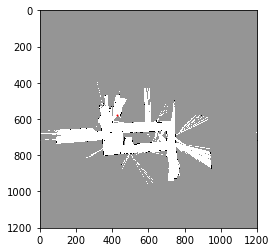

i: 21150
c_array
(100,)
[ 225. -256. -397. -551. -163.  499. -641. -248. -275. -377.  472. -492.
 -292.  115. -499. -576.  453. -544. -296. -377. -533. -520. -470.   33.
 -130.  439. -110.   74.  459.  337.   78. -631. -454. -209. -532.   58.
 -561.  -39. -318. -283. -387. -486.  278. -257.  471. -309. -764. -345.
 -351.  237. -454. -451. -347.  460. -333. -543. -337.  510. -542. -218.
 -559. -164. -552.   71. -514. -521. -195. -521. -438. -838.  148.  135.
 -486. -341. -299. -742.  308. -533.  -79. -348. -680. -142. -620. -627.
 -507.  -94.  342.  163. -567. -625.  473. -134.  449.  180.  401. -403.
 -195. -684. -209. -427.]
np.max(c_array)
510.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.12489535 -8.54018133 -3.18504818]
particle weights
[  1.68292749e-124   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.24573595e-293   1.67014218e-005   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.13908036e-017   0.00000000e+000
   0.

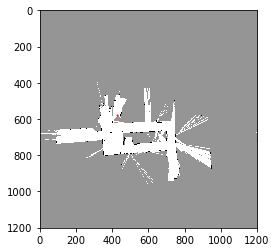

i: 21200
c_array
(100,)
[-327.    3. -454. -610. -317.  359.  143. -393. -605. -486. -193. -550.
 -504. -413. -631. -687. -566. -350.  114. -691. -272. -543. -503. -286.
  409.  141. -186. -771. -151. -103. -430.  425.   49. -471. -124. -551.
  343. -387. -422.  448.   42.  -63. -132. -457. -591. -269. -641. -359.
 -520. -679.  186.  166. -276. -572. -279.  -81.   92.  305. -110. -303.
 -333.  249. -340.  391. -391. -460. -537. -276. -115.   89. -639. -509.
 -266. -530.  -79. -372.  177. -778.   65. -768. -540. -761. -140. -492.
  131. -400. -833.   63.  -51.  -34.  296.  122. -449. -137. -286.  277.
 -315. -426. -429.  125.]
np.max(c_array)
448.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.1354548  -8.54150047 -3.18995562]
particle weights
[  0.00000000e+000   5.48220855e-194   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.22736356e-039   3.46883002e-133   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.14225757e-279   0.00000000e+000
   0.

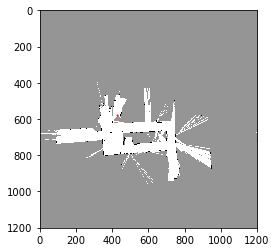

i: 21250
c_array
(100,)
[-738. -460.  121.  395.  242.  335.  352.  359. -523.   53. -255. -387.
 -368.  112.  299.  -35. -439. -185. -409.  368. -446. -452. -163. -344.
 -504. -749. -459. -341.  313. -504. -572. -389. -591.  459. -361. -275.
 -442.  268.  -23.   16.  226. -333. -638. -702. -542. -316. -550. -488.
  464. -495. -549. -431.  437. -151.  120. -518. -519.  -37. -331. -339.
 -315. -331.  -71. -847.  264. -315.  -13. -313.  286.   43.  474. -503.
 -331. -544. -391.  344. -304.  423. -349. -589. -646. -504.  250. -154.
 -610.  -22. -623.  430. -544. -506.   86. -370.  386. -574. -663. -691.
 -297. -538. -236.  402.]
np.max(c_array)
474.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.126613   -8.54355094 -3.19196314]
particle weights
[  0.00000000e+000   0.00000000e+000   4.94342602e-154   4.90587050e-035
   1.75250937e-101   4.29583079e-061   1.03765590e-053   1.13792786e-050
   0.00000000e+000   1.45212255e-183   2.50786141e-317   0.00000000e+000
   0.

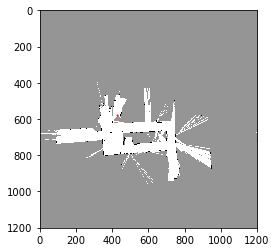

i: 21300
c_array
(100,)
[ 146. -439. -277.  -65.   97.  335. -240. -542. -567.  271.   60. -722.
 -498.   35.  461.  440. -476. -450. -480. -810. -537. -258. -528. -497.
 -234. -231. -485. -584.  313. -240. -527.  447. -457. -447. -815.  161.
 -529.  347.   12.   42. -193.   96.  473. -679. -696.  219. -211. -490.
  481. -556.   97. -263.  473. -466. -479. -276.  326. -316. -262.  355.
 -106. -249.   92.  132. -265.  370.  147.   96. -740. -481.  375. -569.
 -590.   66. -334. -607.  184.  131.  -30.   -2.  148. -505. -810. -238.
 -622.  487.  377. -307.   30. -834. -624. -663. -303. -404. -226.  357.
 -334. -406. -476. -554.]
np.max(c_array)
487.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.13394407 -8.54124187 -3.18658418]
particle weights
[  8.02612232e-149   0.00000000e+000   0.00000000e+000   1.85511182e-240
   4.20800416e-170   9.68641014e-067   1.84857102e-316   0.00000000e+000
   0.00000000e+000   1.55351701e-094   3.59070999e-186   0.00000000e+000
   0.

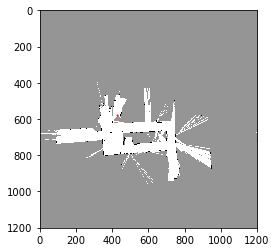

i: 21350
c_array
(100,)
[-472. -334.  462. -683.  601. -506.  547.  533.  -81.  -27. -346. -394.
 -763.  261. -339.  275.  426.  291.  319.  529.  261. -510.  485. -239.
 -349.  620.  275.  193. -539.   15. -572. -201. -749.  200. -311. -263.
 -255. -458. -463. -498. -508. -685. -372. -500.  141. -463.  235. -183.
 -391.   46. -488. -302. -517. -280.  -65. -453. -692. -487. -536. -300.
  265. -510. -115.  546. -148.  536. -514.   68.  189. -448.  324. -450.
  122. -542.   23. -489.  233. -414. -489. -247. -411.  521. -495.  -32.
 -491.   -1. -297.  188. -255. -107.  551.  502. -108. -244. -516. -102.
 -309.   83. -268.  126.]
np.max(c_array)
620.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.10115761 -8.54087944 -3.1819054 ]
particle weights
[  0.00000000e+000   0.00000000e+000   2.40697654e-069   0.00000000e+000
   5.60279641e-009   0.00000000e+000   1.97925987e-032   1.64581142e-038
   3.62717228e-305   1.02676299e-281   0.00000000e+000   0.00000000e+000
   0.

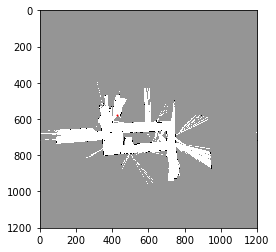

i: 21400
c_array
(100,)
[-144. -238. -366. -180. -524. -487.  463. -663. -295.  -96. -547.  -19.
  528.  149. -287.  427. -376. -231.  235. -495. -423. -423.   33. -227.
 -425.  494. -676. -284. -551.  477. -754.   81.   62. -182.  452. -303.
 -528. -241. -315. -166. -267.  502.  -67.  299.  178. -303. -692. -327.
 -491.  189. -364. -399.   -9. -692. -412. -763.   97. -307. -661. -390.
  362.  -74.  158. -526. -484. -723. -538. -759. -331. -488. -607.  -38.
  304. -187. -316.  132. -470.   55.  112. -758. -386. -480. -214. -641.
 -248.  525. -341.  -20. -561.  341. -416. -436. -542. -512. -288.  446.
 -337. -501. -744. -145.]
np.max(c_array)
528.0
xy_w_scan shape
(2, 1075)
*****Updating map*****
particle states
[-1.13667627 -8.51658566 -3.17775002]
particle weights
[  1.35833516e-292   0.00000000e+000   0.00000000e+000   3.15068941e-308
   0.00000000e+000   0.00000000e+000   5.62027360e-029   0.00000000e+000
   0.00000000e+000   9.53107910e-272   0.00000000e+000   2.62916099e-238
   9.

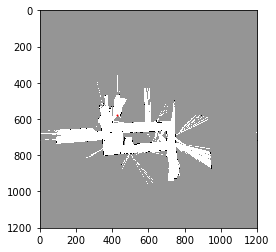

i: 21450
c_array
(100,)
[  66.  261.   53. -591. -620. -673. -249.  316. -208. -138. -670. -467.
  202. -778.   38. -409.  -53.  195. -288.  385.  201. -272. -531. -321.
  296. -480. -272. -391. -592. -551.  332.  189. -377. -628. -134. -461.
 -555. -504. -379. -397. -459.  -50. -801. -330. -503.   59. -419. -465.
 -223.   56. -257. -171. -288.   30. -260. -736. -655. -491. -472.  -22.
  314. -514.  -65. -483.  355. -407. -285. -493.  -56. -416. -778. -243.
 -491.   10. -510.  196. -447. -431. -248. -607.  -26. -593. -486.  234.
 -630.  257. -495. -233. -627. -375.   46. -239.  145.  122. -401. -395.
 -348. -249. -414. -597.]
np.max(c_array)
385.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.07215629 -8.54738616 -3.22397936]
particle weights
[  2.88443179e-139   1.40437873e-054   6.51976599e-145   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.54253700e-276   1.08063928e-030
   2.90651274e-258   7.31115455e-228   0.00000000e+000   0.00000000e+000
   3.

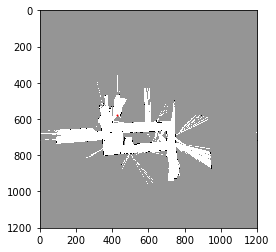

i: 21500
c_array
(100,)
[ 210.   78. -306.  -28. -160. -432.  107.  277. -554. -734. -633. -178.
 -387. -327. -532.  423. -508. -195. -581. -412. -246. -434. -500. -746.
 -211.  316. -244. -657.  191.   32. -717.  447. -521. -415.  439. -436.
 -526. -703.  134. -315. -223.   23. -690. -531. -141. -469. -449.  407.
 -747. -474.  272. -103. -547. -550. -313. -222. -455. -312. -535. -378.
 -272. -545. -414. -593. -179. -574. -527. -273.  454.  365. -422. -482.
  -49.   67. -290.  110.  176. -594. -224. -375. -142. -638.  -94. -238.
 -785.  456. -288.  398. -384. -573. -509. -266.  -62. -383.  229. -515.
  416. -629.  -74.  252.]
np.max(c_array)
456.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[-1.06144503 -8.5486048  -3.20132769]
particle weights
[  1.28347111e-107   6.04664519e-165   0.00000000e+000   5.57570006e-211
   2.62680475e-268   0.00000000e+000   2.37713836e-152   1.60737194e-078
   0.00000000e+000   0.00000000e+000   0.00000000e+000   4.00061831e-276
   0.

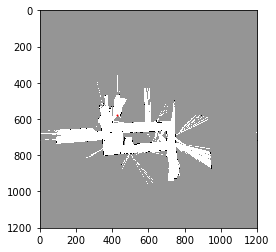

i: 21550
c_array
(100,)
[ 152. -645.  -31.  297. -141.  399. -276.  -33. -146.  351. -802.  -60.
 -831. -109. -441. -555.  233. -418.  323.    0.  116. -549. -284. -210.
 -492. -377. -148.   83. -211. -106. -309. -239. -298. -355. -192.  160.
 -461. -443. -435. -184. -346.  444. -731. -640. -245. -284. -427. -250.
 -523. -794.  372.  202. -264. -100.  103. -270. -334.  362.   76. -338.
 -637. -199. -362.  337. -483. -277. -426. -719. -322. -604. -381. -341.
 -289. -706. -479. -297. -702. -414. -285.  355.  256. -203. -333. -362.
  425. -334.  437. -294. -429. -540. -291. -529. -476. -290.  492. -187.
 -538. -699. -816.  -66.]
np.max(c_array)
492.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[-1.08185619 -8.52426249 -3.14152243]
particle weights
[  2.18713783e-148   0.00000000e+000   7.31115455e-228   2.05388455e-085
   1.23478958e-275   4.07955867e-041   0.00000000e+000   9.89457172e-229
   8.31994673e-278   5.81404049e-062   0.00000000e+000   1.85971327e-240
   0.

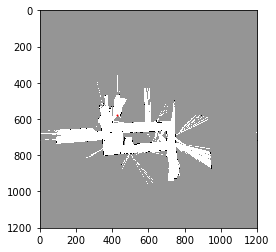

i: 21600
c_array
(100,)
[ 156. -173. -100. -410. -381.  321. -378. -307. -408. -151. -402.  346.
 -142. -559.  133.  255.   65. -641. -501. -506.  289.  -10.  -28. -557.
  136. -518.   76. -647.  233. -469. -163. -704.   88. -313. -159.  269.
 -510. -340. -439.  317.  365. -299. -590. -730. -432.   45. -533.  -78.
  138.  347.  -37. -486.  310. -328.  -93. -235.  185. -375. -566. -555.
 -348.  253. -631. -560.  268. -614. -303. -533. -532. -770. -551. -542.
  295. -306.  210. -220. -255. -706. -533. -436. -397. -418. -537.  288.
 -282. -632. -314. -549. -171. -210.  257.  147.  -22. -355. -769. -404.
 -204.  -43.  226. -457.]
np.max(c_array)
365.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.0979665  -8.54391606 -3.10233025]
particle weights
[  1.70786396e-091   2.23649910e-234   1.12996738e-202   0.00000000e+000
   0.00000000e+000   7.78113208e-020   0.00000000e+000   1.42596266e-292
   0.00000000e+000   8.01765434e-225   0.00000000e+000   5.60279632e-009
   6.

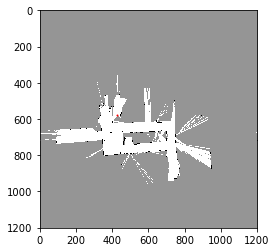

i: 21650
c_array
(100,)
[-354. -286.  -23.  346. -266. -143. -233.  291.  196.  160. -228. -683.
  208.  243. -793. -724. -528. -692.  163. -409. -185.  152. -647. -392.
   35.  408. -482. -697. -290. -258. -198.  448.  -59.  110. -527.  285.
   86.  401.  117. -689.  446. -118.  174.  246. -427. -682.  254. -254.
 -426.  392.  241.  372.  142.  321.  395. -522.  -74.  220. -226. -769.
 -263. -548. -286.  373. -491. -113.   51. -527. -660. -232. -328.  107.
    2. -389. -308.  451. -822.  400. -203.   49.  175. -309. -550. -177.
 -650.    7. -208.  432. -547. -433. -571. -270. -241. -101.  292.   87.
   73. -528.  370. -276.]
np.max(c_array)
451.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-1.10573413 -8.57331134 -3.11206565]
particle weights
[  0.00000000e+000   7.94951624e-321   1.31988408e-206   2.37246390e-046
   3.86346239e-312   1.01204066e-258   8.29267398e-298   3.08321002e-070
   1.70226562e-111   3.94844397e-127   1.23074194e-295   0.00000000e+000
   2.

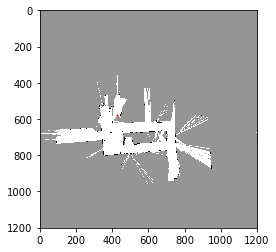

i: 21700
c_array
(100,)
[ 304. -377. -575. -521. -202.  245.  -58. -470. -716. -559. -524. -559.
 -464. -628.  501.  447. -448.  289. -595.  460.  228.  214. -260.  -24.
 -532. -447.  395. -478.   33. -111.    2.    3. -587. -570.  442. -322.
  111.  257.  324.  412.  112. -531.  -23. -690.  191. -504. -509.  148.
  445. -450.  209. -305.  430. -801.  154. -468.   21. -445. -376. -448.
 -756.  506. -325.  183. -361. -539. -455. -345.  502. -241. -179. -521.
 -491.  -75. -245. -486.  363. -459. -540.  417.  -44. -514. -448. -763.
   24. -174.  509.  -32. -500. -460. -478. -171. -228. -238. -464.  376.
  -27. -481. -237. -557.]
np.max(c_array)
509.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-1.12126458 -8.58555882 -3.12655619]
particle weights
[  8.87185171e-090   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.56677427e-309   2.11173706e-115   5.41267343e-247   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

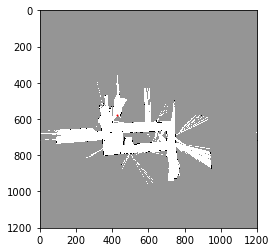

i: 21750
c_array
(100,)
[-313. -306.   34. -682. -615. -385. -498. -481. -456. -477. -242. -530.
 -324. -311.  166. -366.   62. -290. -408.  -75. -312. -563. -285. -832.
 -254. -586. -273. -365. -513. -339. -290. -413. -597. -484. -181.  275.
 -315. -449. -363. -562. -446. -506. -503. -317. -319. -581. -401. -468.
 -424. -405. -386. -138. -541. -239.   -6.  171.   90. -329.  -81. -387.
 -353.  -71. -256. -169. -488. -488. -434. -527. -555. -483.   86. -109.
 -335. -415. -229. -522.   23. -273.  301. -474. -801. -153. -323. -388.
 -758.  175. -527. -492. -548. -430. -525. -299. -492. -300.  159. -462.
 -577. -313. -492. -333.]
np.max(c_array)
301.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[-1.13625104 -8.54160734 -3.01442265]
particle weights
[  2.20388085e-267   2.41684882e-264   1.10502813e-116   0.00000000e+000
   0.00000000e+000   1.18572893e-298   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.50694127e-236   0.00000000e+000
   3.

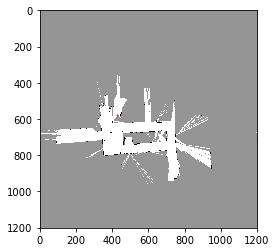

i: 21800
c_array
(100,)
[-187. -357. -344. -352. -484.   97. -527.  -54. -529. -532. -561.   81.
 -335.  293. -366.   60. -265.  223. -423. -517.  -50. -487. -331. -585.
 -516. -423.   36. -529. -375. -310. -520. -255. -494. -527. -532.  238.
 -505. -376. -536. -349. -311. -543. -186. -124. -220. -291.  168.  -64.
 -521. -567.  179. -349.  -82.  301. -142. -540. -433. -551. -479. -181.
 -476.  279. -269.  283.  269.   32. -385. -455.   79.  -23.  121. -267.
 -435. -394. -454. -537. -524.  -29.  -80. -403. -341.  238. -726. -554.
  146. -227. -406. -184.  153. -713. -199. -532. -206. -552.   10. -389.
 -180. -255. -439. -521.]
np.max(c_array)
301.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[-1.32210026 -8.6100832  -3.0113571 ]
particle weights
[  1.15917007e-212   1.71429373e-286   7.58426502e-281   2.54423748e-284
   0.00000000e+000   2.53384485e-089   0.00000000e+000   6.68826162e-155
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.85146673e-096
   6.

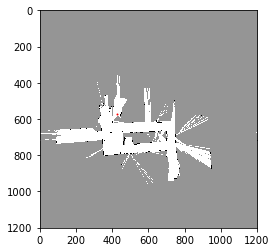

i: 21850
c_array
(100,)
[-222. -466. -152. -108.  102.  400. -534.  380. -573. -527.  252.  281.
 -556.  302.   19. -564. -453.  -18.  174.  387. -366. -181.  379. -565.
 -289.  167. -411. -329. -172. -197.  114. -294.  396. -503. -250. -529.
 -532. -167. -245.   57. -516. -493. -469.  193.  -52.  224. -123. -403.
 -172. -428. -422.  147. -275.  172.  163. -434. -555. -453.  285. -316.
 -312. -498. -550. -264.  257. -420. -247.  288.  354. -372. -545.  146.
 -247. -209.    6. -477. -578.  158. -419. -570. -536. -210.  170.  -21.
 -311. -516. -212. -534.  -52. -253.  410.    9.  391. -568.  231. -520.
 -431.  145. -402. -207.]
np.max(c_array)
410.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-1.38588055 -8.59776047 -3.08481839]
particle weights
[  3.35635088e-275   0.00000000e+000   8.44269481e-245   1.08502138e-225
   1.72694893e-134   4.53978307e-005   0.00000000e+000   9.35719032e-014
   0.00000000e+000   0.00000000e+000   2.40686526e-069   9.46219196e-057
   0.

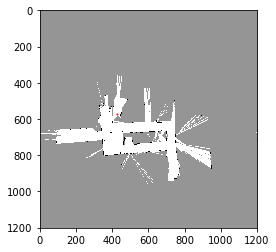

i: 21900
c_array
(100,)
[-456.  340.  105. -496.  164.  386. -491. -525. -475.  270.  -32. -507.
 -501. -368. -390. -227.   28. -452. -456. -368. -551.   32. -208.  -27.
 -371. -179.    6. -369. -704. -401. -186. -378. -444. -440. -327. -159.
 -288. -441.  119.  -74. -390.  -71.   63. -403.   92.  306.  325. -278.
 -497. -395. -765. -784. -536. -394. -449. -274. -123.  -20. -527. -502.
 -466. -131. -794. -430.   51.  216. -450. -614.  327. -583. -769. -221.
  -41.  -91. -245.  -34.  -74. -595. -371. -529.  197. -416.  -44. -178.
  -84. -464.   94. -521.  -99.  198.  337. -276. -511. -448. -325. -409.
 -175.  248. -288. -509.]
np.max(c_array)
386.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[-1.75191248 -8.57765877 -3.15635384]
particle weights
[  0.00000000e+000   1.05306174e-020   9.18862622e-123   0.00000000e+000
   3.86033521e-097   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   4.18639400e-051   2.91679942e-182   0.00000000e+000
   0.

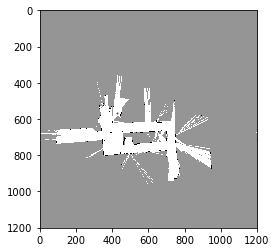

i: 21950
c_array
(100,)
[-305. -585.   54. -486. -440. -457. -296.  155.   57. -405. -158.   46.
 -445.  244. -240. -403. -162.  205.  -61.  -88. -553.   80. -353. -483.
 -520. -549. -353.  177.  233. -534. -440. -177. -373.   -5.  323.  185.
 -397. -398.  163. -223. -410. -483. -472. -652. -438. -631. -408. -249.
 -457.  284. -450. -406. -387. -437.  235. -130. -484. -214. -236.   30.
 -491.  -87. -101. -201. -106. -632. -425. -298. -456. -323.  -55. -304.
 -530. -377. -315. -483. -274.   41. -631. -447. -498. -169. -454. -484.
 -669. -165. -494. -158.  126. -255. -283. -293. -311.  297.  245. -409.
 -418. -444.  311. -371.]
np.max(c_array)
323.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[-1.80896623 -8.58652903 -3.15729519]
particle weights
[  1.83257896e-273   0.00000000e+000   1.49548375e-117   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.48495411e-269   1.09275895e-073
   3.00375942e-116   6.81732282e-317   1.27160298e-209   5.01678910e-121
   0.

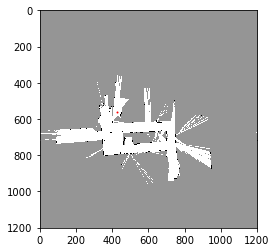

i: 22000
c_array
(100,)
[-451.    8. -316. -442. -479. -381. -507.  544.    8. -468. -371. -420.
 -139. -659. -198. -299. -520.  -76.  490. -319. -511.   -6. -517. -193.
 -110. -254. -405.  101. -154. -189.  173. -497.  197. -460. -368. -463.
 -487. -520. -433.   -9. -239.  204. -254. -452. -453. -218. -430. -294.
   27. -446. -453. -222.  145. -245. -305. -486. -305. -396. -240.  -38.
  138.  -71. -597. -823. -393. -261. -525.  251.  -60. -454.  210. -542.
  -83. -367. -549. -560. -397.  -90.  -71. -457.   21. -454.  307.  -57.
 -677.  205. -294. -110.  211. -476. -480. -443. -654.  554.   52.  403.
 -140.  -25.   58. -164.]
np.max(c_array)
554.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-1.92699667 -8.52887037 -3.15143066]
particle weights
[  0.00000000e+000   7.50227819e-238   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   4.53978687e-005
   7.50227819e-238   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.

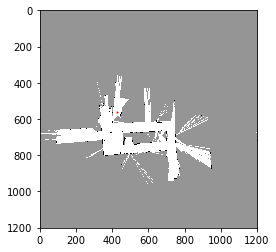

i: 22050
c_array
(100,)
[-401. -447. -488. -253. -126. -218. -155.  428.  -64.  473. -474. -178.
  -98. -214. -289. -306.  -95. -386.  -27. -476. -169. -266. -540.  160.
 -413. -382. -288. -541. -173.   22. -478. -584. -143. -495.   30. -140.
 -486. -458. -546.   43. -464. -483. -529.   99. -453. -343. -267.  -68.
 -112.  271.   76. -312.  107. -436. -382. -398.  287. -736.  110. -398.
 -250. -402. -567. -216. -670.   48.  253. -131. -171.  470. -515.  114.
  234. -454. -265. -226. -408. -132.  -13.  120. -375. -444. -380.  142.
 -467. -244.  -73.   34.  331. -438. -361. -404. -293. -132.  385. -539.
 -156. -254. -123. -477.]
np.max(c_array)
473.0
xy_w_scan shape
(2, 1072)
*****Updating map*****
particle states
[-2.04608311 -8.52154816 -3.10393208]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   4.79849169e-316
   6.86284391e-261   7.61047539e-301   1.74567803e-273   2.72676114e-020
   5.79111247e-234   9.52574127e-001   0.00000000e+000   1.79139378e-283
   9.

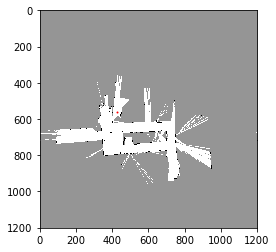

i: 22100
c_array
(100,)
[-434. -778.  -14. -157.  318. -391. -648. -145. -459.  -61.  -88.  -89.
 -482. -427. -281.  -57.  -86. -643.  260. -439.  176.   64.  -85. -458.
 -549.  140. -267.  -36. -409. -439. -437. -150. -306.   71.   92.  189.
 -179. -412.   81. -165.  -48.  -91.   44. -460. -654. -171.  167. -176.
  195. -394. -126. -338. -245. -341. -442. -383.  208.  317.  -76.  -87.
   72. -372. -401.  149. -444. -397. -496.  251. -183. -247. -195. -542.
  -20. -280. -441. -325.  -13. -140. -186.  198. -663. -468. -496. -195.
 -421.  265. -179. -432.  -76.  278.  127.  496. -354. -459.  -49.  262.
 -461. -484. -377. -462.]
np.max(c_array)
496.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[-2.17971921 -8.47996146 -3.2853218 ]
particle weights
[  0.00000000e+000   0.00000000e+000   3.23455268e-222   2.54509101e-284
   4.96114844e-078   0.00000000e+000   0.00000000e+000   4.14225757e-279
   0.00000000e+000   1.25306494e-242   2.35517167e-254   8.66419238e-255
   0.

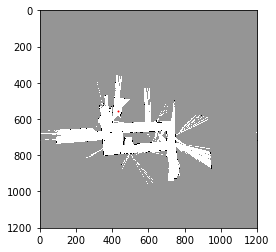

i: 22150
c_array
(100,)
[ 310. -384.  -86.  -59. -475.   29. -423. -652. -381. -100. -697.   70.
 -307. -251. -236.   60.  361.   87. -565. -403. -225. -712.    3. -458.
 -180.  -58. -432. -343. -671.  251. -495. -486.   83.  534.  339. -273.
 -342. -202.    9. -413.  330. -551. -576. -185. -439.  414. -343. -153.
 -307. -108.  426.  111. -530. -368.   38. -133. -502. -135.  138. -211.
  199.  371. -638. -500. -115. -487.  -75. -479.  -67. -546.   70. -187.
 -748.   -9. -100. -294. -219.  -76. -105. -802. -458.   61. -563.  560.
   40. -181.  -65. -565.   24.  531.  103.    5.  -49. -209.  394.  242.
  -99. -424. -563. -749.]
np.max(c_array)
560.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[-2.27625482 -8.42633194 -3.26792434]
particle weights
[  2.66919022e-109   0.00000000e+000   2.79103119e-281   1.48496324e-269
   0.00000000e+000   2.45261912e-231   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.32082259e-287   0.00000000e+000   1.56929239e-213
   0.

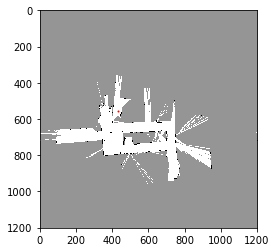

i: 22200
c_array
(100,)
[ -95.  406.  -13. -535. -330. -156.   97.   74. -287. -478. -206. -426.
 -441. -484.   96. -203.  -56.  141. -213. -290. -387.  247.   32.  -43.
 -432. -377. -204.  411.  -97. -343. -362.  171. -505. -587. -266. -506.
 -522.  492. -136. -406. -595.  165. -345. -146. -320. -249. -430. -396.
  -54. -268.  -55.  388. -267. -327. -460. -441. -454. -390. -430. -198.
 -112.   30. -240. -511. -340.  525.  154. -548. -279. -451.   29. -119.
  262. -276. -173. -384. -157. -351. -352. -100. -251. -245.  221. -435.
  104. -530. -520. -352. -751. -335. -414. -190.  473.  -86.  225. -543.
 -510. -389. -125. -250.]
np.max(c_array)
525.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-2.3721465  -8.42318497 -3.24095276]
particle weights
[  5.46287446e-270   2.08428284e-052   2.23649914e-234   0.00000000e+000
   0.00000000e+000   1.75977776e-296   1.32422489e-186   1.35890364e-196
   0.00000000e+000   0.00000000e+000   3.39423099e-318   0.00000000e+000
   0.

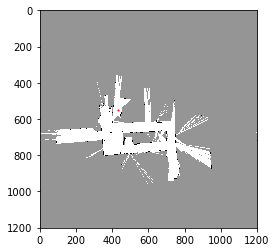

i: 22250
c_array
(100,)
[-424.  -44. -218. -122.   -8. -360. -574.  -43. -145. -193. -274. -696.
  -82. -331.  136. -556. -532. -443. -314. -755. -363. -294. -445. -363.
 -183. -490. -357.  -79. -194. -692. -304. -156.  -29.   49. -436. -600.
 -241. -546. -355. -118.  -62.   80. -416. -449. -197. -421. -419. -424.
 -123.  -34.  208.   91. -154. -310.  277. -164.  172.  419. -140. -305.
  386. -598. -342.  222. -572. -425. -323.  -98.  398. -334.  104. -435.
 -294. -299.   60. -338. -327. -310. -430.  272. -201. -496. -610.  308.
   89.  452.  -16. -493. -111. -706. -303. -188. -702. -106. -516. -439.
 -561. -517.  253. -498.]
np.max(c_array)
452.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-2.48939098 -8.38465207 -3.23832531]
particle weights
[  0.00000000e+000   3.88988692e-216   1.05365183e-291   5.18761082e-250
   1.67702032e-200   0.00000000e+000   0.00000000e+000   1.05738089e-215
   5.32346378e-260   7.58680938e-281   5.03739451e-316   0.00000000e+000
   1.

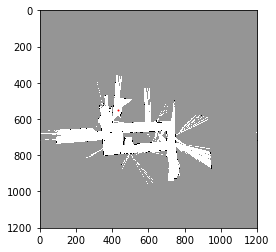

i: 22300
c_array
(100,)
[-543.  440.  411. -607. -494. -352.  -17. -459. -464. -403. -185.  -93.
 -221.  351. -481.  -21.  -70.  -82. -339. -519.  -76.  305.  126. -469.
  -44.   -6. -397. -370. -632.  286.    3.   34. -235.  196.  -46.   91.
 -461. -535.  119.  285. -500.  258.   17. -578. -410.  140. -121. -459.
  435.  148. -783. -488.  337.  165. -450. -491. -407. -327. -538.  306.
 -484.  337.  244. -561. -213. -460. -580.   34. -487. -438.   -7. -373.
   62. -182.  -92.  268.   38. -539. -574. -450. -400.  231. -158.  419.
   98.  254. -183. -776.  196. -493. -130.  146.  -13. -538.   89. -161.
 -458. -466. -532. -476.]
np.max(c_array)
440.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-2.58930609 -8.34228959 -3.35644251]
particle weights
[  0.00000000e+000   9.93307148e-001   2.52664127e-013   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.34584125e-199   0.00000000e+000
   0.00000000e+000   0.00000000e+000   3.65622043e-272   3.29704372e-232
   8.

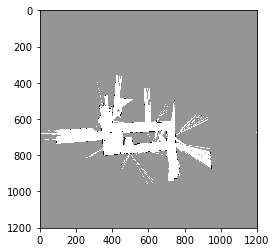

i: 22350
c_array
(100,)
[-615. -118. -474. -220. -615.  248. -390.  214.  -38. -434. -430. -416.
  -77.  185. -135. -112.   43.  -61. -341. -397. -408.  450.  171. -620.
  200. -186.  -70.  188.   -2.  206.  459. -228.  224. -513. -445.  -82.
 -215.  404. -165. -490.  -65. -348.  253. -476. -441.  -33.  128. -602.
   28.   79. -117. -265. -577.  381. -408. -315.  244. -120.   27.  135.
 -596. -478. -450.  354.  215.  367.   32. -416.  -81.  256. -369.  194.
 -231. -515.  207.  170. -535. -517. -208. -627. -125. -762. -459.  -54.
 -114. -205. -497. -336.  226. -136.  423. -201.  216. -110. -302.  155.
 -398. -476. -440.  113.]
np.max(c_array)
459.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[-2.73247723 -8.25859312 -3.48645668]
particle weights
[  0.00000000e+000   2.58244065e-251   0.00000000e+000   1.30014921e-295
   0.00000000e+000   2.31105736e-092   0.00000000e+000   3.96094070e-107
   1.43083285e-216   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.

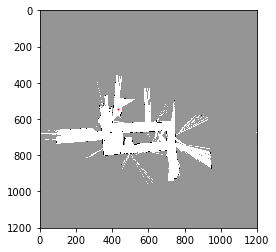

i: 22400
c_array
(100,)
[-606.   78.    4. -279. -304.  290. -230. -428. -352. -435. -108. -468.
 -138. -351. -199. -582. -254. -302.  131. -402.  104. -352. -397. -373.
  -66. -424. -131. -527. -315. -354. -528.  -88. -420. -435.  240.    5.
 -536. -167. -265. -561. -439. -338.   37. -281. -504. -293. -317.   89.
 -570. -366. -536.   29. -306. -272. -405. -546. -179.  -28. -424. -149.
 -224. -546. -509. -414.  105. -708. -199. -307. -154. -399. -324. -222.
 -557. -254.  -83. -426. -451. -350.  320. -230.  -93. -379.  103. -372.
 -324. -401. -353. -106. -343.  292. -584. -427.  482.  -27. -418. -587.
 -539. -348.   66. -701.]
np.max(c_array)
482.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-2.84330721 -8.26608584 -3.482896  ]
particle weights
[  0.00000000e+000   3.50775547e-176   2.55409855e-208   0.00000000e+000
   0.00000000e+000   4.12533740e-084   6.05799464e-310   0.00000000e+000
   0.00000000e+000   0.00000000e+000   5.83788690e-257   0.00000000e+000
   5.

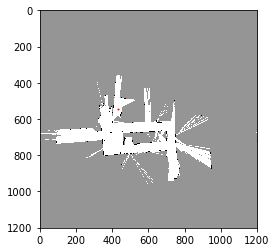

i: 22450
c_array
(100,)
[ 379.   82. -304. -429. -286. -405.   73. -403. -440. -488.   87.  499.
 -405.  101. -509.  407. -372. -330.   84.   42. -309.  379. -126.   11.
 -597.  -31. -306. -325.  117. -338. -610. -333. -376.  275. -277. -502.
   82.  -34.  -77. -134.   49. -260. -320. -642.  477.  -91. -187.  463.
  148. -332. -246. -428. -201.   16. -338. -608. -319.   -1.   44. -332.
 -247. -232. -307.  213. -323. -336.  344.  108.   80.   97. -604.   76.
 -456.   75. -147. -396. -352. -281. -350. -442. -387. -485.   80.  103.
 -149. -474. -487.   94.  241. -403.  -16. -295.   68. -218. -440. -531.
 -354. -165.  -13. -466.]
np.max(c_array)
499.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-2.97945163 -8.2927027  -3.57165716]
particle weights
[  7.66764807e-053   7.92868285e-182   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   9.78477197e-186   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.17672087e-179   1.00000000e+000
   0.

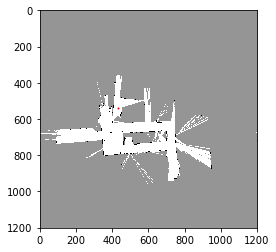

i: 22500
c_array
(100,)
[-108.  388.   52.  128.  166. -180. -260. -457. -331.    5.  283. -210.
  148.  435. -383.  -29. -706. -275.   52. -435.  204. -231.  258.  303.
  123.  566. -607.  -48. -419.  148. -451.  541. -713. -288.  461.   36.
 -104.  -91.  614. -384. -502.  271. -610. -405. -451. -148. -274. -313.
 -510. -363. -547. -463. -585.  172. -302.  215. -426. -195.  500. -339.
  402.  551. -641. -151. -393. -251.  -11. -637.  267. -191. -543.  540.
 -560.  -19. -360. -325. -342. -330. -392.  -73.  377. -212.  403. -359.
 -340. -638. -562. -142.  618.  107. -419.  334. -461.  160. -577. -356.
  188. -369. -333.  431.]
np.max(c_array)
618.0
xy_w_scan shape
(2, 1070)
*****Updating map*****
particle states
[-3.1079009  -8.26344371 -3.62691669]
particle weights
[  4.94679088e-316   1.27170608e-100   1.51859103e-246   1.54106676e-213
   4.90921176e-197   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.88301804e-267   3.18761711e-146   0.00000000e+000
   7.

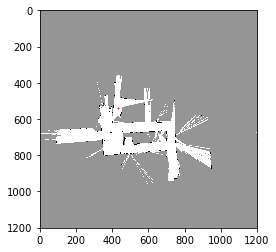

i: 22550
c_array
(100,)
[-360. -270.  316.  577. -414. -235. -237.  153.   21. -668.  129. -294.
 -208. -634.  -25.  251.  195.  -79.  -49. -203.  139.  352. -401. -246.
  557.  146.   40. -286.  659. -634.  440. -588. -170.  126. -141.  276.
 -334. -528.  141.  244. -130.  648. -532.  224.  -34. -173.   96.  148.
 -291.   58.    1. -311. -285.  -69.  270. -404. -274. -325.  450.  111.
  229. -300. -584.  162.  250.  118. -359.  268. -226.  198. -387.  156.
  554. -512.    3. -370.  135. -272.  658.  468. -268. -117. -640.   59.
 -190. -659. -569.  -59.  290.  -74.  481. -528.  621. -385.  203.  137.
  -74.  410.   -7. -122.]
np.max(c_array)
659.0
xy_w_scan shape
(2, 1064)
*****Updating map*****
particle states
[-3.1886673  -8.23829031 -3.73114443]
particle weights
[  0.00000000e+000   0.00000000e+000   7.96048599e-150   1.78566242e-036
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.29103802e-220
   6.08229417e-278   0.00000000e+000   4.87384223e-231   0.00000000e+000
   0.

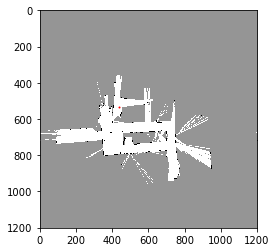

i: 22600
c_array
(100,)
[ -69.  146. -174.   42. -665.  164. -299.  -32. -124. -421. -321. -348.
 -541.  211.  436.  149.  148.  554. -379. -188. -645. -528.  224. -356.
 -623.  414. -315. -449. -266. -303.  138. -299. -369. -317.  248. -135.
  277. -151. -221. -482.  310. -627. -164.  125.   29.  149.  166.  175.
  519. -241.  153.  616.  -13. -357. -256. -141.  429.  -85. -552. -313.
  238.  512. -333.  174. -225. -578. -225.  -62.  479.  453. -428. -160.
 -516.  152.  325. -323.   98. -334.  155.  309. -511.  138.  521.  225.
   84. -291.  -23.   42. -390. -603. -142.  393. -496.  147.  502.  315.
 -659.  548.  146.  185.]
np.max(c_array)
616.0
xy_w_scan shape
(2, 1061)
*****Updating map*****
particle states
[-3.33767315 -8.17244797 -3.79228481]
particle weights
[  3.22314539e-298   7.61366047e-205   0.00000000e+000   5.18761082e-250
   0.00000000e+000   4.99912711e-197   0.00000000e+000   3.77724997e-282
   4.94065646e-322   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

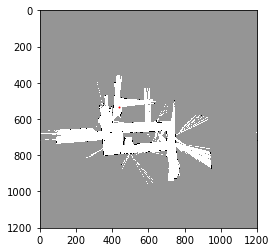

i: 22650
c_array
(100,)
[-185. -376. -285.   85.  334.  297. -323.   63.  337.   32.   64.   91.
   85.   78.  332.  -27.  -34. -299.   73.  126.  -26.  243. -238.  157.
  431.   84.  248. -115.   76. -601.   86.  244. -151.   89.  -61.   36.
 -142.  163.   93. -370. -260. -234.   59.  515. -264.  504. -115. -235.
  -13.  129.  130.   50.   45.  114.  170. -672.  509. -351. -601. -646.
 -424. -313. -182. -259. -245.   80. -117.   50.   -5.   82.  404. -142.
 -446. -246. -342.   50.   80.  139. -130.  -81.  171.  -64.   84. -322.
  -23.  102. -344. -292. -292. -357. -114. -112.  443.  232. -402. -660.
 -154. -276. -266.   37.]
np.max(c_array)
515.0
xy_w_scan shape
(2, 1031)
*****Updating map*****
particle states
[-3.48839472 -8.14887229 -3.95275615]
particle weights
[  9.83513342e-305   0.00000000e+000   0.00000000e+000   1.78768242e-187
   2.46386191e-079   2.10242510e-095   0.00000000e+000   4.98668308e-197
   4.94879894e-078   1.71665423e-210   1.35552100e-196   7.21202563e-185
   1.

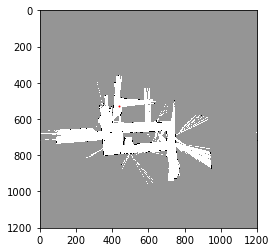

i: 22700
c_array
(100,)
[-292. -247. -154. -174. -326. -351. -193.   -9. -201.  -96.  294. -303.
 -145. -119. -130.   -4. -183. -221. -609. -311. -585. -462. -153.  480.
 -171.   46.   67.  -55. -233. -214.  329.    9.  -48. -163. -122.   46.
  -88. -152.  456. -643. -259.  483.  -89. -567.   93. -150. -195. -150.
 -344. -624.  -38.  -49. -152.  -86.   -6. -188.   -3.  284. -233.   -4.
 -495. -296. -138.   -7.  -93. -409. -627. -227.  -80. -322. -260. -222.
 -260.  140.  -67.  308.   56. -147.  142. -205. -313. -289.   17.  -50.
 -251. -359. -368.   66. -157.  -40. -601.  -55. -270. -199.   -7. -296.
  -85. -208.  152.   23.]
np.max(c_array)
483.0
xy_w_scan shape
(2, 1027)
*****Updating map*****
particle states
[-3.64932421 -8.11146255 -4.09230119]
particle weights
[  0.00000000e+000   8.78862251e-318   2.15433784e-277   4.44042124e-286
   0.00000000e+000   0.00000000e+000   2.48787763e-294   2.02308293e-214
   8.34589967e-298   3.32961301e-252   7.89299271e-083   0.00000000e+000
   1.

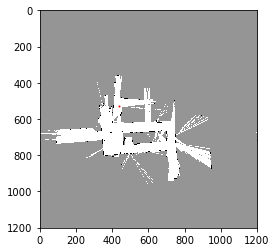

i: 22750
c_array
(100,)
[-593.  -23.   32.  -12.   45. -615. -322.  -79. -549. -428. -543. -527.
 -454. -418. -339.   -8. -539. -321. -529.  -29. -462. -336. -511. -508.
 -343. -622.   -3.  398.   -7. -271. -289.  384. -401. -592. -428. -373.
  -95. -302. -185. -472. -298. -265. -636. -579. -568. -605. -446. -383.
  -20. -333. -503. -362. -638. -196.  -95.  426.  -34. -572. -545. -217.
 -102. -396. -479.  -13. -292.  477. -310.  -20. -316. -104. -489. -592.
 -379. -440. -541. -516.  248. -357. -403. -303. -383. -389.  -62. -192.
 -429.   12. -222.   54. -348. -156. -280. -266. -385. -600. -477.  375.
 -453. -285.  -17. -382.]
np.max(c_array)
477.0
xy_w_scan shape
(2, 1035)
*****Updating map*****
particle states
[-3.68693965 -8.03731841 -4.11070699]
particle weights
[  0.00000000e+000   7.12457641e-218   5.48220856e-194   4.26577897e-213
   2.42540248e-188   0.00000000e+000   0.00000000e+000   3.40618366e-242
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

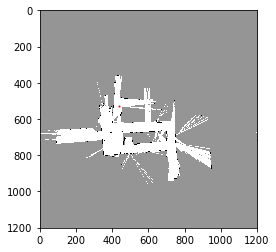

i: 22800
c_array
(100,)
[-329.  -64.  -26. -212. -312.   17. -522.  -86.  -45.  -89.   20.  -41.
  156. -293. -488.  -38.   26. -416. -124. -147.  -44. -588.  -33.  133.
 -233.  478. -276.  114. -115.  -79.  142. -179.  381.  106.   62. -270.
 -237.   51. -196. -192. -503. -129. -494. -350. -240. -111.    2. -246.
 -266.   -3.  -45. -449. -509. -181. -495. -447.  -74. -101. -283. -480.
    3.  -44. -138. -446.  333. -201.  492. -143. -231.  -59. -573. -299.
 -238. -166. -388. -409. -183. -120.  481. -629.  443. -499. -100.  -82.
 -467. -386. -165. -358. -360.  371. -107.  466. -180. -539.  521.  -48.
  -41.   26.  455. -179.]
np.max(c_array)
521.0
xy_w_scan shape
(2, 1022)
*****Updating map*****
particle states
[-3.77096133 -7.9459307  -4.16504437]
particle weights
[  0.00000000e+000   8.66419238e-255   2.76005921e-238   4.59481051e-319
   0.00000000e+000   1.30491169e-219   0.00000000e+000   2.41684882e-264
   1.54640499e-246   1.20327817e-265   2.62098519e-218   8.44308517e-245
   3.

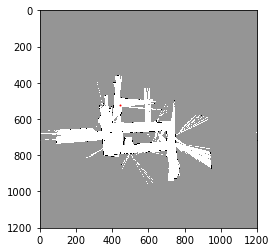

i: 22850
c_array
(100,)
[ 341.  -42. -129.   53.  -97. -162. -234.  398. -132. -550.    4. -167.
  354.   22.  -54.  -54. -545. -117. -219. -529. -253. -345. -294.   18.
 -127. -252.  -85.  422. -204.  366.  138.  374. -397. -274. -353.  222.
 -198. -127.  104. -525. -165.   59.   60. -191. -537. -448. -243. -285.
 -132.  137.  -65.  -11.   49. -433.   -6.  -56. -153.   -9. -278.   72.
 -439. -132. -331. -550. -190. -324. -309. -203. -138. -170. -111. -240.
 -126. -534.  -46. -515.  377. -187. -271. -316. -249. -190. -202. -127.
 -236. -100.  -77. -269.  318. -123. -524.  -42. -224.  155.   57.  324.
 -132. -276. -294.  -58.]
np.max(c_array)
422.0
xy_w_scan shape
(2, 1046)
*****Updating map*****
particle states
[-3.87310059 -7.86291664 -4.22531439]
particle weights
[  6.63967720e-036   3.07156986e-202   5.05522478e-240   5.56334737e-161
   3.99175513e-226   2.35517167e-254   1.26712620e-285   3.77513454e-011
   2.51684822e-241   0.00000000e+000   2.91679942e-182   1.58690219e-256
   2.

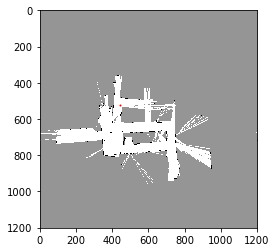

i: 22900
c_array
(100,)
[ 153.  200. -130.   90.  280. -181. -392. -326.  -73. -467. -632. -361.
 -524. -224.  -10. -125. -122. -408. -209. -252. -222.  295. -304. -520.
 -577. -177.  250.  272. -220. -389. -204. -548. -417.  259. -148. -169.
 -373.   61. -174.  135. -356. -620. -195.   35.  291. -535. -252. -448.
 -184. -582. -110. -497. -542. -319.  272. -304. -508.  211. -180.  -86.
 -389. -181.  -51. -176. -218. -174. -530. -358. -239. -134.  -55. -187.
  222. -185.  107. -154. -113.  225.  284.  276. -294. -306. -185. -357.
 -369. -227. -332. -472. -629. -263. -187. -358.  157. -397. -164. -152.
  116.  277.  217. -191.]
np.max(c_array)
295.0
xy_w_scan shape
(2, 1018)
*****Updating map*****
particle states
[-3.93774047 -7.73491313 -4.29617384]
particle weights
[  2.10036075e-062   5.42168827e-042   2.61189380e-185   9.15675373e-090
   3.00395274e-007   1.85326250e-207   4.28352451e-299   1.97349969e-270
   1.48504968e-160   0.00000000e+000   0.00000000e+000   1.24431460e-285
   0.

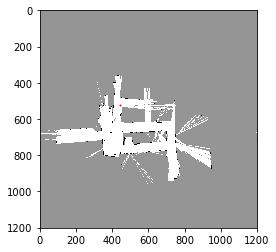

i: 22950
c_array
(100,)
[-191. -418.  249. -258. -315. -242. -268.  -64. -204. -165. -337. -555.
 -243. -243.  -14. -396. -127. -492. -188.  197. -596. -603. -231. -230.
  262.  -57.  230. -116. -331.  291.  166. -194. -608. -461. -380. -478.
 -624. -562.  251. -600. -340. -250. -390. -275. -295. -490.   66.  271.
 -248. -134. -465. -234. -330.  -92. -244. -126. -109. -171. -281.   24.
 -284. -408. -439. -160. -245. -142. -410. -240.  -58.  208. -101. -184.
 -527. -430. -385. -250. -275. -108. -181. -612.  314. -258. -345. -237.
 -452. -344. -416.    3. -464. -435. -341. -372. -384. -286. -449. -245.
 -236. -237. -614. -505.]
np.max(c_array)
314.0
xy_w_scan shape
(2, 1011)
*****Updating map*****
particle states
[-3.95622141 -7.66893579 -4.3953895 ]
particle weights
[  4.80050182e-220   1.24850389e-318   5.90009054e-029   3.83315474e-249
   6.74172266e-274   3.40618366e-242   1.74024956e-253   6.86571609e-165
   1.08507154e-225   9.39600347e-209   1.88058203e-283   0.00000000e+000
   1.

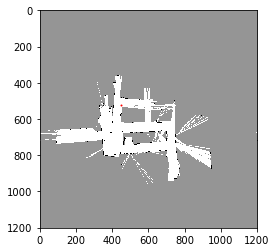

i: 23000
c_array
(100,)
[-479. -356. -572. -367. -434. -403.  200. -542. -356. -369. -418. -437.
 -284. -582. -178. -445.  188. -424. -349. -272. -332. -376. -555. -645.
 -499. -526. -471. -473. -608.    4. -304. -263. -144. -453. -309. -329.
 -296. -370.  177.  -24. -369. -203. -460. -596. -323. -358. -601. -308.
 -298. -378.  -57. -362.  188.  183. -268. -222. -398. -325. -345. -322.
  107. -228. -320.  164.  -66. -335. -582. -417. -310. -463. -294. -267.
  221. -489. -277. -450. -143. -418. -314. -462. -425. -360. -521. -542.
 -532.  182. -103. -357. -596.   53. -360. -359. -369.  164. -303. -434.
 -316.  119. -361. -327.]
np.max(c_array)
221.0
xy_w_scan shape
(2, 1019)
*****Updating map*****
particle states
[-3.97837683 -7.58044418 -4.5040995 ]
particle weights
[  9.85967654e-305   2.58275934e-251   0.00000000e+000   4.31364738e-256
   3.44440613e-285   1.00056036e-271   7.58256042e-010   0.00000000e+000
   2.58275934e-251   5.83788690e-257   3.06073735e-278   1.71486883e-286
   4.

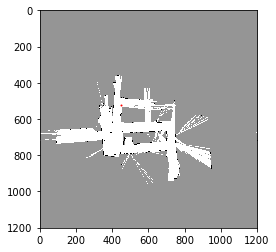

i: 23050
c_array
(100,)
[ -45. -312. -448. -478. -124. -623. -424.  140.  150.  -16. -477.  -15.
  -98. -439. -299. -504. -233.   83. -203. -363. -389. -560.  246. -420.
 -367. -233. -457. -459. -243. -588. -206. -316.  111. -153. -427. -576.
  204.    8. -564. -415. -727. -423. -419. -411. -619. -287.  -39. -215.
 -413. -215. -557. -741. -440. -179.  -37. -431. -367.   88. -385. -126.
 -416. -563. -529.  183. -439. -420. -567. -109. -578. -420. -616. -502.
 -413. -358.   98.  -72.  150. -461. -388. -424.  182. -565. -659.  -50.
  150. -302. -440.  182. -306. -511. -530. -567. -134.  236. -418. -416.
  120. -436. -358. -304.]
np.max(c_array)
246.0
xy_w_scan shape
(2, 1022)
*****Updating map*****
particle states
[-3.99844861 -7.40915909 -4.63972377]
particle weights
[  4.17144046e-127   4.60955904e-243   3.97749683e-302   3.72199166e-315
   2.04654821e-161   0.00000000e+000   1.05360399e-291   9.22072780e-047
   2.03100046e-042   1.63993270e-114   1.01174221e-314   4.45779925e-114
   4.

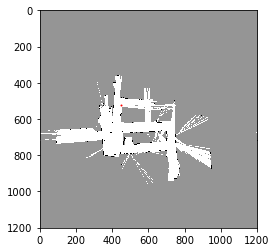

i: 23100
c_array
(100,)
[ -75. -281. -737. -479. -618. -187. -215. -130. -607.  -70. -230. -116.
 -521. -464. -231. -454. -441. -391. -529. -546. -762. -475. -544.  184.
 -521. -592. -542. -497.   27.  -20. -432. -799. -490. -438. -332. -378.
 -470. -322. -371. -485.  167. -193. -617. -331. -456. -142. -375. -506.
 -473.  -81. -246.   23. -463. -193.  -33. -488. -668. -507. -709. -465.
   65. -520.   -9. -481. -567. -327. -473. -282. -561. -462. -283. -442.
   35. -478. -526. -394. -556. -513. -471. -510. -111. -468. -301. -654.
 -457. -294. -244. -113. -514. -512.  161. -559. -590. -297. -490. -410.
 -510. -382. -262. -524.]
np.max(c_array)
184.0
xy_w_scan shape
(2, 1052)
*****Updating map*****
particle states
[-3.98913199 -7.32929863 -4.726556  ]
particle weights
[  3.29404228e-113   1.12996736e-202   0.00000000e+000   1.15546948e-288
   0.00000000e+000   7.52917161e-162   5.20597050e-174   4.28087616e-137
   0.00000000e+000   4.88879221e-111   1.59251846e-180   5.14820001e-131
   6.

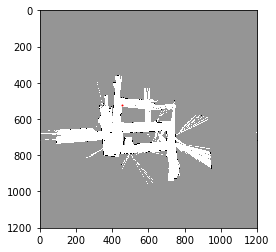

i: 23150
c_array
(100,)
[-222. -372.  235.   -5. -490. -412. -471. -293. -222. -393. -479.   46.
 -491. -340.  284. -497. -203.  279. -352. -536.   69.  -27.  -54. -624.
 -505. -505. -343. -584.  -83. -535. -399. -158. -390.  262. -540. -492.
 -121.  -84. -254. -481.  144. -502. -500. -370.  250. -324. -149. -636.
 -282.  240.  225. -526.  269.  -87. -330. -478.   31. -350.   68. -243.
 -468. -416. -202. -447. -178. -481. -107. -507. -322. -674. -461. -481.
 -430.  106. -226. -498.    1. -727. -585. -477. -499. -148.  -14. -492.
 -517. -476. -475. -565. -551.  218.  262. -479.  192. -554.   32. -480.
 -166. -567. -433.  158.]
np.max(c_array)
284.0
xy_w_scan shape
(2, 1018)
*****Updating map*****
particle states
[-3.93134293 -7.11281802 -4.88405155]
particle weights
[  1.75418578e-220   1.25864513e-285   5.20779423e-022   3.06180945e-126
   0.00000000e+000   5.34717040e-303   0.00000000e+000   2.56547254e-251
   1.75418578e-220   9.54375277e-295   0.00000000e+000   4.31515834e-104
   0.

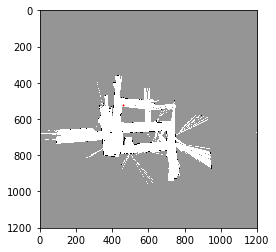

i: 23200
c_array
(100,)
[-564. -593. -452.   -8. -549. -520. -175. -553.  120.  345. -584. -405.
 -433. -664.  179.  362. -454. -445.  -73. -544. -505. -484. -485. -574.
 -303. -346. -504.  315. -273.  -80. -403. -531.  317. -720. -311.  102.
 -497.  157. -477. -507. -459. -354.   35. -154. -408.   83.  127.  -25.
 -182. -538. -546. -257. -598. -171. -451. -498.  -65. -197.  349. -104.
  -69. -583.  245. -483. -517.  151. -540. -362.  219.    8. -506. -438.
 -474. -381. -458.  181.  183.  -30.  -47. -505. -421. -424. -582.  264.
 -529. -575. -516. -177. -505. -414. -369. -471. -199. -498. -528. -601.
 -509.  -40. -435. -306.]
np.max(c_array)
362.0
xy_w_scan shape
(2, 1040)
*****Updating map*****
particle states
[-3.94773406 -7.03074572 -4.9624191 ]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.04663641e-161
   0.00000000e+000   0.00000000e+000   6.07942099e-234   0.00000000e+000
   7.95672558e-106   4.13992819e-008   0.00000000e+000   0.00000000e+000
   0.

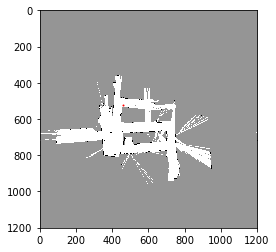

i: 23250
c_array
(100,)
[-381. -270.  473. -488. -615. -689.  273. -528. -584. -473. -490. -486.
 -259. -443. -235. -641. -457. -462.  204. -513. -366.  426. -522.  471.
  -89. -438.  364.  485.   53. -488. -472.  177. -521.  -74. -430.  146.
 -114.  136. -459. -526.  168.  281. -402.    1. -530. -389.  528.  162.
   28. -304. -283.  502.  259. -337. -551.  311. -481. -406. -457. -581.
  410.   41. -309. -450. -522. -461. -514. -418. -325.  -65.  148. -453.
   38.  341.  173. -490.  377.  357.    6.  493. -456. -577.  274.  442.
 -440. -496. -358. -236. -515.  164. -484. -511. -464.  223. -481.  -35.
 -185. -490. -472.  187.]
np.max(c_array)
528.0
xy_w_scan shape
(2, 1021)
*****Updating map*****
particle states
[-3.93231815 -6.86037181 -4.83081815]
particle weights
[  0.00000000e+000   0.00000000e+000   1.29958143e-024   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.79848622e-111   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

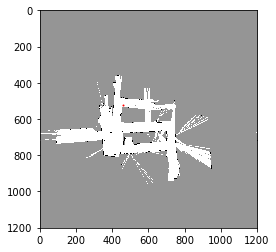

i: 23300
c_array
(100,)
[ 474. -476. -550. -485. -191. -101. -385.  -54. -309. -272. -110.  188.
 -205. -594.  130. -452. -180. -278. -215. -205. -495. -322. -269. -513.
 -470. -412. -498. -311. -228. -349. -387. -403. -496.  529. -499. -178.
  113. -507. -461. -250. -343.  542.  103. -453.  -34.  152. -466. -435.
 -210. -103. -372. -336.   60. -517.  392. -502. -447. -474.  127. -269.
 -232. -189. -482. -398.  303.  -87.   32.   45. -263.  531. -485.  -11.
  450. -229. -349. -387. -210.    6.  558. -266. -540. -470. -174.  -93.
  242. -503. -335. -367.  207. -495.  -16.   44. -389. -423. -118.  -90.
 -512. -495. -520. -493.]
np.max(c_array)
558.0
xy_w_scan shape
(2, 1020)
*****Updating map*****
particle states
[-3.93890369 -6.79965559 -4.7702056 ]
particle weights
[  3.30570025e-037   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   6.30864917e-287   0.00000000e+000   1.62845974e-266
   0.00000000e+000   0.00000000e+000   7.78549159e-291   2.04664089e-161
   0.

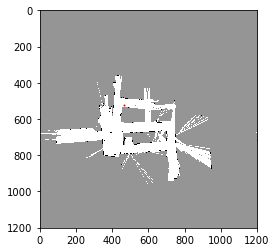

i: 23350
c_array
(100,)
[-247. -428. -291. -334.  -74. -166. -485. -474. -403. -388. -235.  -65.
 -498. -412. -454. -345. -424. -480. -423. -429. -312. -246. -437. -472.
 -500. -362. -558. -169. -500.  185. -201. -425. -164. -182. -585. -493.
 -528. -346. -161. -337. -570. -308. -551.  -18. -180. -356. -303. -428.
 -240. -407.  232. -129. -310. -378.  536. -551. -213.   77. -325. -436.
 -525. -435. -197. -505. -201. -437. -262. -286. -298.  -91. -384. -318.
 -230.  -34. -235. -367.   23. -336. -204. -198. -282. -175. -162. -182.
 -163. -394. -131. -267. -585. -523.   14. -386. -262. -590.  -97. -262.
 -331. -453.  -55. -268.]
np.max(c_array)
536.0
xy_w_scan shape
(2, 1033)
*****Updating map*****
particle states
[-3.94115819 -6.6827096  -4.75461776]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.20327817e-265   1.33436212e-305   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   9.75026403e-262
   0.

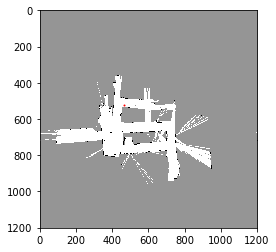

i: 23400
c_array
(100,)
[ 252. -470.  -30. -462.  348. -457.  505. -152. -249. -471.  514. -458.
 -459. -311.  397. -258. -455. -449.  146. -447. -230. -142. -479.  431.
  379. -483. -455. -471. -516. -454. -449. -300. -451.  375.  419.  -42.
  375.  193.  368.  139.  294. -498.  220. -517.  327. -361. -431. -407.
  470. -392.  497.  305. -457.  497. -478. -468. -461. -402.  233. -464.
 -277. -447.  203.  379.  253.   47. -283.  478. -185.  342. -466. -398.
 -400. -336.  -16.   22. -459. -451. -517. -450. -324. -484. -438. -477.
  373.  294.  490.   19. -455. -519.  105.  388.  297.  467.   47.  523.
 -343. -163. -309. -499.]
np.max(c_array)
523.0
xy_w_scan shape
(2, 1014)
*****Updating map*****
particle states
[-3.91969481 -6.52066788 -4.59903026]
particle weights
[  2.02367984e-118   0.00000000e+000   6.84065847e-241   0.00000000e+000
   9.96350326e-077   0.00000000e+000   1.52281002e-008   7.09857403e-294
   0.00000000e+000   0.00000000e+000   1.23394574e-004   0.00000000e+000
   0.

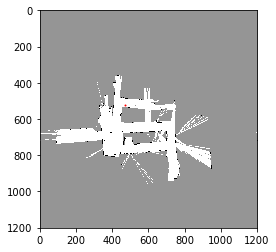

i: 23450
c_array
(100,)
[ 405. -181.  -88. -470. -465. -469. -461.  397.  554.  180. -211.  446.
  316. -549.  344. -131.  439.  540. -458. -430.  455. -429.  238. -463.
   43. -480.   45.  374.  368. -423. -132. -280. -537. -504. -226. -435.
  347. -526. -461. -101.   33. -463. -462. -546. -301.  308.  341. -507.
 -466. -109. -490. -435. -423. -204. -489.  335.  538. -208. -463.  -40.
 -128. -466. -491. -263. -536. -481. -462. -296.  119. -467.   82. -462.
 -344.  189. -466. -487.  321. -523. -314.  516.  -36.   78.  100.  441.
 -489. -399.   41. -449.  477. -311. -472. -468. -418.  246.  123. -486.
 -437. -351. -425. -171.]
np.max(c_array)
554.0
xy_w_scan shape
(2, 1025)
*****Updating map*****
particle states
[-4.01165005 -6.44508805 -4.54064808]
particle weights
[  1.95039146e-065   6.22522714e-320   1.52384996e-279   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.54283444e-069
   9.99999056e-001   3.74855043e-163   0.00000000e+000   1.24794528e-047
   4.

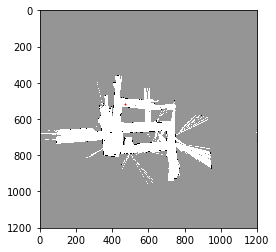

i: 23500
c_array
(100,)
[ 280. -373. -128. -536. -524. -345. -288. -131. -506. -504.   20. -523.
 -507. -247.  -91. -557.   26. -548. -527. -101. -117. -504. -516. -120.
 -466. -507.  -99. -509. -517.  -93. -510. -511.  310. -533.  320.  305.
 -135. -507. -503. -326. -522. -522. -533.  266. -101. -378. -541. -523.
  321.  374.   14.  263. -550. -477. -383.  -16. -144. -245. -515. -507.
  218. -498. -498.   27. -468. -536. -418. -529. -208. -440. -298. -284.
 -563. -515. -145. -326. -557.  381. -511. -532. -498. -393. -545. -497.
  -96. -389. -333. -536. -497. -521.  366. -539. -523.  365. -219. -507.
 -502. -508. -306. -525.]
np.max(c_array)
381.0
xy_w_scan shape
(2, 1037)
*****Updating map*****
particle states
[-4.06947705 -6.23635601 -4.61484532]
particle weights
[  1.36729209e-044   0.00000000e+000   8.78441176e-222   0.00000000e+000
   0.00000000e+000   5.03280306e-316   2.86151206e-291   4.37350109e-223
   0.00000000e+000   0.00000000e+000   1.65689889e-157   0.00000000e+000
   0.

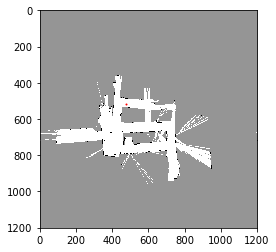

i: 23550
c_array
(100,)
[-424. -473.  270. -314. -532. -507. -436.  106.  161.  111.  294. -526.
  188. -535. -524.   35. -252. -454. -543. -527. -544. -549. -524. -487.
 -533.   70. -623. -528.  303.   70. -552. -325. -522.  306.  277. -402.
  -17. -424. -576. -529. -553.    8. -533.  -43.  188. -491.  285.  253.
  -62.  176. -123.  315.  175. -257. -466. -541.  241.  335. -513.  299.
 -479.   23. -550.  130. -538. -151.  217. -566. -491. -546. -542. -522.
 -507. -478.  339.    0. -477. -103. -542. -510. -421. -546. -526. -531.
 -519. -127. -494. -484. -395.  -98.  337.  -36. -535.  298.  244. -131.
 -140. -145.  318. -459.]
np.max(c_array)
339.0
xy_w_scan shape
(2, 1059)
*****Updating map*****
particle states
[-4.04985791 -6.188458   -4.59503728]
particle weights
[  0.00000000e+000   0.00000000e+000   9.36712533e-031   2.20611882e-284
   0.00000000e+000   0.00000000e+000   0.00000000e+000   5.58870645e-102
   4.30038960e-078   8.29437580e-100   2.48126927e-020   0.00000000e+000
   2.

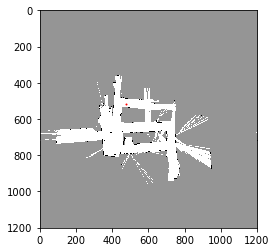

i: 23600
c_array
(100,)
[-198. -575.  279.  302.  358. -543. -549. -172. -602. -546. -484. -329.
   64. -535.  450. -404. -549.  256. -575.  277.  303.  -98.  277. -531.
  104. -406.  334.  323. -528.  328. -555.  223. -481. -124.  314. -558.
 -528. -511.   91. -548. -530. -556.  155. -539.  315.  322.  266. -522.
  276. -405.  165.   64. -497. -549. -450.  423. -560. -547. -558. -574.
  437.  387.  430. -514. -504. -514.  107. -555.  385. -222.  196.  -60.
 -497. -586. -548.   56.  297.    6.  252. -557.  444. -462. -478.  396.
  373. -405. -545. -229. -519.  177.  224.  292. -427. -556. -363. -555.
  -66. -334. -179.   -9.]
np.max(c_array)
450.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[-4.03680358 -6.01530131 -4.58919045]
particle weights
[  3.76790175e-282   0.00000000e+000   5.42709518e-075   5.28859758e-065
   1.10619453e-040   0.00000000e+000   0.00000000e+000   7.37489939e-271
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.

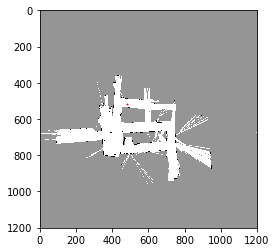

i: 23650
c_array
(100,)
[ 473.  363. -576. -176. -343. -545. -378. -391. -550.  204.  351. -474.
 -548. -564.  441. -379. -538. -487. -588. -348. -533. -492.  316. -417.
 -322.    2. -542. -481.  462.  470.  368.  179.  463.  459. -190.  157.
 -514.   44.   60. -495. -549. -510. -538.  187.  450. -544. -582. -313.
  129. -507.  -20. -258.  415.  456. -548. -516.  321. -548. -542. -558.
 -257. -121. -209. -561. -215. -545. -487.  364. -539.  435.  151. -557.
 -549.  474. -337.  163. -540. -483. -489. -375.  444.  441. -179. -512.
 -461. -540. -578.  -22.  296. -537.  -90.  468.  139.  385. -557. -499.
 -570. -523. -552.  470.]
np.max(c_array)
474.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.10428129 -6.20115731 -4.63062265]
particle weights
[  2.61461362e-001   4.41585201e-049   0.00000000e+000   3.63319547e-283
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.91013622e-118   2.71319325e-054   0.00000000e+000
   0.

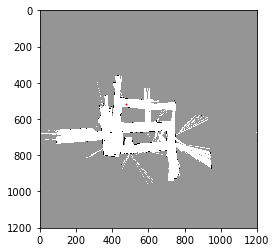

i: 23700
c_array
(100,)
[-562. -478. -525. -107. -538. -559. -557. -421. -282. -445. -368. -560.
 -206. -549. -130. -518. -554. -550. -502. -149. -435. -185. -557. -414.
 -143. -131. -317. -483. -207.  -85. -557. -287. -459. -337. -212. -501.
 -105. -473. -266. -291. -212. -433. -532. -244. -548. -221. -425. -242.
 -529. -282. -501. -237. -484. -320. -288. -520. -170. -530. -526.  -56.
 -302. -253. -491. -133. -556. -176. -541. -182. -553. -250. -610. -228.
 -377. -284. -262. -278. -468. -325. -548. -550. -477. -449. -155.   12.
 -540. -453. -550. -316. -133. -383. -439. -556. -438. -535. -326. -538.
 -265. -501. -467. -346.]
np.max(c_array)
12.0
xy_w_scan shape
(2, 1023)
*****Updating map*****
particle states
[-4.18663749 -5.86055906 -4.5343762 ]
particle weights
[  5.18761082e-250   1.56929239e-213   6.07943498e-234   2.08428284e-052
   1.37415257e-239   1.04195949e-248   7.69909710e-248   8.92255710e-189
   2.07693220e-128   3.36838535e-199   9.29173632e-166   3.83315474e-249
   2.1

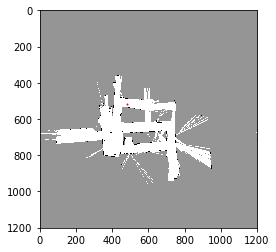

i: 23750
c_array
(100,)
[-531.  259.  -61.  122. -479. -410. -381.   85.  385.   46. -545.   91.
 -584.   74. -411. -587. -456.  275. -536. -612. -179. -218. -531.  166.
 -400. -620.  135. -559. -305. -377. -552. -496.  -23. -281.  378.   55.
  315. -552.  116. -495. -529.  116. -169. -554. -220. -519. -141.  252.
   75. -501.  198. -547. -385. -621. -525. -502. -579. -176. -547. -186.
 -152. -527.  172. -561. -619.  -77. -604. -531.   47. -616. -593. -568.
   56. -123. -301.   89.  120. -525. -187. -300. -319.  153. -366. -301.
 -439.  -20. -538. -165. -198.  280. -319. -517.   85. -125. -525.  265.
   87. -514. -162. -164.]
np.max(c_array)
385.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[-4.22821451 -5.90909261 -4.50098159]
particle weights
[  0.00000000e+000   1.89888837e-055   2.01495442e-194   6.02775254e-115
   0.00000000e+000   0.00000000e+000   0.00000000e+000   5.14350995e-131
   9.99088949e-001   5.93984059e-148   0.00000000e+000   2.07504001e-128
   0.

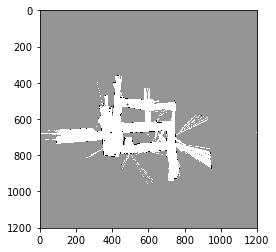

i: 23800
c_array
(100,)
[ 110. -589. -313.  290. -241.  -63. -274. -525. -585. -562. -585.   94.
 -488.  349.  392.  -65. -269. -592.  -33. -539. -540. -438. -444.  323.
 -576. -423. -186. -428. -579. -278. -484. -524. -233. -306. -438.  187.
  198.   11. -248.  331. -522. -280. -575. -271.  255. -559. -579. -247.
  -65. -221. -566.   93. -482.   28.  104.  106. -584. -584. -563.  254.
   95.  174. -280. -580.  360.  413.  -96. -289. -524. -262.  244. -454.
 -445. -248.  377.  193.  457. -263. -171. -567.  294. -348. -476. -437.
   83. -292.  -13.  376. -437. -304.  367. -235. -361. -456. -423. -437.
 -572. -582. -569.  454.]
np.max(c_array)
457.0
xy_w_scan shape
(2, 1069)
*****Updating map*****
particle states
[-4.21579219 -5.92373746 -4.64284919]
particle weights
[  1.89982484e-151   0.00000000e+000   0.00000000e+000   2.82956910e-073
   6.93985526e-304   1.39884048e-226   3.23325452e-318   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.13797120e-158
   0.

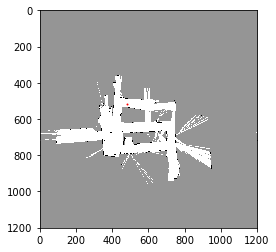

i: 23850
c_array
(100,)
[ 455.   45. -542. -555.  309.  430. -371.  126. -517.  356.  -85.   29.
  430.  319. -554.  422.  424. -463.   67.  405. -108.   99. -367. -545.
  416.  322. -113. -515.   -2. -551. -553.  -26. -268.   25. -542.  -31.
  230. -170.  417.  -26. -540. -529.  424. -352. -542. -257. -208.  449.
  404.  173. -404.  165.  347.  231.  379. -534. -534. -519. -547. -190.
  352.  280.  435.  -58.   64. -493. -463.  143.  261. -510.   49. -324.
 -551.  369. -125. -549.  427. -544.  350. -458.  453. -501.  456.  222.
  456.   96.  296. -344.  -95. -516. -541.  410. -531. -225.  -62. -546.
  349. -501.  293.  332.]
np.max(c_array)
456.0
xy_w_scan shape
(2, 1050)
*****Updating map*****
particle states
[-4.19265963 -5.79050178 -4.73118751]
particle weights
[  1.52105651e-001   1.32253681e-179   0.00000000e+000   0.00000000e+000
   5.95869274e-065   2.11243474e-012   0.00000000e+000   1.99186914e-144
   0.00000000e+000   1.53812504e-044   4.60389194e-236   1.48831911e-186
   2.

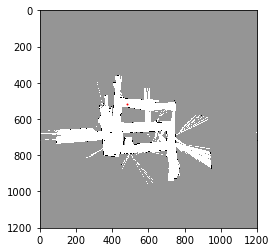

i: 23900
c_array
(100,)
[-519. -522.   11.  351.  294. -447. -107.  314.   39. -522. -510.  440.
    8.  127. -519. -448. -398. -461. -524.  332. -524.   17. -528.  -35.
  408.   21. -522. -522. -313.  236. -525.    8. -521. -204. -523.  437.
 -465.   73. -530. -192. -522.  115. -510. -523.   42. -523. -455. -566.
 -321.  434. -529.  459. -521.  212. -522. -522.  430.  423. -523.  299.
  434.   63.  441.  481. -459. -308.  423. -522. -524.   77.  311. -272.
 -505. -526. -364.   54.  -63. -536.  477. -522. -249.  468. -523. -331.
  470.  -78.  410.  485.  497.  -29. -530.   82. -482. -514. -536.  477.
  465.   33.  365.   90.]
np.max(c_array)
497.0
xy_w_scan shape
(2, 1037)
*****Updating map*****
particle states
[-4.25540541 -5.70005728 -4.79912204]
particle weights
[  0.00000000e+000   0.00000000e+000   8.56799247e-212   3.91744514e-064
   6.88997196e-089   0.00000000e+000   4.85434023e-263   3.34277459e-080
   1.23915196e-199   0.00000000e+000   0.00000000e+000   1.75878119e-025
   4.

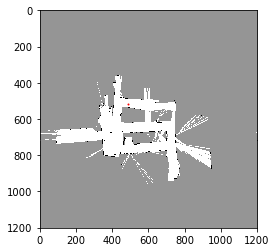

i: 23950
c_array
(100,)
[ 475.   57.  350.  304. -541. -185.  441. -435. -556. -548.  373. -102.
 -545. -547. -540. -537. -186.   26. -298. -531. -494.  478. -464.   33.
 -530. -390. -262. -514. -527. -547.  409. -547. -571. -298.  248. -120.
   38. -296. -127. -244. -555.  189.   12. -537.  396.  334. -531. -219.
 -553. -547. -102. -517.  404. -547. -551. -498.  517. -311.  502. -543.
  351. -454.  412. -120. -520. -539.  401.  381.  -91.  478.  199.  489.
  267.   98. -543. -467. -594. -524. -106. -393. -510.  480.  485. -544.
  270. -550. -545. -441.  450.  172. -437.  -82. -229.  447. -542.  165.
  442.  490. -533. -526.]
np.max(c_array)
517.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[-4.29157445 -5.94179394 -4.8553797 ]
particle weights
[  5.74952051e-019   1.67701981e-200   2.97044414e-073   3.12806106e-093
   0.00000000e+000   1.33436171e-305   9.85415167e-034   0.00000000e+000
   0.00000000e+000   0.00000000e+000   2.89463943e-063   1.48496278e-269
   0.

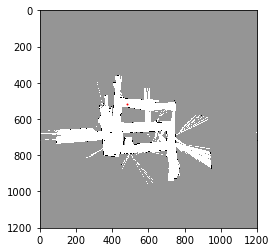

i: 24000
c_array
(100,)
[-417. -187.  436. -470.  475.  231.   18.  117.  407.  390.  -97.  478.
  305.  458.   26. -298.  436. -117.  473. -467. -579. -525. -545.  475.
  -41. -535.  377.   76.  237. -302. -529.  313. -404. -582.  -71. -165.
  130.  126. -585. -571.   32. -413.  -42.  467. -210.  486.  -51. -594.
 -581. -513. -591. -259.  263.  459. -555. -523.  -57. -357.  450. -590.
  -65. -259. -528.  345. -606. -532. -554.  -83. -471. -521.   27. -526.
 -507.  401.   37. -598.  478.  223. -199. -191.   18. -528.   -7. -537.
   15. -500.  399.  340.  413.  277. -581. -172. -529. -277. -589.  423.
 -294.    6. -518.  474.]
np.max(c_array)
486.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[-4.24122764 -5.80543491 -4.8910276 ]
particle weights
[  0.00000000e+000   5.24208732e-293   1.92737613e-022   0.00000000e+000
   1.66898053e-005   1.79720528e-111   5.62176958e-204   5.55938498e-161
   4.90260046e-035   2.02964606e-042   6.39746063e-254   3.35223701e-004
   2.

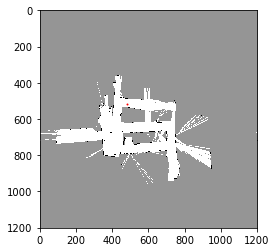

i: 24050
c_array
(100,)
[ 527. -535. -464.  451.  410. -501.   26.  461.  468. -275.  -70.    9.
 -554. -527. -129. -531. -478. -422. -565.  490.  560.  531.  -71. -399.
 -287.  466. -143.   72.   33. -547. -574. -484.  108.  500.  431. -395.
  370. -490. -483.  -96.  355. -246.  506.   58. -301.  -29. -539. -117.
  168.  554.    6.  300.  303.  282.  -20. -487. -477.  525. -529.  320.
 -486. -484. -469.   -3. -364. -215. -306.  387.  492.  -90. -494. -474.
   97.  472. -522.  105.   -8. -483. -564. -536. -568. -583.   -4.  239.
 -335. -476.  257. -484.  552.  334. -392.  323. -497.  355. -571. -124.
 -565. -182.  472. -478.]
np.max(c_array)
560.0
xy_w_scan shape
(2, 1047)
*****Updating map*****
particle states
[-4.19833277 -5.65733033 -4.97656099]
particle weights
[  4.64581183e-015   0.00000000e+000   0.00000000e+000   4.57805484e-048
   7.15496038e-066   0.00000000e+000   1.21766040e-232   1.00838368e-043
   1.10582698e-040   0.00000000e+000   2.47318110e-274   5.04103822e-240
   0.

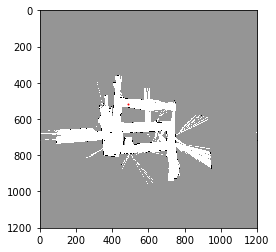

i: 24100
c_array
(100,)
[-540. -498. -371. -572.  110. -482.  136.  379. -501.  470.  -97.  525.
 -490. -601. -613.   18. -202.  504.  530. -108. -506.  340. -461.  354.
  -28. -376. -544.   -6.  -31. -612. -588. -613.  282.  -55. -395.  -18.
   18.  477.  510.   22. -606. -480. -373.  111.  366. -370. -412. -499.
  -17.   16.    6. -495. -528.   71.  116.  -66.  -64. -486. -434.  -54.
  511.  468.  366.  145.  452.   72. -526. -580.  456. -495.  492.  451.
  382.  513.  492. -432.   21.  402. -482. -505. -535.  -44.   -9. -612.
  524. -484. -601. -497.  -79.  156. -493. -572.  453. -597. -483. -501.
 -416. -579.  -69. -595.]
np.max(c_array)
530.0
xy_w_scan shape
(2, 1080)
*****Updating map*****
particle states
[-4.18569113 -5.55435489 -5.01785584]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.91140829e-183   0.00000000e+000   7.65578416e-172   2.61546422e-066
   0.00000000e+000   8.67654127e-027   4.93600280e-273   6.67641219e-003
   0.

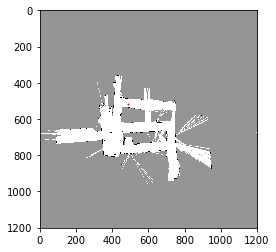

i: 24150
c_array
(100,)
[ 328. -448. -536.  525. -569. -466. -451. -453. -180.  545. -574. -279.
 -113.  457.  429. -569. -330.  533. -451. -343. -138. -570. -559. -495.
  433. -329. -450.   27. -166. -478.  508. -453.  508.  367. -459.  -22.
 -569. -570. -457.  337. -449. -261.  389. -569.  529.  129. -460. -571.
  384.  518.  -60. -282.  -87.  475. -568.  509. -571. -424. -569.  449.
 -458.  484. -451. -466.  283.  397. -208. -572.  425.  -58.  423.  520.
 -519.  508. -569.  527.   10. -456. -449.  518. -449. -242.  513. -457.
  -42. -345. -567. -456. -452.  508.  -92.  462.  493.  471. -569. -405.
 -185.  -49.  221. -455.]
np.max(c_array)
545.0
xy_w_scan shape
(2, 1014)
*****Updating map*****
particle states
[-4.2790098  -5.50782417 -5.05822915]
particle weights
[  5.72920948e-095   0.00000000e+000   0.00000000e+000   2.06114069e-009
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.36929780e-315   9.99993726e-001   0.00000000e+000   0.00000000e+000
   1.

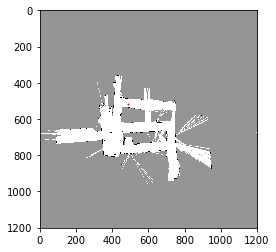

i: 24200
c_array
(100,)
[-217.  -71.  -80. -185.  -28. -505. -194. -609. -609. -230. -597. -241.
 -472. -524.    1. -507. -561. -285.  127. -491. -112. -589. -387.  -15.
  534. -574.  -85. -379. -472.   96.  335. -496. -238. -393.   59. -599.
 -591. -534.    9. -211. -468. -576. -155.  130. -253.  270.    2. -311.
 -253. -589. -319.  331.  416.  -38. -459. -574. -475. -464. -330.  211.
 -244. -346. -297. -468. -480. -609. -478. -133.  506. -603.   24. -599.
    1. -234. -155. -291. -444.  181. -387. -289. -219.  157.  -22. -302.
 -323.  -96. -291. -474. -379. -593. -463. -169. -107. -543. -490. -330.
  -79. -227. -536.   23.]
np.max(c_array)
534.0
xy_w_scan shape
(2, 1064)
*****Updating map*****
particle states
[-4.10608152 -5.42701887 -4.97638963]
particle weights
[  0.00000000e+000   1.78582315e-263   2.20388085e-267   5.52417606e-313
   8.44308517e-245   0.00000000e+000   6.81736481e-317   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

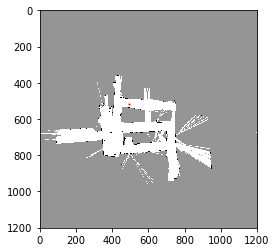

i: 24250
c_array
(100,)
[-573. -492.  206. -522. -524. -479. -509. -106.  -10. -526. -421.  498.
  327. -525.  441.  -37. -514.  266.  491. -519.  316.  155. -490.  442.
  343. -523.   99. -447.  437. -570.  473. -513. -355.  447. -490.  492.
  327. -512.  333. -243. -497.  508.  117. -501.  399. -574. -568. -368.
 -325. -579. -496. -509. -357.   37. -502.  410. -547.  441.    9.  433.
 -499. -590. -300. -526.  464. -525. -513.   -1. -524. -402.  -51.  -59.
    5.  499. -491. -493. -559.  456.   40. -522. -513. -578.  307. -524.
  264. -572.  464.  477.   40.  407. -511. -501. -522.  -59. -486. -494.
 -473. -524.  415. -515.]
np.max(c_array)
508.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[-4.18191978 -5.81298047 -4.90510917]
particle weights
[  0.00000000e+000   0.00000000e+000   6.96615433e-132   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.20350854e-267
   1.08488824e-225   0.00000000e+000   0.00000000e+000   4.53922601e-005
   2.

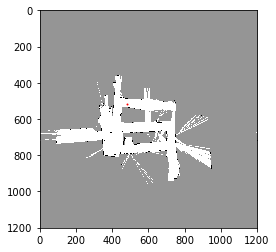

i: 24300
c_array
(100,)
[-508.  372. -535. -366.  492. -512. -515. -492. -338. -566.  507.  437.
 -118. -504.  221. -426. -496. -506.  510.   57. -526. -516. -518. -350.
 -387.   26.   77.  506.  451. -318. -291. -454.  -18. -510.  173. -366.
 -511. -529. -512.  450.  425. -124.   57.  467.  260.   48. -227.  376.
 -387.  257.   -4. -498. -232. -572.  446. -192. -509. -382. -503. -470.
 -500. -511.  229. -524. -528. -557. -520. -512.  463. -486. -508.   25.
  180.  473. -517.   55.  226.  384. -109.  465. -583.  446.  505. -226.
  495. -155. -265. -375. -502. -529. -570. -478. -514. -517.  144. -244.
  463.  -40. -515. -555.]
np.max(c_array)
510.0
xy_w_scan shape
(2, 1068)
*****Updating map*****
particle states
[-4.20047298 -5.81103458 -4.88487625]
particle weights
[  0.00000000e+000   1.08646886e-060   0.00000000e+000   0.00000000e+000
   1.41695191e-008   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   4.63204041e-002   1.84144438e-032
   1.

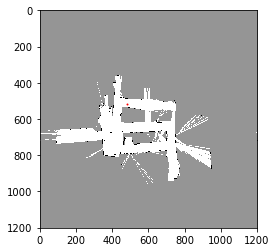

i: 24350
c_array
(100,)
[-269. -538.  236. -409. -521.  189. -368. -147.  -84.  449.  472.  480.
   77. -501. -536.   66. -439.  257. -515. -454.  406. -511.  412.   27.
 -411. -505. -578. -398. -432. -584. -497.  403. -530.  280.  400. -431.
 -478. -331. -395.   90.  191.  -20.  412. -500. -537. -542. -218.  380.
 -517. -540. -506. -175.  228.  -99. -509. -405. -247. -587. -516.  231.
 -535.  -91. -561.  465.  -17.  491. -182. -519. -494. -160. -507. -294.
  492. -182.   -3.  377.  403. -321. -211.  -87. -518. -496. -175.  192.
  255. -496. -533. -429.  124.  -64. -384. -136. -202. -139. -568. -575.
 -553.   62.  354.  201.]
np.max(c_array)
492.0
xy_w_scan shape
(2, 1076)
*****Updating map*****
particle states
[-4.16174003 -5.68844385 -4.8610741 ]
particle weights
[  0.00000000e+000   0.00000000e+000   4.83685267e-112   0.00000000e+000
   0.00000000e+000   1.87379558e-132   0.00000000e+000   2.23756825e-278
   5.13249636e-251   1.54627774e-019   1.50681727e-009   4.49175897e-006
   4.

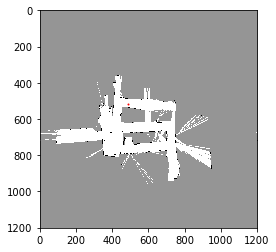

i: 24400
c_array
(100,)
[-124. -520.   17. -224.  218. -498. -520.  271. -529.  304. -544. -281.
  381.  136. -506. -146. -525.  430.  432.  360. -258.  -87. -548.  440.
  225. -474. -296.  354.  445. -566.  149.  432. -300. -416.  125.  403.
   10. -139. -472. -500. -485.  372. -452. -502.  421. -263. -390. -293.
 -359. -500.  438.  504. -285. -510.  166.  464. -123.  -59.  266. -537.
 -230. -191.  -31.  438.  -62. -150. -382. -496. -557. -520. -505.   89.
 -151. -496. -520. -214. -534.  255.  470. -528. -478.   10. -110. -506.
  491. -509.  408. -534. -149. -236.  181.    4.  310.  372. -520. -175.
  -81. -503. -525.  100.]
np.max(c_array)
504.0
xy_w_scan shape
(2, 1041)
*****Updating map*****
particle states
[-4.11737638 -5.55964798 -4.81592202]
particle weights
[  1.83258608e-273   0.00000000e+000   3.15200089e-212   6.81734950e-317
   6.19123365e-125   0.00000000e+000   0.00000000e+000   6.44740178e-102
   0.00000000e+000   1.38389340e-087   0.00000000e+000   0.00000000e+000
   3.

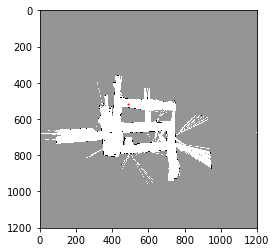

i: 24450
c_array
(100,)
[-310. -278.  380. -521.  -36.  416. -460.  397. -347. -535.  264. -205.
  304. -526.  461. -450. -181. -114. -550. -591.   77.  -91.  108. -274.
  351.  270. -553. -572.  369.  222.  184. -524. -201.  332. -339. -372.
  218. -525. -326. -550.  354. -306. -391.  380. -540.  -21.  445.  435.
  259.  280.   56. -527. -533. -230. -555. -451.  -81.  -84. -475. -124.
 -548. -525.  411. -535. -221. -513. -564. -186.  283. -327. -189.  449.
  297.  229. -195. -551.  239. -514. -532. -520.  482. -539.  154. -515.
 -503.  290. -236. -290. -541. -287. -558. -505. -518.   99. -474.  409.
 -449. -533.  448. -189.]
np.max(c_array)
482.0
xy_w_scan shape
(2, 1077)
*****Updating map*****
particle states
[-4.1222784  -5.39262534 -4.79109549]
particle weights
[  0.00000000e+000   0.00000000e+000   5.03457535e-045   0.00000000e+000
   1.08507154e-225   2.17052201e-029   0.00000000e+000   1.21609930e-037
   0.00000000e+000   0.00000000e+000   2.10767161e-095   4.36205294e-299
   4.

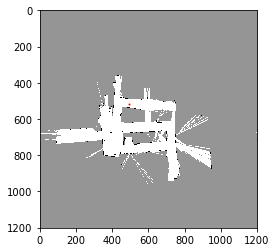

i: 24500
c_array
(100,)
[-162.   86. -548.   24.  336.  362. -532.  313.  352. -416. -547.  -80.
  190. -492. -579.  -67. -545.   16. -438.   58. -550. -560. -134. -433.
  156.  405. -583.  359.  432.  144.    5.  107. -564. -557.  337.  303.
  369.  332.   66.  313. -361.  400. -383.  136.  328.  324. -391.  304.
  -66. -568. -565. -555.   -6.  291.  -24. -570.  338. -549.  168. -121.
  287. -564.  332.  -19.  337.  -79.  278. -537. -460. -578.  -35. -555.
 -516.  258. -555. -569. -444. -542. -374. -562. -506. -271. -557. -328.
  319.  217.  102.   81.  -15.  215. -532.  320. -530.  -20. -534. -540.
  318. -527. -347. -458.]
np.max(c_array)
432.0
xy_w_scan shape
(2, 1079)
*****Updating map*****
particle states
[-4.16689791 -5.28775325 -4.67021709]
particle weights
[  1.06924628e-258   5.42137266e-151   0.00000000e+000   6.42467826e-178
   2.03109266e-042   3.97544974e-031   0.00000000e+000   2.08428284e-052
   1.80485139e-035   0.00000000e+000   0.00000000e+000   4.37749104e-223
   7.

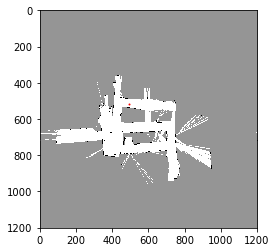

i: 24550
c_array
(100,)
[-359.  -99. -504.  325. -550.  -45. -498.  362.  -45.  397. -568. -547.
 -117.  312. -551. -503. -470. -561. -568.   -4. -542.   -7. -242.   68.
 -577. -548. -523. -153.   -8. -138. -510. -558.  322. -573. -572. -568.
  222.   -2. -564. -122. -507. -436. -446.  323. -375.  147.   92. -576.
 -553. -563. -552. -561.  415. -564.  329.   75.  423. -552.  115. -556.
 -557.  323.  -16. -186.  362. -558.  -38.  133.  349.  -31. -577.  389.
  260.  333.   25. -477. -559.   58.    1. -435. -404.  162. -575.  120.
 -514.  -68.  366. -454.  320.   54.   97. -590. -570. -583. -551.  264.
 -559.   94. -120. -562.]
np.max(c_array)
423.0
xy_w_scan shape
(2, 1060)
*****Updating map*****
particle states
[-4.21749622 -5.14599304 -4.66209163]
particle weights
[  0.00000000e+000   1.98671139e-227   0.00000000e+000   2.74786320e-043
   0.00000000e+000   5.62388983e-204   0.00000000e+000   3.22026001e-027
   5.62388983e-204   5.10737569e-012   0.00000000e+000   0.00000000e+000
   3.

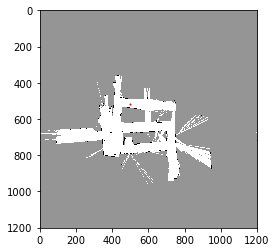

i: 24600
c_array
(100,)
[-552.  -97.  283. -579.   51.  265.  110. -536. -409. -416. -438. -288.
  234. -565. -543.  406.  225.  -55.  280. -519.  147.  137.  294.  278.
  -79.   75. -578. -466.  -77. -545.  193.  -40.  -50. -560. -579.   73.
  -13.   69.  383.  -41. -573. -383.  270.  -40. -564. -573. -296. -552.
  240. -581.  -38.  350.  270.  -47.  161. -584.  152. -566. -567. -537.
  125. -459.  299. -541.   83. -571. -599. -362.   42. -503.  287.  312.
 -552.  345.  320.   56. -433.   46. -558.   53. -398. -507.  -52.  242.
 -498.  -96. -572.  178. -420.  290.  374. -520. -545.  -57. -505.  -36.
  254.  271. -183. -575.]
np.max(c_array)
406.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-4.17461855 -5.00690933 -4.65469488]
particle weights
[  0.00000000e+000   3.54711773e-219   3.81749719e-054   0.00000000e+000
   6.69050538e-155   5.81404049e-062   2.81082208e-129   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.97767741e-302
   2.

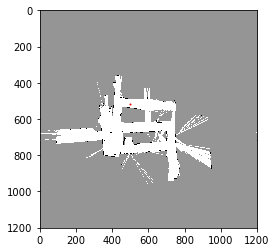

i: 24650
c_array
(100,)
[-590.  264.  140. -586. -586. -595.   83. -591. -169.  -15. -563.  289.
 -584. -198. -587. -581. -550. -586. -598.  356. -594. -564.  262.  253.
 -604. -464. -574.  290. -585. -590.  282. -602. -242. -304. -314.  251.
 -463. -262. -471.  321. -115. -577. -557.  295. -594. -598.  -60.   -4.
  103. -405. -192.  363.  -28.  324. -599.  300. -253.  -12.  234. -533.
 -577.  365. -380. -579. -582.  274. -589.   -6.  333. -436. -287. -579.
 -391.  293.   32.  286. -600.  222. -584. -569. -588. -525. -577.  105.
  392. -575.  311.   71. -597.  148. -523.   33. -402.   43.  327. -544.
 -499.  254.  295. -564.]
np.max(c_array)
392.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.16361476 -4.83415245 -4.681639  ]
particle weights
[  0.00000000e+000   2.57220937e-056   3.61235614e-110   0.00000000e+000
   0.00000000e+000   0.00000000e+000   6.35338381e-135   0.00000000e+000
   2.29506850e-244   1.74640862e-177   0.00000000e+000   1.85211677e-045
   0.

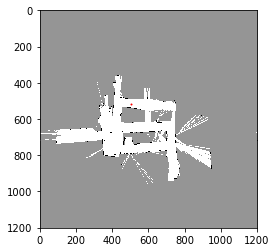

i: 24700
c_array
(100,)
[-416. -147. -540. -508.   59. -243. -183. -564. -545. -546. -507.  332.
 -525. -158.   63. -548. -467.  397. -129. -539.  330. -433.  394. -317.
 -562. -344. -227. -195. -555. -343. -173. -465. -331.  161.   62.  -16.
  218.  354. -567. -264.   83. -497.  -57. -422. -549.   34. -568.  314.
  329.   18. -488. -561. -568.   78. -563. -418.  -53. -409.  193.  329.
 -419. -489.  392. -158.  314. -346. -566. -544. -382.  334.  320.  314.
 -554. -150.  419.   26. -542. -139.  401. -541. -554.  348. -486.  373.
  -23.  -43.  -24. -560. -543. -566. -540. -438.  -14. -330.  312.  -12.
 -536.   91. -548.  307.]
np.max(c_array)
419.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.25369307 -5.40513605 -4.78316085]
particle weights
[  0.00000000e+000   1.54640497e-246   0.00000000e+000   0.00000000e+000
   4.50802700e-157   3.14089178e-288   3.58692163e-262   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.64581141e-038
   0.

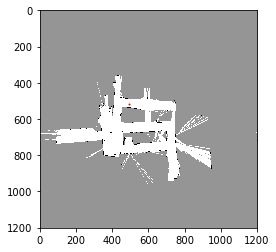

i: 24750
c_array
(100,)
[-493. -517.   95. -532.  417.  447.  -99.  415.  254. -257. -516. -150.
 -387.  394. -516. -613. -537.  444. -534. -525. -528. -368. -535.  394.
  452. -525.  282.  285.  328. -546. -527. -488.  165. -148.  124. -507.
  375. -524. -514. -486.  407.  228. -527.  177. -520. -511.  424. -530.
 -513. -543. -559.  285.  -44.  289.  312. -531.  440.  463.  415.  305.
 -107.  417. -372. -396.   -8. -516.  407. -134.   57. -533.  280. -116.
  425. -535. -545.  114. -540. -538.  417. -232. -540. -542. -436.   79.
  320.  435.  433.  220. -566.  366. -518. -528. -507.  -50. -578.  421.
  230. -499.  455. -424.]
np.max(c_array)
463.0
xy_w_scan shape
(2, 1066)
*****Updating map*****
particle states
[-4.31084655 -5.6474795  -4.86529165]
particle weights
[  0.00000000e+000   0.00000000e+000   1.51174205e-160   0.00000000e+000
   1.05269089e-020   1.12495544e-007   8.44011187e-245   1.42466220e-021
   1.70726255e-091   2.03151514e-313   0.00000000e+000   5.98865957e-267
   0.

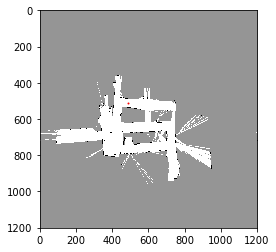

i: 24800
c_array
(100,)
[-322. -340.  460.  399. -518.   27. -322. -418.   65. -527.   75. -503.
 -128. -512. -451.  322.  356.  305.  420.  382. -412. -514. -521. -254.
   46. -576. -577.  285.  351. -265. -543. -510. -606. -519. -525. -535.
  120. -522.  272.  378. -558.  471. -371. -519.  379.  371. -582.  440.
 -462. -471.  193. -521. -591.  326. -508.  353.  378.  365. -514. -516.
 -419. -502. -264.   42. -516.  370.  355.  -96. -516.  384.  386. -633.
 -250.  -52.   43.  306. -530.  465.  109.  271.  202.  227. -519. -478.
  271. -151.  -42. -554. -262.  398. -578.  181.  125. -510.  390.  -65.
 -510.   58. -592. -513.]
np.max(c_array)
471.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.2523043  -5.55313433 -4.93524744]
particle weights
[  0.00000000e+000   0.00000000e+000   1.66601262e-005   5.36679357e-032
   0.00000000e+000   1.48650927e-193   0.00000000e+000   0.00000000e+000
   4.73541380e-177   0.00000000e+000   1.04304430e-172   0.00000000e+000
   7.

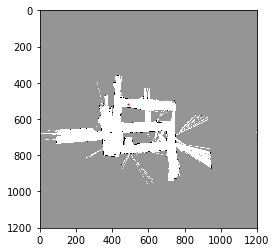

i: 24850
c_array
(100,)
[-536. -488. -531. -295.  369. -515. -522. -453.  346.  153.  355.  110.
  407.  287.   20.   30. -522. -657. -598. -511.  -92. -404.  343. -123.
 -210.  425.  271. -475.  350.  340.   54.  -35.  285. -512.  432. -524.
  270.   46.  341.  -58. -282. -507.  244. -500. -470. -240.   52. -608.
 -508.  403.  392.  430. -512.  354. -606. -491.   20.  235. -514.   94.
 -505. -109. -503. -366.   94.  264.  176. -499.  397.  465.  276. -519.
  343. -618.  -10.  319.  202.  351.  392. -270. -381.  283.  358. -129.
 -622. -451. -601. -414.  422. -504. -133. -352. -236.  -55. -463. -411.
 -497. -471. -636.  353.]
np.max(c_array)
465.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.18810285 -5.39320044 -4.96787816]
particle weights
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.03109266e-042   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.08428284e-052   3.16316354e-136   1.68891188e-048   6.69050538e-155
   6.

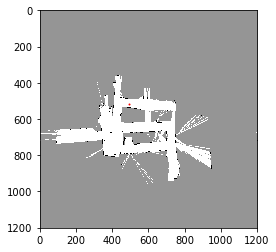

i: 24900
c_array
(100,)
[ 164.  -70. -511. -516. -189.  395.   85. -521.  241.  401.  112. -504.
  355.  367. -509.  174.  412. -586. -433.  416.  234.  344.  401.  346.
   27. -357. -147. -513.  430.  408.  189.  418.  -47.  460.  131. -345.
 -518. -310. -533. -511.    3.  435. -506.  451.  243.  167.  379.  170.
 -412.   65.   25.  436.   79.  383. -185. -507.  433.  254.  422.  381.
  363. -510.  -39.  118. -500. -462. -416.  441.  383.  -82.  372. -372.
  406.  409. -386.  198.  390.  466. -478. -356.  161.  372.  278. -372.
  406.  383. -521. -520.  171. -579. -526.  304.  253. -146. -247.  143.
  166. -412.   -7.  269.]
np.max(c_array)
466.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.17733772 -5.24878374 -4.936026  ]
particle weights
[  6.95010165e-132   1.64847510e-233   0.00000000e+000   0.00000000e+000
   3.43588836e-285   1.45886960e-031   3.40978571e-166   0.00000000e+000
   1.91719489e-098   5.88550005e-029   1.81417049e-154   0.00000000e+000
   6.

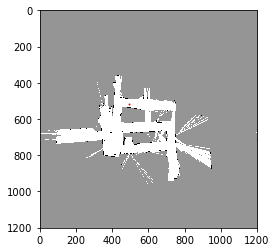

i: 24950
c_array
(100,)
[-564.   26. -280.  117. -539. -550.  385. -530. -251. -454. -498. -528.
 -376. -558. -556. -261. -486. -545. -229. -609.  101.  345.  -13. -513.
 -531. -532.  346. -110. -548. -529.  232. -509. -170. -394.  332.  -67.
  294. -239. -521. -543.  335. -530.   53. -405.  388.  274. -389. -527.
  -20.  152. -654.  -88.  -20.  -53. -531.  -69. -524. -559.  386. -397.
  -35. -489.  120.  364.   70. -529. -537.  364. -403. -112. -160.    8.
 -525. -548. -560.  -57. -535. -111. -532.  310. -470.  339.   19. -160.
  258. -210. -526. -270. -512.  -73.  336.  335. -312.  -27. -531.  349.
 -506.  332. -607.  377.]
np.max(c_array)
388.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.22194994 -5.38499269 -4.8026455 ]
particle weights
[  0.00000000e+000   5.14787795e-158   6.56926497e-291   1.70775708e-118
   0.00000000e+000   0.00000000e+000   4.20094741e-002   0.00000000e+000
   2.58259767e-278   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.

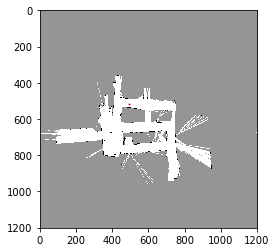

i: 25000
c_array
(100,)
[-540. -460. -115.  268. -247.  367. -394. -572. -495. -237.   55. -195.
  381. -341.  160. -593.  253.  194.  -86.  184. -138.   -8. -514. -556.
 -472. -569. -467. -561. -132.  -64.  311.  313. -562.  267. -495. -550.
  310. -556. -536. -523. -352.   38. -324.  259. -395. -546.  -51. -304.
  313.  -33.  111.  325. -522.   47.  -52. -562. -163. -558. -531.  371.
 -552. -432.  344.  318. -116. -556. -568. -537.  216.  -96.  308.  115.
 -531. -246.  267. -506.   54. -118.  107. -572. -563.  348. -549. -542.
 -534. -531. -251. -465.  -16. -541. -538.  361. -517.  377. -428. -348.
  373. -153.  -51.  280.]
np.max(c_array)
381.0
xy_w_scan shape
(2, 1071)
*****Updating map*****
particle states
[-4.24027506 -5.2463747  -4.76465503]
particle weights
[  0.00000000e+000   0.00000000e+000   3.81849130e-216   8.25426438e-050
   1.79895456e-273   8.16266707e-007   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.96246112e-269   2.58198509e-142   6.89180933e-251
   9.

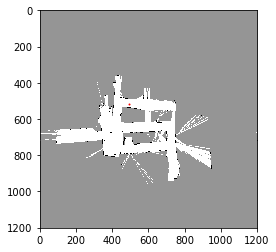

i: 25050
c_array
(100,)
[ 256.  307. -122.  254.   98. -556. -599.  -46.   20.  193.  124. -252.
  347.  210.  268.  354.  350. -374. -579. -544. -526.  352.  320.  159.
  355.  -45. -564. -565. -596.  -91.  264. -560.  -14.  -50. -530. -525.
 -515.  320. -595. -254. -580.  325.  159. -263. -566. -570.  102.  -32.
 -163. -553. -570. -591.  349.  310. -401.  153. -560. -349.  285. -588.
 -526. -561. -436. -370. -529.  348. -578.  374. -509.  333. -410.  160.
 -573. -547.  103. -531. -578.  255. -501.  345. -192. -338. -460. -552.
   11. -544. -537.  317. -538.  302.  294.  130.   -6. -569.   11. -205.
 -584.  101.  280. -565.]
np.max(c_array)
374.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.23497487 -5.15641532 -4.68755382]
particle weights
[  5.66566813e-052   7.98490418e-030   3.88988688e-216   7.66764801e-053
   1.36371303e-120   0.00000000e+000   0.00000000e+000   3.94745872e-183
   1.81866791e-154   2.47001034e-079   2.66919019e-109   1.35411118e-272
   1.

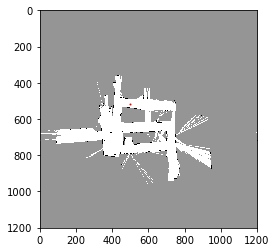

i: 25100
c_array
(100,)
[-510. -551.  115. -560.    3.  241. -216. -583.  210. -376. -297. -432.
 -507. -263.  229.  219. -387.  189.  106. -111.  252.   62.  171.  320.
   76. -510. -116.  -79.  207. -445.  301. -597.  185.  -69. -556. -231.
 -594. -605. -581.  186. -513.  206. -283. -534. -171.  196. -266.  209.
 -543. -306. -543. -531. -558.  305.   26. -588. -604. -540.  -97.  242.
 -543.  182. -587.  191. -546. -518. -183.  -37. -569.  -49.  231. -576.
 -573. -552. -550.  -49.  224.  141. -131. -131. -503.  220.  234.   98.
    9. -506. -370.  -43. -526.  295. -538. -595.  183.  219.  225.    9.
 -584. -513.   23. -188.]
np.max(c_array)
320.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.19970701 -4.97835376 -4.64637664]
particle weights
[  0.00000000e+000   0.00000000e+000   9.32461854e-090   0.00000000e+000
   2.13132216e-138   4.90609320e-035   1.65256125e-233   0.00000000e+000
   1.68891135e-048   5.38319932e-303   1.09724732e-268   0.00000000e+000
   0.

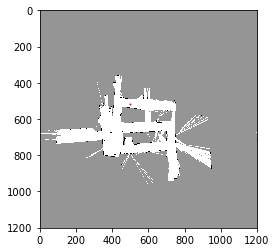

i: 25150
c_array
(100,)
[-615.  -92. -444.  213.  189. -575. -581.  260. -512. -611. -152. -619.
   23. -183. -467.  171. -458.  211. -580.  -12. -529.  257. -114.  217.
 -592.  166. -582.  281. -408.  227. -112. -564. -540.  120. -602.  220.
  -22. -625. -233. -566. -599. -541. -603. -579.  -71. -601.  201. -568.
  332.  156.  218.   55. -509.  -59.  225. -574.  129.  286.  191. -521.
  272. -177. -604.  215.  329. -577. -563.  243.   56.  -93.  -17. -322.
 -506. -483. -602. -603.  110. -593. -615.  160. -555. -559.  181. -542.
  313. -509. -117.  307. -278. -548.  129. -620. -403. -157.  243. -399.
   22.  -21. -595. -581.]
np.max(c_array)
332.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.25695495 -4.66027936 -4.59544469]
particle weights
[  0.00000000e+000   6.88713272e-185   0.00000000e+000   1.98543390e-052
   7.49528009e-063   0.00000000e+000   0.00000000e+000   5.12502611e-032
   0.00000000e+000   0.00000000e+000   6.03072518e-211   0.00000000e+000
   6.

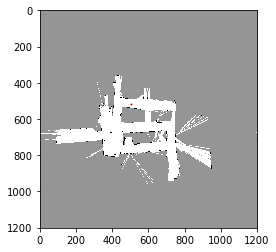

i: 25200
c_array
(100,)
[ -47.  -94.  -19. -484. -189. -353. -629. -401.  217. -630. -500.  197.
 -547. -470. -197.   73. -599. -615. -455. -414. -581. -166. -645. -620.
  150.    0. -199. -213. -190. -600. -165. -585. -242.  249. -438. -379.
 -401. -610.  -77.  226. -511. -148. -480. -110. -374. -581.  239. -206.
  136.  221. -490. -366. -298. -577. -505.  241.   24. -466. -491. -308.
 -264. -607.  153. -594. -471.  195. -596. -469. -252.  119. -585.  259.
  -82. -388.  212. -639. -474. -590. -106. -487. -463. -245.  -93.  188.
 -621.  -76. -636. -109. -495.  -99.  253. -293.  167. -161.   55. -433.
 -179. -496. -111. -588.]
np.max(c_array)
259.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.30957819 -4.51319804 -4.48964617]
particle weights
[  1.27289824e-133   4.93120476e-154   1.84093807e-121   0.00000000e+000
   2.72255872e-195   1.62435977e-266   0.00000000e+000   2.31497919e-287
   5.73504604e-019   0.00000000e+000   0.00000000e+000   1.18208109e-027
   0.

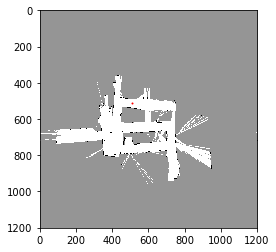

i: 25250
c_array
(100,)
[-132.  125. -521. -626. -467.   76. -215. -478. -487. -440. -245. -119.
 -288. -555. -564.   91.  220.  129.  130. -467.  132.  103. -507.   95.
 -470. -561. -211. -459. -601.  136.  254.  130.  167. -216. -559.  -43.
 -563.  158. -591. -397. -528.  141. -387. -122.  142. -578.  157.  116.
  133. -582. -587. -449. -602. -574. -219. -573. -587. -364. -556.  139.
  -98. -596. -571. -229.  -32.  181.   14. -563. -473. -574.   45. -558.
 -475. -478. -475. -613. -577.  125.  178. -251.  155. -128. -568.   18.
 -559. -226. -210.    6. -557. -634. -570. -561. -436. -615.   90.  -96.
   97. -593.  180.  120.]
np.max(c_array)
254.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.2963685  -4.38429487 -4.5296046 ]
particle weights
[  2.30319116e-168   9.46262947e-057   0.00000000e+000   0.00000000e+000
   7.47615931e-314   4.96114844e-078   2.06960749e-204   1.24850389e-318
   0.00000000e+000   3.97767741e-302   1.93666066e-217   1.01896261e-162
   4.

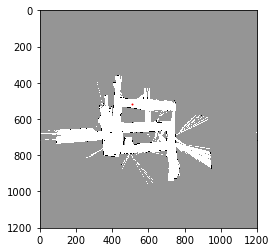

i: 25300
c_array
(100,)
[-431. -134. -260. -594. -422. -509. -554. -591. -176. -545. -566. -268.
 -198. -557. -521.  -74. -306. -549. -549. -405. -365. -563. -316. -575.
 -526. -554. -252.  -68. -506.   17. -262. -495.   14. -434. -218. -285.
 -519.  112. -587. -345. -562. -228. -181. -218. -555. -362. -448.  -82.
 -544. -533.  -25. -535. -595. -599. -530. -573. -214. -565. -536. -143.
 -270. -592. -566. -596. -177. -559.   19. -533. -388.   28.   48. -486.
 -472. -556. -105. -181. -590. -557. -590. -293. -593. -501. -400. -525.
 -534. -350.   51. -526. -489.   63. -523. -509. -252. -376. -574. -258.
 -551. -544. -143. -603.]
np.max(c_array)
112.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.30374457 -4.19322947 -4.71710962]
particle weights
[  1.50694127e-236   1.45732848e-107   2.76982756e-162   2.44396947e-307
   1.22108716e-232   2.00967920e-270   5.75274406e-290   4.90884390e-306
   8.37894253e-126   4.66149679e-286   3.53460811e-295   9.29173632e-166
   2.

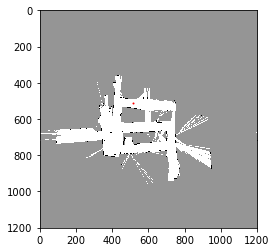

i: 25350
c_array
(100,)
[-626. -204. -149. -483. -198. -208. -566. -374.  128. -504. -537. -417.
 -195. -180. -599.  103. -348. -506. -665. -171. -639.  110. -120. -612.
 -202. -299.    0. -633. -270. -527.  -89. -119. -393.  -19. -513. -495.
 -503. -240.    7. -332. -181. -285. -568. -405. -439.  -73. -175. -197.
 -443.   89. -707.   85. -501. -156. -503. -523. -558. -538. -441. -643.
  -57. -315.  106. -517. -513. -212. -479. -589.  144. -321. -134.  118.
 -162.  114. -464. -334. -204. -184. -203. -564. -567. -585. -494. -159.
 -452. -528. -227.    6. -223.   55. -623.   92. -498. -472. -305. -215.
 -193.  -85. -154. -281.]
np.max(c_array)
144.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.24526005 -4.14428791 -4.70633524]
particle weights
[  0.00000000e+000   7.33702922e-152   5.64568643e-128   4.98149614e-273
   2.95996885e-149   1.34382378e-153   4.47628572e-309   1.08507142e-225
   1.12535162e-007   3.77724955e-282   1.75977756e-296   2.29506824e-244
   5.

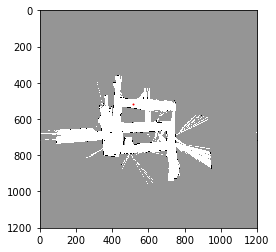

i: 25400
c_array
(100,)
[-499.   14. -379. -410.  -20. -269. -505. -549. -487. -485.  -67.   22.
 -589. -155. -167. -384. -444. -318. -372.   23. -397. -378. -454. -460.
  -55. -253. -378. -439. -569. -261. -289.  -72. -259. -485. -400. -206.
 -496. -467. -523. -156. -504. -554. -378. -556. -511.  120. -593. -593.
   -8.   44. -134. -583. -557. -528.   11. -395. -568. -483.   24.   22.
 -176. -515. -471. -477. -513. -162. -457. -206.  165. -442. -444. -510.
   28. -437. -526. -483. -446. -448. -461.   46. -502. -528. -567. -464.
 -578. -494.    5. -445.   -4. -525. -527.   16. -136.  -21. -222.   34.
   47. -262. -495. -479.]
np.max(c_array)
165.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.31684081 -4.00703917 -4.76821933]
particle weights
[  4.25073486e-289   2.63957030e-066   5.54372712e-237   1.90841537e-250
   4.52398179e-081   3.28242532e-189   1.05365183e-291   8.19860421e-311
   6.91827465e-284   5.11195195e-283   1.75258947e-101   7.86844816e-063
   0.

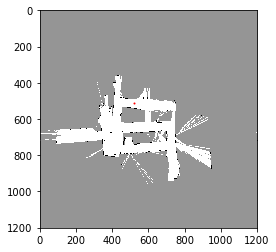

i: 25450
c_array
(100,)
[  77. -257. -219.    0. -268. -489. -365. -517. -519. -102. -466. -128.
 -464. -311. -302. -278. -319. -610. -259.   86.  -26. -532. -253. -359.
 -209.  -23. -239. -464. -406. -350. -349. -617.  -84.  -96. -485. -166.
   83.   42. -577. -664. -510. -174. -543. -350.  -12. -315. -536. -299.
  -95. -576. -472. -360. -349. -105. -472. -487. -555. -509. -488. -658.
  -59. -110.   29. -263. -348. -595. -159. -507. -181. -604.    1. -455.
 -382. -576. -199. -270. -476. -409. -526. -402. -325. -601.  -99. -201.
 -224.  -62. -455.   45.  -26. -576. -397.  -90. -190. -268. -464. -474.
 -125. -470. -284. -365.]
np.max(c_array)
86.0
xy_w_scan shape
(2, 1080)
*****Updating map*****
particle states
[-4.27924355 -3.88965024 -4.75858656]
particle weights
[  1.17543168e-004   1.03714729e-149   3.30392933e-133   4.26110549e-038
   1.73221237e-154   1.81769342e-250   1.29430429e-196   1.25682596e-262
   1.70092897e-263   2.14528567e-082   1.77130651e-240   1.09604555e-093
   1.3

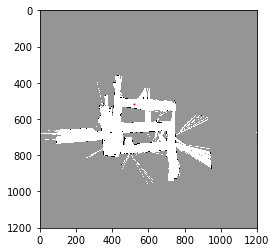

i: 25500
c_array
(100,)
[-636. -583. -314. -559.  -62. -573. -543. -442.  112. -149. -348. -239.
  -78.  -74. -143. -122.   81. -579.  -50. -541. -140. -185. -295. -152.
 -541. -486. -575. -123. -564.  -70. -704. -420.  -61. -375. -428. -420.
   45. -584.   85. -247. -207. -500. -659. -556. -564. -520. -420. -125.
 -476. -730. -577. -392. -190. -457. -213. -468.  -81. -565. -663. -427.
 -486. -571. -377. -533. -152. -547. -405. -575. -489. -277. -177. -463.
 -439. -451. -516. -443.  -77. -177.  -50. -445. -373. -426.  -71. -537.
 -120. -128. -129. -408. -413. -320. -493. -141.  -70. -101. -568. -285.
 -383. -442.   22. -418.]
np.max(c_array)
112.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.33681472 -3.80468299 -4.849951  ]
particle weights
[  0.00000000e+000   1.46330574e-302   9.78477197e-186   3.87616846e-292
   2.70869527e-076   3.22314539e-298   3.44440613e-285   2.51684822e-241
   1.00000000e+000   4.45800163e-114   1.67702032e-200   3.65289217e-153
   3.

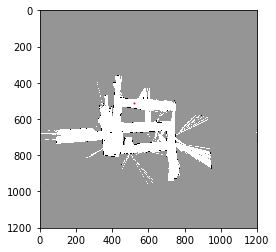

i: 25550
c_array
(100,)
[-250. -409. -539.  -66. -431. -492. -494. -389. -524. -367. -100. -518.
 -495. -104. -438. -278. -415. -492. -532. -521. -587. -492. -564. -443.
 -321. -508. -441. -485.  -14. -393.   28. -508. -272. -364. -155. -491.
 -280. -239. -355. -527. -280. -225. -208. -229. -341. -508.  -67. -308.
 -510. -553. -334. -229.  -29. -526. -168. -441. -664. -245. -123. -430.
 -277. -515. -514. -577. -242. -386. -537. -498. -424. -477. -284. -424.
 -558. -395. -511. -413. -471. -539. -396. -280. -532. -397. -259. -694.
 -234. -129. -432. -376. -193. -343. -238. -327. -442. -346. -292. -499.
 -434. -420. -245.    0.]
np.max(c_array)
28.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.46195439 -5.01227662 -5.00808464]
particle weights
[  1.84558491e-121   1.63422334e-190   5.68890604e-247   1.50078576e-041
   4.55861386e-200   1.46848465e-226   1.98737786e-227   7.92868285e-182
   1.85971327e-240   2.84236370e-172   2.57220937e-056   7.50261880e-238
   7.3

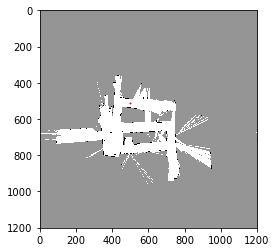

i: 25600
c_array
(100,)
[-395. -494. -453.   12. -469. -328.   11. -497.  -22.  -32. -721. -103.
 -768. -686. -386. -721. -245. -642. -476. -608. -151. -505.   72. -457.
 -335.   94. -492. -308. -218. -155.  -17.   53. -736. -439.   49. -496.
 -114. -443.   36. -295. -308. -450.  -93. -448. -631. -450. -340. -493.
   51.  -21. -431.  107.  -55.   46. -277. -310. -396. -466.   -2. -469.
   96. -589.   47. -465. -389. -135. -449. -425. -663. -595. -226.    8.
  -26. -204.  -68. -430.   17.  111.  -72. -315.   19. -768. -279.  103.
 -263. -498. -362. -469.   -7. -152. -744. -435. -694. -134.  -28.  -19.
 -321. -490.  -26.   37.]
np.max(c_array)
111.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.38419855 -4.90371761 -5.07568028]
particle weights
[  1.73367046e-220   1.75312483e-263   1.12172552e-245   9.92706086e-044
   1.26233577e-252   2.17118504e-191   3.65196160e-044   8.72829459e-265
   1.70140733e-058   7.72437733e-063   0.00000000e+000   1.12967955e-093
   0.

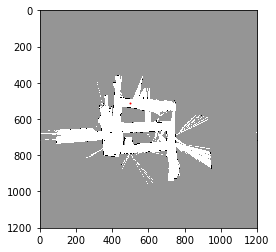

i: 25650
c_array
(100,)
[  59.   78. -342. -189.  -95. -269. -313. -162. -319. -411. -393.   52.
 -448. -664. -325. -417. -462. -458. -358. -349.  -53. -416. -463. -326.
 -118. -746. -221. -624. -381. -383. -750. -460.  -85. -394. -418. -315.
 -752. -260.   25. -251. -305.  -94.  -99.   33.   14. -748.   95. -307.
  -30. -719. -212. -217.   24. -289.   53. -323. -167. -544. -565. -110.
 -431. -204. -758. -439. -320. -476.  -22. -308.  -90.  -81. -430. -426.
 -799. -759. -375. -516. -312.  -15. -451. -729. -187. -332. -220. -319.
 -433. -333. -418. -486. -166. -824. -316. -618. -376. -440. -625. -338.
  -16. -465. -403. -311.]
np.max(c_array)
95.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.26066896 -4.73876983 -5.07774533]
particle weights
[  2.31952273e-016   4.13993755e-008   1.63422327e-190   4.57474743e-124
   3.04823482e-083   8.25673924e-159   6.42467799e-178   2.43398632e-112
   1.59251846e-180   1.76600585e-220   1.15955890e-212   2.11513095e-019
   1.5

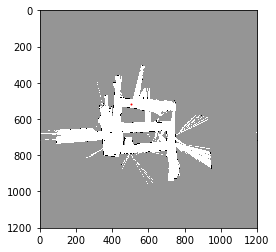

i: 25700
c_array
(100,)
[-517. -534. -487. -178. -557. -429.  -96. -539. -489. -540. -170. -355.
 -185. -514. -475.   26. -151. -339.  110. -490. -548. -385.  -27. -511.
 -523. -390. -504.   47. -518.  -15. -260. -689. -337. -339. -763.  144.
 -138.  -24. -489. -713. -511. -490.   44. -539. -137. -202. -137. -536.
 -531. -649. -538.    3. -496. -262. -495.  -42. -403. -355.  -85.  -65.
 -515. -322. -664.  -36. -184.  112. -232.   27. -375. -528. -299. -145.
 -507. -713. -409. -476.  145.    9. -465. -350.    8. -240. -502. -390.
 -172. -477.  -69. -496. -476.  -37. -502. -305.   83. -684. -111. -800.
 -533.  110. -120. -516.]
np.max(c_array)
145.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.30510024 -4.68745052 -4.8588878 ]
particle weights
[  2.29617592e-288   9.50602529e-296   2.45380256e-275   3.86219790e-141
   9.75496873e-306   3.79244739e-250   1.58118265e-105   6.40510946e-298
   3.32086064e-276   2.35630809e-298   1.15130497e-137   5.20848270e-218
   3.

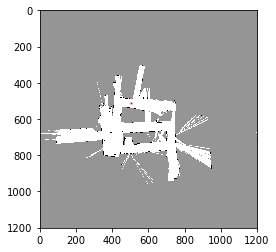

i: 25750
c_array
(100,)
[-189. -301.   32. -219. -232. -532. -537. -597. -522. -374.   26. -603.
 -314. -540. -610.   -9. -532.   46.  -45. -577.  -37. -491. -598. -532.
 -544. -550.   78. -723. -560.   54. -281.   27. -363. -591. -217.   98.
  -53. -471.   95.  -17. -144. -195.   27. -751. -346. -528. -605. -435.
 -530. -560. -539. -606. -607. -308. -592. -350. -188.   67. -603.  -15.
 -552. -164. -651.  -66. -713. -288. -547. -561. -204. -751. -587. -361.
   28.  -10. -729.  -12. -418. -293.  -21. -356. -582. -444. -622. -155.
 -236.  -69. -128.  -33. -745. -745. -171.   51.   93. -623.  -83. -117.
 -171. -282. -556.  -60.]
np.max(c_array)
98.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.32342436 -4.60417533 -4.57594705]
particle weights
[  2.15577737e-125   4.92744670e-174   2.05439718e-029   2.01729518e-138
   4.55975162e-144   2.34745143e-274   1.58170033e-276   1.38501760e-302
   5.17060587e-270   9.75269756e-206   5.09234147e-032   3.43311539e-305
   1.1

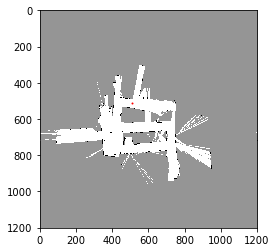

i: 25800
c_array
(100,)
[ -31. -443. -538. -517. -617. -476. -511.  -97. -140. -489. -387. -585.
 -570. -511. -506. -621. -575. -648. -482.   48. -200.   43. -665. -111.
 -222.  -71. -563. -651.  -39. -125.   77. -294.  -35. -613. -322. -563.
   99. -146. -227. -582. -608. -559.  -45. -297. -660. -510. -551.  -39.
 -109. -142.  -40. -100. -564. -538. -661. -135.   77. -473.   52. -559.
 -395. -567. -545. -328. -549.   -2. -262.  -31. -362. -555. -197.   56.
 -236. -168. -610.   91. -532. -621. -700. -184. -343. -576. -666. -115.
 -531. -572. -617. -171. -502. -414. -321. -518. -175. -493.  -72.   86.
 -519.   20. -419.  -65.]
np.max(c_array)
99.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.39416265 -4.58064736 -4.31605639]
particle weights
[  3.47993159e-057   4.09490812e-236   2.26083247e-277   2.98162143e-268
   1.10918582e-311   1.90777107e-250   1.20287194e-265   7.55326810e-086
   1.59761518e-104   4.31219105e-256   8.56515346e-212   8.75845961e-298
   2.8

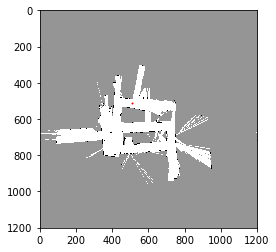

i: 25850
c_array
(100,)
[-640.  -59. -252. -203. -531. -672. -517. -456. -312. -670. -719.  -92.
 -340. -377. -545. -125. -426. -673. -649. -666. -352. -679. -591. -425.
 -640. -651. -681. -646. -425. -484. -133. -406. -256. -359. -446. -673.
 -655. -438. -478. -637. -668. -670. -463. -651. -592. -481. -214. -665.
 -563. -609. -428. -658. -262. -523. -619. -387. -418.  -95. -661. -675.
 -207. -473. -474. -377. -363. -669. -643. -531. -403. -288. -245. -399.
 -473. -656. -512. -408. -663. -399. -660. -305. -397.  -51. -559. -520.
 -134. -296. -665. -371. -593. -453. -678. -557. -552. -503. -692. -667.
 -384.  -25. -677. -368.]
np.max(c_array)
-25.0
xy_w_scan shape
(2, 1081)
particle states
[-4.41142082 -4.52931103 -4.12697697]
particle weights
[  8.10762456e-268   1.71390843e-015   2.60107340e-099   4.96114844e-078
   1.76600593e-220   1.02676300e-281   2.12380629e-214   6.59292750e-188
   2.27763272e-125   7.58680938e-281   3.97767741e-302   7.98490425e-030
   1.57484639e-137   1.34382

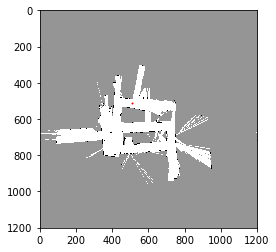

i: 25900
c_array
(100,)
[-265. -563. -582. -566. -458. -213. -648. -553. -611. -605. -275. -365.
 -277. -394. -292. -393. -644. -504. -407. -654. -662. -657. -662. -646.
 -618. -393. -192. -422. -630. -661.  -79. -131.  -81.  -79. -666. -554.
 -520. -664. -624. -582. -621. -315. -249. -608. -457. -206. -659. -575.
 -214. -311. -596. -600. -606. -641. -461. -263. -505. -620. -613. -710.
 -631.   43. -663. -617. -384. -608. -153. -644. -642.   -7. -623. -510.
 -615. -641. -513. -386. -583. -521. -649. -127. -597. -639. -655.   16.
 -659. -200. -580. -160. -464. -638. -537. -391. -616. -656. -660. -672.
 -626. -678.  -94. -500.]
np.max(c_array)
43.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-4.47121614 -4.36054365 -3.96030931]
particle weights
[  1.72702878e-134   6.56967622e-264   3.68085585e-272   3.27084919e-265
   2.62098519e-218   6.61626106e-112   7.98937865e-301   1.44706749e-259
   9.36286659e-285   3.77724997e-282   7.84069851e-139   6.42467826e-178
   1.0

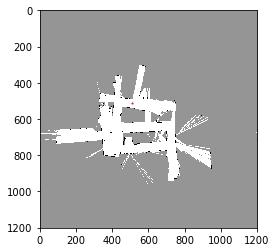

i: 25950
c_array
(100,)
[-374. -621.  -82. -516. -492. -432. -143. -580. -687. -419. -597. -386.
 -458. -542. -390. -411. -223. -580. -212. -642. -414. -374. -512. -430.
 -534. -618. -674. -526. -658. -633. -523. -503. -610.   -7. -381. -199.
 -391. -356. -410. -280. -387. -728. -725.   38. -355. -520. -166. -221.
 -657.  -41. -601.  -36. -734. -263. -237. -167. -628. -215. -358. -525.
 -620. -200. -282. -379. -331. -268. -169. -587. -354. -482.  -25. -481.
 -489. -698. -676. -494. -210. -589. -579. -650. -701. -526. -569. -334.
 -463. -575. -346.   84. -718. -445. -536. -710. -391.   30. -451. -501.
 -370. -292. -469. -511.]
np.max(c_array)
84.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-4.61704888 -4.34155779 -3.86193466]
particle weights
[  1.23915972e-199   6.64339780e-307   8.07450679e-073   2.65039655e-261
   7.02066780e-251   8.01765451e-225   2.60107340e-099   4.25073486e-289
   0.00000000e+000   3.54711773e-219   1.75977776e-296   7.61366047e-205
   4.0

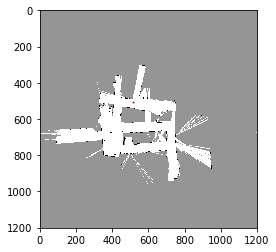

i: 26000
c_array
(100,)
[-646. -618. -499. -526. -532. -531. -748.  -73. -679. -397. -520. -757.
 -279. -716. -252. -586. -550. -244. -668. -406. -561. -398. -507. -404.
 -545. -496. -405.   47. -399. -212.   67. -262. -591.  -37. -157. -554.
 -642. -548. -147.  -76. -503. -110. -434. -543. -325. -408. -408. -413.
 -558. -526. -549. -589. -645. -569. -708. -549. -694. -533.  -11. -637.
 -165. -659.  -80. -737. -524. -399. -634. -485. -167.  -46. -503. -334.
 -439. -299. -720. -679. -592.   57. -638. -632. -356. -632. -767. -532.
 -200. -455. -793. -445.   14.   87. -695. -590. -604. -512.    8. -351.
 -658. -585.  -84. -410.]
np.max(c_array)
87.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-4.75986357 -4.2444582  -3.88003329]
particle weights
[  4.59481051e-319   6.64339778e-307   3.18737824e-255   5.99076926e-267
   1.48496323e-269   4.03654857e-269   0.00000000e+000   3.25748853e-070
   0.00000000e+000   6.33097732e-211   2.41684881e-264   0.00000000e+000
   1.1

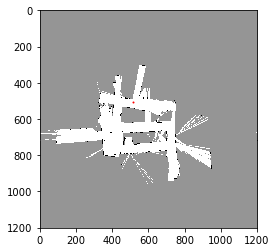

i: 26050
c_array
(100,)
[-589. -325. -426. -212. -390. -530.  -67. -608. -562. -264. -390. -437.
 -343. -453. -334. -174. -537. -414. -615. -498. -548. -130. -653. -725.
 -592. -274. -620. -569. -722. -564. -493. -710. -572. -450.   -3. -540.
 -708. -607. -313. -469. -555. -708. -686. -416. -284. -643. -523. -473.
 -571. -573. -359. -612.  -61. -527. -273.   20.  -70. -480.   53. -776.
 -276. -425.   26. -441. -320. -548. -381. -178. -146. -773. -428. -607.
 -121. -733. -265. -378. -465. -398. -466. -499. -528. -643. -324. -266.
  -11. -600. -491. -481. -688. -381. -282. -406. -514. -143. -604. -731.
 -399. -600. -374. -257.]
np.max(c_array)
53.0
xy_w_scan shape
(2, 1078)
*****Updating map*****
particle states
[-4.83279314 -4.14264233 -3.85280174]
particle weights
[  1.52385140e-279   6.86571609e-165   9.39600347e-209   8.16511481e-116
   4.05083466e-193   6.40202035e-254   7.66764807e-053   8.53782919e-288
   8.10762456e-268   2.13132283e-138   4.05083466e-193   1.56929239e-213
   1.0

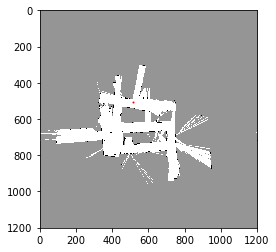

i: 26100
c_array
(100,)
[-709. -761. -337. -746. -631. -620. -659. -510. -722. -126. -537. -397.
 -668. -278. -513. -612. -597. -630. -664. -240. -722. -162. -618. -317.
 -643. -291. -554. -518. -601. -528. -529. -366. -690. -605. -648. -720.
 -634. -620. -691. -590. -431. -643. -611. -352. -571. -577. -745. -181.
 -564. -181. -508. -596. -321. -276. -566. -619. -598. -598. -224. -656.
 -566. -533. -216. -726. -617. -380. -623. -624. -643. -575. -103. -719.
 -655. -350. -338. -542. -376. -524. -506. -505. -521. -232. -438. -673.
 -573. -692. -661. -585. -724. -486. -320. -660. -393. -693. -727. -598.
 -708. -593. -575. -194.]
np.max(c_array)
-103.0
xy_w_scan shape
(2, 1063)
particle states
[-4.98660951 -4.00495577 -3.92299601]
particle weights
[  6.56967622e-264   1.71486883e-286   2.37187193e-102   5.60593601e-280
   4.92621719e-230   2.94953026e-225   3.40618366e-242   1.74640862e-177
   1.48496324e-269   1.02618796e-010   3.28242532e-189   2.07693220e-128
   4.20356459e-246   9.9647

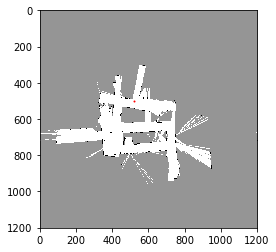

i: 26150
c_array
(100,)
[-565. -166. -514. -173. -694. -542. -403. -688. -215. -570. -573. -487.
 -714. -467. -641. -526. -324. -599. -652. -691. -520. -498. -134. -347.
 -532. -473. -760. -512. -251. -405. -452. -441. -799. -344. -241. -601.
 -338. -559. -669. -374. -291. -316. -334.  -79. -668. -398. -555. -503.
 -489. -231. -524. -754. -643. -710. -772. -527. -510. -577. -771. -712.
 -711. -759. -539. -651. -339. -624. -403. -197. -747. -349. -640. -588.
 -276. -409. -569. -443. -449. -562. -129. -107. -751. -404. -598. -366.
 -612. -562. -516. -296. -433. -438. -599. -775. -642.  -99. -729. -606.
 -359. -307. -555. -457.]
np.max(c_array)
-79.0
xy_w_scan shape
(2, 1074)
particle states
[-5.09397663 -3.94116777 -3.89586304]
particle weights
[  8.56804609e-212   1.64581143e-038   1.20753679e-189   1.50078576e-041
   8.10762454e-268   8.34939251e-202   1.94351485e-141   3.27084919e-265
   8.62880114e-060   5.77310405e-214   2.87425926e-215   6.42467824e-178
   1.67110597e-276   3.11703

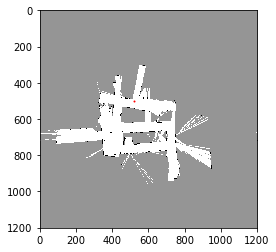

i: 26200
c_array
(100,)
[-495. -412. -484. -871. -685. -620. -367. -750. -519. -543. -757. -801.
 -433. -429. -383. -304. -581. -799. -587. -816. -408. -527. -610. -336.
 -688. -630. -378. -491. -557. -378. -391. -708. -349. -772. -294. -323.
 -778. -340. -568. -520. -220. -571. -364. -571. -646. -488. -748. -556.
 -561. -194. -431. -615. -689. -608. -280. -737. -586. -803. -548. -504.
 -706. -651. -245. -707. -326. -614. -575. -638. -691. -241. -379. -400.
 -794. -676. -644. -785. -237. -754. -753. -327. -615. -564. -624. -605.
 -845. -429. -780. -419. -633. -521. -347. -629. -542. -276. -506. -684.
 -563. -404. -390. -726.]
np.max(c_array)
-194.0
xy_w_scan shape
(2, 1081)
particle states
[-5.18342916 -3.90326222 -3.71381483]
particle weights
[  1.89391702e-131   2.10767161e-095   1.13396656e-126   9.60806100e-295
   5.77310406e-214   9.78477197e-186   7.36299712e-076   3.40618366e-242
   7.14979157e-142   2.69914251e-152   3.10603745e-245   2.41684882e-264
   1.59815473e-104   8.7256

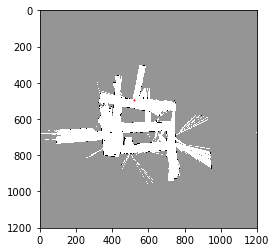

i: 26250
c_array
(100,)
[-723. -413. -576. -568. -545. -431. -557. -470. -437. -425. -776. -409.
 -562. -699. -834. -615. -602. -513. -756. -717. -438. -657. -756. -593.
 -471. -545. -619. -744. -684. -595. -619. -827. -539. -459. -788. -670.
 -572. -774. -514. -843. -629. -481. -416. -686. -427. -797. -425. -632.
 -500. -471. -508. -674. -462. -409. -550. -726. -385. -752. -466. -772.
 -807. -421. -761. -880. -765. -570. -724. -698. -739. -430. -707. -403.
 -714. -413. -471. -581. -574. -386. -454. -566. -818. -711. -764. -482.
 -811. -882. -611. -513. -792. -431. -836. -397. -738. -522. -368. -402.
 -389. -547. -470. -409.]
np.max(c_array)
-368.0
xy_w_scan shape
(2, 1070)
particle states
[-5.35036034 -4.62308209 -3.51093014]
particle weights
[  6.69050500e-155   2.86251842e-020   4.64245539e-091   1.38389645e-087
   1.34857989e-077   4.35960975e-028   8.28596120e-083   5.03457507e-045
   1.08063922e-030   1.75879210e-025   6.42467789e-178   1.56288210e-018
   5.58303674e-085   1.7722

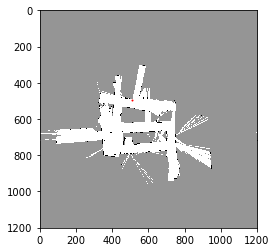

i: 26300
c_array
(100,)
[-530. -550. -573. -491. -528. -520. -558. -481. -428. -605. -623. -585.
 -494. -648. -580. -663. -463. -552. -611. -520. -540. -438. -486. -507.
 -525. -578. -503. -550. -617. -543. -539. -585. -411. -436. -472. -421.
 -539. -445. -558. -518. -507. -425. -678. -548. -541. -481. -499. -543.
 -600. -528. -541. -521. -416. -692. -629. -553. -613. -606. -558. -477.
 -789. -498. -437. -504. -530. -455. -668. -458. -461. -581. -488. -539.
 -534. -665. -490. -462. -622. -475. -529. -471. -539. -537. -554. -590.
 -538. -443. -487. -443. -568. -534. -681. -468. -527. -492. -657. -433.
 -576. -625. -481. -505.]
np.max(c_array)
-411.0
xy_w_scan shape
(2, 1061)
particle states
[-5.72326737 -5.03653281 -3.10211749]
particle weights
[  2.07023789e-052   4.26707833e-061   4.37882442e-071   1.79268939e-035
   1.52971039e-051   4.56000241e-048   1.43144531e-064   3.94866115e-031
   4.11204073e-008   5.54541574e-085   8.44565694e-093   2.69044271e-076
   8.92527491e-037   1.1729

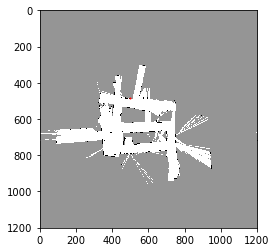

i: 26350
c_array
(100,)
[-362. -460. -255. -396. -176. -185. -409. -167. -535. -591. -223. -225.
 -369. -179. -329. -309. -279. -411. -476. -397. -188. -428. -364. -469.
 -344. -253. -481. -387. -328. -180. -140. -426. -388. -338. -657. -323.
 -434. -587. -214. -580. -172. -335. -171. -310. -306. -384. -333. -201.
 -616. -394. -284. -382. -166. -366. -218. -426. -403. -503. -217. -210.
 -432. -435. -331. -208. -453. -418. -356. -514. -392. -445. -621. -436.
 -443. -271. -433. -170. -451. -581. -242. -227. -453. -435. -255. -408.
 -212. -394. -193. -203. -462. -390. -280. -376. -399. -159. -161. -438.
 -471. -307. -468. -460.]
np.max(c_array)
-140.0
xy_w_scan shape
(2, 1078)
particle states
[-6.13226122 -5.53078445 -2.75512398]
particle weights
[  3.86033518e-097   1.06112315e-139   1.13797987e-050   6.61626101e-112
   2.31952282e-016   2.86251856e-020   1.49549293e-117   1.87952880e-012
   2.84236368e-172   1.35890363e-196   8.98582589e-037   1.21609929e-037
   3.52017003e-100   1.1548

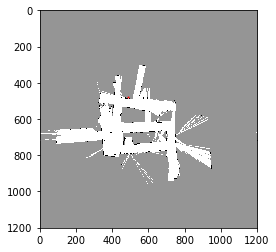

i: 26400
c_array
(100,)
[-121. -133. -126. -185. -137. -113. -121.  -76. -142.  -85. -104. -227.
 -135. -154.  -99. -140. -101. -120. -197. -140. -134.  -79. -168. -139.
  -95.  -96.  -88. -119.  -93. -169. -130. -130. -156. -121. -141. -177.
 -134. -143. -104. -181.  -81.  -89.  -79.  -87. -101. -238.  -79. -105.
 -162.  -83. -124. -112. -114. -193. -306. -129. -262. -167.  -94. -155.
  -90. -154. -114. -139.  -77. -123. -157. -165. -105. -310.  -98. -105.
 -108. -155. -120.  -94. -152. -222. -141.  -94.  -67. -114.  -72.  -84.
  -78. -318.  -76.  -74. -204. -131. -207. -129.  -91. -141. -244.  -98.
  -79. -263. -210. -228.]
np.max(c_array)
-67.0
xy_w_scan shape
(2, 1081)
particle states
[-6.42068041 -5.30824673 -2.61601743]
particle weights
[  3.50464632e-024   2.15332912e-029   2.36141211e-026   5.62078993e-052
   3.94395985e-031   1.04472034e-020   3.50464632e-024   1.22432264e-004
   2.65741925e-033   1.51093418e-008   8.46545662e-017   3.23168568e-070
   2.91421406e-030   1.63277

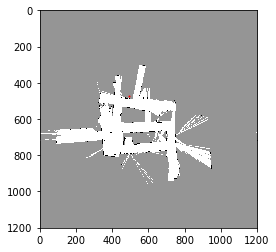

i: 26450
c_array
(100,)
[-183. -112. -161.  -61. -123. -182.  -95. -176. -102. -168. -156. -133.
  -94.  -92.  -64. -174. -182.  -64.  -69.  -91. -182. -185. -195. -101.
  -89. -214. -204. -203. -179.  -78.  -73. -183. -173. -120.  -97.  -85.
 -105.  -93. -182. -207. -111. -152. -139.  -95.  -64. -218. -180. -173.
 -185.  -97.  -90. -138.  -98. -181.  -49.  -64.  -62. -176. -138. -180.
 -102. -375. -154. -105. -289. -166. -274.  -72. -184. -285. -104.  -93.
 -185. -202. -183. -221.  -91. -198. -405.  -83. -106.  -94. -113. -100.
 -458.  -63.  -86.  -99. -125. -198. -157. -273. -107. -210. -181. -252.
  -65. -215. -113. -182.]
np.max(c_array)
-49.0
xy_w_scan shape
(2, 1032)
particle states
[-5.94265873 -5.45736638 -2.24474799]
particle weights
[  6.37580216e-059   4.35956390e-028   2.28566951e-049   6.14414738e-006
   7.28121318e-033   1.73312272e-058   1.05305060e-020   6.99191606e-056
   9.60257851e-024   2.08426080e-052   3.39223432e-047   3.30566567e-037
   2.86248831e-020   2.11510

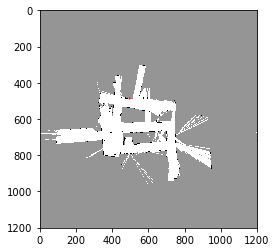

i: 26500
c_array
(100,)
[-193.   -5.  -57.  -18.  -65.   -8. -125. -205. -109. -198. -160.  -19.
 -221.  -38. -241.  -89. -184.  -22.   14.  -50. -170.  -80.  -76.  -29.
 -235. -106.   -9.  -12. -200.   14.  -39.  -61. -207.  -62.  -46. -138.
 -371. -365. -252. -123.   26. -101.  -32.   -2.  -25. -265.  -15. -187.
 -209. -212.  -24.  -24.  -23.  -78.  -86. -113.  -67.  -17.  -75.  -72.
  -44. -193.  -36.  -77. -106.  -26.  -87. -122.  -32.  -72.  -29. -277.
 -181. -179.  -87.  -41. -272.   29. -146.  -54.   -8. -183. -183.  -83.
  -90.    4.  -50.    1. -147. -330.  -23. -194.  -42. -385.  -52. -290.
  -89.  -86. -109. -121.]
np.max(c_array)
29.0
xy_w_scan shape
(2, 1061)
*****Updating map*****
particle states
[-6.01819073 -5.20499756 -1.87783938]
particle weights
[  3.67725329e-097   1.63262388e-015   4.26160393e-038   3.69026776e-021
   1.42960885e-041   8.12835565e-017   1.25183853e-067   2.25938251e-102
   1.11239755e-060   2.47771378e-099   7.89298811e-083   1.35757364e-021
   2.5

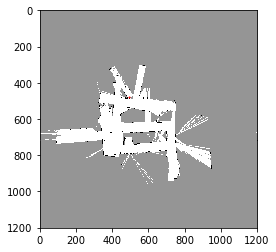

i: 26550
c_array
(100,)
[-508. -127.  181. -289. -214.   -8. -462. -350. -224. -113.   54. -497.
 -488.  182.  -23.  -16.  -54. -673.  113. -270. -399.  -19. -539. -245.
 -531. -654. -223. -270. -196.  183.  179.   63.  -77. -465.  -72. -568.
  134.  115.  174. -513. -177. -185. -472. -491.   37.    6. -670.  176.
 -613. -254. -590. -453. -315. -452.   22.  -82. -460. -538. -196.  125.
 -499. -538. -628. -453.   38. -314. -189.  -36. -160.  -38. -530. -501.
 -695.  103. -211. -410. -124. -464.  -74. -456.  154.   23. -413. -535.
 -609. -412.  -48. -258. -109. -444. -585. -486. -716. -582. -619. -599.
 -470. -225. -354. -263.]
np.max(c_array)
183.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-5.96288646 -5.18476501 -1.59854703]
particle weights
[  5.24731306e-301   1.53509261e-135   8.88863366e-002   6.76750387e-206
   2.52647296e-173   7.36508778e-084   4.98291115e-281   2.18004328e-232
   1.14701695e-177   1.84610895e-129   6.21492376e-057   3.14178366e-296
   2.

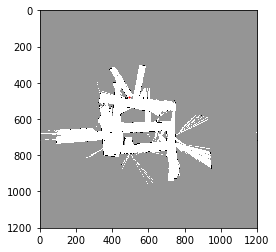

i: 26600
c_array
(100,)
[-492. -443. -386. -365. -474. -375. -355. -500. -503. -430. -434. -407.
 -485. -386. -434. -337. -529. -533. -463. -400. -421. -431. -417. -506.
 -341. -503. -417. -425. -484. -391. -442. -557. -479. -368. -389. -380.
 -416. -369. -398. -392. -376. -426. -430. -376. -424. -390. -422. -400.
 -421. -430. -460. -385. -385. -385. -346. -454. -427. -369. -518. -386.
 -383. -448. -401. -349. -524. -361. -396. -358. -406. -366. -423. -364.
 -467. -386. -398. -348. -414. -426. -546. -338. -464. -551. -503. -419.
 -427. -426. -389. -404. -422. -451. -371. -421. -384. -383. -411. -444.
 -386. -364. -396. -409.]
np.max(c_array)
-337.0
xy_w_scan shape
(2, 978)
particle states
[-6.09452941 -5.29372116 -1.5424775 ]
particle weights
[  3.48726642e-68   6.65142565e-47   3.78181438e-22   4.98751631e-13
   2.28973805e-60   2.26432890e-17   1.09857357e-08   1.16984756e-71
   5.82432803e-73   2.94267978e-41   5.38970603e-43   2.86758361e-31
   3.82425198e-65   3.78181438e-22   5.3

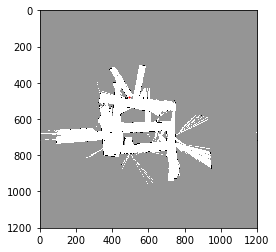

i: 26650
c_array
(100,)
[-201. -295. -594. -387. -523. -400. -183. -477. -606. -384. -553. -184.
 -317. -367. -588. -319. -313. -600.   13. -165. -457. -234. -197. -260.
 -691. -195. -225. -492. -651. -535. -769. -365. -320. -318.    6. -601.
 -501. -514. -489. -643. -715. -307. -590. -422. -343. -280. -372. -371.
 -764. -383. -188. -452. -330. -404. -676. -196. -268. -201. -429. -478.
 -371. -399. -212. -257. -374. -315. -537. -433. -385. -353. -376.  -80.
 -439. -305. -566. -208. -333. -395. -538. -404. -549. -293. -494. -373.
 -528. -511. -327. -203. -320. -381. -358. -312. -507. -308. -506. -340.
 -564.   56.  -53. -653.]
np.max(c_array)
56.0
xy_w_scan shape
(2, 1081)
*****Updating map*****
particle states
[-5.93248086 -5.22832619 -1.35587133]
particle weights
[  2.43398642e-112   3.65289217e-153   5.11195195e-283   4.05083466e-193
   3.49538468e-252   9.15622070e-199   1.59815473e-104   3.31925903e-232
   3.14089183e-288   8.13631891e-192   3.27084919e-265   5.87928270e-105
   1.0

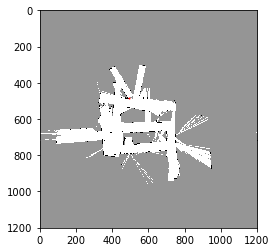

i: 26700
c_array
(100,)
[-312. -418. -346. -403. -318. -496. -459. -496. -406. -238. -560. -384.
 -432. -479. -340. -548. -499. -331. -194. -318. -313. -343. -502. -457.
 -641. -554. -313. -413. -471. -352. -299. -453. -168. -543. -402. -388.
 -160. -438. -317. -244. -394. -364. -357. -360. -501. -627. -485. -406.
 -521. -364. -313. -300. -642. -520. -464. -423. -295. -513. -300. -289.
 -367. -206. -488. -486. -481. -323. -539. -413. -412. -643. -641. -472.
 -469. -460. -406. -462. -211. -324. -498. -577. -336. -140. -290. -434.
 -327. -465. -348. -483. -460. -190. -473. -581. -469. -300. -483. -376.
 -321. -478. -374. -256.]
np.max(c_array)
-140.0
xy_w_scan shape
(2, 932)
particle states
[-5.937835   -5.26422447 -1.0581398 ]
particle weights
[  2.00147012e-075   1.84558491e-121   3.43033652e-090   6.03324912e-115
   4.96114843e-078   2.46129938e-155   2.88443178e-139   2.46129938e-155
   3.00377787e-116   2.74878500e-043   3.94745874e-183   1.07682819e-106
   1.53465685e-127   5.94525

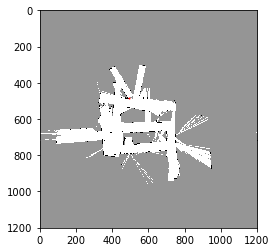

i: 26750
c_array
(100,)
[-881. -207. -444. -767. -351. -320. -313. -325. -506. -720. -192. -249.
 -241. -246. -741. -544. -476. -262. -317. -193. -260. -450. -231. -189.
 -453. -422. -446. -476. -373. -512. -554. -371. -504. -487. -309. -603.
 -872. -532. -348. -268. -315. -340. -317. -882. -607. -202. -607. -313.
 -187. -317. -877. -221. -557. -565. -437. -450. -201. -247. -188. -696.
 -229. -230. -322. -550. -872. -327. -424. -672. -329. -670. -431. -457.
 -641. -502. -827. -625. -336. -203. -445. -652. -652. -557. -643. -607.
 -283. -310. -337. -343. -241. -255. -673. -878. -226. -212. -739. -240.
 -202. -512. -883. -478.]
np.max(c_array)
-187.0
xy_w_scan shape
(2, 1081)
particle states
[-5.89093852 -5.20543124 -0.77795391]
particle weights
[  2.62998590e-302   1.36280658e-009   1.60931853e-112   8.50206374e-253
   3.94483487e-072   1.14592915e-058   1.25666390e-055   7.72120988e-061
   1.90714684e-139   2.19464867e-232   4.45503839e-003   7.83548679e-028
   2.33572569e-024   1.5737

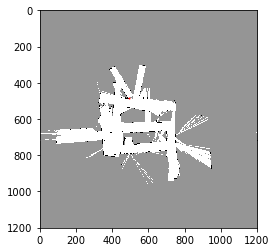

i: 26800
c_array
(100,)
[-729. -291. -218. -633. -371. -240. -289. -558. -654. -220. -614. -295.
 -579. -467. -435. -224. -462. -634. -576. -345. -345. -193. -370. -611.
 -563. -488. -478. -310. -562. -348. -248. -509. -473. -605. -597. -470.
 -720. -318. -317. -474. -577. -188. -495. -471. -452. -429. -377. -476.
 -560. -296. -241. -203. -742. -245. -215. -396. -733. -423. -181. -198.
 -275. -363. -636. -510. -225. -555. -468. -668. -562. -394. -579. -671.
 -349. -611. -726. -168. -185. -276. -687. -293. -526. -405. -683. -727.
 -185. -425. -180. -709. -581. -582. -581. -487. -610. -304. -493. -362.
 -548. -220. -487. -339.]
np.max(c_array)
-168.0
xy_w_scan shape
(2, 1081)
particle states
[-5.90852692 -5.17059281 -0.49573576]
particle weights
[  2.29504902e-244   3.81746478e-054   1.92873347e-022   1.12995781e-202
   6.88995661e-089   5.38014049e-032   2.82074614e-053   4.21840595e-170
   8.56797337e-212   2.61025691e-023   2.01677470e-194   6.99193064e-056
   3.19863180e-179   1.3994

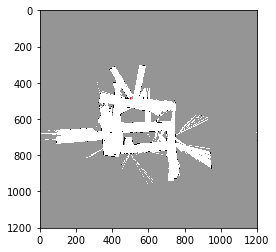

i: 26850
c_array
(100,)
[-550. -730. -309. -675. -158. -451. -620. -252. -552. -123. -324. -230.
 -137. -115. -411. -531. -223. -583. -423. -789. -247. -360. -192. -363.
 -523. -405. -307. -549. -112. -297. -173. -520. -214. -291. -188. -175.
 -459. -717. -403. -317. -393. -419. -668. -560. -672. -600. -281. -658.
 -144. -841. -204. -389. -218. -248. -156. -458. -130. -266. -276. -566.
 -157. -269. -497. -368. -395. -694. -166. -524. -256. -283. -672. -123.
 -350. -698. -309. -114. -270. -129. -166. -367. -573. -252. -247. -738.
 -543. -636. -836. -483. -361. -808. -310. -237. -473. -285. -226. -115.
 -504. -257. -336. -697.]
np.max(c_array)
-112.0
xy_w_scan shape
(2, 1081)
particle states
[-5.94596749 -5.20258488 -0.21826508]
particle weights
[  4.86821843e-191   3.26861157e-269   2.25081704e-086   2.51512641e-245
   8.52721007e-021   4.81419596e-148   1.93533577e-221   1.27975155e-061
   6.58841720e-192   1.35242699e-005   6.88530156e-093   4.58779776e-052
   1.12458188e-011   4.0315

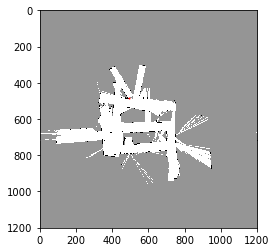

i: 26900
c_array
(100,)
[-391. -472. -162. -373. -414. -143. -115. -730. -670. -627. -221. -279.
 -353. -770. -576. -582. -290. -240. -543. -207. -204. -522. -791. -813.
 -500. -483. -819. -494. -273. -656. -506. -221. -589. -459. -152. -243.
 -429. -550. -608. -152. -276. -186. -239. -142. -577. -163. -113. -701.
 -570. -409. -476. -290. -600. -382. -167. -302. -245. -233. -208. -168.
 -241. -148. -289. -595. -517. -429. -512. -560. -241. -245. -352. -521.
 -349. -518. -602. -148. -221. -307. -366. -704. -692. -515. -637. -236.
 -321. -139. -582. -600. -118. -552. -644. -389. -296. -685. -660. -181.
 -307. -815. -757. -561.]
np.max(c_array)
-113.0
xy_w_scan shape
(2, 1060)
particle states
[-5.9204248  -5.22099603  0.03886188]
particle weights
[  1.61599525e-121   1.07296868e-156   4.59067381e-022   1.06106198e-113
   1.65831487e-131   8.19354024e-014   1.18499655e-001   9.60750709e-269
   1.09718441e-242   5.18731176e-224   1.09270267e-047   7.07004295e-073
   5.14790343e-105   4.0816

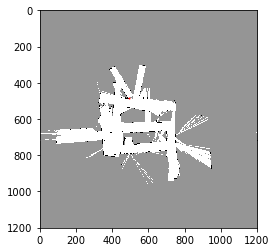

i: 26950
c_array
(100,)
[-624. -291. -685. -677. -853. -144. -287. -580. -296. -519. -806. -617.
 -319. -427. -271. -596. -342. -240. -567. -671. -257. -451.  -91. -629.
 -633. -401. -226. -112. -516. -196. -251. -547. -371. -388. -496. -627.
 -114. -705. -250.  -92. -547. -514. -368. -242. -222. -112. -449. -216.
 -447. -684. -620. -693. -146. -564. -387. -613. -508. -234. -190. -287.
 -295. -283. -536. -712. -723. -651. -180. -242. -193. -570. -524. -641.
 -115. -562. -691. -530. -704. -290.  -88. -607. -175. -611. -759. -289.
 -589. -212. -574. -540. -372. -248. -491. -278. -535. -379. -445. -265.
 -660. -582. -266. -545.]
np.max(c_array)
-88.0
xy_w_scan shape
(2, 1081)
particle states
[-5.94470682 -5.18041309  0.32124821]
particle weights
[  1.54719368e-233   6.45070465e-089   4.98403735e-260   1.48572059e-256
   0.00000000e+000   4.47606101e-025   3.52196540e-087   1.98839145e-214
   4.34645060e-091   6.17255948e-188   1.40588235e-312   1.69670390e-230
   4.46027529e-101   5.56618

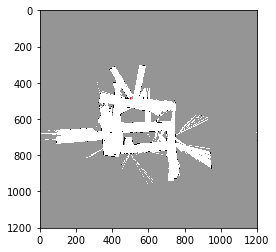

i: 27000
c_array
(100,)
[-472. -173. -340. -214. -229. -628. -667. -578. -531. -126. -394. -558.
 -128. -269. -454. -339. -557. -686. -651. -335. -550. -616. -306. -373.
 -583. -546. -357. -492. -220. -645. -154. -634. -240. -175. -118. -599.
 -726. -626. -105. -658. -496. -552. -647. -540. -577. -456. -319. -368.
 -571. -376. -544. -630.  -80. -613. -117. -615. -375. -364.  -89. -704.
 -283. -541. -191. -100. -384. -284. -668. -207. -638. -528. -173. -379.
 -322. -225. -357. -645. -429. -691. -296. -208. -519. -367. -563. -283.
 -438. -353. -191. -600. -241. -407. -595. -550. -625. -319. -647. -280.
 -284. -431. -217. -107.]
np.max(c_array)
-80.0
xy_w_scan shape
(2, 1081)
particle states
[-5.97435361 -5.11826089  0.49437865]
particle weights
[  5.70833563e-171   4.07905526e-041   1.21166095e-113   6.37508282e-059
   1.95015263e-065   1.01524375e-238   1.17242624e-255   5.26373987e-217
   1.35873595e-196   1.05293179e-020   4.28034809e-137   2.55378338e-208
   1.42498822e-021   8.28493

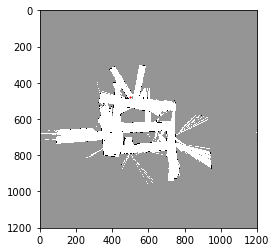

i: 27050
c_array
(100,)
[-886. -695. -717. -515. -498. -734. -710. -169. -557. -393. -598. -180.
 -692. -563. -609. -355. -193. -679. -351. -340. -555. -371. -879. -639.
 -658. -211. -368. -454. -289. -630. -673. -152. -619. -398. -473. -560.
 -578. -591. -266. -517. -292. -122. -384. -350. -296. -566. -555. -330.
 -223. -763. -847. -625. -302. -617. -360. -478. -753. -593. -414. -151.
 -578. -264. -494. -616. -574. -310. -602. -513. -690. -323. -282. -602.
 -335. -121. -378. -683. -338. -782. -590. -324. -620. -691. -275. -392.
 -760. -361. -615. -710. -425. -434. -142. -305. -349. -409. -298. -655.
 -524. -692. -374. -578.]
np.max(c_array)
-121.0
xy_w_scan shape
(2, 1081)
particle states
[-5.90636619 -5.12348172  0.58319787]
particle weights
[  0.00000000e+000   3.79244739e-250   1.05789110e-259   5.64841123e-172
   1.36437106e-164   4.37960326e-267   1.16011846e-256   1.04187843e-021
   3.24756661e-190   5.44318506e-119   5.07556401e-208   1.74011418e-026
   7.61733421e-249   8.0499

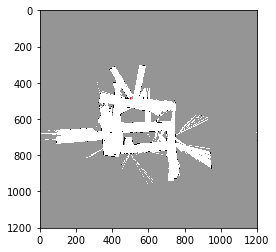

i: 27100
c_array
(100,)
[-672. -487. -335. -383. -457. -365. -564. -644. -371. -682. -639. -442.
 -537. -604. -565. -602. -234. -249. -374. -614. -339. -453. -409. -445.
 -334. -589. -613. -741. -406. -359. -644. -528. -203. -201. -122. -608.
 -136. -493. -163. -548. -651. -568. -706. -246. -688. -719. -689. -522.
 -515. -366. -487. -807. -608. -452. -352. -653. -646. -392. -507. -522.
 -662. -439. -638. -583. -228. -732. -605. -319. -282. -275. -587. -220.
 -600. -345. -590. -710. -280. -625. -241. -365. -596. -296. -233. -196.
 -289. -116. -299. -222. -455. -344. -566. -573. -250. -581. -195. -629.
 -432. -565. -287. -509.]
np.max(c_array)
-116.0
xy_w_scan shape
(2, 1081)
particle states
[-5.91608866 -5.12823601  0.58581288]
particle weights
[  3.39776145e-242   7.51055510e-162   7.73451856e-096   1.10229580e-116
   8.02613562e-149   7.23767085e-109   2.72268206e-195   4.91403650e-230
   1.79403924e-111   1.54258131e-246   7.29307681e-228   2.62375768e-142
   1.44859820e-183   1.1566

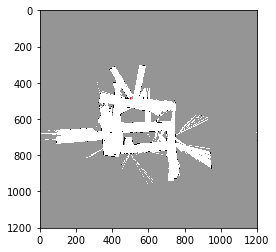

i: 27150
c_array
(100,)
[-290. -561. -429. -461. -642. -507. -220. -466. -600. -464. -208. -342.
 -578. -390. -556. -546. -546. -561. -572. -347. -557. -366. -385. -728.
 -703. -237. -430. -536. -447. -446. -593. -389. -582. -623. -427. -212.
 -606. -550. -200. -435. -523. -600. -796. -753. -563. -348. -208. -183.
 -266. -187. -680. -638. -320. -646. -329. -231. -383. -673. -457. -476.
 -437. -572. -646. -589. -563. -256. -611. -662. -578. -749. -178. -599.
 -429. -367. -663. -632. -693. -641. -686. -741. -288. -179. -222. -462.
 -658. -542. -587. -389. -716. -464. -482. -383. -628. -337. -566. -216.
 -367. -200. -244. -735.]
np.max(c_array)
-178.0
xy_w_scan shape
(2, 1081)
particle states
[-5.89730923 -5.12202348  0.58032234]
particle weights
[  1.66263610e-049   3.36505843e-167   7.14272979e-110   9.04567125e-124
   2.23429017e-202   9.52565026e-144   4.18225914e-019   6.09492534e-126
   3.88604491e-184   4.50357453e-125   6.80682713e-014   4.33994421e-072
   1.39311323e-174   6.1851

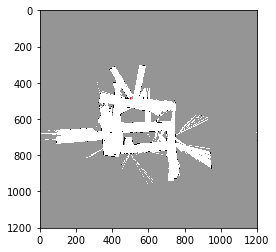

i: 27200
c_array
(100,)
[-276. -375. -233. -522. -572. -552. -472. -288. -362. -642. -215. -708.
 -524. -228. -510. -605. -735. -579. -680. -646. -372. -486. -513. -492.
 -639. -595. -595. -247. -306. -526. -402. -450. -215. -366. -243. -584.
 -277. -634. -718. -270. -433. -269. -578. -619. -515. -572. -607. -453.
 -591. -421. -453. -236. -228. -222. -562. -518. -215. -401. -263. -401.
 -455. -223. -702. -687. -441. -489. -518. -582. -488. -224. -572. -450.
 -386. -488. -257. -430. -558. -349. -392. -414. -455. -695. -264. -548.
 -555. -274. -419. -618. -502. -598. -633. -465. -225. -456. -570. -414.
 -633. -627. -452. -713.]
np.max(c_array)
-215.0
xy_w_scan shape
(2, 1081)
particle states
[-5.89683048 -5.12447693  0.57937711]
particle weights
[  1.07327183e-027   1.08531554e-070   5.07425693e-009   1.56410961e-134
   3.01677617e-156   1.46363480e-147   8.10944773e-113   6.59441005e-033
   4.80158132e-065   1.19930420e-186   3.33175553e-001   2.60311617e-215
   2.11679217e-135   7.5308

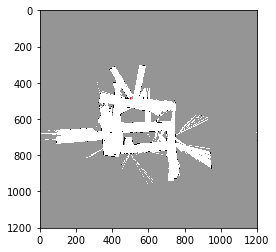

i: 27250
c_array
(100,)
[-245. -407. -404. -295. -377. -248. -610. -382. -258. -221. -409. -555.
 -715. -587. -600. -264. -233. -529. -709. -246. -632. -378. -224. -503.
 -419. -366. -606. -260. -633. -438. -438. -375. -597. -611. -632. -490.
 -512. -362. -528. -517. -589. -285. -453. -413. -630. -642. -349. -303.
 -674. -521. -423. -689. -307. -603. -564. -650. -251. -342. -745. -605.
 -380. -559. -272. -659. -587. -725. -561. -597. -258. -494. -263. -453.
 -384. -586. -545. -607. -604. -717. -507. -247. -621. -448. -356. -437.
 -587. -475. -514. -283. -436. -714. -463. -619. -602. -535. -279. -298.
 -232. -384. -427. -279.]
np.max(c_array)
-221.0
xy_w_scan shape
(2, 1081)
particle states
[-5.93455378 -5.14512661  0.59279119]
particle weights
[  3.59601723e-011   1.58531546e-081   3.18419123e-080   6.93581769e-033
   1.69414334e-068   1.79035156e-012   1.09228475e-169   1.14150480e-070
   8.12818350e-017   9.52553397e-001   2.14549117e-082   8.40489659e-146
   2.73788543e-215   1.0644

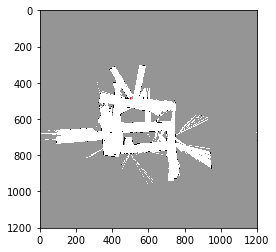

i: 27300
c_array
(100,)
[-317. -626. -673. -324. -408. -685. -696. -307. -432. -369. -674. -356.
 -596. -755. -494. -430. -689. -502. -512. -579. -312. -492. -619. -654.
 -613. -683. -358. -324. -566. -437. -542. -387. -543. -397. -330. -670.
 -705. -481. -321. -559. -301. -557. -545. -596. -653. -585. -598. -310.
 -598. -692. -562. -302. -701. -621. -623. -725. -594. -606. -755. -303.
 -453. -337. -493. -538. -577. -560. -536. -596. -343. -359. -597. -386.
 -483. -532. -600. -545. -754. -578. -604. -519. -704. -478. -337. -368.
 -603. -375. -615. -566. -472. -498. -566. -535. -675. -692. -523. -595.
 -472. -582. -631. -556.]
np.max(c_array)
-301.0
xy_w_scan shape
(2, 1081)
particle states
[-5.97596939 -5.16108608  0.63671832]
particle weights
[  7.47328038e-008   4.74806186e-142   1.83939804e-162   6.81474960e-011
   2.25275220e-047   1.13016521e-167   1.88756813e-172   1.64609955e-003
   8.50444266e-058   1.95073474e-030   6.76676722e-163   8.63031172e-025
   5.07400424e-129   4.4929

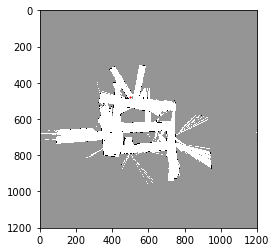

i: 27350
c_array
(100,)
[-437. -516. -611. -598. -473. -620. -333. -444. -653. -338. -632. -737.
 -437. -485. -436. -375. -355. -327. -520. -682. -514. -518. -405. -485.
 -393. -541. -640. -565. -517. -544. -686. -543. -602. -562. -686. -695.
 -459. -698. -333. -352. -346. -564. -677. -418. -530. -478. -569. -376.
 -704. -588. -584. -339. -342. -520. -546. -362. -521. -386. -365. -555.
 -699. -634. -734. -601. -605. -493. -366. -592. -423. -618. -614. -576.
 -380. -362. -549. -321. -659. -611. -602. -537. -342. -589. -546. -726.
 -394. -544. -372. -599. -329. -715. -581. -651. -382. -488. -563. -401.
 -507. -635. -571. -355.]
np.max(c_array)
-321.0
xy_w_scan shape
(2, 1081)
particle states
[-5.91360613 -5.14567591  0.58841497]
particle weights
[  4.17459425e-051   2.04809549e-085   1.13077037e-126   5.00267955e-121
   9.68306668e-067   1.39548150e-130   6.12689431e-006   3.80673721e-054
   6.50138941e-145   4.12826891e-008   8.57413465e-136   2.14916471e-181
   4.17459425e-051   5.9494

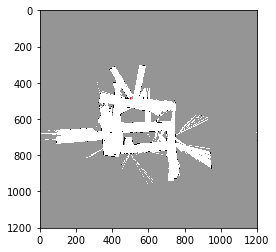

i: 27400
c_array
(100,)
[-591. -582. -714. -691. -597. -708. -542. -601. -566. -543. -643. -577.
 -707. -570. -592. -601. -602. -620. -601. -591. -445. -565. -385. -401.
 -522. -598. -516. -593. -564. -389. -380. -551. -571. -507. -522. -700.
 -548. -572. -401. -411. -586. -448. -575. -415. -390. -398. -546. -576.
 -563. -687. -445. -524. -575. -497. -612. -579. -581. -547. -375. -533.
 -579. -685. -517. -568. -468. -585. -688. -552. -427. -579. -428. -437.
 -595. -586. -391. -550. -587. -492. -569. -575. -525. -594. -573. -571.
 -541. -514. -662. -700. -474. -381. -461. -704. -395. -583. -458. -537.
 -434. -547. -572. -590.]
np.max(c_array)
-375.0
xy_w_scan shape
(2, 1081)
particle states
[-5.9003103  -5.12632913  0.57867256]
particle weights
[  1.54307632e-094   1.25036769e-090   5.89068950e-148   5.74036113e-138
   3.82490378e-097   2.37647376e-145   2.94318132e-073   7.00555564e-099
   1.11109055e-083   1.08273590e-073   4.02785981e-117   1.85571019e-088
   6.45992543e-145   2.0350

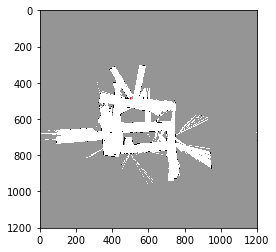

i: 27450
c_array
(100,)
[-504. -650. -390. -603. -367. -464. -586. -497. -363. -508. -625. -364.
 -617. -472. -577. -528. -710. -366. -643. -361. -555. -580. -423. -490.
 -493. -713. -434. -503. -776. -713. -379. -530. -576. -492. -500. -497.
 -622. -570. -684. -547. -524. -380. -539. -451. -525. -708. -533. -502.
 -449. -378. -561. -539. -515. -561. -460. -682. -401. -620. -367. -481.
 -378. -573. -389. -430. -517. -536. -685. -545. -613. -537. -430. -590.
 -353. -621. -561. -512. -472. -762. -413. -379. -579. -575. -575. -629.
 -521. -504. -537. -710. -574. -409. -512. -527. -471. -372. -362. -514.
 -668. -755. -406. -541.]
np.max(c_array)
-353.0
xy_w_scan shape
(2, 1081)
particle states
[-5.91560373 -5.13428304  0.58752453]
particle weights
[  2.63818551e-066   1.03350117e-129   8.52857095e-017   2.66778988e-109
   8.31092476e-007   6.20989999e-049   6.44403386e-102   2.89312170e-063
   4.53761117e-005   4.83200530e-068   7.44171476e-119   1.66929386e-005
   2.21834391e-115   2.0831

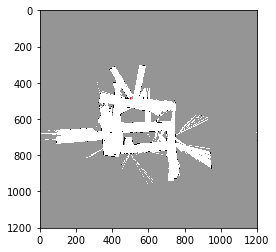

i: 27500
c_array
(100,)
[-564. -522. -522. -601. -499. -669. -496. -583. -650. -511. -593. -488.
 -618. -611. -580. -631. -532. -756. -554. -607. -569. -704. -508. -564.
 -539. -688. -577. -769. -524. -674. -696. -693. -549. -520. -481. -552.
 -673. -575. -577. -633. -509. -585. -555. -550. -544. -571. -665. -510.
 -577. -552. -564. -530. -637. -643. -717. -554. -534. -515. -510. -496.
 -618. -512. -637. -521. -675. -543. -542. -510. -514. -592. -633. -499.
 -502. -585. -543. -587. -668. -580. -675. -674. -549. -511. -445. -504.
 -567. -563. -524. -695. -581. -554. -626. -587. -680. -543. -610. -583.
 -558. -543. -673. -509.]
np.max(c_array)
-445.0
xy_w_scan shape
(2, 1081)
particle states
[-5.12842036 -5.36628647  0.54397491]
particle weights
[  2.08428284e-052   3.62514092e-034   3.62514092e-034   1.77852848e-068
   3.53262857e-024   5.22439558e-098   7.09547416e-023   1.16778125e-060
   9.32462145e-090   2.17052201e-029   5.30171867e-065   2.11513104e-019
   7.36299712e-076   8.0745

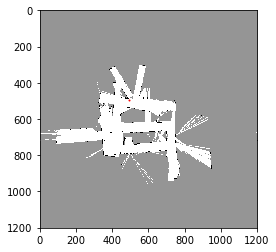

i: 27550
c_array
(100,)
[-701. -483. -564. -540. -571. -711. -545. -507. -523. -507. -517. -492.
 -569. -548. -556. -522. -685. -529. -527. -494. -487. -643. -629. -689.
 -541. -529. -561. -599. -494. -526. -546. -506. -713. -655. -658. -478.
 -486. -541. -642. -682. -535. -709. -523. -526. -536. -676. -522. -535.
 -706. -568. -527. -526. -536. -662. -534. -505. -547. -529. -499. -618.
 -639. -672. -679. -550. -678. -681. -775. -536. -479. -538. -504. -561.
 -554. -497. -504. -583. -518. -482. -528. -570. -697. -690. -702. -521.
 -524. -525. -679. -547. -676. -510. -535. -483. -621. -620. -539. -690.
 -501. -498. -536. -707.]
np.max(c_array)
-478.0
xy_w_scan shape
(2, 1081)
particle states
[-5.64871795 -5.20313593  0.5253436 ]
particle weights
[  1.01428941e-097   4.81236929e-003   3.19525786e-038   8.46395758e-028
   2.91369802e-041   4.60486680e-102   5.70296976e-030   1.81673415e-013
   2.04446495e-020   1.81673415e-013   8.24796030e-018   5.93893551e-007
   2.15294781e-040   2.8393

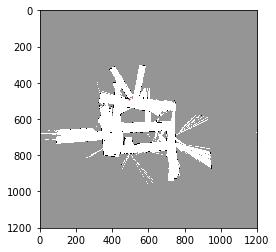

i: 27600
c_array
(100,)
[-608. -524. -491. -528. -518. -484. -494. -502. -514. -615. -489. -527.
 -528. -503. -555. -511. -498. -474. -519. -702. -522. -579. -710. -533.
 -729. -526. -700. -520. -531. -539. -517. -695. -499. -520. -498. -516.
 -714. -586. -517. -704. -697. -487. -502. -584. -520. -528. -561. -593.
 -478. -529. -519. -527. -478. -721. -489. -510. -543. -489. -515. -543.
 -568. -541. -694. -660. -508. -517. -499. -709. -488. -569. -503. -544.
 -494. -534. -512. -481. -460. -556. -491. -669. -480. -501. -515. -505.
 -606. -537. -705. -516. -572. -545. -500. -596. -502. -519. -532. -490.
 -568. -498. -634. -537.]
np.max(c_array)
-460.0
xy_w_scan shape
(2, 1081)
particle states
[-5.47915797 -4.91772773  0.359902  ]
particle weights
[  5.30171408e-065   1.60380950e-028   3.44247413e-014   2.93747957e-030
   6.47022933e-026   3.77513128e-011   1.71390695e-015   5.74951729e-019
   3.53262552e-024   4.83453746e-068   2.54366345e-013   7.98489734e-030
   2.93747957e-030   2.1151

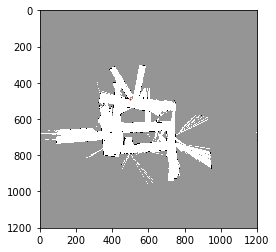

i: 27650
c_array
(100,)
[-510. -495. -572. -639. -584. -642. -672. -630. -686. -618. -560. -526.
 -612. -574. -634. -580. -628. -601. -610. -569. -622. -771. -577. -549.
 -573. -575. -612. -631. -621. -621. -576. -575. -490. -732. -623. -771.
 -647. -599. -620. -576. -654. -580. -631. -617. -590. -554. -682. -635.
 -682. -610. -595. -626. -532. -616. -613. -811. -636. -524. -617. -571.
 -586. -836. -556. -628. -587. -579. -658. -570. -569. -565. -584. -694.
 -546. -572. -582. -570. -488. -626. -613. -586. -638. -637. -482. -707.
 -585. -610. -564. -616. -633. -629. -683. -582. -549. -667. -617. -578.
 -558. -594. -587. -592.]
np.max(c_array)
-482.0
xy_w_scan shape
(2, 1081)
particle states
[-5.24114428 -5.38248809  0.42404249]
particle weights
[  6.89498057e-013   2.25398113e-006   8.17099921e-040   6.52446463e-069
   5.02043543e-045   3.24833966e-070   3.03967379e-083   5.28682845e-065
   2.52757605e-089   8.60456661e-060   1.32986927e-034   7.75927843e-020
   3.47132993e-057   1.1058

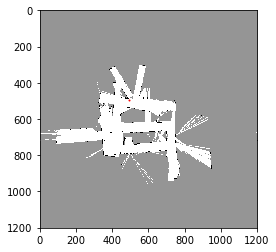

i: 27700
c_array
(100,)
[-481. -629. -495. -619. -544. -568. -576. -679. -490. -489. -531. -457.
 -485. -662. -624. -539. -587. -476. -646. -540. -559. -555. -510. -548.
 -500. -499. -488. -593. -483. -567. -578. -637. -571. -544. -475. -520.
 -620. -553. -498. -595. -575. -570. -547. -553. -597. -605. -548. -532.
 -630. -602. -606. -573. -609. -509. -511. -578. -586. -570. -507. -503.
 -489. -516. -674. -478. -560. -493. -620. -625. -594. -562. -504. -540.
 -557. -504. -519. -681. -578. -552. -623. -543. -518. -483. -526. -684.
 -479. -492. -497. -592. -574. -509. -643. -507. -548. -563. -564. -485.
 -597. -598. -571. -546.]
np.max(c_array)
-457.0
xy_w_scan shape
(2, 1081)
particle states
[-5.86549123 -5.10409742  0.55805038]
particle weights
[  3.77513446e-11   2.00147008e-75   3.13913272e-17   4.40853123e-71
   1.64581140e-38   6.21315945e-49   2.08428280e-52   3.86033512e-97
   4.65888604e-15   1.26641653e-14   7.28129002e-33   9.99999978e-01
   6.91439996e-13   9.32462124e-90   2.

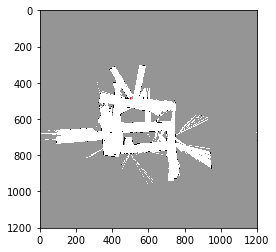

i: 27750
c_array
(100,)
[-546. -495. -504. -691. -545. -506. -512. -563. -544. -469. -440. -607.
 -414. -608. -362. -698. -404. -564. -604. -588. -372. -436. -396. -660.
 -575. -555. -686. -571. -584. -597. -562. -514. -647. -637. -620. -591.
 -395. -573. -361. -561. -452. -465. -565. -600. -573. -573. -575. -480.
 -407. -415. -516. -517. -626. -550. -541. -554. -559. -816. -784. -547.
 -632. -570. -588. -571. -697. -610. -496. -577. -551. -594. -574. -533.
 -577. -626. -596. -681. -512. -493. -631. -563. -401. -783. -378. -546.
 -560. -553. -584. -598. -547. -385. -711. -556. -524. -544. -423. -540.
 -426. -573. -558. -481.]
np.max(c_array)
-361.0
xy_w_scan shape
(2, 1081)
particle states
[-5.90455738 -5.13113222  0.58117608]
particle weights
[  3.30725521e-081   4.66107710e-059   5.75222612e-063   3.52182550e-144
   8.99005175e-081   7.78479151e-064   1.92965689e-066   1.36918306e-088
   2.44374943e-080   9.12310801e-048   3.58659874e-035   1.06537945e-107
   7.02003570e-024   3.9193

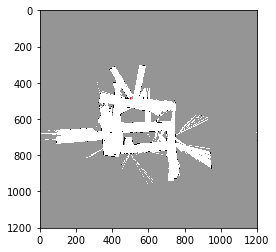

i: 27800
c_array
(100,)
[-558. -524. -383. -506. -574. -643. -652. -438. -577. -523. -588. -525.
 -578. -405. -458. -545. -610. -555. -537. -546. -498. -623. -584. -544.
 -391. -584. -545. -537. -387. -408. -517. -568. -727. -568. -700. -422.
 -455. -532. -728. -640. -562. -559. -502. -614. -577. -684. -592. -548.
 -509. -461. -530. -809. -580. -536. -541. -584. -400. -398. -575. -511.
 -371. -390. -685. -388. -524. -529. -463. -496. -555. -555. -518. -634.
 -514. -437. -555. -589. -404. -795. -700. -504. -700. -619. -582. -478.
 -659. -603. -677. -570. -742. -450. -667. -598. -515. -468. -746. -414.
 -562. -752. -481. -541.]
np.max(c_array)
-371.0
xy_w_scan shape
(2, 1081)
particle states
[-5.8941935  -5.12035836  0.57770624]
particle weights
[  6.12250496e-082   3.57224741e-067   6.14417361e-006   2.34553655e-059
   6.88997165e-089   7.44557399e-119   9.18856827e-123   7.98485389e-030
   3.43031490e-090   9.71037523e-067   5.72920930e-095   1.31415638e-067
   1.26194233e-090   1.7138

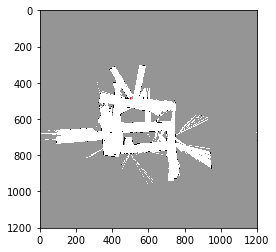

i: 27850
c_array
(100,)
[-603. -542. -430. -530. -439. -575. -529. -572. -809. -577. -574. -512.
 -534. -661. -539. -538. -563. -371. -534. -547. -397. -501. -667. -570.
 -661. -403. -684. -582. -579. -393. -609. -650. -596. -404. -621. -576.
 -552. -611. -556. -530. -525. -456. -583. -554. -515. -618. -577. -547.
 -574. -555. -701. -396. -612. -393. -793. -571. -623. -562. -755. -559.
 -423. -417. -534. -627. -559. -603. -542. -586. -504. -541. -796. -678.
 -549. -508. -504. -366. -551. -545. -536. -574. -774. -822. -548. -386.
 -422. -356. -493. -466. -494. -528. -774. -597. -546. -538. -531. -539.
 -672. -367. -586. -568.]
np.max(c_array)
-356.0
xy_w_scan shape
(2, 1081)
particle states
[-5.91503403 -5.12310757  0.58255699]
particle weights
[  5.36087730e-108   1.66417603e-081   7.28083580e-033   2.70852623e-076
   8.98526520e-037   7.75320667e-096   7.36253764e-076   1.55727319e-094
   1.83896132e-197   1.04928242e-096   2.10754008e-095   1.77841749e-068
   4.96083884e-078   3.4686

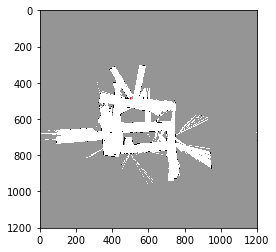

i: 27900
c_array
(100,)
[-371. -557. -591. -556. -564. -587. -395. -502. -582. -604. -426. -429.
 -528. -808. -525. -806. -556. -562. -538. -764. -435. -528. -606. -654.
 -406. -611. -487. -599. -716. -772. -548. -536. -624. -423. -711. -558.
 -622. -563. -562. -574. -730. -583. -521. -578. -592. -550. -629. -555.
 -589. -671. -489. -725. -539. -398. -569. -504. -557. -574. -560. -539.
 -539. -598. -552. -555. -538. -550. -574. -608. -563. -499. -565. -535.
 -387. -409. -507. -594. -542. -700. -550. -579. -555. -601. -506. -546.
 -497. -463. -529. -574. -379. -599. -597. -575. -538. -592. -523. -815.
 -396. -495. -408. -560.]
np.max(c_array)
-371.0
xy_w_scan shape
(2, 1081)
particle states
[-5.90779211 -5.12255753  0.5805387 ]
particle weights
[  9.99664537e-001   1.66372159e-081   2.85146646e-096   4.52246416e-081
   1.51711771e-084   1.55684793e-094   3.77386813e-011   1.28019804e-057
   2.31056720e-092   6.44525349e-102   1.29914546e-024   6.46806440e-026
   6.54064574e-069   1.6336

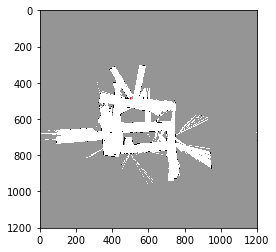

i: 27950
c_array
(100,)
[-601. -534. -536. -573. -411. -555. -523. -561. -558. -578. -411. -386.
 -503. -594. -550. -613. -643. -529. -558. -485. -578. -691. -415. -558.
 -412. -665. -381. -682. -500. -597. -399. -721. -573. -555. -643. -407.
 -525. -563. -558. -430. -575. -592. -547. -550. -505. -468. -579. -559.
 -577. -554. -528. -578. -544. -743. -584. -594. -559. -554. -552. -405.
 -638. -484. -567. -831. -416. -596. -541. -532. -573. -561. -670. -581.
 -562. -414. -587. -576. -420. -651. -597. -607. -547. -594. -574. -542.
 -758. -597. -669. -723. -567. -509. -800. -611. -569. -592. -395. -676.
 -596. -671. -571. -649.]
np.max(c_array)
-381.0
xy_w_scan shape
(2, 1081)
particle states
[-5.90556485 -5.11091669  0.58112024]
particle weights
[  2.83333011e-096   3.54835828e-067   4.80218073e-068   4.09772369e-084
   9.29498597e-014   2.69056411e-076   2.12454907e-062   6.66924164e-079
   1.33955299e-077   2.76102450e-086   9.29498597e-014   6.69284529e-003
   1.03075726e-053   3.1071

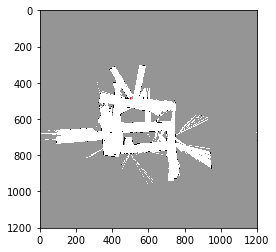

i: 28000
c_array
(100,)
[-507. -447. -605. -562. -614. -398. -551. -573. -582. -529. -533. -569.
 -617. -576. -664. -374. -566. -398. -396. -553. -595. -718. -560. -702.
 -391. -586. -598. -759. -578. -562. -568. -548. -551. -409. -585. -424.
 -552. -557. -399. -594. -517. -509. -598. -529. -543. -652. -621. -397.
 -385. -442. -401. -561. -543. -430. -778. -613. -698. -545. -387. -704.
 -557. -514. -562. -575. -555. -548. -775. -555. -450. -459. -557. -537.
 -618. -605. -411. -591. -525. -562. -655. -531. -496. -559. -636. -550.
 -678. -408. -570. -407. -669. -574. -537. -422. -572. -592. -534. -431.
 -404. -538. -573. -576.]
np.max(c_array)
-374.0
xy_w_scan shape
(2, 1081)
particle states
[-5.91403101 -5.12733686  0.58459091]
particle weights
[  1.73310811e-058   1.97922226e-032   4.76394158e-101   2.25231510e-082
   5.87917097e-105   3.77506280e-011   1.34855434e-077   3.76174929e-087
   4.64236743e-091   4.83444976e-068   8.85460361e-070   2.05384552e-085
   2.92706687e-106   1.8728

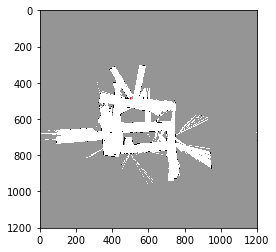

i: 28050
c_array
(100,)
[-540. -562. -620. -408. -529. -450. -530. -551. -576. -549. -598. -561.
 -551. -572. -556. -782. -802. -625. -508. -409. -529. -512. -566. -511.
 -569. -563. -431. -552. -564. -392. -564. -568. -392. -394. -436. -522.
 -534. -582. -581. -416. -568. -560. -612. -564. -577. -410. -391. -563.
 -511. -384. -435. -611. -535. -597. -573. -746. -598. -562. -639. -428.
 -534. -559. -626. -693. -601. -611. -556. -587. -738. -507. -643. -591.
 -791. -516. -560. -555. -404. -552. -415. -683. -587. -741. -376. -581.
 -416. -561. -579. -476. -549. -423. -591. -591. -568. -541. -450. -660.
 -582. -436. -756. -541.]
np.max(c_array)
-376.0
xy_w_scan shape
(2, 1081)
particle states
[-5.89639482 -5.11159771  0.57677267]
particle weights
[  5.96429431e-072   1.66372087e-081   1.07646649e-106   1.26599117e-014
   3.57107003e-067   7.27884442e-033   1.31372325e-067   9.96138590e-077
   1.38343168e-087   7.36052392e-076   3.85903853e-097   4.52246220e-081
   9.96138590e-077   7.5532

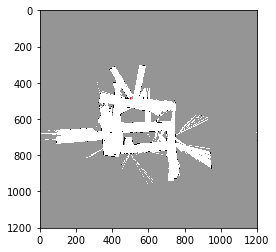

i: 28100
c_array
(100,)
[-702. -531. -593. -592. -557. -357. -496. -533. -417. -505. -433. -639.
 -352. -607. -238. -631. -608. -637. -701. -458. -533. -443. -624. -403.
 -357. -705. -800. -228. -737. -476. -545. -263. -424. -359. -700. -655.
 -252. -589. -608. -613. -467. -215. -518. -244. -648. -645. -461. -376.
 -591. -591. -583. -408. -610. -401. -395. -439. -585. -521. -486. -411.
 -581. -393. -663. -355. -445. -586. -654. -637. -629. -644. -591. -292.
 -406. -497. -485. -241. -581. -441. -650. -610. -359. -723. -577. -328.
 -409. -484. -541. -687. -511. -436. -586. -740. -242. -583. -606. -440.
 -490. -403. -598. -660.]
np.max(c_array)
-215.0
xy_w_scan shape
(2, 1081)
particle states
[-5.89784207 -5.12477332  0.57928299]
particle weights
[  3.15200089e-212   5.79352302e-138   6.86570057e-165   1.86629091e-164
   2.95996249e-149   2.13886113e-062   9.18860544e-123   7.84068079e-139
   1.87289605e-088   1.13396400e-126   2.10766684e-095   7.23000656e-185
   3.17435137e-060   5.7090

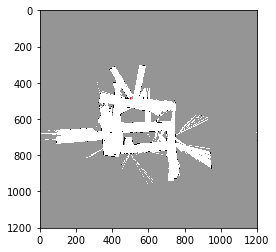

i: 28150
c_array
(100,)
[-466. -342. -653. -656. -634. -481. -569. -577. -567. -566. -462. -629.
 -376. -699. -214. -278. -536. -537. -315. -270. -445. -521. -407. -652.
 -265. -486. -666. -247. -223. -405. -649. -572. -668. -481. -747. -498.
 -453. -394. -665. -359. -569. -453. -273. -590. -511. -589. -454. -616.
 -537. -559. -402. -565. -445. -496. -630. -593. -267. -435. -505. -497.
 -222. -225. -402. -581. -409. -629. -329. -688. -431. -603. -272. -594.
 -580. -592. -649. -665. -445. -600. -562. -581. -443. -504. -468. -379.
 -377. -256. -620. -673. -409. -659. -700. -433. -276. -436. -398. -602.
 -394. -432. -442. -297.]
np.max(c_array)
-214.0
xy_w_scan shape
(2, 1081)
particle states
[-5.88894484 -5.11026476  0.57205399]
particle weights
[  3.61063901e-110   2.57098668e-056   2.21062947e-191   1.10060760e-192
   3.94558233e-183   1.10450285e-116   6.68732506e-155   2.24334764e-158
   4.94130200e-154   1.34318514e-153   1.97134210e-108   5.85576339e-181
   4.40643574e-071   2.3279

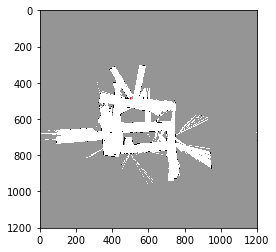

i: 28200
Mapping Complete!
Testing duration: 4925.09590507
test_dataset
Resampled 563 times...
Filter Number: 100
Step size: 50
Sigma x, y, yaw: 0.6, 0.6, 0.105


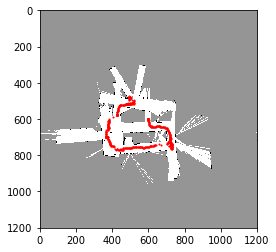

In [38]:
# particle filter
import numpy as np
from load_data import *
from p3_utils import *
import matplotlib.pyplot as plt

# function for creating a new map
def new_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -30  #meters
    MAP['ymin']  = -30
    MAP['xmax']  =  30
    MAP['ymax']  =  30 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype='float') #DATA TYPE: float
    MAP['log_map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype='float') #DATA TYPE: float
    
    return MAP

import time
start_time = time.time()

# train set
# dataset_num = 3
# lidar_data0 = get_lidar('lidar/train_lidar' + str(dataset_num))
# joint_data0 = get_joint('joint/train_joint' + str(dataset_num))

# test set
lidar_data0 = get_lidar('lidar/test_lidar')
joint_data0 = get_joint('joint/test_joint')

# init MAP
MAP = new_map()

def transform_lidar2body(neck_angle, head_angle):
    # transformation from lidar to head
    h_T_l = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0.15],
                      [0, 0, 0, 1]])
    
    # transformation from head to body
    b_T_h = np.array([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0.33],
                      [0, 0, 0, 1]])
    Rz = np.array([[np.cos(neck_angle), -np.sin(neck_angle), 0],
                   [np.sin(neck_angle), np.cos(neck_angle), 0],
                   [0, 0, 1]])
    
    Ry = np.array([[np.cos(head_angle), 0, np.sin(head_angle)],
                   [0, 1, 0],
                   [-np.sin(head_angle), 0, np.cos(head_angle)],])
    
    b_T_h[:3,:3] = np.dot(Rz, Ry)
    
    b_T_l = np.dot(b_T_h, h_T_l)
    
    return b_T_l
   
def plot_on_map(points):
    for scan_point in points.T:
        line_points = bresenham2D(state_vec[0]/MAP['res'], state_vec[1]/MAP['res'], 
                                  scan_point[0]/MAP['res'], scan_point[1]/MAP['res']) + np.array([[MAP['sizex']/2], [MAP['sizey']/2]])

        # put points on the map
        for pt in line_points.T:
            MAP['map'][int(pt[0]), int(pt[1])] = 1
            
def update_log_map(points, state_vec):
    for scan_point in points.T:
        line_points = bresenham2D(state_vec[0]/MAP['res'], state_vec[1]/MAP['res'], 
                                  scan_point[0]/MAP['res'], scan_point[1]/MAP['res']) + np.array([[MAP['sizex']/2], [MAP['sizey']/2]])

        g = 4.0
        # update last point as occupied 
        occ_pt = line_points[:,-1]
        MAP['log_map'][int(occ_pt[0]), int(occ_pt[1])] += np.log(g)
        
        # put points on the map
        for pt in line_points[:,:-1].T:
            MAP['log_map'][int(pt[0]), int(pt[1])] += np.log(1/g)

def update_map_with_log_map():
    MAP['map'] = 1 - 1/(1 + np.exp(MAP['log_map']))
    
    MAP['map'][MAP['map'] >= 0.6] = 1
    MAP['map'][MAP['map'] <= 0.4] = -1
    indValid = np.logical_and((MAP['map'] < 0.6),(MAP['map'] > 0.4)) # valid range for probability
    MAP['map'][indValid] = 0
    
    
def update_particle_weights(correlations, weights):
    new_weights = np.multiply(weights, np.exp(correlations - np.max(correlations))) # subtracing c by its max
    new_weights /= np.sum(new_weights)
    return new_weights

# from filterpy package """Copyright 2015 Roger R Labbe Jr."""
def stratified_resample(weights):
    """ Performs the stratified resampling algorithm used by particle filters.
    This algorithms aims to make selections relatively uniformly across the
    particles. It divides the cumulative sum of the weights into N equal
    divisions, and then selects one particle randomly from each division. This
    guarantees that each sample is between 0 and 2/N apart.
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """

    N = len(weights)
    # make N subdivisions, and chose a random position within each one
    positions = (np.random.random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes
    
# xy-positions of each pixel of the map
# 1 x 1001
x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) 
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res'])

# deviation grid for x, y in correlation
# 1 x 9
x_range = np.arange(-0.2,0.2+0.05,0.05)
y_range = np.arange(-0.2,0.2+0.05,0.05)
yaw_range = np.arange(-2,2+0.25,0.25)*np.pi/180 # convert from degree to rad


# initialize particles
filter_num = 100

particle_states = np.zeros((filter_num, 3)) # x, y, yaw
particle_weights = np.ones(filter_num, dtype = 'float')/filter_num


state_vec_collection = []

# define variance for the state vector: x, y, yaw
# sigma_x = 0.1
# sigma_y = 0.1
# sigma_yaw = 0.008
# sigma_x = 0.4
# sigma_y = 0.4
# sigma_yaw = 0.07
sigma_x = 0.6
sigma_y = 0.6
sigma_yaw = 0.105

# sigma_x = 0.05
# sigma_y = 0.05
# sigma_yaw = 0.004
# sigma_x = 0.01
# sigma_y = 0.01
# sigma_yaw = 0.001

step_size = 50

##### Map Initilization #####

lidar_d = lidar_data0[0]
    
# state vector update (dummy rn)
state_vec = np.array([0,0,0]) # x, y, yaw

# main loop [currently just 1st timestamp]
current_time = lidar_d['t'] # get the time for current lidar scan

# get the correct time for the joint data
joint_index = np.argmin(abs(joint_data0['ts'] - current_time))

# neck angle and head angle
neck_angle, head_angle = joint_data0['head_angles'][:, joint_index]

b_T_l =  transform_lidar2body(neck_angle, head_angle)

angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T # increments for angles
ranges = np.double(lidar_d['scan']).T # first timestamp

# only keep valid indices by asserting the range for distance

indValid = np.logical_and((ranges < 30),(ranges> 0.1)) # valid range for scan distance
ranges = ranges[indValid]
angles = angles[indValid]

# xy position in the sensor frame
xs0 = np.array([ranges*np.cos(angles)])
ys0 = np.array([ranges*np.sin(angles)])

# convert position in the map frame here 
xyz_s = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)

x, y, yaw = state_vec #x, y, yaw

# transformation from lidar to world
w_T_l = np.array([[np.cos(yaw), -np.sin(yaw), 0, x],
                [np.sin(yaw), np.cos(yaw), 0, y],
                [0, 0, 1, 1.41],
                [0, 0, 0, 1]])

xyz1_s = np.concatenate([xyz_s, np.ones(xs0.shape)],axis=0)
xyz_w_scan = np.dot(w_T_l, xyz1_s)[:3,:]
indValid = xyz_w_scan[2,:] > 0.1 # valid range for scan distance
xy_w_scan = xyz_w_scan[:2,indValid]
#xy_w_scan = np.dot(w_T_l, xyz1_s)[:2,:]

#xyy_w_robot = np.dot(w_T_b, state_vec)

plot_on_map(xy_w_scan)
update_log_map(xy_w_scan, state_vec)

##### END of Map Initilization #####

resample_count = 0
all_negative_c_i = []
# loop through each lidar scan
for i in range(1*step_size, len(lidar_data0), step_size):
    print "i: " + str(i)
    if i + step_size > len(lidar_data0) - 1:
        break
    
    lidar_d = lidar_data0[i]
    
    # main loop [currently just 1st timestamp]
    current_time = lidar_d['t'] # get the time for current lidar scan

    # get the correct time for the joint data
    joint_index = np.argmin(abs(joint_data0['ts'] - current_time))

    # neck angle and head angle
    neck_angle, head_angle = joint_data0['head_angles'][:, joint_index]

    b_T_l =  transform_lidar2body(neck_angle, head_angle)

    
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T # increments for angles
    ranges = np.double(lidar_d['scan']).T # first timestamp

    # only keep valid indices by asserting the range for distance
    
    indValid = np.logical_and((ranges < 30),(ranges > 0.1)) # valid range for scan distance
    ranges = ranges[indValid]
    angles = angles[indValid]

    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])

    # convert position in the map frame here 
    xyz_s = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)

    ##### PREDICTION (motion model) #####
    
    delta_odom = (lidar_d['pose'][0] - lidar_data0[i - step_size]['pose'][0])
    
    # sample noise
    noise_cov = np.array([[sigma_x**2, 0, 0],
                          [0, sigma_y**2, 0],
                          [0, 0, sigma_yaw**2]])
    
    noise_mean = np.zeros(3)
    
    noise = sigma_x*np.random.multivariate_normal(noise_mean, noise_cov, filter_num)
    
    # prediction step
    particle_states += delta_odom
    particle_states += noise
    
    ##### update #####
    
    # loop through each particle state, rotate lidar scanner by that state
    c_list = []

    for j in range(particle_states.shape[0]):
        
        state = particle_states[j,:]
        
        c_list_yaw = [] # store the correlation for each yaw iteration
        max_index_xy = [] # store the xy index for each yaw iteration
        for yaw_dev in yaw_range:
        
            x, y, yaw = state #x, y, yaw
            
            # add deviation to yaw
            yaw += yaw_dev

            # transformation from lidar to world
            w_T_l = np.array([[np.cos(yaw), -np.sin(yaw), 0, x],
                            [np.sin(yaw), np.cos(yaw), 0, y],
                            [0, 0, 1, 1.41],
                            [0, 0, 0, 1]])

            xyz1_s = np.concatenate([np.copy(xyz_s), np.ones(xs0.shape)],axis=0)
            xyz_w_scan = np.dot(w_T_l, xyz1_s)[:3,:]
            
            indValid = xyz_w_scan[2,:] > 0.1 # valid range for scan distance
        
            xy_w_scan = xyz_w_scan[:2,indValid]
            #xy_w_scan = np.dot(w_T_l, xyz1_s)[:2,:]

            # get correlation of map and transformed lidar scan
            c = mapCorrelation(MAP['map'],x_im,y_im,xy_w_scan,x_range,y_range)

            # get the max correlation and index from the returned 9x9 grid c
            max_index_flat = np.argmax(c)
            max_index = [max_index_flat / len(y_range), max_index_flat % len(y_range)]

            max_index_xy.append(max_index)
            c_list_yaw.append(np.amax(c))
        
        c_list_yaw = np.array(c_list_yaw) # convert list to np array
        max_index_xy = np.array(max_index_xy) # convert list to np array
        
        max_index = np.argmax(c_list_yaw)
        max_index_x = max_index_xy[max_index][0]
        max_index_y = max_index_xy[max_index][1]
        max_index_yaw = max_index
        
        # print "Max_dev_indexes: {0}, {1}, {2}".format(max_index_x, max_index_y, max_index_yaw)
        # update the particle state with the max correlation deviation in x, y, yaw
        particle_states[j,:] = state + np.array([x_range[max_index_x], y_range[max_index_y],
                                                 yaw_range[max_index_yaw]])
        
        c_list.append(np.max(c_list_yaw))
        
    c_array = np.array(c_list)
    
    print "c_array"
    print c_array.shape
    print c_array
    if len(c_array[c_array<0]) == len(c_array):
        all_negative_c_i.append(i)
        
    
    # update particle weights
    particle_weights = update_particle_weights(c_array, particle_weights)
    
#     # from body to world frame
#     w_T_b = np.dot(w_T_l, np.linalg.inv(b_T_l))

    #xyy_w_robot = np.dot(w_T_b, state_vec)
            
    # save most likley state
    most_likely_particle_index = np.argmax(particle_weights)
    
    # update the log map with the best particle
    
    state = particle_states[most_likely_particle_index,:]

    #x, y, yaw = lidar_d['pose'][0] #x, y, yaw
    x, y, yaw = state #x, y, yaw
    
    # transformation from lidar to world
    w_T_l = np.array([[np.cos(yaw), -np.sin(yaw), 0, x],
                    [np.sin(yaw), np.cos(yaw), 0, y],
                    [0, 0, 1, 1.41],
                    [0, 0, 0, 1]])

    xyz1_s = np.concatenate([np.copy(xyz_s), np.ones(xs0.shape)],axis=0)
    xyz_w_scan = np.dot(w_T_l, xyz1_s)[:3,:]

    indValid = xyz_w_scan[2,:] > 0.1 # valid range for scan distance

    xy_w_scan = xyz_w_scan[:2,indValid]
    #xy_w_scan = np.dot(w_T_l, xyz1_s)[:2,:]

    print "np.max(c_array)"
    print np.max(c_array)
    print "xy_w_scan shape"
    print xy_w_scan.shape
    if np.max(c_array) >= 0:
    #if True:
        print "*****Updating map*****"
        update_log_map(xy_w_scan, state)
        update_map_with_log_map()
    
    print "particle states"
    print particle_states[most_likely_particle_index, :]
    
    state_vec_collection.append(particle_states[most_likely_particle_index, :])
    
    # resampling?
    Neff = 1/(np.linalg.norm(particle_weights)**2)
    
    print "particle weights"
    print particle_weights
    
    if Neff < 0.20*filter_num:
        print "*****Resampling*****"
        # stratified resampling
        resampling_indexes = stratified_resample(particle_weights)
        print "Resample indexes:"
        print resampling_indexes
        # sample new particles
        particle_states = particle_states[resampling_indexes]
        # reset weights to uniform
        particle_weights = np.ones(filter_num, dtype = 'float')/filter_num
        
        resample_count += 1
        
    current_state = particle_states[most_likely_particle_index, :]
    plt.imshow(MAP['map'], cmap="Greys")
    # print best particle's state
    xis = np.ceil((current_state[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((current_state[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    plt.plot(yis, xis, "ro", markersize = 1.0)
    plt.show()

# for plotting the robot trajectory
state_vec_collection = np.array(state_vec_collection, dtype = 'float')

# convert from meters to cells
xis = np.ceil((state_vec_collection[:,0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
yis = np.ceil((state_vec_collection[:,1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
#print "dataset_num: " + str(dataset_num)
print "test_dataset"
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

193
[2200, 2250, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 8500, 8550, 8600, 8650, 8700, 8750, 8800, 9150, 9200, 9250, 9300, 9350, 9400, 9450, 9500, 12800, 12850, 12900, 12950, 13000, 13050, 13100, 13150, 13200, 13250, 13300, 13350, 13400, 13450, 13500, 13550, 13600, 13650, 13700, 13750, 13800, 15650, 15700, 15750, 15800, 15850, 15900, 15950, 16000, 16050, 16100, 16150, 16200, 16250, 16300, 16350, 16400, 16450, 16500, 16550, 16600, 16650, 16750, 16800, 16850, 16900, 16950, 17000, 17050, 17100, 17150, 17200, 17250, 17300, 17350, 17400, 17450, 17500, 17550, 17600, 17650, 17700, 17750, 17800, 17850, 17900, 17950, 18000, 18050, 18100, 18150, 18200, 18250, 18300, 18350, 18400, 18450, 18500, 18550, 18600, 18650, 18700, 18750, 18800, 18850, 18900, 18950, 19000, 19050, 19100, 19150, 19200, 19250, 19300, 19350, 19400, 19600, 19650, 19700, 19750, 19800, 19850, 19900, 19950, 20000, 20050, 20100, 20150, 20200, 20250, 20300, 20350, 20400, 

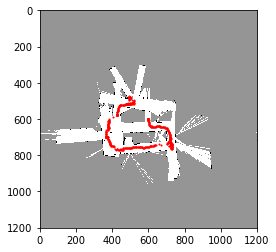

In [39]:
print len(all_negative_c_i)
print all_negative_c_i
print len(lidar_data0)
print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
print "test_dataset"
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

251
[6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7950, 8000, 8050, 8100, 8150, 8600, 8650, 8700, 8750, 9700, 9800, 9950, 10750, 10800, 10850, 10900, 10950, 11000, 11050, 11100, 11150, 11200, 11250, 11300, 11350, 11400, 11450, 11500, 11550, 11600, 11650, 11700, 11750, 11800, 11850, 11900, 11950, 12000, 12050, 12100, 12150, 12200, 12250, 12300, 12350, 12400, 12450, 12500, 12550, 12600, 12650, 12700, 12750, 12800, 12850, 12900, 12950, 13000, 13050, 13100, 13150, 13350, 13400, 13450, 13600, 13700, 13750, 13800, 13850, 13900, 13950, 14000, 14050, 14100, 14150, 14200, 14250, 14300, 14350, 14400, 14450, 14500, 14550, 14600, 14650, 14700, 14750, 14800, 14850, 14900, 14950, 15000, 15050, 15100, 15150, 15200, 15250, 15300, 15350, 15400, 15450, 15500, 15550, 15600, 15650, 15700, 15750, 15800, 15850, 15900, 15950, 18300, 19000, 19050, 19100, 20900, 21050, 21950, 22550, 22800, 24250, 25800, 25850, 25900, 25950, 26000, 26050, 26100, 26150, 26200, 26250, 

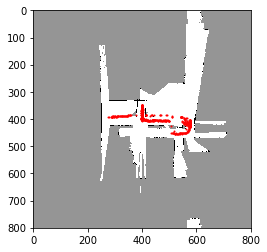

In [23]:
print len(all_negative_c_i)
print all_negative_c_i
print len(lidar_data0)
print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
print "dataset_num: " + str(dataset_num)
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

41
[6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 8500, 8550, 8600, 8650, 8700, 8750, 8800, 8850, 10350, 10750]
12679
Mapping Complete!
Testing duration: 1829.08812118
dataset_num: 2
Resampled 252 times...
Filter Number: 100
Step size: 50
Sigma x, y, yaw: 0.6, 0.6, 0.105


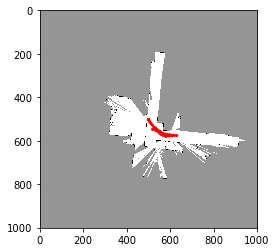

In [29]:
print len(all_negative_c_i)
print all_negative_c_i
print len(lidar_data0)
print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
print "dataset_num: " + str(dataset_num)
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

27
[8300, 9500, 9550, 9600, 9650, 9700, 9750, 9800, 9850, 9900, 9950, 10000, 10050, 10100, 10150, 10200, 10250, 10300, 10350, 10400, 10450, 10500, 10650, 10700, 10750, 10800, 10850]
12386
Mapping Complete!
Testing duration: 2109.23820114
dataset_num: 3
Resampled 246 times...
Filter Number: 100
Step size: 50
Sigma x, y, yaw: 0.6, 0.6, 0.105


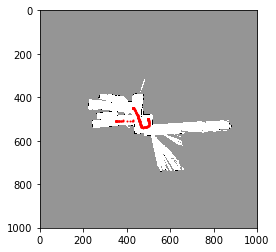

In [35]:
print len(all_negative_c_i)
print all_negative_c_i
print len(lidar_data0)
print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
print "dataset_num: " + str(dataset_num)
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

0
[]
12048
Mapping Complete!
Testing duration: 2030.87385798
dataset_num: 0
Resampled 239 times...
Filter Number: 100
Step size: 50
Sigma x, y, yaw: 0.6, 0.6, 0.105


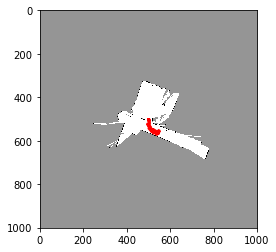

In [26]:
print len(all_negative_c_i)
print all_negative_c_i
print len(lidar_data0)
print "Mapping Complete!"
print "Testing duration: " + str(time.time() - start_time)
print "dataset_num: " + str(dataset_num)
print "Resampled {0} times...".format(resample_count)
print "Filter Number: " + str(filter_num)
print "Step size: " + str(step_size)
print "Sigma x, y, yaw: {0}, {1}, {2}".format(sigma_x, sigma_y, sigma_yaw)
plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
plt.show()

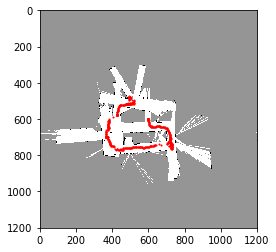

In [40]:
# Cell used to save the map plot

plt.imshow(MAP['map'], cmap="Greys")
plt.plot(yis, xis, "ro", markersize = 1.0)
#plt.savefig('dataset3_SLAM_map_50particle_50timestep.png')
plt.savefig('test_set_SLAM_map_100particle_50timestep_var0.6, 0.6, 0.105.png')
plt.show()